In [1]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string
import sys
from IPython.display import IFrame

# VEST AL 2018
---

## VEST Documentation

### Election Results

#### Sources
Election results from the Alabama Secretary of State Elections Division (https://www.sos.alabama.gov/alabama-votes/voter/election-data). 

Incorrect or incomplete data was replaced using the county canvass reports for the following counties: Dallas, Chilton, Covington, Escambia, Lauderdale, Monroe, Pickens, Russell.


#### Processing
Absentee and provisional ballots were reported countywide in all counties. These were distributed by candidate to precincts based on their share of the precinct-level reported vote.


### Shapefiles

#### Sources
Precinct shapefiles initially from the U.S. Census Bureau's 2020 Redistricting Data Program final release, except the following counties use shapefiles sourced from the respective county governments instead: Baldwin, Blount, Calhoun, Cullman, DeKalb, Franklin, Jefferson, Lee, Limestone, Madison, Marengo, Marshall, Mobile, Montgomery, Morgan, St. Clair, Shelby, Talladega, Tuscaloosa.

### Processing
Precinct boundaries were adjusted as appropriate to align with county maps, municipal boundaries, or commission districts. Precinct boundaries throughout the state were further reviewed with the voter registration file in effect for the November 2018 general election. Voting districts in nearly all counties were edited accordingly to align with reporting units in the 2018 election results. In many counties the resulting boundaries bear little resemblance to the 2020 Census VTDs. As these boundary revisions were so extensive only splits and merges are specified below by precinct.

Many precincts have outdated names in the Census VTDs. The Census VTDs also have at least some precinct names in wrong locations for the following counties: Clarke, Clay, Cleburne, Conecuh, Dallas, Escambia, Geneva, Greene, Jefferson, Lauderdale, Limestone, Marion, Marshall, Monroe, Perry, Randolph, Russell, Tallapoosa, Walker, Washington, Wilcox. Moreover, many precinct numbers and consequently the VTD GeoIDs are also incorrect throughout much of the state in the Census shapefiles. All precinct names and numbers have been edited to match the 2018 voter file.

The following splits and merges were made to align voting district boundaries with reporting units in the 2018 election results.

- Barbour: Split Eufaula between Bevill/CC/Fellowship/McCoo/Sanford/WB
- Calhoun: Add precinct splits to Beats 1, 4, 5, 9, 12, 13, 15, 19, 22
- Cherokee: Split Friendship/Mt Calvary, McCord's/Rock Run, Mt Weisner/VFD #2
- Choctaw: Split Cromwell/Halsell/Intersection
- Clarke: Split Antioch/Grove Hill/Helwestern, Choctaw Bluff/Gainstown, Grove Hill NG/Whatley, Jackson/Skipper, Springfield/Thomasville; Merge Fulton FS/CH
- Covington: Split Heath/Straughn, Pleasant Home/Wing
- Cullman: Split Cullman City Hall/Civic Ctr/Conf Room/Courthouse
- Dallas: Merge Marion Jct/New Friendship
- Etowah: Merge Fords Valley/Hokes Bluff, Tabernacle/Walnut Park
- Fayette: Split Browns-Glen Allen/Whites Chapel, Cole-Killingsworth/Paul Hubbert, Elm Grove/Studdard's, Fayette CC/Covin/YC, Lee-Belk/Palestine
- Geneva: Split Bellwood/Chancellor, Flat Creek/Hacoda, Geneva CC/CH/CO/FC/NG, Hughes VH/Malvern, Lowery/Revels, Piney Grove/Samson/Samson Masonic, Slocomb/Tate
- Jackson: Split Holly Springs/Pleasant Groves
- Jefferson: Split 3020/3025 Pleasant Hill/McAdory; Merge 2350/5270 as Oxmoor Valley
- Marion: Split Kimbrough N/S; Merge Hamilton N/S as ET Sims
- Monroe: Split Chrysler/Mineola, Coleman/Excel, Franklin/Wainwright, Peterman/Philadelphia
- Randolph: Split Bethel/Moores/Woodland, Cavers/Swagg, Corinth/Morrison, Midway/New Hope/Wedowee, Omaha/Tin Shop/Wehadkee, Rock Mills/Wilson
- Russell: Split Courthouse/Golden Acres
- Tallapoosa: Split Cooper/Duncan/Moncrief; Merge New Paces 901/902 to match county shapefile
- Wilcox: Split National Guard Camden, Pine Apple Comm Ctr, Pine Apple AWIN, St Paul Church
- Winston: Split Addison/Upshaw, Delmar/Natural Bridge, Haleyville/Neighborhood/Pebble/Waldrop, Lynn/Old Union, Nesmith/Helicon


# Election Result Processing

## Get VEST file and FIPS dictionary ready

### Load in VEST file

In [2]:
vest_al_18 = gp.read_file("./raw-from-source/VEST/al_2018/al_2018.shp")

In [3]:
vest_al_18.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

<AxesSubplot:>

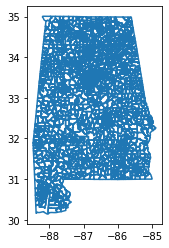

In [4]:
vest_al_18.boundary.plot()

In [5]:
vest_al_18.columns

Index(['STATEFP20', 'COUNTYFP20', 'VTDST18', 'GEOID18', 'NAME18', 'G18GOVRIVE',
       'G18GOVDMAD', 'G18GOVOWRI', 'G18LTGRAIN', 'G18LTGDBOY', 'G18LTGOWRI',
       'G18ATGRMAR', 'G18ATGDSIE', 'G18ATGOWRI', 'G18TRERMCM', 'G18TREOWRI',
       'G18AGRRPAT', 'G18AGROWRI', 'G18SOSRMER', 'G18SOSDMIL', 'G18SOSOWRI',
       'G18AUDRZEI', 'G18AUDDJOS', 'G18AUDOWRI', 'G18SSCRPAR', 'G18SSCDVAN',
       'G18SSCOWRI', 'G18SSCRSTE', 'G18SSCOWR2', 'G18SSCRBRY', 'G18SSCOWR3',
       'G18SSCRSEL', 'G18SSCOWR4', 'G18SSCRMIT', 'G18SSCDSMA', 'G18SSCOWR5',
       'G18SACREDW', 'G18SACOWRI', 'G18SACRHAN', 'G18SACOWR2', 'G18SACRMOO',
       'G18SACOWR3', 'G18SCCRMIN', 'G18SCCOWRI', 'G18SCCRMCC', 'G18SCCOWR2',
       'G18SCCRCOL', 'G18SCCOWR3', 'G18PSCRODE', 'G18PSCDMCC', 'G18PSCOWRI',
       'G18PSCRBEE', 'G18PSCDPOW', 'G18PSCOWR2', 'geometry'],
      dtype='object')

In [6]:
vest_al_18.head(5)

STATEFP20 COUNTYFP20 VTDST18      GEOID18                  NAME18  \
0        01        013  000100  01013000100   Monterey School House   
1        01        013  000181  01013000181                 Bolling   
2        01        053  000080  01053000080     Rock Hill-Ridge VFD   
3        01        053  000120  01053000120  Damascus-Boykin School   
4        01        053  000100  01053000100             Bradley VFD   

   G18GOVRIVE  G18GOVDMAD  G18GOVOWRI  G18LTGRAIN  G18LTGDBOY  ...  \
0          25          29           0          22          31  ...   
1          73          37           0          71          35  ...   
2         167          62           4         164          66  ...   
3         145         101           0         130         110  ...   
4          53           6           0          52           5  ...   

   G18SCCOWR2  G18SCCRCOL  G18SCCOWR3  G18PSCRODE  G18PSCDMCC  G18PSCOWRI  \
0           2          23           2          22          30           0   
1           4          70           4          69          35           0   
2           2         169           2         163          65           0   
3           1         129           1         129         107           0   
4           0          49           0          50           3           0   

   G18PSCRBEE  G18PSCDPOW  G18PSCOWR2  \
0          22          30           0   
1          69          35           0   
2         161          65           0   
3         128         105           0   
4          50           3           0   

                                            geometry  
0  POLYGON ((-86.90894 31.96167, -86.90632 31.961...  
1  POLYGON ((-86.71867 31.73289, -86.71864 31.732...  
2  POLYGON ((-87.05166 31.11854, -87.04869 31.118...  
3  POLYGON ((-86.95858 31.16635, -86.95844 31.166...  
4  POLYGON ((-86.82985 31.02083, -86.82983 31.020...  

[5 rows x 55 columns]

### Create a FIPs dictionary

In [7]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Alabama"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

#Create the dictionary
al_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

## Election Results

### Load, Pivot, Clean Election Results

There is a directory of excel files that need to be pivoted of election results. 

First, confirm that the file structure is the same for all of the files:

In [8]:
files = os.listdir('./raw-from-source/SOS/2018-Official-General-Precinct-Results/')

In [9]:
temp = pd.read_excel('./raw-from-source/SOS/2018-Official-General-Precinct-Results/2018-General-Autauga.xls')
columns = temp.columns
print(columns)

flag = True
for file in files: 
    temp = pd.read_excel('./raw-from-source/SOS/2018-Official-General-Precinct-Results/' + file)
    if columns.to_list()[:3] != temp.columns.to_list()[:3]:
        print(columns)
        print(temp.columns)
        flag = False
if flag:
    print('All files have the same first 3 columns: ', columns.to_list()[:3])

Index(['Contest Title', 'Party', 'Candidate', '10 JONES COMMUNITY CTR',
       '100 TRINITY METHODIST', '110 CENTRAL AL ELECTRIC',
       '140 AUTAUGAVILLE VFD', '150 PRATTMONT BAPTIST CH',
       '160 DOSTER COMMUNITY CTR', '170 CAMELLIA BAPTIST CH',
       '180 OLD KINGSTON VFD', '20 HERITAGE BAPTIST', '220 UPPER KINGSTON',
       '230 COUNTY LINE BAPTIST', '30 BILLINGSLEY COMM_ CTR_',
       '40  E_MEMORIAL CHRISTIAN', '50 WHITE CITY VFD',
       '60 MARBURY MIDDLE SCH', '70 BOONE'S CHAPEL', '80 INDEPENDENCE VFD',
       '90 BOOTH VFD', 'ABSENTEE', 'PROVISIONAL'],
      dtype='object')
All files have the same first 3 columns:  ['Contest Title', 'Party', 'Candidate']


Next, go through and pivot each file, clean them, and concatenate. 

In [10]:
def pivot_clean_county_file(df, county_name): 
    """Given a dataframe, pivot the table, order and rename columns, and return the cleaned table that can be concatenated. """
    
    df_pivot = pd.pivot_table(df,values=[x for x in df.columns.to_list() if x not in ('Contest Title','Party','Candidate')],
                              columns=['Contest Title',"Candidate"],aggfunc=sum)
    df_pivot['county'] = county_name
    df_pivot.reset_index(inplace = True)
    df_pivot.columns = [(x.strip(), y.strip()) for x,y in df_pivot.columns.values]
        
    if county_name in ('Covington','Lauderdale','Escambia','Monroe','Pickens'):
        cols_to_add = [('CHIEF JUSTICE OF THE SUPREME COURT', 'Write-In'), ('COURT OF CRIMINAL APPEALS JUDGE, PLACE 3', 'Write-In'), ('ATTORNEY GENERAL', 'Write-In'), ('COURT OF CIVIL APPEALS JUDGE, PLACE 2', 'Write-In'), ('PUBLIC SERVICE COMMISSION, PLACE 2', 'Write-In'), ('SECRETARY OF STATE', 'Write-In'), ('STATE AUDITOR', 'Write-In'), ('COMMISSIONER OF AGRICULTURE AND INDUSTRIES', 'Write-In'), ('LIEUTENANT GOVERNOR', 'Write-In'), ('COURT OF CIVIL APPEALS JUDGE, PLACE 1', 'Write-In'), ('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 4', 'Write-In'), ('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 1', 'Write-In'), ('COURT OF CIVIL APPEALS JUDGE, PLACE 3', 'Write-In'), ('COURT OF CRIMINAL APPEALS JUDGE, PLACE 1', 'Write-In'), ('GOVERNOR', 'Write-In'), ('STATE TREASURER', 'Write-In'), ('PUBLIC SERVICE COMMISSION, PLACE 1', 'Write-In'), ('COURT OF CRIMINAL APPEALS JUDGE, PLACE 2', 'Write-In'), ('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 3', 'Write-In'), ('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 2', 'Write-In')]
        for x,y in cols_to_add:
            df_pivot[x,y] = 0
    
    if county_name == 'Marion':
        ajsc1 = [('ASSOCIATE JUSTICE OF THE SUPREME COURT. PLACE NO. 1', 'Sarah Hicks Stewart'), ('ASSOCIATE JUSTICE OF THE SUPREME COURT. PLACE NO. 1', 'Write-In')]
    else:
        ajsc1 = [('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 1', 'Sarah Hicks Stewart'), ('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 1', 'Write-In')]
    
    clean_df = df_pivot[[('index',''),('county',''),
                        ('GOVERNOR', 'Kay Ivey'), ('GOVERNOR', 'Walt Maddox'), ('GOVERNOR', 'Write-In'),
                        ('LIEUTENANT GOVERNOR', 'Will Ainsworth'), ('LIEUTENANT GOVERNOR', 'Will Boyd'), ('LIEUTENANT GOVERNOR', 'Write-In'),
                        ('ATTORNEY GENERAL', 'Steve Marshall'), ('ATTORNEY GENERAL', 'Joseph Siegelman'), ('ATTORNEY GENERAL', 'Write-In'),
                        ('STATE TREASURER', 'John McMillan'), ('STATE TREASURER', 'Write-In'),
                        ('COMMISSIONER OF AGRICULTURE AND INDUSTRIES', 'Rick Pate'), ('COMMISSIONER OF AGRICULTURE AND INDUSTRIES', 'Write-In'),
                        ('SECRETARY OF STATE', 'John H. Merrill'), ('SECRETARY OF STATE', 'Heather Milam'), ('SECRETARY OF STATE', 'Write-In'),
                        ('STATE AUDITOR', 'Jim Zeigler'), ('STATE AUDITOR', 'Miranda Karrine Joseph'), ('STATE AUDITOR', 'Write-In'), 
                        ('CHIEF JUSTICE OF THE SUPREME COURT', 'Tom Parker'), ('CHIEF JUSTICE OF THE SUPREME COURT', 'Bob Vance, Jr.'), ('CHIEF JUSTICE OF THE SUPREME COURT', 'Write-In')]
                        + ajsc1 +
                        [('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 2', 'Tommy Bryan'), ('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 2', 'Write-In'),
                        ('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 3', 'Will Sellers'), ('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 3', 'Write-In'),
                        ('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 4', 'Jay Mitchell'), ('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 4', 'Donna Wesson Smalley'), ('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 4', 'Write-In'),
                        ('COURT OF CIVIL APPEALS JUDGE, PLACE 1', 'Christy Olinger Edwards'), ('COURT OF CIVIL APPEALS JUDGE, PLACE 1', 'Write-In'),
                        ('COURT OF CIVIL APPEALS JUDGE, PLACE 2', 'Chad Hanson'), ('COURT OF CIVIL APPEALS JUDGE, PLACE 2', 'Write-In'), 
                        ('COURT OF CIVIL APPEALS JUDGE, PLACE 3', 'Terry A. Moore'), ('COURT OF CIVIL APPEALS JUDGE, PLACE 3', 'Write-In'), 
                        ('COURT OF CRIMINAL APPEALS JUDGE, PLACE 1', 'Richard Minor'), ('COURT OF CRIMINAL APPEALS JUDGE, PLACE 1', 'Write-In'), 
                        ('COURT OF CRIMINAL APPEALS JUDGE, PLACE 2', 'Chris McCool'), ('COURT OF CRIMINAL APPEALS JUDGE, PLACE 2', 'Write-In'), 
                        ('COURT OF CRIMINAL APPEALS JUDGE, PLACE 3', 'Bill Cole'), ('COURT OF CRIMINAL APPEALS JUDGE, PLACE 3', 'Write-In'),
                        ('PUBLIC SERVICE COMMISSION, PLACE 1', 'Jeremy H. Oden'), ('PUBLIC SERVICE COMMISSION, PLACE 1', 'Cara Y. McClure'), ('PUBLIC SERVICE COMMISSION, PLACE 1', 'Write-In'), 
                        ('PUBLIC SERVICE COMMISSION, PLACE 2', 'Chris "Chip" Beeker Jr.'), ('PUBLIC SERVICE COMMISSION, PLACE 2', 'Kari Powell'), ('PUBLIC SERVICE COMMISSION, PLACE 2', 'Write-In')]]
    clean_df.columns = ['precinct','county','G18GOVRIVE',
                        'G18GOVDMAD', 'G18GOVOWRI', 'G18LTGRAIN', 'G18LTGDBOY', 'G18LTGOWRI',
                        'G18ATGRMAR', 'G18ATGDSIE', 'G18ATGOWRI', 'G18TRERMCM', 'G18TREOWRI',
                        'G18AGRRPAT', 'G18AGROWRI', 'G18SOSRMER', 'G18SOSDMIL', 'G18SOSOWRI',
                        'G18AUDRZEI', 'G18AUDDJOS', 'G18AUDOWRI', 'G18SSCRPAR', 'G18SSCDVAN',
                        'G18SSCOWRI', 'G18SSCRSTE', 'G18SSCOWR2', 'G18SSCRBRY', 'G18SSCOWR3',
                        'G18SSCRSEL', 'G18SSCOWR4', 'G18SSCRMIT', 'G18SSCDSMA', 'G18SSCOWR5',
                        'G18SACREDW', 'G18SACOWRI', 'G18SACRHAN', 'G18SACOWR2', 'G18SACRMOO',
                        'G18SACOWR3', 'G18SCCRMIN', 'G18SCCOWRI', 'G18SCCRMCC', 'G18SCCOWR2',
                        'G18SCCRCOL', 'G18SCCOWR3', 'G18PSCRODE', 'G18PSCDMCC', 'G18PSCOWRI',
                        'G18PSCRBEE', 'G18PSCDPOW', 'G18PSCOWR2']
    
    return clean_df



In [11]:
flag = 0
for file in files: 
    temp = pd.read_excel('./raw-from-source/SOS/2018-Official-General-Precinct-Results/' + file)
#     print(file.split('-')[2][:-4])
    clean_df = pivot_clean_county_file(temp, file.split('-')[2][:-4])
    if flag == 0:
        results_2018 = clean_df
        flag = 1
    else:
        results_2018 = pd.concat([results_2018, clean_df])

Add county fips to election results file

In [12]:
# Change column names to match the county fips dict
results_2018.loc[results_2018['county'] == 'StClair', 'county'] = 'St Clair'
results_2018.loc[results_2018['county'] == 'DeKalb', 'county'] = 'De Kalb'

#Map to the correct FIP
results_2018["county_fips"]=results_2018["county"].map(al_fips_dict).fillna(results_2018["county"])

#Print out the FIPS to make sure they all are in the correct format
results_2018["county_fips"].unique()

array(['081', '083', '005', '003', '017', '111', '113', '039', '067',
       '019', '077', '029', '115', '097', '041', '051', '055', '117',
       '057', '123', '103', '035', '075', '061', '023', '027', '089',
       '133', '129', '047', '025', '011', '109', '033', '021', '053',
       '037', '059', '119', '105', '071', '031', '087', '121', '007',
       '015', '009', '091', '013', '131', '095', '125', '099', '065',
       '049', '127', '045', '043', '085', '101', '073', '107', '079',
       '063', '093', '001', '069'], dtype=object)

In [13]:
results_2018.shape

(2240, 52)

In [14]:
vest_al_18.shape

(1992, 55)

## Compare Election Results Totals

### Compare Total Votes

In [15]:
races = [x for x in vest_al_18.columns if 'G18' in x]

sum_var_1 = 0
sum_var_2 = 0
for i in races:
    sum_var_1 += np.sum(vest_al_18[i])
    sum_var_2 += np.sum(results_2018[i])
print(sum_var_1)
print(sum_var_2)

27534810
27496872.0


### Compare County Totals

The `compare()` method shows rows where the values are different, by default. So displaying nothing here is good, all county race totals are equal. 

In [16]:
#021 should go to either 021-PROVIDENCE BAPTIST
# or
#021-PROVIDENCE E CHILTON FIRE ST

In [17]:
#047 should go to either

#['Broad St Fire', 'Broad Street Fire Station']


In [18]:
count = 0
votes_to_add = pd.DataFrame(columns=["county","candidate","value"])
diff_counties=[]
for i in races:
    diff = results_2018.groupby(['county_fips']).sum()[i]-vest_al_18.groupby(['COUNTYFP20']).sum()[i]
    for val in diff[diff != 0].index.values.tolist():
        if val not in diff_counties:
            diff_counties.append(val)
    if len(diff[diff != 0]!=0):
        print(i)
        print(diff[diff != 0].to_string(header=False))
        for index,row in diff[diff != 0].iteritems():
            votes_to_add.loc[count] = [index,i,-int(row)]
            count+=1
print("All other races in all counties are equal")

G18GOVRIVE
021   -804.0
047   -375.0
113     -2.0
G18GOVDMAD
021   -154.0
047   -327.0
113     -3.0
G18GOVOWRI
039   -22.0
047    -2.0
053   -19.0
077   -51.0
099    -5.0
107    -8.0
G18LTGRAIN
021   -808.0
047   -353.0
113     -2.0
G18LTGDBOY
021   -146.0
047   -331.0
113     -3.0
G18LTGOWRI
039    -7.0
047    -2.0
053    -5.0
077   -19.0
099    -5.0
107    -5.0
G18ATGRMAR
021   -800.0
047   -339.0
113     -1.0
G18ATGDSIE
021   -153.0
047   -356.0
113     -4.0
G18ATGOWRI
039    -4.0
047    -1.0
053    -7.0
077   -23.0
099    -3.0
107    -6.0
G18TRERMCM
021   -843.0
047   -349.0
113     -3.0
G18TREOWRI
021     -7.0
039    -48.0
047    -10.0
053   -110.0
077   -486.0
099    -77.0
107    -93.0
G18AGRRPAT
021   -841.0
047   -353.0
113     -3.0
G18AGROWRI
021     -7.0
039    -50.0
047    -10.0
053   -106.0
077   -476.0
099    -83.0
107    -89.0
G18SOSRMER
021   -804.0
047   -355.0
G18SOSDMIL
021   -148.0
047   -316.0
113     -3.0
G18SOSOWRI
021    -1.0
039    -4.0
047    -3.0
053    -6.0
0

In [19]:
print(diff_counties)
print(votes_to_add)

# Check we aren't adding negative votes
print(min(votes_to_add["value"]))

al_fips_dict = dict(zip(fips_file["FIPS County"],fips_file["County Name"]))

for county in diff_counties:
    print(al_fips_dict[county])

['021', '047', '113', '039', '053', '077', '099', '107']
    county   candidate value
0      021  G18GOVRIVE   804
1      047  G18GOVRIVE   375
2      113  G18GOVRIVE     2
3      021  G18GOVDMAD   154
4      047  G18GOVDMAD   327
..     ...         ...   ...
215    047  G18PSCOWR2     4
216    053  G18PSCOWR2     4
217    077  G18PSCOWR2    21
218    099  G18PSCOWR2     2
219    107  G18PSCOWR2     1

[220 rows x 3 columns]
1
Chilton
Dallas
Russell
Covington
Escambia
Lauderdale
Monroe
Pickens


### Make a dataframe to add in the extra votes

In [20]:
votes_to_add_pivot = pd.pivot_table(votes_to_add,index=["county"],values="value",columns=["candidate"],aggfunc=sum)
votes_to_add_pivot.reset_index(inplace=True,drop=False)
votes_to_add_pivot = votes_to_add_pivot.fillna(0)
print(votes_to_add_pivot)

candidate county  G18AGROWRI  G18AGRRPAT  G18ATGDSIE  G18ATGOWRI  G18ATGRMAR  \
0            021         7.0       841.0       153.0         0.0       800.0   
1            039        50.0         0.0         0.0         4.0         0.0   
2            047        10.0       353.0       356.0         1.0       339.0   
3            053       106.0         0.0         0.0         7.0         0.0   
4            077       476.0         0.0         0.0        23.0         0.0   
5            099        83.0         0.0         0.0         3.0         0.0   
6            107        89.0         0.0         0.0         6.0         0.0   
7            113         0.0         3.0         4.0         0.0         1.0   

candidate  G18AUDDJOS  G18AUDOWRI  G18AUDRZEI  G18GOVDMAD  ...  G18SSCOWR4  \
0               150.0         0.0       797.0       154.0  ...        11.0   
1                 0.0         6.0         0.0         0.0  ...        45.0   
2               322.0         3.0       347.0

In [21]:
#may need to delete this
votes_to_add_pivot = votes_to_add_pivot[~votes_to_add_pivot["county"].isin(["021","047"])]

In [22]:
source_county_sums = results_2018.groupby(['county_fips']).sum()
vest_county_sums = vest_al_18.groupby(['COUNTYFP20']).sum()

### Compare Race Totals

In [24]:
def statewide_totals_check(partner_df,source_df,column_list):
    print("***Statewide Totals Check***")
    for race in column_list:
        if (sum(partner_df[race])- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(sum(partner_df[race])-source_df[race].sum())+" votes")
            print("\tVEST: "+str(sum(partner_df[race]))+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(sum(partner_df[race])))

In [25]:
statewide_totals_check(vest_al_18,results_2018,races)

***Statewide Totals Check***
G18GOVRIVE has a difference of 1181.0 votes
	VEST: 1022457 votes
	SOURCES: 1021276.0 votes
G18GOVDMAD has a difference of 484.0 votes
	VEST: 694495 votes
	SOURCES: 694011.0 votes
G18GOVOWRI has a difference of 107.0 votes
	VEST: 2637 votes
	SOURCES: 2530.0 votes
G18LTGRAIN has a difference of 1163.0 votes
	VEST: 1044941 votes
	SOURCES: 1043778.0 votes
G18LTGDBOY has a difference of 480.0 votes
	VEST: 660013 votes
	SOURCES: 659533.0 votes
G18LTGOWRI has a difference of 43.0 votes
	VEST: 1023 votes
	SOURCES: 980.0 votes
G18ATGRMAR has a difference of 1140.0 votes
	VEST: 1004438 votes
	SOURCES: 1003298.0 votes
G18ATGDSIE has a difference of 513.0 votes
	VEST: 702858 votes
	SOURCES: 702345.0 votes
G18ATGOWRI has a difference of 44.0 votes
	VEST: 1141 votes
	SOURCES: 1097.0 votes
G18TRERMCM has a difference of 1195.0 votes
	VEST: 1085054 votes
	SOURCES: 1083859.0 votes
G18TREOWRI has a difference of 831.0 votes
	VEST: 31968 votes
	SOURCES: 31137.0 votes
G18AGRRP

In [26]:
results_2018["unique_ID"] = results_2018["county_fips"] +"-"+results_2018["precinct"]

vest_al_18["unique_ID"] = vest_al_18["COUNTYFP20"] +"-"+vest_al_18["NAME18"].str.upper()

pro_ab_list = list(results_2018[(results_2018["precinct"].str.contains("ABSENTEE")) |(results_2018["precinct"].str.contains("PROVISIONAL")) | (results_2018["unique_ID"].isin(["031-PROVISONAL","039-PROVSIONAL","101-ABSEN","101-PROVI","021-ABSEN"]))]["unique_ID"])


In [27]:
print(pro_ab_list)

non_prov_absentee = results_2018[~results_2018["unique_ID"].isin(pro_ab_list)]
prov_absentee = results_2018[results_2018["unique_ID"].isin(pro_ab_list)]

['081-ABSENTEE BS 1-20', '081-ABSENTEE BS 21-45', '081-PROVISIONAL BS 1-20', '081-PROVISIONAL BS 21-45', '083-ABSENTEE', '083-PROVISIONAL', '005-ABSENTEE', '005-PROVISIONAL', '003-ABSENTEE', '003-PROVISIONAL', '017-ABSENTEE', '017-PROVISIONAL', '111-ABSENTEE', '111-PROVISIONAL', '113-ABSENTEE', '113-PROVISIONAL', '039-ABSENTEE', '039-PROVSIONAL', '067-ABSENTEE', '067-PROVISIONAL', '019-ABSENTEE', '019-PROVISIONAL', '077-ABSENTEE', '077-PROVISIONAL', '029-ABSENTEE', '029-PROVISIONAL', '115-ABSENTEE', '115-PROVISIONAL', '097-ABSENTEE', '097-PROVISIONAL', '041-ABSENTEE', '041-PROVISIONAL', '051-ABSENTEE', '051-PROVISIONAL', '055-ABSENTEE', '055-PROVISIONAL', '117-ABSENTEE', '117-PROVISIONAL', '057-ABSENTEE', '057-PROVISIONAL', '123-ABSENTEE', '123-PROVISIONAL', '103-ABSENTEE', '103-PROVISIONAL', '035-ABSENTEE', '035-PROVISIONAL', '075-ABSENTEE', '075-PROVISIONAL', '061-ABSENTEE', '061-PROVISIONAL', '023-ABSENTEE', '023-PROVISIONAL', '027-ABSENTEE', '027-PROVISIONAL', '089-ABSENTEE #1', '0

In [28]:
prov_absentee["county"].value_counts()

Jefferson    5
Lee          4
Madison      4
Marshall     2
Escambia     2
            ..
Lawrence     2
Lowndes      2
Calhoun      2
Perry        2
Chilton      1
Name: county, Length: 67, dtype: int64

#### Need to deal with Jefferson, Lee and Madison absentee votes

In [29]:
#Madison - Can't find what applies where
#Jefferson - Mix of places, need to dive into it
#Lee - Might be possible to find

In [30]:
print(votes_to_add_pivot[votes_to_add_pivot["county"]=="021"])

Empty DataFrame
Columns: [county, G18AGROWRI, G18AGRRPAT, G18ATGDSIE, G18ATGOWRI, G18ATGRMAR, G18AUDDJOS, G18AUDOWRI, G18AUDRZEI, G18GOVDMAD, G18GOVOWRI, G18GOVRIVE, G18LTGDBOY, G18LTGOWRI, G18LTGRAIN, G18PSCDMCC, G18PSCDPOW, G18PSCOWR2, G18PSCOWRI, G18PSCRBEE, G18PSCRODE, G18SACOWR2, G18SACOWR3, G18SACOWRI, G18SACREDW, G18SACRHAN, G18SACRMOO, G18SCCOWR2, G18SCCOWR3, G18SCCOWRI, G18SCCRCOL, G18SCCRMCC, G18SCCRMIN, G18SOSDMIL, G18SOSOWRI, G18SOSRMER, G18SSCDSMA, G18SSCDVAN, G18SSCOWR2, G18SSCOWR3, G18SSCOWR4, G18SSCOWR5, G18SSCOWRI, G18SSCRBRY, G18SSCRMIT, G18SSCRPAR, G18SSCRSEL, G18SSCRSTE, G18TREOWRI, G18TRERMCM]
Index: []

[0 rows x 50 columns]


In [31]:
#SKIP FOR NOW
#print(prov_absentee[prov_absentee["county"]=="Jefferson"])
#print(prov_absentee[prov_absentee["county"]=="Lee"])
#print(prov_absentee[prov_absentee["county"]=="Madison"])

In [32]:
def vote_merger (merge_list,new_name):
    global non_prov_absentee
    races = [x for x in vest_al_18.columns if 'G18' in x]

    #Add in the other votes
    
    for i in range(1,len(merge_list)):
        for race in races:
            non_prov_absentee.loc[non_prov_absentee["unique_ID"]==merge_list[0],race]+=int(non_prov_absentee.loc[non_prov_absentee["unique_ID"]==merge_list[i],race])
    
    #Update the unique ID
    non_prov_absentee.loc[non_prov_absentee["unique_ID"]==merge_list[0],"unique_ID"]=new_name
    
    #Remove the ones that aren't needed
    non_prov_absentee = non_prov_absentee[~non_prov_absentee["unique_ID"].isin(merge_list[1:])]
    
    non_prov_absentee.reset_index(inplace=True,drop=True)

In [33]:
non_prov_absentee[non_prov_absentee["unique_ID"].str[0:3]=="097"]

non_prov_absentee["ID_len"] = non_prov_absentee["unique_ID"].apply(lambda x: x[0:len(x)-3] if x[0:3]=="097" else x)

<ipython-input-33-5acc3d8ae8e4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_prov_absentee["ID_len"] = non_prov_absentee["unique_ID"].apply(lambda x: x[0:len(x)-3] if x[0:3]=="097" else x)


In [34]:
#Load in the nationwide FIPS file
names_97 = pd.read_csv("./97_names.csv")




#Create the dictionary
names_97_dict = dict(zip(names_97["og_names"],names_97["new_names"]))

In [35]:
names_097 = list(non_prov_absentee[non_prov_absentee["unique_ID"].str[0:3]=="097"]["ID_len"].unique())

#Make a dictionary that maps from these names to the shortened 097

for i in names_097:
    merge_list = list(non_prov_absentee[non_prov_absentee["unique_ID"].str.contains(i)]["unique_ID"])
    #Create a dictionary here
    new_name = names_97_dict[i]
    vote_merger(merge_list,new_name)

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [36]:
vote_merger(["043-FAIRVIEW FIRE DEPT_ (A-K)","043-FAIRVIEW TOWN HALL (L-Z)"],"043-FAIRVIEW FD/TOWN HALL")
vote_merger(["049-FORT PAYNE SENIOR CITIZEN 1","049-FORT PAYNE SENIOR CITIZEN 2"],"049-FORT PAYNE SENIOR CTR")
vote_merger(["049-RAINSVILLE 1","049-RAINSVILLE 2"],"049-RAINSVILLE DEKALB SCHOOLS")
vote_merger(["049-WILLS VALLEY REC CTR 1","049-WILLS VALLEY REC CTR 2"],"049-WILLS VALLEY REC CENTER")
vote_merger(["049-VFW HALL LOBBY - FORT PAYNE 1","049-VFW HALL LOBBY - FORT PAYNE 2"],"049-VFW HALL")
vote_merger(["111-NATL GUARD ARMORY 1","111-NATL GUARD ARMORY 2","111-NATL GUARD ARMORY 3"],"111-NATIONAL GUARD ARMORY")
vote_merger(["111-WEDOWEE CITY HALL 1","111-WEDOWEE CITY HALL 2"],"111-WEDOWEE CITY HALL")

In [37]:
non_prov_absentee

precinct   county  G18GOVRIVE  G18GOVDMAD  G18GOVOWRI  \
0           BEULAH FIRE DEPT #3      Lee      1073.0       141.0         0.0   
1            BEULAH HIGH SCHOOL      Lee       767.0        78.0         2.0   
2               BOYKIN COMM CTR      Lee      1889.0      2166.0         5.0   
3         CLARION INN S COLLEGE      Lee      4017.0      2607.0        10.0   
4       COVINGTON PARK COMM CTR      Lee       163.0      1022.0         0.0   
...                         ...      ...         ...         ...         ...   
1984  WATER AND ELECTRIC COMPLX  Houston      1377.0       390.0         2.0   
1985             WEBB CITY HALL  Houston       393.0        97.0         1.0   
1986              WESTGATE PARK  Houston      2169.0       517.0         2.0   
1987              WICKSBURG VFD  Houston       925.0        73.0         2.0   
1988             WIREGRASS PARK  Houston       661.0       994.0         0.0   

      G18LTGRAIN  G18LTGDBOY  G18LTGOWRI  G18ATGRMAR  G18ATGDSIE  ...  \
0         1071.0       144.0         0.0      1067.0       149.0  ...   
1          766.0        76.0         0.0       759.0        84.0  ...   
2         1874.0      2145.0         3.0      1846.0      2177.0  ...   
3         4042.0      2520.0         4.0      3956.0      2607.0  ...   
4          143.0      1041.0         0.0       140.0      1042.0  ...   
...          ...         ...         ...         ...         ...  ...   
1984      1383.0       380.0         2.0      1330.0       430.0  ...   
1985       392.0        95.0         0.0       370.0       119.0  ...   
1986      2199.0       481.0         1.0      2123.0       556.0  ...   
1987       937.0        63.0         0.0       916.0        81.0  ...   
1988       616.0      1032.0         0.0       584.0      1064.0  ...   

      G18SCCOWR3  G18PSCRODE  G18PSCDMCC  G18PSCOWRI  G18PSCRBEE  G18PSCDPOW  \
0            8.0      1060.0       146.0         0.0      1056.0       149.0   
1            4.0       757.0        80.0         0.0       753.0        82.0   
2          109.0      1793.0      2157.0         4.0      1775.0      2179.0   
3          132.0      3874.0      2572.0         7.0      3824.0      2623.0   
4           22.0       134.0      1034.0         0.0       131.0      1042.0   
...          ...         ...         ...         ...         ...         ...   
1984        32.0      1353.0       389.0         0.0      1354.0       388.0   
1985         4.0       382.0        98.0         0.0       381.0        99.0   
1986        23.0      2146.0       494.0         0.0      2144.0       504.0   
1987         1.0       921.0        65.0         0.0       918.0        66.0   
1988        53.0       608.0      1020.0         1.0       611.0      1018.0   

      G18PSCOWR2  county_fips                      unique_ID  \
0            1.0          081        081-BEULAH FIRE DEPT #3   
1            0.0          081         081-BEULAH HIGH SCHOOL   
2            3.0          081            081-BOYKIN COMM CTR   
3            4.0          081      081-CLARION INN S COLLEGE   
4            0.0          081    081-COVINGTON PARK COMM CTR   
...          ...          ...                            ...   
1984         1.0          069  069-WATER AND ELECTRIC COMPLX   
1985         0.0          069             069-WEBB CITY HALL   
1986         1.0          069              069-WESTGATE PARK   
1987         0.0          069              069-WICKSBURG VFD   
1988         1.0          069             069-WIREGRASS PARK   

                             ID_len  
0           081-BEULAH FIRE DEPT #3  
1            081-BEULAH HIGH SCHOOL  
2               081-BOYKIN COMM CTR  
3         081-CLARION INN S COLLEGE  
4       081-COVINGTON PARK COMM CTR  
...                             ...  
1984  069-WATER AND ELECTRIC COMPLX  
1985             069-WEBB CITY HALL  
1986              069-WESTGATE PARK  
1987              069-WICKSBURG VFD  
1988             069-WIREGRASS PARK  

In [38]:
attempt_one = pd.merge(non_prov_absentee,vest_al_18,on="unique_ID",how="outer",indicator=True)
print(attempt_one["_merge"].value_counts())

elections_only = attempt_one[attempt_one["_merge"]=="left_only"]
elections_only.to_csv("./only_elections.csv")

vest_only = attempt_one[attempt_one["_merge"]=="right_only"]
vest_only.to_csv("./only_vest.csv")

right_only    1310
left_only     1307
both           682
Name: _merge, dtype: int64


In [39]:
#101 and 073 use VTDST18

In [40]:
source_vest_id_changes = pd.read_csv("./source_vest_id_changes.csv")

source_vest_id_changes_dict = dict(zip(source_vest_id_changes["source_ID"],source_vest_id_changes["vest_ID"]))

non_prov_absentee["unique_ID"] = non_prov_absentee["unique_ID"].map(source_vest_id_changes_dict).fillna(non_prov_absentee["unique_ID"])

In [41]:
attempt_one = pd.merge(non_prov_absentee,vest_al_18,on="unique_ID",how="outer",indicator=True)
print(attempt_one["_merge"].value_counts())

elections_only = attempt_one[attempt_one["_merge"]=="left_only"]
#elections_only.to_csv("./only_elections.csv")

vest_only = attempt_one[attempt_one["_merge"]=="right_only"]
#vest_only.to_csv("./only_vest.csv")

print(elections_only["unique_ID"])
print(vest_only["unique_ID"])

both          1987
right_only       5
left_only        2
Name: _merge, dtype: int64
841    047-BARRETT ROAD METH_ CHURCH
993                        021-PROVI
Name: unique_ID, dtype: object
1989    021-PROVIDENCE E CHILTON FIRE ST
1990              021-PROVIDENCE BAPTIST
1991                      031-UNASSIGNED
1992      047-BARRETT RD CHURCH (COUNTY)
1993        047-BARRETT RD CHURCH (CITY)
Name: unique_ID, dtype: object


In [42]:
to_dole_out_totals = pd.DataFrame(prov_absentee.groupby("county_fips").sum())
to_dole_out_totals.reset_index(drop=False,inplace=True)

precinct_specific_totals = pd.DataFrame(non_prov_absentee.groupby("county_fips").sum())
precinct_specific_totals.reset_index(drop=False,inplace=True)

In [43]:
print(non_prov_absentee)

                       precinct   county  G18GOVRIVE  G18GOVDMAD  G18GOVOWRI  \
0           BEULAH FIRE DEPT #3      Lee      1073.0       141.0         0.0   
1            BEULAH HIGH SCHOOL      Lee       767.0        78.0         2.0   
2               BOYKIN COMM CTR      Lee      1889.0      2166.0         5.0   
3         CLARION INN S COLLEGE      Lee      4017.0      2607.0        10.0   
4       COVINGTON PARK COMM CTR      Lee       163.0      1022.0         0.0   
...                         ...      ...         ...         ...         ...   
1984  WATER AND ELECTRIC COMPLX  Houston      1377.0       390.0         2.0   
1985             WEBB CITY HALL  Houston       393.0        97.0         1.0   
1986              WESTGATE PARK  Houston      2169.0       517.0         2.0   
1987              WICKSBURG VFD  Houston       925.0        73.0         2.0   
1988             WIREGRASS PARK  Houston       661.0       994.0         0.0   

      G18LTGRAIN  G18LTGDBOY  G18LTGOWR

In [44]:
data_columns = ['G18GOVRIVE',
       'G18GOVDMAD', 'G18GOVOWRI', 'G18LTGRAIN', 'G18LTGDBOY', 'G18LTGOWRI',
       'G18ATGRMAR', 'G18ATGDSIE', 'G18ATGOWRI', 'G18TRERMCM', 'G18TREOWRI',
       'G18AGRRPAT', 'G18AGROWRI', 'G18SOSRMER', 'G18SOSDMIL', 'G18SOSOWRI',
       'G18AUDRZEI', 'G18AUDDJOS', 'G18AUDOWRI', 'G18SSCRPAR', 'G18SSCDVAN',
       'G18SSCOWRI', 'G18SSCRSTE', 'G18SSCOWR2', 'G18SSCRBRY', 'G18SSCOWR3',
       'G18SSCRSEL', 'G18SSCOWR4', 'G18SSCRMIT', 'G18SSCDSMA', 'G18SSCOWR5',
       'G18SACREDW', 'G18SACOWRI', 'G18SACRHAN', 'G18SACOWR2', 'G18SACRMOO',
       'G18SACOWR3', 'G18SCCRMIN', 'G18SCCOWRI', 'G18SCCRMCC', 'G18SCCOWR2',
       'G18SCCRCOL', 'G18SCCOWR3', 'G18PSCRODE', 'G18PSCDMCC', 'G18PSCOWRI',
       'G18PSCRBEE', 'G18PSCDPOW', 'G18PSCOWR2']

In [45]:
#Create some new columns for each of these races to deal with the allocation
for race in races:
    add_var = race+"_add"
    rem_var = race+"_rem"
    floor_var = race+"_floor"
    non_prov_absentee.loc[:,add_var]=0.0
    non_prov_absentee.loc[:,rem_var]=0.0
    non_prov_absentee.loc[:,floor_var]=0.0

#Iterate over the rows
#Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate
for index, row in non_prov_absentee.iterrows():
    if row["county_fips"] in to_dole_out_totals["county_fips"].unique():
        for race in races:
            add_var = race+"_add"
            rem_var = race+"_rem"
            floor_var = race+"_floor"
            #Grab the district
            county_id = row["county_fips"]
            #Get the denominator for the allocation (the precinct vote totals)
            denom = precinct_specific_totals.loc[precinct_specific_totals["county_fips"]==county_id][race]
            #Get one of the numerators, how many districtwide votes to allocate
            numer = to_dole_out_totals.loc[to_dole_out_totals["county_fips"]==county_id][race]
            #Get the vote totals for this race in this precinct
            val = non_prov_absentee.at[index,race]
            #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
            if (float(denom==0)):
                vote_share = 0
            else:
                vote_share = (float(val)/float(denom))*float(numer)
            non_prov_absentee.at[index,add_var] = vote_share
            #Take the decimal remainder of the allocation
            non_prov_absentee.at[index,rem_var] = vote_share%1
            #Take the floor of the allocation
            non_prov_absentee.at[index,floor_var] = np.floor(vote_share)

#After the first pass through, get the sums of the races by district to assist in the rounding            
first_allocation = pd.DataFrame(non_prov_absentee.groupby(["county_fips"]).sum())

#Now we want to iterate district by district to work on rounding
county_list = list(to_dole_out_totals["county_fips"].unique()) 

#Iterate over the district
for county in county_list:
    for race in races:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
        to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals["county_fips"]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
        #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
        for index in non_prov_absentee.loc[non_prov_absentee["county_fips"]==county][rem_var].nlargest(to_go).index:
            non_prov_absentee.at[index,add_var] = np.ceil(non_prov_absentee.at[index,add_var])

#Iterate over every race again
for race in races:
    add_var = race+"_add"
    #Round every allocation down to not add fractional votes
    non_prov_absentee.loc[:,add_var]=np.floor(non_prov_absentee.loc[:,add_var])
    non_prov_absentee.loc[:,race]+=non_prov_absentee.loc[:,add_var]

#Print out any instances where the allocation, as written, won't work
for index, row in precinct_specific_totals.iterrows():
    for race in races:
        if (row[race]==0):
            race_district = row["county_fips"]
            to_allocate = int(to_dole_out_totals.loc[to_dole_out_totals["county_fips"]==race_district,race])
            if (to_allocate != 0):
                print("Unable to allocate "+str(to_allocate)+" vote(s) in " +str(race)+" District "+str(race_district))

Unable to allocate 1 vote(s) in G18ATGOWRI District 027


In [46]:
def allocate_absentee(df_receiving_votes,df_allocating,column_list,col_allocating):
    original_cols = list(df_receiving_votes.columns)
    
    #Add in the "Total Votes column"
    df_receiving_votes.loc[:,"Total_Votes"]=0
    for race in column_list:
        df_receiving_votes.loc[:,"Total_Votes"]+=df_receiving_votes.loc[:,race]
    
    #Create the needed dataframes
    precinct_specific_totals = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
    precinct_specific_totals.reset_index(drop=False,inplace=True)
    to_dole_out_totals = pd.DataFrame(df_allocating.groupby([col_allocating]).sum())
    to_dole_out_totals.reset_index(drop=False,inplace=True)
    
    #Print out any instances where the allocation, as written, won't work
    special_allocation_needed = []
    for index, row in precinct_specific_totals.iterrows():
        for race in column_list:
            if (row[race]==0):
                race_district = row[col_allocating]
                to_allocate = int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==race_district,race])
                if (to_allocate != 0):
                    special_allocation_needed.append([race_district,race])
    print(special_allocation_needed)
    
    #Create some new columns for each of these races to deal with the allocation
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        df_receiving_votes.loc[:,add_var]=0.0
        df_receiving_votes.loc[:,rem_var]=0.0
        df_receiving_votes.loc[:,floor_var]=0.0

    #Iterate over the rows
    #Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate
    for index, row in df_receiving_votes.iterrows():
        if row[col_allocating] in to_dole_out_totals[col_allocating].unique():
            for race in column_list:
                add_var = race+"_add"
                rem_var = race+"_rem"
                floor_var = race+"_floor"
                #Grab the district
                county_id = row[col_allocating]
                if [county_id,race] in special_allocation_needed:
                    print([county_id,race])
                    print("Inside this")
                    #Get the denominator for the allocation (the precinct vote totals)
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id]["Total_Votes"]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the vote totals for this race in this precinct
                    val = df_receiving_votes.at[index,"Total_Votes"]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                else:
                    #Get the denominator for the allocation (the precinct vote totals)
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id][race]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the vote totals for this race in this precinct
                    val = df_receiving_votes.at[index,race]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                if ((float(denom)==0)):
                    vote_share = 0
                else:
                    vote_share = (float(val)/float(denom))*float(numer)
                df_receiving_votes.at[index,add_var] = vote_share
                #Take the decimal remainder of the allocation
                df_receiving_votes.at[index,rem_var] = vote_share%1
                #Take the floor of the allocation
                df_receiving_votes.at[index,floor_var] = np.floor(vote_share)

    #After the first pass through, get the sums of the races by district to assist in the rounding            
    first_allocation = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())

    #Now we want to iterate district by district to work on rounding
    county_list = list(to_dole_out_totals[col_allocating].unique()) 

    #Iterate over the district
    for county in county_list:
        for race in column_list:
            add_var = race+"_add"
            rem_var = race+"_rem"
            floor_var = race+"_floor"
            #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
            to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
            #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
            for index in df_receiving_votes.loc[df_receiving_votes[col_allocating]==county][rem_var].nlargest(to_go).index:
                df_receiving_votes.at[index,add_var] = np.ceil(df_receiving_votes.at[index,add_var])

    #Iterate over every race again
    for race in column_list:
        add_var = race+"_add"
        #Round every allocation down to not add fractional votes
        df_receiving_votes.loc[:,add_var]=np.floor(df_receiving_votes.loc[:,add_var])
        df_receiving_votes.loc[:,race]+=df_receiving_votes.loc[:,add_var]
        
    df_receiving_votes = df_receiving_votes[original_cols]
    
    return df_receiving_votes

In [47]:
for race in races:
    diff_val = sum(vest_al_18[race])-sum(results_2018[race])
    if diff_val != 0:
        print(race+": "+str(diff_val), "\tVEST sum: ", sum(vest_al_18[race]), "\tRDH sum: ", sum(results_2018[race]))
    else:
        print(race+": EQUAL")

G18GOVRIVE: 1181.0 	VEST sum:  1022457 	RDH sum:  1021276.0
G18GOVDMAD: 484.0 	VEST sum:  694495 	RDH sum:  694011.0
G18GOVOWRI: 107.0 	VEST sum:  2637 	RDH sum:  2530.0
G18LTGRAIN: 1163.0 	VEST sum:  1044941 	RDH sum:  1043778.0
G18LTGDBOY: 480.0 	VEST sum:  660013 	RDH sum:  659533.0
G18LTGOWRI: 43.0 	VEST sum:  1023 	RDH sum:  980.0
G18ATGRMAR: 1140.0 	VEST sum:  1004438 	RDH sum:  1003298.0
G18ATGDSIE: 513.0 	VEST sum:  702858 	RDH sum:  702345.0
G18ATGOWRI: 44.0 	VEST sum:  1141 	RDH sum:  1097.0
G18TRERMCM: 1195.0 	VEST sum:  1085054 	RDH sum:  1083859.0
G18TREOWRI: 831.0 	VEST sum:  31968 	RDH sum:  31137.0
G18AGRRPAT: 1197.0 	VEST sum:  1081431 	RDH sum:  1080234.0
G18AGROWRI: 821.0 	VEST sum:  31312 	RDH sum:  30491.0
G18SOSRMER: 1159.0 	VEST sum:  1032425 	RDH sum:  1031266.0
G18SOSDMIL: 467.0 	VEST sum:  658537 	RDH sum:  658070.0
G18SOSOWRI: 39.0 	VEST sum:  1064 	RDH sum:  1025.0
G18AUDRZEI: 1145.0 	VEST sum:  1018466 	RDH sum:  1017321.0
G18AUDDJOS: 476.0 	VEST sum:  6656

In [48]:
testing = allocate_absentee(non_prov_absentee,prov_absentee,races,"county_fips")

[['027', 'G18ATGOWRI']]
['027', 'G18ATGOWRI']
Inside this
['027', 'G18ATGOWRI']
Inside this
['027', 'G18ATGOWRI']
Inside this
['027', 'G18ATGOWRI']
Inside this
['027', 'G18ATGOWRI']
Inside this
['027', 'G18ATGOWRI']
Inside this
['027', 'G18ATGOWRI']
Inside this
['027', 'G18ATGOWRI']
Inside this
['027', 'G18ATGOWRI']
Inside this
['027', 'G18ATGOWRI']
Inside this
['027', 'G18ATGOWRI']
Inside this
['027', 'G18ATGOWRI']
Inside this
['027', 'G18ATGOWRI']
Inside this
['027', 'G18ATGOWRI']
Inside this
['027', 'G18ATGOWRI']
Inside this


In [49]:
for race in races:
    diff_val = sum(vest_al_18[race])-sum(testing[race])
    if diff_val != 0:
        print(race+": "+str(diff_val), "\tVEST sum: ", sum(vest_al_18[race]), "\tRDH sum: ", sum(testing[race]))
    else:
        print(race+": EQUAL")

G18GOVRIVE: -32992.0 	VEST sum:  1022457 	RDH sum:  1055449.0
G18GOVDMAD: -25442.0 	VEST sum:  694495 	RDH sum:  719937.0
G18GOVOWRI: 55.0 	VEST sum:  2637 	RDH sum:  2582.0
G18LTGRAIN: -33274.0 	VEST sum:  1044941 	RDH sum:  1078215.0
G18LTGDBOY: -24591.0 	VEST sum:  660013 	RDH sum:  684604.0
G18LTGOWRI: 8.0 	VEST sum:  1023 	RDH sum:  1015.0
G18ATGRMAR: -32791.0 	VEST sum:  1004438 	RDH sum:  1037229.0
G18ATGDSIE: -25235.0 	VEST sum:  702858 	RDH sum:  728093.0
G18ATGOWRI: 8.0 	VEST sum:  1141 	RDH sum:  1133.0
G18TRERMCM: -34488.0 	VEST sum:  1085054 	RDH sum:  1119542.0
G18TREOWRI: 128.0 	VEST sum:  31968 	RDH sum:  31840.0
G18AGRRPAT: -34408.0 	VEST sum:  1081431 	RDH sum:  1115839.0
G18AGROWRI: 144.0 	VEST sum:  31312 	RDH sum:  31168.0
G18SOSRMER: -33226.0 	VEST sum:  1032425 	RDH sum:  1065651.0
G18SOSDMIL: -24332.0 	VEST sum:  658537 	RDH sum:  682869.0
G18SOSOWRI: 14.0 	VEST sum:  1064 	RDH sum:  1050.0
G18AUDRZEI: -32527.0 	VEST sum:  1018466 	RDH sum:  1050993.0
G18AUDDJOS

In [50]:
def validater_row (df, column_List):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff >0):
                if(diff>0):
                    print(i, "{:.>72}".format(df.iloc[j]["unique_ID"]), "(S)","{:.>5}".format(int(df.iloc[j][left_Data]))," (V){:.>5}".format(int(df.iloc[j][right_Data])),"(D):{:>5}".format(int(df.iloc[j][right_Data])-int(df.iloc[j][left_Data])))           
                #print(df.iloc[j]['countypct'])
                
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j]["unique_ID"])
                    print(df.iloc[j][left_Data])
                    print(df.iloc[j][right_Data])
                if (diff>max_diff):
                    max_diff = diff
                    #print("New max diff is: ", str(max_diff))
                    #print(df.iloc[j]['cty_pct'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j]["unique_ID"])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    diff_list.sort()
    print(diff_list)

In [51]:
validater_row(attempt_one[attempt_one["_merge"]=="both"].sort_values("unique_ID"),data_columns)

G18GOVRIVE ....................................................001-AUTAUGAVILLE VFD (S) ..280  (V)..292 (D):   12
G18GOVDMAD ....................................................001-AUTAUGAVILLE VFD (S) ..308  (V)..317 (D):    9
G18LTGRAIN ....................................................001-AUTAUGAVILLE VFD (S) ..271  (V)..283 (D):   12
G18LTGDBOY ....................................................001-AUTAUGAVILLE VFD (S) ..314  (V)..323 (D):    9
G18ATGRMAR ....................................................001-AUTAUGAVILLE VFD (S) ..256  (V)..267 (D):   11
G18ATGDSIE ....................................................001-AUTAUGAVILLE VFD (S) ..325  (V)..335 (D):   10
G18TRERMCM ....................................................001-AUTAUGAVILLE VFD (S) ..287  (V)..299 (D):   12
G18AGRRPAT ....................................................001-AUTAUGAVILLE VFD (S) ..289  (V)..301 (D):   12
G18SOSRMER ....................................................001-AUTAUGAVILLE VFD (S) 

G18SACOWR2 ......................................................001-BOONE'S CHAPEL (S) ...23  (V)...24 (D):    1
G18SACRMOO ......................................................001-BOONE'S CHAPEL (S) .1158  (V).1208 (D):   50
G18SACOWR3 ......................................................001-BOONE'S CHAPEL (S) ...20  (V)...21 (D):    1
G18SCCRMIN ......................................................001-BOONE'S CHAPEL (S) .1156  (V).1206 (D):   50
G18SCCOWRI ......................................................001-BOONE'S CHAPEL (S) ...21  (V)...22 (D):    1
G18SCCRMCC ......................................................001-BOONE'S CHAPEL (S) .1149  (V).1199 (D):   50
G18SCCOWR2 ......................................................001-BOONE'S CHAPEL (S) ...22  (V)...23 (D):    1
G18SCCRCOL ......................................................001-BOONE'S CHAPEL (S) .1150  (V).1200 (D):   50
G18SCCOWR3 ......................................................001-BOONE'S CHAPEL (S) 

G18SACRHAN ...........................................001-CENTRAL AL ELECTRIC CO-OP (S) ..104  (V)..108 (D):    4
G18SACRMOO ...........................................001-CENTRAL AL ELECTRIC CO-OP (S) ..105  (V)..110 (D):    5
G18SCCRMIN ...........................................001-CENTRAL AL ELECTRIC CO-OP (S) ..106  (V)..111 (D):    5
G18SCCRMCC ...........................................001-CENTRAL AL ELECTRIC CO-OP (S) ..105  (V)..109 (D):    4
G18SCCRCOL ...........................................001-CENTRAL AL ELECTRIC CO-OP (S) ..103  (V)..107 (D):    4
G18PSCRODE ...........................................001-CENTRAL AL ELECTRIC CO-OP (S) ...95  (V)...99 (D):    4
G18PSCDMCC ...........................................001-CENTRAL AL ELECTRIC CO-OP (S) ..157  (V)..161 (D):    4
G18PSCRBEE ...........................................001-CENTRAL AL ELECTRIC CO-OP (S) ...95  (V)...99 (D):    4
G18PSCDPOW ...........................................001-CENTRAL AL ELECTRIC CO-OP (S) 

G18SSCDVAN .....................................001-EAST MEMORIAL CHRISTIAN ACADEMY (S) ..941  (V)..971 (D):   30
G18SSCRSTE .....................................001-EAST MEMORIAL CHRISTIAN ACADEMY (S) .1929  (V).2013 (D):   84
G18SSCOWR2 .....................................001-EAST MEMORIAL CHRISTIAN ACADEMY (S) ...63  (V)...65 (D):    2
G18SSCRBRY .....................................001-EAST MEMORIAL CHRISTIAN ACADEMY (S) .1918  (V).2001 (D):   83
G18SSCOWR3 .....................................001-EAST MEMORIAL CHRISTIAN ACADEMY (S) ...63  (V)...65 (D):    2
G18SSCRSEL .....................................001-EAST MEMORIAL CHRISTIAN ACADEMY (S) .1921  (V).2005 (D):   84
G18SSCOWR4 .....................................001-EAST MEMORIAL CHRISTIAN ACADEMY (S) ...61  (V)...63 (D):    2
G18SSCRMIT .....................................001-EAST MEMORIAL CHRISTIAN ACADEMY (S) .1766  (V).1842 (D):   76
G18SSCDSMA .....................................001-EAST MEMORIAL CHRISTIAN ACADEMY (S) 

G18AGRRPAT ......................................................001-JONES COMM CTR (S) ..163  (V)..170 (D):    7
G18SOSRMER ......................................................001-JONES COMM CTR (S) ..163  (V)..170 (D):    7
G18SOSDMIL ......................................................001-JONES COMM CTR (S) ..107  (V)..110 (D):    3
G18AUDRZEI ......................................................001-JONES COMM CTR (S) ..163  (V)..170 (D):    7
G18AUDDJOS ......................................................001-JONES COMM CTR (S) ..106  (V)..109 (D):    3
G18SSCRPAR ......................................................001-JONES COMM CTR (S) ..160  (V)..167 (D):    7
G18SSCDVAN ......................................................001-JONES COMM CTR (S) ..110  (V)..113 (D):    3
G18SSCRSTE ......................................................001-JONES COMM CTR (S) ..164  (V)..171 (D):    7
G18SSCRBRY ......................................................001-JONES COMM CTR (S) 

G18SSCRBRY ...................................................001-PRATTMONT BAPTIST (S) ..494  (V)..516 (D):   22
G18SSCRSEL ...................................................001-PRATTMONT BAPTIST (S) ..497  (V)..519 (D):   22
G18SSCRMIT ...................................................001-PRATTMONT BAPTIST (S) ..468  (V)..488 (D):   20
G18SSCDSMA ...................................................001-PRATTMONT BAPTIST (S) ..163  (V)..167 (D):    4
G18SACREDW ...................................................001-PRATTMONT BAPTIST (S) ..489  (V)..511 (D):   22
G18SACRHAN ...................................................001-PRATTMONT BAPTIST (S) ..487  (V)..509 (D):   22
G18SACRMOO ...................................................001-PRATTMONT BAPTIST (S) ..488  (V)..510 (D):   22
G18SCCRMIN ...................................................001-PRATTMONT BAPTIST (S) ..488  (V)..510 (D):   22
G18SCCRMCC ...................................................001-PRATTMONT BAPTIST (S) 

G18SOSRMER ...............................................001-WHITE CITY VF STATION (S) ..286  (V)..298 (D):   12
G18SOSDMIL ...............................................001-WHITE CITY VF STATION (S) ..125  (V)..128 (D):    3
G18AUDRZEI ...............................................001-WHITE CITY VF STATION (S) ..279  (V)..291 (D):   12
G18AUDDJOS ...............................................001-WHITE CITY VF STATION (S) ..129  (V)..133 (D):    4
G18SSCRPAR ...............................................001-WHITE CITY VF STATION (S) ..283  (V)..295 (D):   12
G18SSCDVAN ...............................................001-WHITE CITY VF STATION (S) ..125  (V)..129 (D):    4
G18SSCRSTE ...............................................001-WHITE CITY VF STATION (S) ..288  (V)..300 (D):   12
G18SSCRBRY ...............................................001-WHITE CITY VF STATION (S) ..289  (V)..301 (D):   12
G18SSCRSEL ...............................................001-WHITE CITY VF STATION (S) 

G18AGRRPAT ..................................................003-BELFOREST COMM CTR (S) .1534  (V).1595 (D):   61
G18SOSRMER ..................................................003-BELFOREST COMM CTR (S) .1486  (V).1545 (D):   59
G18SOSDMIL ..................................................003-BELFOREST COMM CTR (S) ..338  (V)..354 (D):   16
G18AUDRZEI ..................................................003-BELFOREST COMM CTR (S) .1453  (V).1511 (D):   58
G18AUDDJOS ..................................................003-BELFOREST COMM CTR (S) ..372  (V)..389 (D):   17
G18SSCRPAR ..................................................003-BELFOREST COMM CTR (S) .1412  (V).1470 (D):   58
G18SSCDVAN ..................................................003-BELFOREST COMM CTR (S) ..421  (V)..438 (D):   17
G18SSCRSTE ..................................................003-BELFOREST COMM CTR (S) .1552  (V).1613 (D):   61
G18SSCOWR2 ..................................................003-BELFOREST COMM CTR (S) 

G18AUDRZEI ..............................................003-BROMLEY-CROSSROADS VFD (S) ..461  (V)..479 (D):   18
G18AUDDJOS ..............................................003-BROMLEY-CROSSROADS VFD (S) ..219  (V)..229 (D):   10
G18SSCRPAR ..............................................003-BROMLEY-CROSSROADS VFD (S) ..456  (V)..475 (D):   19
G18SSCDVAN ..............................................003-BROMLEY-CROSSROADS VFD (S) ..227  (V)..236 (D):    9
G18SSCRSTE ..............................................003-BROMLEY-CROSSROADS VFD (S) ..499  (V)..519 (D):   20
G18SSCRBRY ..............................................003-BROMLEY-CROSSROADS VFD (S) ..498  (V)..518 (D):   20
G18SSCRSEL ..............................................003-BROMLEY-CROSSROADS VFD (S) ..497  (V)..517 (D):   20
G18SSCRMIT ..............................................003-BROMLEY-CROSSROADS VFD (S) ..476  (V)..495 (D):   19
G18SSCDSMA ..............................................003-BROMLEY-CROSSROADS VFD (S) 

G18SSCDVAN ....................................................003-DAPHNE CIVIC CTR (S) .2217  (V).2309 (D):   92
G18SSCRSTE ....................................................003-DAPHNE CIVIC CTR (S) .3114  (V).3236 (D):  122
G18SSCOWR2 ....................................................003-DAPHNE CIVIC CTR (S) ..132  (V)..135 (D):    3
G18SSCRBRY ....................................................003-DAPHNE CIVIC CTR (S) .3074  (V).3195 (D):  121
G18SSCOWR3 ....................................................003-DAPHNE CIVIC CTR (S) ..123  (V)..127 (D):    4
G18SSCRSEL ....................................................003-DAPHNE CIVIC CTR (S) .3057  (V).3178 (D):  121
G18SSCOWR4 ....................................................003-DAPHNE CIVIC CTR (S) ..121  (V)..125 (D):    4
G18SSCRMIT ....................................................003-DAPHNE CIVIC CTR (S) .2798  (V).2909 (D):  111
G18SSCDSMA ....................................................003-DAPHNE CIVIC CTR (S) 

G18PSCRODE .............................................003-DOUGLASVILLE BOYKIN CTR (S) ...29  (V)...30 (D):    1
G18PSCDMCC .............................................003-DOUGLASVILLE BOYKIN CTR (S) ..299  (V)..313 (D):   14
G18PSCRBEE .............................................003-DOUGLASVILLE BOYKIN CTR (S) ...28  (V)...29 (D):    1
G18PSCDPOW .............................................003-DOUGLASVILLE BOYKIN CTR (S) ..300  (V)..315 (D):   15
G18GOVRIVE ...................................................003-ELBERTA CIVIC CTR (S) .1182  (V).1229 (D):   47
G18GOVDMAD ...................................................003-ELBERTA CIVIC CTR (S) ..244  (V)..255 (D):   11
G18LTGRAIN ...................................................003-ELBERTA CIVIC CTR (S) .1188  (V).1235 (D):   47
G18LTGDBOY ...................................................003-ELBERTA CIVIC CTR (S) ..229  (V)..240 (D):   11
G18ATGRMAR ...................................................003-ELBERTA CIVIC CTR (S) 

G18PSCRBEE ............................................003-FAIRHOPE 3 CIRCLE CHURCH (S) .1702  (V).1769 (D):   67
G18PSCDPOW ............................................003-FAIRHOPE 3 CIRCLE CHURCH (S) ..498  (V)..522 (D):   24
G18GOVRIVE .............................................003-FAIRHOPE AVENUE BAPTIST (S) .2736  (V).2844 (D):  108
G18GOVDMAD .............................................003-FAIRHOPE AVENUE BAPTIST (S) .1050  (V).1097 (D):   47
G18GOVOWRI .............................................003-FAIRHOPE AVENUE BAPTIST (S) ....8  (V)....9 (D):    1
G18LTGRAIN .............................................003-FAIRHOPE AVENUE BAPTIST (S) .2853  (V).2965 (D):  112
G18LTGDBOY .............................................003-FAIRHOPE AVENUE BAPTIST (S) ..910  (V)..953 (D):   43
G18ATGRMAR .............................................003-FAIRHOPE AVENUE BAPTIST (S) .2750  (V).2862 (D):  112
G18ATGDSIE .............................................003-FAIRHOPE AVENUE BAPTIST (S) 

G18SSCDVAN .....................................................003-FOLEY CIVIC CTR (S) ..648  (V)..675 (D):   27
G18SSCRSTE .....................................................003-FOLEY CIVIC CTR (S) .1395  (V).1450 (D):   55
G18SSCOWR2 .....................................................003-FOLEY CIVIC CTR (S) ...31  (V)...32 (D):    1
G18SSCRBRY .....................................................003-FOLEY CIVIC CTR (S) .1391  (V).1446 (D):   55
G18SSCOWR3 .....................................................003-FOLEY CIVIC CTR (S) ...33  (V)...34 (D):    1
G18SSCRSEL .....................................................003-FOLEY CIVIC CTR (S) .1386  (V).1441 (D):   55
G18SSCOWR4 .....................................................003-FOLEY CIVIC CTR (S) ...34  (V)...35 (D):    1
G18SSCRMIT .....................................................003-FOLEY CIVIC CTR (S) .1294  (V).1345 (D):   51
G18SSCDSMA .....................................................003-FOLEY CIVIC CTR (S) 

G18PSCRODE ..................................................003-FORT MORGAN VFD #1 (S) ..301  (V)..313 (D):   12
G18PSCDMCC ..................................................003-FORT MORGAN VFD #1 (S) ...92  (V)...96 (D):    4
G18PSCRBEE ..................................................003-FORT MORGAN VFD #1 (S) ..300  (V)..312 (D):   12
G18PSCDPOW ..................................................003-FORT MORGAN VFD #1 (S) ...95  (V)...99 (D):    4
G18GOVRIVE .......................................................003-GATESWOOD VFD (S) ..187  (V)..194 (D):    7
G18GOVDMAD .......................................................003-GATESWOOD VFD (S) ...20  (V)...21 (D):    1
G18LTGRAIN .......................................................003-GATESWOOD VFD (S) ..183  (V)..190 (D):    7
G18LTGDBOY .......................................................003-GATESWOOD VFD (S) ...21  (V)...22 (D):    1
G18ATGRMAR .......................................................003-GATESWOOD VFD (S) 

G18SCCRMIN ............................................003-GULF SHORES CULTURAL CTR (S) .2013  (V).2093 (D):   80
G18SCCOWRI ............................................003-GULF SHORES CULTURAL CTR (S) ...29  (V)...30 (D):    1
G18SCCRMCC ............................................003-GULF SHORES CULTURAL CTR (S) .2014  (V).2094 (D):   80
G18SCCOWR2 ............................................003-GULF SHORES CULTURAL CTR (S) ...30  (V)...31 (D):    1
G18SCCRCOL ............................................003-GULF SHORES CULTURAL CTR (S) .2014  (V).2094 (D):   80
G18SCCOWR3 ............................................003-GULF SHORES CULTURAL CTR (S) ...30  (V)...31 (D):    1
G18PSCRODE ............................................003-GULF SHORES CULTURAL CTR (S) .1904  (V).1979 (D):   75
G18PSCDMCC ............................................003-GULF SHORES CULTURAL CTR (S) ..543  (V)..569 (D):   26
G18PSCRBEE ............................................003-GULF SHORES CULTURAL CTR (S) 

G18PSCRBEE ..............................................003-LILLIAN COMMUNITY CLUB (S) .2038  (V).2118 (D):   80
G18PSCDPOW ..............................................003-LILLIAN COMMUNITY CLUB (S) ..551  (V)..577 (D):   26
G18GOVRIVE ....................................................003-LITTLE RIVER VFD (S) ..106  (V)..111 (D):    5
G18GOVDMAD ....................................................003-LITTLE RIVER VFD (S) ...34  (V)...35 (D):    1
G18LTGRAIN ....................................................003-LITTLE RIVER VFD (S) ..106  (V)..110 (D):    4
G18LTGDBOY ....................................................003-LITTLE RIVER VFD (S) ...31  (V)...32 (D):    1
G18ATGRMAR ....................................................003-LITTLE RIVER VFD (S) ...98  (V)..102 (D):    4
G18ATGDSIE ....................................................003-LITTLE RIVER VFD (S) ...41  (V)...42 (D):    1
G18TRERMCM ....................................................003-LITTLE RIVER VFD (S) 

G18GOVRIVE ...........................................003-MAGNOLIA SPRINGS WESLEYAN (S) .1750  (V).1819 (D):   69
G18GOVDMAD ...........................................003-MAGNOLIA SPRINGS WESLEYAN (S) ..619  (V)..647 (D):   28
G18LTGRAIN ...........................................003-MAGNOLIA SPRINGS WESLEYAN (S) .1796  (V).1867 (D):   71
G18LTGDBOY ...........................................003-MAGNOLIA SPRINGS WESLEYAN (S) ..560  (V)..586 (D):   26
G18ATGRMAR ...........................................003-MAGNOLIA SPRINGS WESLEYAN (S) .1750  (V).1821 (D):   71
G18ATGDSIE ...........................................003-MAGNOLIA SPRINGS WESLEYAN (S) ..610  (V)..635 (D):   25
G18TRERMCM ...........................................003-MAGNOLIA SPRINGS WESLEYAN (S) .1860  (V).1934 (D):   74
G18TREOWRI ...........................................003-MAGNOLIA SPRINGS WESLEYAN (S) ...40  (V)...41 (D):    1
G18AGRRPAT ...........................................003-MAGNOLIA SPRINGS WESLEYAN (S) 

G18SACRHAN ...................................................003-OLD VAUGHN SCHOOL (S) ..148  (V)..154 (D):    6
G18SACRMOO ...................................................003-OLD VAUGHN SCHOOL (S) ..149  (V)..155 (D):    6
G18SCCRMIN ...................................................003-OLD VAUGHN SCHOOL (S) ..149  (V)..155 (D):    6
G18SCCRMCC ...................................................003-OLD VAUGHN SCHOOL (S) ..147  (V)..153 (D):    6
G18SCCRCOL ...................................................003-OLD VAUGHN SCHOOL (S) ..148  (V)..154 (D):    6
G18PSCRODE ...................................................003-OLD VAUGHN SCHOOL (S) ..138  (V)..144 (D):    6
G18PSCDMCC ...................................................003-OLD VAUGHN SCHOOL (S) ..151  (V)..158 (D):    7
G18PSCRBEE ...................................................003-OLD VAUGHN SCHOOL (S) ..139  (V)..145 (D):    6
G18PSCDPOW ...................................................003-OLD VAUGHN SCHOOL (S) 

G18SACREDW .............................................003-PERIDIDO VFD STATION #1 (S) ..429  (V)..446 (D):   17
G18SACRHAN .............................................003-PERIDIDO VFD STATION #1 (S) ..429  (V)..446 (D):   17
G18SACRMOO .............................................003-PERIDIDO VFD STATION #1 (S) ..426  (V)..443 (D):   17
G18SCCRMIN .............................................003-PERIDIDO VFD STATION #1 (S) ..428  (V)..445 (D):   17
G18SCCRMCC .............................................003-PERIDIDO VFD STATION #1 (S) ..429  (V)..446 (D):   17
G18SCCRCOL .............................................003-PERIDIDO VFD STATION #1 (S) ..428  (V)..445 (D):   17
G18PSCRODE .............................................003-PERIDIDO VFD STATION #1 (S) ..417  (V)..433 (D):   16
G18PSCDMCC .............................................003-PERIDIDO VFD STATION #1 (S) ...65  (V)...68 (D):    3
G18PSCRBEE .............................................003-PERIDIDO VFD STATION #1 (S) 

G18SCCRMCC ............................................................003-PZK HALL (S) .1616  (V).1680 (D):   64
G18SCCRCOL ............................................................003-PZK HALL (S) .1621  (V).1685 (D):   64
G18PSCRODE ............................................................003-PZK HALL (S) .1546  (V).1607 (D):   61
G18PSCDMCC ............................................................003-PZK HALL (S) ..359  (V)..376 (D):   17
G18PSCRBEE ............................................................003-PZK HALL (S) .1552  (V).1613 (D):   61
G18PSCDPOW ............................................................003-PZK HALL (S) ..361  (V)..378 (D):   17
G18GOVRIVE ...........................................................003-RABUN VFD (S) ..362  (V)..376 (D):   14
G18GOVDMAD ...........................................................003-RABUN VFD (S) ...34  (V)...35 (D):    1
G18LTGRAIN ...........................................................003-RABUN VFD (S) 

G18GOVRIVE .................................................003-SILVERHILL COMM CTR (S) .1452  (V).1510 (D):   58
G18GOVDMAD .................................................003-SILVERHILL COMM CTR (S) ..337  (V)..352 (D):   15
G18LTGRAIN .................................................003-SILVERHILL COMM CTR (S) .1495  (V).1554 (D):   59
G18LTGDBOY .................................................003-SILVERHILL COMM CTR (S) ..288  (V)..301 (D):   13
G18ATGRMAR .................................................003-SILVERHILL COMM CTR (S) .1434  (V).1493 (D):   59
G18ATGDSIE .................................................003-SILVERHILL COMM CTR (S) ..347  (V)..362 (D):   15
G18TRERMCM .................................................003-SILVERHILL COMM CTR (S) .1532  (V).1593 (D):   61
G18AGRRPAT .................................................003-SILVERHILL COMM CTR (S) .1531  (V).1591 (D):   60
G18SOSRMER .................................................003-SILVERHILL COMM CTR (S) 

G18PSCDPOW ...............................................003-SPANISH FORT COMM CTR (S) ..587  (V)..614 (D):   27
G18GOVRIVE ......................................003-SPANISH FORT NEW LIFE ASSEMBLY (S) .2003  (V).2082 (D):   79
G18GOVDMAD ......................................003-SPANISH FORT NEW LIFE ASSEMBLY (S) ..907  (V)..948 (D):   41
G18LTGRAIN ......................................003-SPANISH FORT NEW LIFE ASSEMBLY (S) .2085  (V).2166 (D):   81
G18LTGDBOY ......................................003-SPANISH FORT NEW LIFE ASSEMBLY (S) ..809  (V)..847 (D):   38
G18ATGRMAR ......................................003-SPANISH FORT NEW LIFE ASSEMBLY (S) .2047  (V).2130 (D):   83
G18ATGDSIE ......................................003-SPANISH FORT NEW LIFE ASSEMBLY (S) ..860  (V)..895 (D):   35
G18TRERMCM ......................................003-SPANISH FORT NEW LIFE ASSEMBLY (S) .2205  (V).2292 (D):   87
G18TREOWRI ......................................003-SPANISH FORT NEW LIFE ASSEMBLY (S) 

G18SACRMOO .................................................003-STOCKTON CIVIC BLDG (S) ..319  (V)..332 (D):   13
G18SCCRMIN .................................................003-STOCKTON CIVIC BLDG (S) ..318  (V)..331 (D):   13
G18SCCRMCC .................................................003-STOCKTON CIVIC BLDG (S) ..317  (V)..330 (D):   13
G18SCCRCOL .................................................003-STOCKTON CIVIC BLDG (S) ..316  (V)..329 (D):   13
G18PSCRODE .................................................003-STOCKTON CIVIC BLDG (S) ..332  (V)..345 (D):   13
G18PSCDMCC .................................................003-STOCKTON CIVIC BLDG (S) ...18  (V)...19 (D):    1
G18PSCRBEE .................................................003-STOCKTON CIVIC BLDG (S) ..331  (V)..344 (D):   13
G18PSCDPOW .................................................003-STOCKTON CIVIC BLDG (S) ...19  (V)...20 (D):    1
G18GOVRIVE .................................................003-SUMMERDALE COMM CTR (S) 

G18SACREDW ................................................003-WHITE HOUSE FORK VFD (S) ..521  (V)..542 (D):   21
G18SACRHAN ................................................003-WHITE HOUSE FORK VFD (S) ..518  (V)..538 (D):   20
G18SACRMOO ................................................003-WHITE HOUSE FORK VFD (S) ..519  (V)..539 (D):   20
G18SCCRMIN ................................................003-WHITE HOUSE FORK VFD (S) ..521  (V)..541 (D):   20
G18SCCRMCC ................................................003-WHITE HOUSE FORK VFD (S) ..520  (V)..540 (D):   20
G18SCCRCOL ................................................003-WHITE HOUSE FORK VFD (S) ..519  (V)..539 (D):   20
G18PSCRODE ................................................003-WHITE HOUSE FORK VFD (S) ..502  (V)..522 (D):   20
G18PSCDMCC ................................................003-WHITE HOUSE FORK VFD (S) ..102  (V)..107 (D):    5
G18PSCRBEE ................................................003-WHITE HOUSE FORK VFD (S) 

G18SSCRSEL ..............................................005-BLUE SPRINGS CITY HALL (S) ..156  (V)..165 (D):    9
G18SSCRMIT ..............................................005-BLUE SPRINGS CITY HALL (S) ..160  (V)..169 (D):    9
G18SSCDSMA ..............................................005-BLUE SPRINGS CITY HALL (S) ...27  (V)...31 (D):    4
G18SACREDW ..............................................005-BLUE SPRINGS CITY HALL (S) ..155  (V)..164 (D):    9
G18SACRHAN ..............................................005-BLUE SPRINGS CITY HALL (S) ..155  (V)..164 (D):    9
G18SACRMOO ..............................................005-BLUE SPRINGS CITY HALL (S) ..157  (V)..166 (D):    9
G18SCCRMIN ..............................................005-BLUE SPRINGS CITY HALL (S) ..156  (V)..165 (D):    9
G18SCCRMCC ..............................................005-BLUE SPRINGS CITY HALL (S) ..154  (V)..162 (D):    8
G18SCCRCOL ..............................................005-BLUE SPRINGS CITY HALL (S) 

G18GOVDMAD .......................................................005-ELAMVILLE VFD (S) ...59  (V)...68 (D):    9
G18LTGRAIN .......................................................005-ELAMVILLE VFD (S) ..158  (V)..166 (D):    8
G18LTGDBOY .......................................................005-ELAMVILLE VFD (S) ...55  (V)...63 (D):    8
G18ATGRMAR .......................................................005-ELAMVILLE VFD (S) ..155  (V)..164 (D):    9
G18ATGDSIE .......................................................005-ELAMVILLE VFD (S) ...57  (V)...66 (D):    9
G18TRERMCM .......................................................005-ELAMVILLE VFD (S) ..148  (V)..156 (D):    8
G18AGRRPAT .......................................................005-ELAMVILLE VFD (S) ..148  (V)..156 (D):    8
G18SOSRMER .......................................................005-ELAMVILLE VFD (S) ..158  (V)..167 (D):    9
G18SOSDMIL .......................................................005-ELAMVILLE VFD (S) 

G18SCCRCOL .................................................005-EUFAULA WATER BOARD (S) ..221  (V)..234 (D):   13
G18PSCRODE .................................................005-EUFAULA WATER BOARD (S) ..208  (V)..220 (D):   12
G18PSCDMCC .................................................005-EUFAULA WATER BOARD (S) ..365  (V)..420 (D):   55
G18PSCRBEE .................................................005-EUFAULA WATER BOARD (S) ..212  (V)..224 (D):   12
G18PSCDPOW .................................................005-EUFAULA WATER BOARD (S) ..360  (V)..414 (D):   54
G18GOVRIVE ..................................................005-FELLOWSHIP BAPTIST (S) ..582  (V)..613 (D):   31
G18GOVDMAD ..................................................005-FELLOWSHIP BAPTIST (S) ..249  (V)..288 (D):   39
G18LTGRAIN ..................................................005-FELLOWSHIP BAPTIST (S) ..569  (V)..600 (D):   31
G18LTGDBOY ..................................................005-FELLOWSHIP BAPTIST (S) 

G18SCCRMCC ................................................005-LOUISVILLE CITY HALL (S) ..172  (V)..181 (D):    9
G18SCCRCOL ................................................005-LOUISVILLE CITY HALL (S) ..171  (V)..180 (D):    9
G18PSCRODE ................................................005-LOUISVILLE CITY HALL (S) ..169  (V)..178 (D):    9
G18PSCDMCC ................................................005-LOUISVILLE CITY HALL (S) ..248  (V)..285 (D):   37
G18PSCRBEE ................................................005-LOUISVILLE CITY HALL (S) ..172  (V)..181 (D):    9
G18PSCDPOW ................................................005-LOUISVILLE CITY HALL (S) ..245  (V)..282 (D):   37
G18GOVRIVE ........................................................005-MCCOO SCHOOL (S) ..270  (V)..285 (D):   15
G18GOVDMAD ........................................................005-MCCOO SCHOOL (S) ..552  (V)..637 (D):   85
G18LTGRAIN ........................................................005-MCCOO SCHOOL (S) 

G18SACRHAN .........................................................005-SANFORD GYM (S) ..357  (V)..378 (D):   21
G18SACOWR2 .........................................................005-SANFORD GYM (S) ...16  (V)...18 (D):    2
G18SACRMOO .........................................................005-SANFORD GYM (S) ..354  (V)..374 (D):   20
G18SACOWR3 .........................................................005-SANFORD GYM (S) ...16  (V)...18 (D):    2
G18SCCRMIN .........................................................005-SANFORD GYM (S) ..357  (V)..377 (D):   20
G18SCCOWRI .........................................................005-SANFORD GYM (S) ...16  (V)...18 (D):    2
G18SCCRMCC .........................................................005-SANFORD GYM (S) ..354  (V)..374 (D):   20
G18SCCOWR2 .........................................................005-SANFORD GYM (S) ...16  (V)...18 (D):    2
G18SCCRCOL .........................................................005-SANFORD GYM (S) 

G18SSCRMIT ..................................................007-ALTERNATIVE SCHOOL (S) .1041  (V).1074 (D):   33
G18SSCDSMA ..................................................007-ALTERNATIVE SCHOOL (S) ..340  (V)..348 (D):    8
G18SACREDW ..................................................007-ALTERNATIVE SCHOOL (S) .1072  (V).1106 (D):   34
G18SACRHAN ..................................................007-ALTERNATIVE SCHOOL (S) .1071  (V).1105 (D):   34
G18SACRMOO ..................................................007-ALTERNATIVE SCHOOL (S) .1071  (V).1105 (D):   34
G18SCCRMIN ..................................................007-ALTERNATIVE SCHOOL (S) .1071  (V).1105 (D):   34
G18SCCRMCC ..................................................007-ALTERNATIVE SCHOOL (S) .1072  (V).1106 (D):   34
G18SCCRCOL ..................................................007-ALTERNATIVE SCHOOL (S) .1072  (V).1106 (D):   34
G18PSCRODE ..................................................007-ALTERNATIVE SCHOOL (S) 

G18SACRMOO ...............................................007-CENTREVILLE ROCK BLDG (S) ..685  (V)..706 (D):   21
G18SCCRMIN ...............................................007-CENTREVILLE ROCK BLDG (S) ..684  (V)..705 (D):   21
G18SCCRMCC ...............................................007-CENTREVILLE ROCK BLDG (S) ..687  (V)..708 (D):   21
G18SCCRCOL ...............................................007-CENTREVILLE ROCK BLDG (S) ..685  (V)..706 (D):   21
G18PSCRODE ...............................................007-CENTREVILLE ROCK BLDG (S) ..663  (V)..683 (D):   20
G18PSCDMCC ...............................................007-CENTREVILLE ROCK BLDG (S) ..176  (V)..180 (D):    4
G18PSCRBEE ...............................................007-CENTREVILLE ROCK BLDG (S) ..664  (V)..685 (D):   21
G18PSCDPOW ...............................................007-CENTREVILLE ROCK BLDG (S) ..175  (V)..179 (D):    4
G18GOVRIVE ...........................................................007-EOLINE FD (S) 

G18SACRHAN .....................................................007-LAWLEY COMM CTR (S) ..286  (V)..295 (D):    9
G18SACRMOO .....................................................007-LAWLEY COMM CTR (S) ..286  (V)..295 (D):    9
G18SCCRMIN .....................................................007-LAWLEY COMM CTR (S) ..285  (V)..294 (D):    9
G18SCCRMCC .....................................................007-LAWLEY COMM CTR (S) ..284  (V)..293 (D):    9
G18SCCRCOL .....................................................007-LAWLEY COMM CTR (S) ..284  (V)..293 (D):    9
G18PSCRODE .....................................................007-LAWLEY COMM CTR (S) ..283  (V)..292 (D):    9
G18PSCDMCC .....................................................007-LAWLEY COMM CTR (S) ...55  (V)...56 (D):    1
G18PSCRBEE .....................................................007-LAWLEY COMM CTR (S) ..281  (V)..290 (D):    9
G18PSCDPOW .....................................................007-LAWLEY COMM CTR (S) 

G18SSCDVAN ........................................................009-BLOUNTSVILLE (S) ..180  (V)..184 (D):    4
G18SSCRSTE ........................................................009-BLOUNTSVILLE (S) ..932  (V)..952 (D):   20
G18SSCRBRY ........................................................009-BLOUNTSVILLE (S) ..934  (V)..954 (D):   20
G18SSCRSEL ........................................................009-BLOUNTSVILLE (S) ..932  (V)..952 (D):   20
G18SSCRMIT ........................................................009-BLOUNTSVILLE (S) ..911  (V)..931 (D):   20
G18SSCDSMA ........................................................009-BLOUNTSVILLE (S) ..153  (V)..158 (D):    5
G18SACREDW ........................................................009-BLOUNTSVILLE (S) ..930  (V)..950 (D):   20
G18SACRHAN ........................................................009-BLOUNTSVILLE (S) ..928  (V)..948 (D):   20
G18SACRMOO ........................................................009-BLOUNTSVILLE (S) 

G18GOVRIVE ..............................................................009-HAYDEN (S) .1854  (V).1894 (D):   40
G18GOVDMAD ..............................................................009-HAYDEN (S) ..242  (V)..249 (D):    7
G18LTGRAIN ..............................................................009-HAYDEN (S) .1872  (V).1912 (D):   40
G18LTGDBOY ..............................................................009-HAYDEN (S) ..223  (V)..230 (D):    7
G18ATGRMAR ..............................................................009-HAYDEN (S) .1843  (V).1883 (D):   40
G18ATGDSIE ..............................................................009-HAYDEN (S) ..247  (V)..254 (D):    7
G18TRERMCM ..............................................................009-HAYDEN (S) .1883  (V).1923 (D):   40
G18AGRRPAT ..............................................................009-HAYDEN (S) .1884  (V).1924 (D):   40
G18AGROWRI ..............................................................009-HAYDEN (S) 

G18PSCRODE .........................................................009-LOCUST FORK (S) ..989  (V).1011 (D):   22
G18PSCDMCC .........................................................009-LOCUST FORK (S) ..101  (V)..104 (D):    3
G18PSCRBEE .........................................................009-LOCUST FORK (S) ..984  (V).1005 (D):   21
G18PSCDPOW .........................................................009-LOCUST FORK (S) ..107  (V)..110 (D):    3
G18GOVRIVE .............................................................009-MT HIGH (S) .1435  (V).1466 (D):   31
G18GOVDMAD .............................................................009-MT HIGH (S) ..171  (V)..176 (D):    5
G18LTGRAIN .............................................................009-MT HIGH (S) .1483  (V).1515 (D):   32
G18LTGDBOY .............................................................009-MT HIGH (S) ..129  (V)..132 (D):    3
G18ATGRMAR .............................................................009-MT HIGH (S) 

G18SCCRCOL ..............................................................009-NECTAR (S) ..704  (V)..719 (D):   15
G18PSCRODE ..............................................................009-NECTAR (S) ..710  (V)..725 (D):   15
G18PSCDMCC ..............................................................009-NECTAR (S) ...72  (V)...74 (D):    2
G18PSCRBEE ..............................................................009-NECTAR (S) ..706  (V)..720 (D):   14
G18PSCDPOW ..............................................................009-NECTAR (S) ...72  (V)...74 (D):    2
G18GOVRIVE .............................................................009-ONEONTA (S) .1490  (V).1522 (D):   32
G18GOVDMAD .............................................................009-ONEONTA (S) ..412  (V)..423 (D):   11
G18LTGRAIN .............................................................009-ONEONTA (S) .1551  (V).1584 (D):   33
G18LTGDBOY .............................................................009-ONEONTA (S) 

G18SCCRMIN ..............................................................009-REMLAP (S) ..736  (V)..751 (D):   15
G18SCCRMCC ..............................................................009-REMLAP (S) ..737  (V)..752 (D):   15
G18SCCRCOL ..............................................................009-REMLAP (S) ..736  (V)..751 (D):   15
G18PSCRODE ..............................................................009-REMLAP (S) ..717  (V)..732 (D):   15
G18PSCDMCC ..............................................................009-REMLAP (S) ..106  (V)..109 (D):    3
G18PSCRBEE ..............................................................009-REMLAP (S) ..717  (V)..732 (D):   15
G18PSCDPOW ..............................................................009-REMLAP (S) ..104  (V)..107 (D):    3
G18GOVRIVE ........................................................009-ROCK SPRINGS (S) ..345  (V)..352 (D):    7
G18GOVDMAD ........................................................009-ROCK SPRINGS (S) 

G18SCCRCOL ...............................................................009-ROYAL (S) ..246  (V)..251 (D):    5
G18PSCRODE ...............................................................009-ROYAL (S) ..240  (V)..245 (D):    5
G18PSCDMCC ...............................................................009-ROYAL (S) ...47  (V)...48 (D):    1
G18PSCRBEE ...............................................................009-ROYAL (S) ..235  (V)..240 (D):    5
G18PSCDPOW ...............................................................009-ROYAL (S) ...48  (V)...49 (D):    1
G18GOVRIVE ..........................................................009-SMOKE RISE (S) ..889  (V)..908 (D):   19
G18GOVDMAD ..........................................................009-SMOKE RISE (S) ..123  (V)..126 (D):    3
G18LTGRAIN ..........................................................009-SMOKE RISE (S) ..916  (V)..936 (D):   20
G18LTGDBOY ..........................................................009-SMOKE RISE (S) 

G18PSCDMCC ...................................................009-STRAIGHT MOUNTAIN (S) ...76  (V)...78 (D):    2
G18PSCRBEE ...................................................009-STRAIGHT MOUNTAIN (S) .1106  (V).1130 (D):   24
G18PSCDPOW ...................................................009-STRAIGHT MOUNTAIN (S) ...83  (V)...85 (D):    2
G18GOVRIVE .........................................................009-SUGAR CREEK (S) ..350  (V)..357 (D):    7
G18GOVDMAD .........................................................009-SUGAR CREEK (S) ...35  (V)...36 (D):    1
G18LTGRAIN .........................................................009-SUGAR CREEK (S) ..356  (V)..363 (D):    7
G18LTGDBOY .........................................................009-SUGAR CREEK (S) ...27  (V)...28 (D):    1
G18ATGRMAR .........................................................009-SUGAR CREEK (S) ..349  (V)..356 (D):    7
G18ATGDSIE .........................................................009-SUGAR CREEK (S) 

G18GOVRIVE ............................................................011-ABERFOIL (S) ...37  (V)...39 (D):    2
G18GOVDMAD ............................................................011-ABERFOIL (S) ..124  (V)..131 (D):    7
G18LTGRAIN ............................................................011-ABERFOIL (S) ...36  (V)...38 (D):    2
G18LTGDBOY ............................................................011-ABERFOIL (S) ..125  (V)..132 (D):    7
G18ATGRMAR ............................................................011-ABERFOIL (S) ...31  (V)...33 (D):    2
G18ATGDSIE ............................................................011-ABERFOIL (S) ..130  (V)..137 (D):    7
G18TRERMCM ............................................................011-ABERFOIL (S) ...33  (V)...35 (D):    2
G18AGRRPAT ............................................................011-ABERFOIL (S) ...32  (V)...34 (D):    2
G18SOSRMER ............................................................011-ABERFOIL (S) 

G18LTGRAIN .........................................................011-FITZPATRICK (S) ..130  (V)..137 (D):    7
G18LTGDBOY .........................................................011-FITZPATRICK (S) ...61  (V)...64 (D):    3
G18ATGRMAR .........................................................011-FITZPATRICK (S) ..123  (V)..130 (D):    7
G18ATGDSIE .........................................................011-FITZPATRICK (S) ...69  (V)...73 (D):    4
G18TRERMCM .........................................................011-FITZPATRICK (S) ..123  (V)..130 (D):    7
G18AGRRPAT .........................................................011-FITZPATRICK (S) ..124  (V)..132 (D):    8
G18SOSRMER .........................................................011-FITZPATRICK (S) ..133  (V)..141 (D):    8
G18SOSDMIL .........................................................011-FITZPATRICK (S) ...55  (V)...58 (D):    3
G18AUDRZEI .........................................................011-FITZPATRICK (S) 

G18SCCRMIN ...........................................................011-INVERNESS (S) ...45  (V)...47 (D):    2
G18SCCRMCC ...........................................................011-INVERNESS (S) ...44  (V)...46 (D):    2
G18SCCRCOL ...........................................................011-INVERNESS (S) ...44  (V)...46 (D):    2
G18PSCRODE ...........................................................011-INVERNESS (S) ...46  (V)...49 (D):    3
G18PSCDMCC ...........................................................011-INVERNESS (S) ...35  (V)...37 (D):    2
G18PSCRBEE ...........................................................011-INVERNESS (S) ...46  (V)...49 (D):    3
G18PSCDPOW ...........................................................011-INVERNESS (S) ...34  (V)...36 (D):    2
G18GOVRIVE ..............................................................011-MIDWAY (S) ...23  (V)...24 (D):    1
G18GOVDMAD ..............................................................011-MIDWAY (S) 

G18SSCDSMA ..............................................................011-PEROTE (S) ...40  (V)...42 (D):    2
G18SACREDW ..............................................................011-PEROTE (S) ...51  (V)...54 (D):    3
G18SACRHAN ..............................................................011-PEROTE (S) ...51  (V)...54 (D):    3
G18SACRMOO ..............................................................011-PEROTE (S) ...51  (V)...54 (D):    3
G18SCCRMIN ..............................................................011-PEROTE (S) ...51  (V)...54 (D):    3
G18SCCRMCC ..............................................................011-PEROTE (S) ...49  (V)...52 (D):    3
G18SCCRCOL ..............................................................011-PEROTE (S) ...50  (V)...53 (D):    3
G18PSCRODE ..............................................................011-PEROTE (S) ...53  (V)...56 (D):    3
G18PSCDMCC ..............................................................011-PEROTE (S) 

G18SSCRMIT ............................................................011-THOMPSON (S) ...28  (V)...30 (D):    2
G18SSCDSMA ............................................................011-THOMPSON (S) ...59  (V)...62 (D):    3
G18SACREDW ............................................................011-THOMPSON (S) ...27  (V)...29 (D):    2
G18SACRHAN ............................................................011-THOMPSON (S) ...28  (V)...30 (D):    2
G18SACRMOO ............................................................011-THOMPSON (S) ...28  (V)...30 (D):    2
G18SCCRMIN ............................................................011-THOMPSON (S) ...27  (V)...29 (D):    2
G18SCCRMCC ............................................................011-THOMPSON (S) ...28  (V)...30 (D):    2
G18SCCRCOL ............................................................011-THOMPSON (S) ...27  (V)...28 (D):    1
G18PSCRODE ............................................................011-THOMPSON (S) 

G18SSCRPAR .............................................................013-BOLLING (S) ...65  (V)...69 (D):    4
G18SSCDVAN .............................................................013-BOLLING (S) ...33  (V)...36 (D):    3
G18SSCRSTE .............................................................013-BOLLING (S) ...66  (V)...70 (D):    4
G18SSCRBRY .............................................................013-BOLLING (S) ...66  (V)...70 (D):    4
G18SSCRSEL .............................................................013-BOLLING (S) ...67  (V)...71 (D):    4
G18SSCRMIT .............................................................013-BOLLING (S) ...65  (V)...69 (D):    4
G18SSCDSMA .............................................................013-BOLLING (S) ...32  (V)...35 (D):    3
G18SACREDW .............................................................013-BOLLING (S) ...67  (V)...71 (D):    4
G18SACRHAN .............................................................013-BOLLING (S) 

G18AUDDJOS .........................................................013-CENTRAL VFD (S) ..191  (V)..210 (D):   19
G18SSCRPAR .........................................................013-CENTRAL VFD (S) ..213  (V)..227 (D):   14
G18SSCDVAN .........................................................013-CENTRAL VFD (S) ..209  (V)..230 (D):   21
G18SSCRSTE .........................................................013-CENTRAL VFD (S) ..234  (V)..248 (D):   14
G18SSCRBRY .........................................................013-CENTRAL VFD (S) ..234  (V)..248 (D):   14
G18SSCRSEL .........................................................013-CENTRAL VFD (S) ..230  (V)..244 (D):   14
G18SSCRMIT .........................................................013-CENTRAL VFD (S) ..219  (V)..233 (D):   14
G18SSCDSMA .........................................................013-CENTRAL VFD (S) ..191  (V)..211 (D):   20
G18SACREDW .........................................................013-CENTRAL VFD (S) 

G18SACRMOO .....................................................013-DUNBAR COMM CTR (S) ..214  (V)..227 (D):   13
G18SACOWR3 .....................................................013-DUNBAR COMM CTR (S) ...17  (V)...18 (D):    1
G18SCCRMIN .....................................................013-DUNBAR COMM CTR (S) ..204  (V)..216 (D):   12
G18SCCOWRI .....................................................013-DUNBAR COMM CTR (S) ...19  (V)...20 (D):    1
G18SCCRMCC .....................................................013-DUNBAR COMM CTR (S) ..205  (V)..217 (D):   12
G18SCCOWR2 .....................................................013-DUNBAR COMM CTR (S) ...15  (V)...16 (D):    1
G18SCCRCOL .....................................................013-DUNBAR COMM CTR (S) ..204  (V)..216 (D):   12
G18SCCOWR3 .....................................................013-DUNBAR COMM CTR (S) ...16  (V)...17 (D):    1
G18PSCRODE .....................................................013-DUNBAR COMM CTR (S) 

G18PSCRODE .............................................................013-GARLAND (S) ..158  (V)..168 (D):   10
G18PSCDMCC .............................................................013-GARLAND (S) ...65  (V)...72 (D):    7
G18PSCRBEE .............................................................013-GARLAND (S) ..153  (V)..162 (D):    9
G18PSCDPOW .............................................................013-GARLAND (S) ...70  (V)...77 (D):    7
G18GOVRIVE ..............................................013-GREENVILLE POLICE DEPT (S) ..572  (V)..608 (D):   36
G18GOVDMAD ..............................................013-GREENVILLE POLICE DEPT (S) ..522  (V)..578 (D):   56
G18LTGRAIN ..............................................013-GREENVILLE POLICE DEPT (S) ..556  (V)..591 (D):   35
G18LTGDBOY ..............................................013-GREENVILLE POLICE DEPT (S) ..524  (V)..578 (D):   54
G18ATGRMAR ..............................................013-GREENVILLE POLICE DEPT (S) 

G18SACREDW ...............................................013-INDUSTRY SCHOOL HOUSE (S) ...96  (V)..101 (D):    5
G18SACRHAN ...............................................013-INDUSTRY SCHOOL HOUSE (S) ...98  (V)..104 (D):    6
G18SACRMOO ...............................................013-INDUSTRY SCHOOL HOUSE (S) ..100  (V)..106 (D):    6
G18SCCRMIN ...............................................013-INDUSTRY SCHOOL HOUSE (S) ...99  (V)..105 (D):    6
G18SCCRMCC ...............................................013-INDUSTRY SCHOOL HOUSE (S) ...95  (V)..100 (D):    5
G18SCCRCOL ...............................................013-INDUSTRY SCHOOL HOUSE (S) ...97  (V)..102 (D):    5
G18PSCRODE ...............................................013-INDUSTRY SCHOOL HOUSE (S) ..106  (V)..113 (D):    7
G18PSCDMCC ...............................................013-INDUSTRY SCHOOL HOUSE (S) ....6  (V)....7 (D):    1
G18PSCRBEE ...............................................013-INDUSTRY SCHOOL HOUSE (S) 

G18SSCRMIT ............................................................013-MCLAIN'S (S) ..325  (V)..346 (D):   21
G18SSCDSMA ............................................................013-MCLAIN'S (S) ...99  (V)..109 (D):   10
G18SACREDW ............................................................013-MCLAIN'S (S) ..328  (V)..347 (D):   19
G18SACRHAN ............................................................013-MCLAIN'S (S) ..325  (V)..344 (D):   19
G18SACRMOO ............................................................013-MCLAIN'S (S) ..330  (V)..349 (D):   19
G18SCCRMIN ............................................................013-MCLAIN'S (S) ..328  (V)..347 (D):   19
G18SCCRMCC ............................................................013-MCLAIN'S (S) ..330  (V)..350 (D):   20
G18SCCRCOL ............................................................013-MCLAIN'S (S) ..330  (V)..350 (D):   20
G18PSCRODE ............................................................013-MCLAIN'S (S) 

G18SSCDSMA ..........................................................013-PROVIDENCE (S) ..119  (V)..131 (D):   12
G18SACREDW ..........................................................013-PROVIDENCE (S) ..265  (V)..281 (D):   16
G18SACRHAN ..........................................................013-PROVIDENCE (S) ..262  (V)..278 (D):   16
G18SACRMOO ..........................................................013-PROVIDENCE (S) ..263  (V)..279 (D):   16
G18SCCRMIN ..........................................................013-PROVIDENCE (S) ..264  (V)..280 (D):   16
G18SCCRMCC ..........................................................013-PROVIDENCE (S) ..263  (V)..279 (D):   16
G18SCCRCOL ..........................................................013-PROVIDENCE (S) ..262  (V)..278 (D):   16
G18PSCRODE ..........................................................013-PROVIDENCE (S) ..268  (V)..285 (D):   17
G18PSCDMCC ..........................................................013-PROVIDENCE (S) 

G18SACRMOO ................................................013-SR MULTI-PURPOSE CTR (S) ..287  (V)..304 (D):   17
G18SCCRMIN ................................................013-SR MULTI-PURPOSE CTR (S) ..284  (V)..301 (D):   17
G18SCCRMCC ................................................013-SR MULTI-PURPOSE CTR (S) ..279  (V)..296 (D):   17
G18SCCRCOL ................................................013-SR MULTI-PURPOSE CTR (S) ..280  (V)..297 (D):   17
G18PSCRODE ................................................013-SR MULTI-PURPOSE CTR (S) ..250  (V)..266 (D):   16
G18PSCDMCC ................................................013-SR MULTI-PURPOSE CTR (S) ..474  (V)..523 (D):   49
G18PSCRBEE ................................................013-SR MULTI-PURPOSE CTR (S) ..248  (V)..264 (D):   16
G18PSCDPOW ................................................013-SR MULTI-PURPOSE CTR (S) ..476  (V)..525 (D):   49
G18GOVRIVE .....................................................013-STEINER'S STORE (S) 

G18GOVRIVE .......................................................015-ANGEL FIRE ST (S) ..440  (V)..453 (D):   13
G18GOVDMAD .......................................................015-ANGEL FIRE ST (S) ..121  (V)..124 (D):    3
G18LTGRAIN .......................................................015-ANGEL FIRE ST (S) ..446  (V)..459 (D):   13
G18LTGDBOY .......................................................015-ANGEL FIRE ST (S) ..114  (V)..117 (D):    3
G18ATGRMAR .......................................................015-ANGEL FIRE ST (S) ..439  (V)..452 (D):   13
G18ATGDSIE .......................................................015-ANGEL FIRE ST (S) ..121  (V)..124 (D):    3
G18TRERMCM .......................................................015-ANGEL FIRE ST (S) ..447  (V)..460 (D):   13
G18AGRRPAT .......................................................015-ANGEL FIRE ST (S) ..448  (V)..461 (D):   13
G18SOSRMER .......................................................015-ANGEL FIRE ST (S) 

G18SCCRCOL ...........................................015-AP HOLLINGSWORTH COMM CTR (S) ..619  (V)..638 (D):   19
G18PSCRODE ...........................................015-AP HOLLINGSWORTH COMM CTR (S) ..614  (V)..633 (D):   19
G18PSCDMCC ...........................................015-AP HOLLINGSWORTH COMM CTR (S) ...90  (V)...93 (D):    3
G18PSCRBEE ...........................................015-AP HOLLINGSWORTH COMM CTR (S) ..609  (V)..628 (D):   19
G18PSCDPOW ...........................................015-AP HOLLINGSWORTH COMM CTR (S) ...97  (V)..100 (D):    3
G18GOVRIVE .....................................................015-ASBERRY BAPTIST (S) ..636  (V)..655 (D):   19
G18GOVDMAD .....................................................015-ASBERRY BAPTIST (S) ..122  (V)..125 (D):    3
G18LTGRAIN .....................................................015-ASBERRY BAPTIST (S) ..644  (V)..663 (D):   19
G18LTGDBOY .....................................................015-ASBERRY BAPTIST (S) 

G18SCCRMIN .............................................015-BOILING SPRINGS BAPTIST (S) ..336  (V)..346 (D):   10
G18SCCRMCC .............................................015-BOILING SPRINGS BAPTIST (S) ..330  (V)..340 (D):   10
G18SCCRCOL .............................................015-BOILING SPRINGS BAPTIST (S) ..330  (V)..340 (D):   10
G18PSCRODE .............................................015-BOILING SPRINGS BAPTIST (S) ..340  (V)..350 (D):   10
G18PSCDMCC .............................................015-BOILING SPRINGS BAPTIST (S) ...50  (V)...51 (D):    1
G18PSCRBEE .............................................015-BOILING SPRINGS BAPTIST (S) ..332  (V)..342 (D):   10
G18PSCDPOW .............................................015-BOILING SPRINGS BAPTIST (S) ...54  (V)...56 (D):    2
G18GOVRIVE ......................................................015-BYNUM COMM CTR (S) .1156  (V).1190 (D):   34
G18GOVDMAD ......................................................015-BYNUM COMM CTR (S) 

G18PSCDMCC .......................................................015-CARVER CENTER (S) ..210  (V)..217 (D):    7
G18PSCDPOW .......................................................015-CARVER CENTER (S) ..213  (V)..220 (D):    7
G18GOVRIVE ....................................................015-CHEAHA CLUBHOUSE (S) ..434  (V)..447 (D):   13
G18GOVDMAD ....................................................015-CHEAHA CLUBHOUSE (S) ..161  (V)..167 (D):    6
G18LTGRAIN ....................................................015-CHEAHA CLUBHOUSE (S) ..447  (V)..460 (D):   13
G18LTGDBOY ....................................................015-CHEAHA CLUBHOUSE (S) ..146  (V)..151 (D):    5
G18ATGRMAR ....................................................015-CHEAHA CLUBHOUSE (S) ..433  (V)..446 (D):   13
G18ATGDSIE ....................................................015-CHEAHA CLUBHOUSE (S) ..158  (V)..163 (D):    5
G18TRERMCM ....................................................015-CHEAHA CLUBHOUSE (S) 

G18SCCRMCC ....................................................015-DEARMANVILLE UMC (S) ..520  (V)..535 (D):   15
G18SCCRCOL ....................................................015-DEARMANVILLE UMC (S) ..518  (V)..533 (D):   15
G18PSCRODE ....................................................015-DEARMANVILLE UMC (S) ..503  (V)..518 (D):   15
G18PSCDMCC ....................................................015-DEARMANVILLE UMC (S) ..118  (V)..121 (D):    3
G18PSCRBEE ....................................................015-DEARMANVILLE UMC (S) ..501  (V)..516 (D):   15
G18PSCDPOW ....................................................015-DEARMANVILLE UMC (S) ..119  (V)..122 (D):    3
G18GOVRIVE .......................................................015-DONOHO SCHOOL (S) ..499  (V)..513 (D):   14
G18GOVDMAD .......................................................015-DONOHO SCHOOL (S) ..284  (V)..293 (D):    9
G18LTGRAIN .......................................................015-DONOHO SCHOOL (S) 

G18SOSDMIL .........................................................015-EULATON UMC (S) ..111  (V)..114 (D):    3
G18AUDRZEI .........................................................015-EULATON UMC (S) ..411  (V)..423 (D):   12
G18AUDDJOS .........................................................015-EULATON UMC (S) ..105  (V)..108 (D):    3
G18SSCRPAR .........................................................015-EULATON UMC (S) ..396  (V)..408 (D):   12
G18SSCDVAN .........................................................015-EULATON UMC (S) ..129  (V)..133 (D):    4
G18SSCRSTE .........................................................015-EULATON UMC (S) ..426  (V)..438 (D):   12
G18SSCRBRY .........................................................015-EULATON UMC (S) ..423  (V)..435 (D):   12
G18SSCRSEL .........................................................015-EULATON UMC (S) ..422  (V)..434 (D):   12
G18SSCRMIT .........................................................015-EULATON UMC (S) 

G18LTGDBOY .................................................015-FRIENDSHIP COMM CTR (S) ..267  (V)..276 (D):    9
G18ATGRMAR .................................................015-FRIENDSHIP COMM CTR (S) ..952  (V)..981 (D):   29
G18ATGDSIE .................................................015-FRIENDSHIP COMM CTR (S) ..277  (V)..286 (D):    9
G18TRERMCM .................................................015-FRIENDSHIP COMM CTR (S) ..978  (V).1007 (D):   29
G18AGRRPAT .................................................015-FRIENDSHIP COMM CTR (S) ..976  (V).1005 (D):   29
G18SOSRMER .................................................015-FRIENDSHIP COMM CTR (S) ..961  (V)..990 (D):   29
G18SOSDMIL .................................................015-FRIENDSHIP COMM CTR (S) ..260  (V)..269 (D):    9
G18AUDRZEI .................................................015-FRIENDSHIP COMM CTR (S) ..946  (V)..975 (D):   29
G18AUDDJOS .................................................015-FRIENDSHIP COMM CTR (S) 

G18SCCRCOL .............................................015-GOD'S COVENANT MINISTRY (S) ..253  (V)..261 (D):    8
G18PSCRODE .............................................015-GOD'S COVENANT MINISTRY (S) ..238  (V)..245 (D):    7
G18PSCDMCC .............................................015-GOD'S COVENANT MINISTRY (S) ..183  (V)..189 (D):    6
G18PSCRBEE .............................................015-GOD'S COVENANT MINISTRY (S) ..234  (V)..241 (D):    7
G18PSCDPOW .............................................015-GOD'S COVENANT MINISTRY (S) ..186  (V)..192 (D):    6
G18GOVRIVE .............................................015-GOLDEN SPRINGS COMM CTR (S) .1455  (V).1498 (D):   43
G18GOVDMAD .............................................015-GOLDEN SPRINGS COMM CTR (S) ..816  (V)..841 (D):   25
G18LTGRAIN .............................................015-GOLDEN SPRINGS COMM CTR (S) .1491  (V).1535 (D):   44
G18LTGDBOY .............................................015-GOLDEN SPRINGS COMM CTR (S) 

G18SSCRSEL .......................................................015-HOPE COMM CTR (S) ..262  (V)..270 (D):    8
G18SSCRMIT .......................................................015-HOPE COMM CTR (S) ..249  (V)..257 (D):    8
G18SSCDSMA .......................................................015-HOPE COMM CTR (S) ...72  (V)...74 (D):    2
G18SACREDW .......................................................015-HOPE COMM CTR (S) ..263  (V)..271 (D):    8
G18SACRHAN .......................................................015-HOPE COMM CTR (S) ..263  (V)..271 (D):    8
G18SACRMOO .......................................................015-HOPE COMM CTR (S) ..262  (V)..270 (D):    8
G18SCCRMIN .......................................................015-HOPE COMM CTR (S) ..262  (V)..270 (D):    8
G18SCCRMCC .......................................................015-HOPE COMM CTR (S) ..262  (V)..270 (D):    8
G18SCCRCOL .......................................................015-HOPE COMM CTR (S) 

G18SOSRMER ...................................................015-MENTAL HEALTH CTR (S) ..124  (V)..127 (D):    3
G18SOSDMIL ...................................................015-MENTAL HEALTH CTR (S) ..293  (V)..303 (D):   10
G18AUDRZEI ...................................................015-MENTAL HEALTH CTR (S) ..117  (V)..120 (D):    3
G18AUDDJOS ...................................................015-MENTAL HEALTH CTR (S) ..299  (V)..309 (D):   10
G18SSCRPAR ...................................................015-MENTAL HEALTH CTR (S) ..104  (V)..107 (D):    3
G18SSCDVAN ...................................................015-MENTAL HEALTH CTR (S) ..314  (V)..324 (D):   10
G18SSCRSTE ...................................................015-MENTAL HEALTH CTR (S) ..159  (V)..163 (D):    4
G18SSCRBRY ...................................................015-MENTAL HEALTH CTR (S) ..150  (V)..154 (D):    4
G18SSCRSEL ...................................................015-MENTAL HEALTH CTR (S) 

G18ATGRMAR ...............................................015-OXFORD PUBLIC LIBRARY (S) ..237  (V)..245 (D):    8
G18ATGDSIE ...............................................015-OXFORD PUBLIC LIBRARY (S) ..167  (V)..173 (D):    6
G18TRERMCM ...............................................015-OXFORD PUBLIC LIBRARY (S) ..276  (V)..284 (D):    8
G18AGRRPAT ...............................................015-OXFORD PUBLIC LIBRARY (S) ..275  (V)..283 (D):    8
G18SOSRMER ...............................................015-OXFORD PUBLIC LIBRARY (S) ..249  (V)..257 (D):    8
G18SOSDMIL ...............................................015-OXFORD PUBLIC LIBRARY (S) ..155  (V)..160 (D):    5
G18AUDRZEI ...............................................015-OXFORD PUBLIC LIBRARY (S) ..242  (V)..250 (D):    8
G18AUDDJOS ...............................................015-OXFORD PUBLIC LIBRARY (S) ..157  (V)..162 (D):    5
G18SSCRPAR ...............................................015-OXFORD PUBLIC LIBRARY (S) 

G18SSCRSTE ...........................................................015-SAKS HIGH (S) .1415  (V).1457 (D):   42
G18SSCOWR2 ...........................................................015-SAKS HIGH (S) ...68  (V)...70 (D):    2
G18SSCRBRY ...........................................................015-SAKS HIGH (S) .1410  (V).1452 (D):   42
G18SSCOWR3 ...........................................................015-SAKS HIGH (S) ...62  (V)...64 (D):    2
G18SSCRSEL ...........................................................015-SAKS HIGH (S) .1393  (V).1434 (D):   41
G18SSCOWR4 ...........................................................015-SAKS HIGH (S) ...65  (V)...67 (D):    2
G18SSCRMIT ...........................................................015-SAKS HIGH (S) .1275  (V).1312 (D):   37
G18SSCDSMA ...........................................................015-SAKS HIGH (S) ..765  (V)..789 (D):   24
G18SACREDW ...........................................................015-SAKS HIGH (S) 

G18LTGDBOY .....................................................015-TRINITY BAPTIST (S) ...29  (V)...30 (D):    1
G18ATGRMAR .....................................................015-TRINITY BAPTIST (S) ..189  (V)..195 (D):    6
G18ATGDSIE .....................................................015-TRINITY BAPTIST (S) ...35  (V)...36 (D):    1
G18TRERMCM .....................................................015-TRINITY BAPTIST (S) ..191  (V)..196 (D):    5
G18AGRRPAT .....................................................015-TRINITY BAPTIST (S) ..192  (V)..197 (D):    5
G18SOSRMER .....................................................015-TRINITY BAPTIST (S) ..191  (V)..197 (D):    6
G18SOSDMIL .....................................................015-TRINITY BAPTIST (S) ...30  (V)...31 (D):    1
G18AUDRZEI .....................................................015-TRINITY BAPTIST (S) ..188  (V)..194 (D):    6
G18AUDDJOS .....................................................015-TRINITY BAPTIST (S) 

G18TRERMCM ..........................................015-WHITE PLAINS FIRST BAPTIST (S) ..600  (V)..618 (D):   18
G18AGRRPAT ..........................................015-WHITE PLAINS FIRST BAPTIST (S) ..602  (V)..620 (D):   18
G18SOSRMER ..........................................015-WHITE PLAINS FIRST BAPTIST (S) ..602  (V)..620 (D):   18
G18SOSDMIL ..........................................015-WHITE PLAINS FIRST BAPTIST (S) ...95  (V)...98 (D):    3
G18AUDRZEI ..........................................015-WHITE PLAINS FIRST BAPTIST (S) ..594  (V)..612 (D):   18
G18AUDDJOS ..........................................015-WHITE PLAINS FIRST BAPTIST (S) ...96  (V)...99 (D):    3
G18SSCRPAR ..........................................015-WHITE PLAINS FIRST BAPTIST (S) ..576  (V)..593 (D):   17
G18SSCDVAN ..........................................015-WHITE PLAINS FIRST BAPTIST (S) ..122  (V)..125 (D):    3
G18SSCRSTE ..........................................015-WHITE PLAINS FIRST BAPTIST (S) 

G18SSCRBRY .............................................................017-BUFFALO (S) ..133  (V)..139 (D):    6
G18SSCRSEL .............................................................017-BUFFALO (S) ..132  (V)..138 (D):    6
G18SSCRMIT .............................................................017-BUFFALO (S) ..135  (V)..140 (D):    5
G18SSCDSMA .............................................................017-BUFFALO (S) ...72  (V)...74 (D):    2
G18SACREDW .............................................................017-BUFFALO (S) ..130  (V)..136 (D):    6
G18SACRHAN .............................................................017-BUFFALO (S) ..130  (V)..136 (D):    6
G18SACRMOO .............................................................017-BUFFALO (S) ..130  (V)..136 (D):    6
G18SCCRMIN .............................................................017-BUFFALO (S) ..131  (V)..137 (D):    6
G18SCCRMCC .............................................................017-BUFFALO (S) 

G18SACRMOO ............................................................017-FREDONIA (S) ..232  (V)..242 (D):   10
G18SCCRMIN ............................................................017-FREDONIA (S) ..232  (V)..242 (D):   10
G18SCCRMCC ............................................................017-FREDONIA (S) ..230  (V)..240 (D):   10
G18SCCRCOL ............................................................017-FREDONIA (S) ..229  (V)..239 (D):   10
G18PSCRODE ............................................................017-FREDONIA (S) ..221  (V)..231 (D):   10
G18PSCDMCC ............................................................017-FREDONIA (S) ...83  (V)...85 (D):    2
G18PSCRBEE ............................................................017-FREDONIA (S) ..223  (V)..233 (D):   10
G18PSCDPOW ............................................................017-FREDONIA (S) ...81  (V)...83 (D):    2
G18GOVRIVE .............................................................017-HUGULEY (S) 

G18PSCDPOW ...........................................................017-LAFAYETTE (S) ..686  (V)..703 (D):   17
G18GOVRIVE ............................................................017-LAKEVIEW (S) ..200  (V)..209 (D):    9
G18GOVDMAD ............................................................017-LAKEVIEW (S) ...60  (V)...61 (D):    1
G18LTGRAIN ............................................................017-LAKEVIEW (S) ..199  (V)..208 (D):    9
G18LTGDBOY ............................................................017-LAKEVIEW (S) ...61  (V)...62 (D):    1
G18ATGRMAR ............................................................017-LAKEVIEW (S) ..195  (V)..204 (D):    9
G18ATGDSIE ............................................................017-LAKEVIEW (S) ...65  (V)...66 (D):    1
G18TRERMCM ............................................................017-LAKEVIEW (S) ..199  (V)..208 (D):    9
G18AGRRPAT ............................................................017-LAKEVIEW (S) 

G18SCCRMCC ............................................................017-MILLTOWN (S) ...96  (V)..100 (D):    4
G18SCCRCOL ............................................................017-MILLTOWN (S) ...97  (V)..101 (D):    4
G18PSCRODE ............................................................017-MILLTOWN (S) ...89  (V)...93 (D):    4
G18PSCDMCC ............................................................017-MILLTOWN (S) ...58  (V)...59 (D):    1
G18PSCRBEE ............................................................017-MILLTOWN (S) ...89  (V)...93 (D):    4
G18PSCDPOW ............................................................017-MILLTOWN (S) ...58  (V)...59 (D):    1
G18GOVRIVE ............................................................017-MT OLIVE (S) ...74  (V)...77 (D):    3
G18GOVDMAD ............................................................017-MT OLIVE (S) ...46  (V)...47 (D):    1
G18LTGRAIN ............................................................017-MT OLIVE (S) 

G18ATGRMAR ...................................................017-SPARKLING SPRINGS (S) ...47  (V)...49 (D):    2
G18TRERMCM ...................................................017-SPARKLING SPRINGS (S) ...45  (V)...47 (D):    2
G18AGRRPAT ...................................................017-SPARKLING SPRINGS (S) ...46  (V)...48 (D):    2
G18SOSRMER ...................................................017-SPARKLING SPRINGS (S) ...46  (V)...48 (D):    2
G18AUDRZEI ...................................................017-SPARKLING SPRINGS (S) ...45  (V)...47 (D):    2
G18SSCRPAR ...................................................017-SPARKLING SPRINGS (S) ...45  (V)...47 (D):    2
G18SSCRSTE ...................................................017-SPARKLING SPRINGS (S) ...46  (V)...48 (D):    2
G18SSCRBRY ...................................................017-SPARKLING SPRINGS (S) ...46  (V)...48 (D):    2
G18SSCRSEL ...................................................017-SPARKLING SPRINGS (S) 

G18SACRMOO ..........................................................017-UNION HILL (S) ..119  (V)..125 (D):    6
G18SCCRMIN ..........................................................017-UNION HILL (S) ..120  (V)..126 (D):    6
G18SCCRMCC ..........................................................017-UNION HILL (S) ..117  (V)..123 (D):    6
G18SCCRCOL ..........................................................017-UNION HILL (S) ..117  (V)..123 (D):    6
G18PSCRODE ..........................................................017-UNION HILL (S) ..129  (V)..134 (D):    5
G18PSCRBEE ..........................................................017-UNION HILL (S) ..126  (V)..131 (D):    5
G18GOVRIVE ...................................................017-VALLEY SPORTSPLEX (S) .2277  (V).2376 (D):   99
G18GOVDMAD ...................................................017-VALLEY SPORTSPLEX (S) .1247  (V).1276 (D):   29
G18GOVOWRI ...................................................017-VALLEY SPORTSPLEX (S) 

G18SCCRMIN .......................................................017-WEST CHAMBERS (S) ..263  (V)..274 (D):   11
G18SCCRMCC .......................................................017-WEST CHAMBERS (S) ..265  (V)..277 (D):   12
G18SCCRCOL .......................................................017-WEST CHAMBERS (S) ..264  (V)..276 (D):   12
G18PSCRODE .......................................................017-WEST CHAMBERS (S) ..246  (V)..257 (D):   11
G18PSCDMCC .......................................................017-WEST CHAMBERS (S) ..278  (V)..285 (D):    7
G18PSCRBEE .......................................................017-WEST CHAMBERS (S) ..249  (V)..260 (D):   11
G18PSCDPOW .......................................................017-WEST CHAMBERS (S) ..277  (V)..284 (D):    7
G18GOVRIVE .......................................................019-BROOMTOWN VFD (S) ..238  (V)..247 (D):    9
G18LTGRAIN .......................................................019-BROOMTOWN VFD (S) 

G18PSCDPOW ...............................................019-CONGREGATIONAL CHURCH (S) ...26  (V)...27 (D):    1
G18GOVRIVE .....................................................019-DANIEL'S CHAPEL (S) ...95  (V)...98 (D):    3
G18GOVDMAD .....................................................019-DANIEL'S CHAPEL (S) ...28  (V)...29 (D):    1
G18LTGRAIN .....................................................019-DANIEL'S CHAPEL (S) ...97  (V)..101 (D):    4
G18LTGDBOY .....................................................019-DANIEL'S CHAPEL (S) ...26  (V)...27 (D):    1
G18ATGRMAR .....................................................019-DANIEL'S CHAPEL (S) ...95  (V)...98 (D):    3
G18ATGDSIE .....................................................019-DANIEL'S CHAPEL (S) ...28  (V)...29 (D):    1
G18TRERMCM .....................................................019-DANIEL'S CHAPEL (S) ...96  (V)..100 (D):    4
G18AGRRPAT .....................................................019-DANIEL'S CHAPEL (S) 

G18ATGRMAR ...............................................019-GAYLESVILLE CITY HALL (S) ..241  (V)..250 (D):    9
G18ATGDSIE ...............................................019-GAYLESVILLE CITY HALL (S) ...34  (V)...35 (D):    1
G18TRERMCM ...............................................019-GAYLESVILLE CITY HALL (S) ..238  (V)..247 (D):    9
G18AGRRPAT ...............................................019-GAYLESVILLE CITY HALL (S) ..238  (V)..247 (D):    9
G18SOSRMER ...............................................019-GAYLESVILLE CITY HALL (S) ..245  (V)..254 (D):    9
G18SOSDMIL ...............................................019-GAYLESVILLE CITY HALL (S) ...30  (V)...31 (D):    1
G18AUDRZEI ...............................................019-GAYLESVILLE CITY HALL (S) ..243  (V)..252 (D):    9
G18AUDDJOS ...............................................019-GAYLESVILLE CITY HALL (S) ...30  (V)...31 (D):    1
G18SSCRPAR ...............................................019-GAYLESVILLE CITY HALL (S) 

G18AGRRPAT .............................................019-MCCORD'S CROSSROADS VFD (S) ..228  (V)..236 (D):    8
G18SOSRMER .............................................019-MCCORD'S CROSSROADS VFD (S) ..236  (V)..245 (D):    9
G18AUDRZEI .............................................019-MCCORD'S CROSSROADS VFD (S) ..229  (V)..237 (D):    8
G18AUDDJOS .............................................019-MCCORD'S CROSSROADS VFD (S) ...17  (V)...18 (D):    1
G18SSCRPAR .............................................019-MCCORD'S CROSSROADS VFD (S) ..229  (V)..237 (D):    8
G18SSCDVAN .............................................019-MCCORD'S CROSSROADS VFD (S) ...17  (V)...18 (D):    1
G18SSCRSTE .............................................019-MCCORD'S CROSSROADS VFD (S) ..227  (V)..235 (D):    8
G18SSCRBRY .............................................019-MCCORD'S CROSSROADS VFD (S) ..229  (V)..237 (D):    8
G18SSCRSEL .............................................019-MCCORD'S CROSSROADS VFD (S) 

G18SSCRSTE ...................................................019-MT WEISNER VFD #2 (S) ..131  (V)..136 (D):    5
G18SSCRBRY ...................................................019-MT WEISNER VFD #2 (S) ..131  (V)..136 (D):    5
G18SSCRSEL ...................................................019-MT WEISNER VFD #2 (S) ..129  (V)..134 (D):    5
G18SSCRMIT ...................................................019-MT WEISNER VFD #2 (S) ..123  (V)..127 (D):    4
G18SSCDSMA ...................................................019-MT WEISNER VFD #2 (S) ...52  (V)...54 (D):    2
G18SACREDW ...................................................019-MT WEISNER VFD #2 (S) ..131  (V)..136 (D):    5
G18SACRHAN ...................................................019-MT WEISNER VFD #2 (S) ..131  (V)..136 (D):    5
G18SACRMOO ...................................................019-MT WEISNER VFD #2 (S) ..130  (V)..135 (D):    5
G18SCCRMIN ...................................................019-MT WEISNER VFD #2 (S) 

G18SSCRSTE .....................................................019-ROCK RUN CHURCH (S) ...96  (V)...99 (D):    3
G18SSCRBRY .....................................................019-ROCK RUN CHURCH (S) ...93  (V)...96 (D):    3
G18SSCRSEL .....................................................019-ROCK RUN CHURCH (S) ...94  (V)...97 (D):    3
G18SSCRMIT .....................................................019-ROCK RUN CHURCH (S) ...92  (V)...95 (D):    3
G18SACREDW .....................................................019-ROCK RUN CHURCH (S) ...95  (V)...98 (D):    3
G18SACRHAN .....................................................019-ROCK RUN CHURCH (S) ...95  (V)...98 (D):    3
G18SACRMOO .....................................................019-ROCK RUN CHURCH (S) ...95  (V)...98 (D):    3
G18SCCRMIN .....................................................019-ROCK RUN CHURCH (S) ...95  (V)...98 (D):    3
G18SCCRMCC .....................................................019-ROCK RUN CHURCH (S) 

G18SSCRSTE ....................................................019-SPRING CREEK VFD (S) ..299  (V)..310 (D):   11
G18SSCRBRY ....................................................019-SPRING CREEK VFD (S) ..297  (V)..308 (D):   11
G18SSCRSEL ....................................................019-SPRING CREEK VFD (S) ..298  (V)..309 (D):   11
G18SSCRMIT ....................................................019-SPRING CREEK VFD (S) ..302  (V)..313 (D):   11
G18SSCDSMA ....................................................019-SPRING CREEK VFD (S) ...39  (V)...41 (D):    2
G18SACREDW ....................................................019-SPRING CREEK VFD (S) ..299  (V)..310 (D):   11
G18SACRHAN ....................................................019-SPRING CREEK VFD (S) ..297  (V)..308 (D):   11
G18SACRMOO ....................................................019-SPRING CREEK VFD (S) ..299  (V)..310 (D):   11
G18SCCRMIN ....................................................019-SPRING CREEK VFD (S) 

G18SSCRMIT .......................................................019-UNITY BAPTIST (S) ..175  (V)..181 (D):    6
G18SSCDSMA .......................................................019-UNITY BAPTIST (S) ...25  (V)...26 (D):    1
G18SACREDW .......................................................019-UNITY BAPTIST (S) ..178  (V)..185 (D):    7
G18SACRHAN .......................................................019-UNITY BAPTIST (S) ..180  (V)..187 (D):    7
G18SACRMOO .......................................................019-UNITY BAPTIST (S) ..179  (V)..186 (D):    7
G18SCCRMIN .......................................................019-UNITY BAPTIST (S) ..177  (V)..184 (D):    7
G18SCCRMCC .......................................................019-UNITY BAPTIST (S) ..177  (V)..184 (D):    7
G18SCCRCOL .......................................................019-UNITY BAPTIST (S) ..179  (V)..186 (D):    7
G18PSCRODE .......................................................019-UNITY BAPTIST (S) 

G18SSCRBRY ..................................................021-CHILTON COURTHOUSE (S) ..641  (V)..659 (D):   18
G18SSCRSEL ..................................................021-CHILTON COURTHOUSE (S) ..634  (V)..652 (D):   18
G18SSCRMIT ..................................................021-CHILTON COURTHOUSE (S) ..628  (V)..646 (D):   18
G18SSCDSMA ..................................................021-CHILTON COURTHOUSE (S) ..115  (V)..118 (D):    3
G18SACREDW ..................................................021-CHILTON COURTHOUSE (S) ..638  (V)..656 (D):   18
G18SACRHAN ..................................................021-CHILTON COURTHOUSE (S) ..637  (V)..655 (D):   18
G18SACRMOO ..................................................021-CHILTON COURTHOUSE (S) ..636  (V)..654 (D):   18
G18SCCRMIN ..................................................021-CHILTON COURTHOUSE (S) ..633  (V)..651 (D):   18
G18SCCRMCC ..................................................021-CHILTON COURTHOUSE (S) 

G18SACRHAN ..............................................021-COLLINS CHAPEL FIRE ST (S) ..252  (V)..259 (D):    7
G18SACRMOO ..............................................021-COLLINS CHAPEL FIRE ST (S) ..252  (V)..259 (D):    7
G18SCCRMIN ..............................................021-COLLINS CHAPEL FIRE ST (S) ..252  (V)..259 (D):    7
G18SCCRMCC ..............................................021-COLLINS CHAPEL FIRE ST (S) ..249  (V)..256 (D):    7
G18SCCRCOL ..............................................021-COLLINS CHAPEL FIRE ST (S) ..248  (V)..255 (D):    7
G18PSCRODE ..............................................021-COLLINS CHAPEL FIRE ST (S) ..248  (V)..255 (D):    7
G18PSCDMCC ..............................................021-COLLINS CHAPEL FIRE ST (S) ...39  (V)...40 (D):    1
G18PSCRBEE ..............................................021-COLLINS CHAPEL FIRE ST (S) ..252  (V)..259 (D):    7
G18PSCDPOW ..............................................021-COLLINS CHAPEL FIRE ST (S) 

G18SCCRMIN ...................................................021-HILLCREST BAPTIST (S) ..483  (V)..497 (D):   14
G18SCCRMCC ...................................................021-HILLCREST BAPTIST (S) ..482  (V)..496 (D):   14
G18SCCRCOL ...................................................021-HILLCREST BAPTIST (S) ..482  (V)..495 (D):   13
G18PSCRODE ...................................................021-HILLCREST BAPTIST (S) ..485  (V)..499 (D):   14
G18PSCDMCC ...................................................021-HILLCREST BAPTIST (S) ...54  (V)...55 (D):    1
G18PSCRBEE ...................................................021-HILLCREST BAPTIST (S) ..485  (V)..499 (D):   14
G18PSCDPOW ...................................................021-HILLCREST BAPTIST (S) ...54  (V)...55 (D):    1
G18GOVRIVE ....................................................021-ISABELLA FIRE ST (S) ..367  (V)..378 (D):   11
G18GOVDMAD ....................................................021-ISABELLA FIRE ST (S) 

G18PSCDMCC .................................................021-MAPLESVILLE FIRE ST (S) ..199  (V)..205 (D):    6
G18PSCRBEE .................................................021-MAPLESVILLE FIRE ST (S) ..299  (V)..307 (D):    8
G18PSCDPOW .................................................021-MAPLESVILLE FIRE ST (S) ..201  (V)..208 (D):    7
G18GOVRIVE ...................................................021-MARS HILL FIRE ST (S) ..453  (V)..466 (D):   13
G18GOVDMAD ...................................................021-MARS HILL FIRE ST (S) ...85  (V)...87 (D):    2
G18LTGRAIN ...................................................021-MARS HILL FIRE ST (S) ..458  (V)..471 (D):   13
G18LTGDBOY ...................................................021-MARS HILL FIRE ST (S) ...78  (V)...80 (D):    2
G18ATGRMAR ...................................................021-MARS HILL FIRE ST (S) ..436  (V)..448 (D):   12
G18ATGDSIE ...................................................021-MARS HILL FIRE ST (S) 

G18SSCRBRY .................................................021-UNION GROVE FIRE ST (S) ..777  (V)..800 (D):   23
G18SSCRSEL .................................................021-UNION GROVE FIRE ST (S) ..776  (V)..799 (D):   23
G18SSCRMIT .................................................021-UNION GROVE FIRE ST (S) ..774  (V)..797 (D):   23
G18SSCDSMA .................................................021-UNION GROVE FIRE ST (S) ...69  (V)...71 (D):    2
G18SACREDW .................................................021-UNION GROVE FIRE ST (S) ..778  (V)..801 (D):   23
G18SACRHAN .................................................021-UNION GROVE FIRE ST (S) ..776  (V)..799 (D):   23
G18SACRMOO .................................................021-UNION GROVE FIRE ST (S) ..778  (V)..801 (D):   23
G18SCCRMIN .................................................021-UNION GROVE FIRE ST (S) ..778  (V)..801 (D):   23
G18SCCRMCC .................................................021-UNION GROVE FIRE ST (S) 

G18SACRMOO ...........................................................023-BARRYTOWN (S) ..148  (V)..157 (D):    9
G18SCCRMIN ...........................................................023-BARRYTOWN (S) ..146  (V)..155 (D):    9
G18SCCRMCC ...........................................................023-BARRYTOWN (S) ..145  (V)..154 (D):    9
G18SCCRCOL ...........................................................023-BARRYTOWN (S) ..144  (V)..153 (D):    9
G18PSCRODE ...........................................................023-BARRYTOWN (S) ..151  (V)..160 (D):    9
G18PSCDMCC ...........................................................023-BARRYTOWN (S) ....7  (V)....8 (D):    1
G18PSCRBEE ...........................................................023-BARRYTOWN (S) ..150  (V)..159 (D):    9
G18PSCDPOW ...........................................................023-BARRYTOWN (S) ....8  (V)....9 (D):    1
G18GOVRIVE ......................................................023-BLADON SPRINGS (S) 

G18PSCRBEE ..............................................................023-BRANCH (S) ...30  (V)...32 (D):    2
G18PSCDPOW ..............................................................023-BRANCH (S) ..195  (V)..213 (D):   18
G18GOVRIVE ..............................................................023-BUTLER (S) ..770  (V)..827 (D):   57
G18GOVDMAD ..............................................................023-BUTLER (S) ..329  (V)..357 (D):   28
G18LTGRAIN ..............................................................023-BUTLER (S) ..714  (V)..759 (D):   45
G18LTGDBOY ..............................................................023-BUTLER (S) ..353  (V)..386 (D):   33
G18ATGRMAR ..............................................................023-BUTLER (S) ..691  (V)..735 (D):   44
G18ATGDSIE ..............................................................023-BUTLER (S) ..381  (V)..416 (D):   35
G18TRERMCM ..............................................................023-BUTLER (S) 

G18PSCRODE ............................................................023-CROMWELL (S) ...28  (V)...30 (D):    2
G18PSCDMCC ............................................................023-CROMWELL (S) ...71  (V)...78 (D):    7
G18PSCRBEE ............................................................023-CROMWELL (S) ...31  (V)...33 (D):    2
G18PSCDPOW ............................................................023-CROMWELL (S) ...72  (V)...79 (D):    7
G18GOVRIVE ..........................................................023-CROSSROADS (S) ...35  (V)...38 (D):    3
G18GOVDMAD ..........................................................023-CROSSROADS (S) ...46  (V)...50 (D):    4
G18LTGRAIN ..........................................................023-CROSSROADS (S) ...30  (V)...32 (D):    2
G18LTGDBOY ..........................................................023-CROSSROADS (S) ...50  (V)...54 (D):    4
G18ATGRMAR ..........................................................023-CROSSROADS (S) 

G18GOVRIVE .............................................................023-HALSELL (S) ...18  (V)...19 (D):    1
G18GOVDMAD .............................................................023-HALSELL (S) ...46  (V)...50 (D):    4
G18LTGRAIN .............................................................023-HALSELL (S) ...16  (V)...17 (D):    1
G18LTGDBOY .............................................................023-HALSELL (S) ...47  (V)...51 (D):    4
G18ATGRMAR .............................................................023-HALSELL (S) ...14  (V)...15 (D):    1
G18ATGDSIE .............................................................023-HALSELL (S) ...49  (V)...53 (D):    4
G18TRERMCM .............................................................023-HALSELL (S) ...19  (V)...20 (D):    1
G18AGRRPAT .............................................................023-HALSELL (S) ...19  (V)...20 (D):    1
G18SOSRMER .............................................................023-HALSELL (S) 

G18PSCRODE ...............................................................023-ISNEY (S) ...26  (V)...28 (D):    2
G18PSCRBEE ...............................................................023-ISNEY (S) ...26  (V)...28 (D):    2
G18GOVRIVE ..............................................................023-LAVACA (S) ...76  (V)...81 (D):    5
G18GOVDMAD ..............................................................023-LAVACA (S) ...98  (V)..106 (D):    8
G18LTGRAIN ..............................................................023-LAVACA (S) ...77  (V)...82 (D):    5
G18LTGDBOY ..............................................................023-LAVACA (S) ...96  (V)..105 (D):    9
G18ATGRMAR ..............................................................023-LAVACA (S) ...71  (V)...75 (D):    4
G18ATGDSIE ..............................................................023-LAVACA (S) ..103  (V)..112 (D):    9
G18TRERMCM ..............................................................023-LAVACA (S) 

G18ATGRMAR ..............................................................023-MELVIN (S) ...37  (V)...39 (D):    2
G18ATGDSIE ..............................................................023-MELVIN (S) ...69  (V)...75 (D):    6
G18TRERMCM ..............................................................023-MELVIN (S) ...42  (V)...45 (D):    3
G18AGRRPAT ..............................................................023-MELVIN (S) ...43  (V)...46 (D):    3
G18SOSRMER ..............................................................023-MELVIN (S) ...35  (V)...37 (D):    2
G18SOSDMIL ..............................................................023-MELVIN (S) ...66  (V)...72 (D):    6
G18AUDRZEI ..............................................................023-MELVIN (S) ...36  (V)...38 (D):    2
G18AUDDJOS ..............................................................023-MELVIN (S) ...67  (V)...73 (D):    6
G18SSCRPAR ..............................................................023-MELVIN (S) 

G18AGRRPAT ..........................................................023-PENNINGTON (S) ..100  (V)..106 (D):    6
G18AGROWRI ..........................................................023-PENNINGTON (S) ...10  (V)...11 (D):    1
G18SOSRMER ..........................................................023-PENNINGTON (S) ...92  (V)...98 (D):    6
G18SOSDMIL ..........................................................023-PENNINGTON (S) ..231  (V)..253 (D):   22
G18AUDRZEI ..........................................................023-PENNINGTON (S) ...91  (V)...96 (D):    5
G18AUDDJOS ..........................................................023-PENNINGTON (S) ..234  (V)..256 (D):   22
G18SSCRPAR ..........................................................023-PENNINGTON (S) ...91  (V)...97 (D):    6
G18SSCDVAN ..........................................................023-PENNINGTON (S) ..236  (V)..258 (D):   22
G18SSCRSTE ..........................................................023-PENNINGTON (S) 

G18TRERMCM ...........................................................023-RIDERWOOD (S) ...18  (V)...19 (D):    1
G18AGRRPAT ...........................................................023-RIDERWOOD (S) ...16  (V)...17 (D):    1
G18SOSRMER ...........................................................023-RIDERWOOD (S) ...16  (V)...17 (D):    1
G18SOSDMIL ...........................................................023-RIDERWOOD (S) ...91  (V)...99 (D):    8
G18AUDRZEI ...........................................................023-RIDERWOOD (S) ...16  (V)...17 (D):    1
G18AUDDJOS ...........................................................023-RIDERWOOD (S) ...88  (V)...96 (D):    8
G18SSCRPAR ...........................................................023-RIDERWOOD (S) ...15  (V)...16 (D):    1
G18SSCDVAN ...........................................................023-RIDERWOOD (S) ...93  (V)..101 (D):    8
G18SSCRSTE ...........................................................023-RIDERWOOD (S) 

G18SACREDW ............................................................023-SOUWILPA (S) ...37  (V)...39 (D):    2
G18SACRHAN ............................................................023-SOUWILPA (S) ...36  (V)...38 (D):    2
G18SACRMOO ............................................................023-SOUWILPA (S) ...36  (V)...38 (D):    2
G18SCCRMIN ............................................................023-SOUWILPA (S) ...37  (V)...39 (D):    2
G18SCCRMCC ............................................................023-SOUWILPA (S) ...36  (V)...38 (D):    2
G18SCCRCOL ............................................................023-SOUWILPA (S) ...36  (V)...38 (D):    2
G18PSCRODE ............................................................023-SOUWILPA (S) ...39  (V)...41 (D):    2
G18PSCDMCC ............................................................023-SOUWILPA (S) ....9  (V)...10 (D):    1
G18PSCRBEE ............................................................023-SOUWILPA (S) 

G18SSCRSTE .........................................................023-WOMACK HILL (S) ...59  (V)...63 (D):    4
G18SSCRBRY .........................................................023-WOMACK HILL (S) ...58  (V)...62 (D):    4
G18SSCRSEL .........................................................023-WOMACK HILL (S) ...57  (V)...61 (D):    4
G18SSCRMIT .........................................................023-WOMACK HILL (S) ...61  (V)...65 (D):    4
G18SSCDSMA .........................................................023-WOMACK HILL (S) ...20  (V)...22 (D):    2
G18SACREDW .........................................................023-WOMACK HILL (S) ...57  (V)...61 (D):    4
G18SACRHAN .........................................................023-WOMACK HILL (S) ...57  (V)...61 (D):    4
G18SACRMOO .........................................................023-WOMACK HILL (S) ...57  (V)...61 (D):    4
G18SCCRMIN .........................................................023-WOMACK HILL (S) 

G18SSCRBRY .....................................................025-BASHI METHODIST (S) ...77  (V)...84 (D):    7
G18SSCRSEL .....................................................025-BASHI METHODIST (S) ...78  (V)...85 (D):    7
G18SSCRMIT .....................................................025-BASHI METHODIST (S) ...76  (V)...83 (D):    7
G18SSCDSMA .....................................................025-BASHI METHODIST (S) ...19  (V)...20 (D):    1
G18SACREDW .....................................................025-BASHI METHODIST (S) ...76  (V)...83 (D):    7
G18SACRHAN .....................................................025-BASHI METHODIST (S) ...76  (V)...83 (D):    7
G18SACRMOO .....................................................025-BASHI METHODIST (S) ...76  (V)...83 (D):    7
G18SCCRMIN .....................................................025-BASHI METHODIST (S) ...76  (V)...83 (D):    7
G18SCCRMCC .....................................................025-BASHI METHODIST (S) 

G18AUDRZEI ......................................................025-FULTON FIRE ST (S) ..430  (V)..472 (D):   42
G18AUDDJOS ......................................................025-FULTON FIRE ST (S) ..154  (V)..167 (D):   13
G18SSCRPAR ......................................................025-FULTON FIRE ST (S) ..420  (V)..461 (D):   41
G18SSCDVAN ......................................................025-FULTON FIRE ST (S) ..166  (V)..180 (D):   14
G18SSCRSTE ......................................................025-FULTON FIRE ST (S) ..426  (V)..467 (D):   41
G18SSCRBRY ......................................................025-FULTON FIRE ST (S) ..426  (V)..467 (D):   41
G18SSCRSEL ......................................................025-FULTON FIRE ST (S) ..420  (V)..460 (D):   40
G18SSCRMIT ......................................................025-FULTON FIRE ST (S) ..427  (V)..468 (D):   41
G18SSCDSMA ......................................................025-FULTON FIRE ST (S) 

G18SOSDMIL ................................................025-GROVE HILL CITY HALL (S) ...98  (V)..106 (D):    8
G18AUDRZEI ................................................025-GROVE HILL CITY HALL (S) ..289  (V)..318 (D):   29
G18AUDDJOS ................................................025-GROVE HILL CITY HALL (S) ...96  (V)..104 (D):    8
G18SSCRPAR ................................................025-GROVE HILL CITY HALL (S) ..273  (V)..301 (D):   28
G18SSCDVAN ................................................025-GROVE HILL CITY HALL (S) ..116  (V)..126 (D):   10
G18SSCRSTE ................................................025-GROVE HILL CITY HALL (S) ..287  (V)..315 (D):   28
G18SSCOWR2 ................................................025-GROVE HILL CITY HALL (S) ....9  (V)...10 (D):    1
G18SSCRBRY ................................................025-GROVE HILL CITY HALL (S) ..290  (V)..318 (D):   28
G18SSCRSEL ................................................025-GROVE HILL CITY HALL (S) 

G18AUDDJOS ......................................................025-HELWESTERN VFD (S) ...41  (V)...44 (D):    3
G18SSCRPAR ......................................................025-HELWESTERN VFD (S) ..235  (V)..258 (D):   23
G18SSCDVAN ......................................................025-HELWESTERN VFD (S) ...54  (V)...58 (D):    4
G18SSCRSTE ......................................................025-HELWESTERN VFD (S) ..241  (V)..264 (D):   23
G18SSCRBRY ......................................................025-HELWESTERN VFD (S) ..237  (V)..260 (D):   23
G18SSCRSEL ......................................................025-HELWESTERN VFD (S) ..240  (V)..263 (D):   23
G18SSCRMIT ......................................................025-HELWESTERN VFD (S) ..242  (V)..265 (D):   23
G18SSCDSMA ......................................................025-HELWESTERN VFD (S) ...43  (V)...46 (D):    3
G18SACREDW ......................................................025-HELWESTERN VFD (S) 

G18SSCRBRY ...............................................025-JACKSON DOWNTOWN FIRE (S) ..379  (V)..416 (D):   37
G18SSCRSEL ...............................................025-JACKSON DOWNTOWN FIRE (S) ..382  (V)..419 (D):   37
G18SSCRMIT ...............................................025-JACKSON DOWNTOWN FIRE (S) ..354  (V)..389 (D):   35
G18SSCDSMA ...............................................025-JACKSON DOWNTOWN FIRE (S) ..264  (V)..285 (D):   21
G18SACREDW ...............................................025-JACKSON DOWNTOWN FIRE (S) ..380  (V)..416 (D):   36
G18SACRHAN ...............................................025-JACKSON DOWNTOWN FIRE (S) ..383  (V)..420 (D):   37
G18SACRMOO ...............................................025-JACKSON DOWNTOWN FIRE (S) ..379  (V)..415 (D):   36
G18SCCRMIN ...............................................025-JACKSON DOWNTOWN FIRE (S) ..381  (V)..418 (D):   37
G18SCCRMCC ...............................................025-JACKSON DOWNTOWN FIRE (S) 

G18SSCRPAR .................................................025-MORNING STAR CHURCH (S) ...20  (V)...22 (D):    2
G18SSCDVAN .................................................025-MORNING STAR CHURCH (S) ..182  (V)..197 (D):   15
G18SSCRSTE .................................................025-MORNING STAR CHURCH (S) ...35  (V)...38 (D):    3
G18SSCRBRY .................................................025-MORNING STAR CHURCH (S) ...34  (V)...37 (D):    3
G18SSCRSEL .................................................025-MORNING STAR CHURCH (S) ...35  (V)...38 (D):    3
G18SSCRMIT .................................................025-MORNING STAR CHURCH (S) ...22  (V)...24 (D):    2
G18SSCDSMA .................................................025-MORNING STAR CHURCH (S) ..176  (V)..190 (D):   14
G18SACREDW .................................................025-MORNING STAR CHURCH (S) ...34  (V)...37 (D):    3
G18SACRHAN .................................................025-MORNING STAR CHURCH (S) 

G18SSCDSMA ..............................................025-ROCKVILLE VOTING HOUSE (S) ...90  (V)...97 (D):    7
G18SACREDW ..............................................025-ROCKVILLE VOTING HOUSE (S) ...52  (V)...57 (D):    5
G18SACRHAN ..............................................025-ROCKVILLE VOTING HOUSE (S) ...52  (V)...57 (D):    5
G18SACRMOO ..............................................025-ROCKVILLE VOTING HOUSE (S) ...53  (V)...58 (D):    5
G18SCCRMIN ..............................................025-ROCKVILLE VOTING HOUSE (S) ...52  (V)...57 (D):    5
G18SCCRMCC ..............................................025-ROCKVILLE VOTING HOUSE (S) ...52  (V)...57 (D):    5
G18SCCRCOL ..............................................025-ROCKVILLE VOTING HOUSE (S) ...52  (V)...57 (D):    5
G18PSCRODE ..............................................025-ROCKVILLE VOTING HOUSE (S) ...48  (V)...52 (D):    4
G18PSCDMCC ..............................................025-ROCKVILLE VOTING HOUSE (S) 

G18AUDRZEI ..............................................025-THOMASVILLE BASHI FIRE (S) ..361  (V)..396 (D):   35
G18AUDDJOS ..............................................025-THOMASVILLE BASHI FIRE (S) ..188  (V)..203 (D):   15
G18SSCRPAR ..............................................025-THOMASVILLE BASHI FIRE (S) ..355  (V)..390 (D):   35
G18SSCDVAN ..............................................025-THOMASVILLE BASHI FIRE (S) ..194  (V)..210 (D):   16
G18SSCRSTE ..............................................025-THOMASVILLE BASHI FIRE (S) ..359  (V)..394 (D):   35
G18SSCRBRY ..............................................025-THOMASVILLE BASHI FIRE (S) ..359  (V)..394 (D):   35
G18SSCRSEL ..............................................025-THOMASVILLE BASHI FIRE (S) ..358  (V)..393 (D):   35
G18SSCRMIT ..............................................025-THOMASVILLE BASHI FIRE (S) ..364  (V)..400 (D):   36
G18SSCDSMA ..............................................025-THOMASVILLE BASHI FIRE (S) 

G18SSCRPAR .................................................025-WALNUT GROVE CHURCH (S) ...30  (V)...33 (D):    3
G18SSCDVAN .................................................025-WALNUT GROVE CHURCH (S) ..107  (V)..116 (D):    9
G18SSCRSTE .................................................025-WALNUT GROVE CHURCH (S) ...34  (V)...37 (D):    3
G18SSCRBRY .................................................025-WALNUT GROVE CHURCH (S) ...33  (V)...36 (D):    3
G18SSCRSEL .................................................025-WALNUT GROVE CHURCH (S) ...33  (V)...36 (D):    3
G18SSCRMIT .................................................025-WALNUT GROVE CHURCH (S) ...30  (V)...33 (D):    3
G18SSCDSMA .................................................025-WALNUT GROVE CHURCH (S) ..107  (V)..116 (D):    9
G18SACREDW .................................................025-WALNUT GROVE CHURCH (S) ...33  (V)...36 (D):    3
G18SACRHAN .................................................025-WALNUT GROVE CHURCH (S) 

G18SSCRSTE ......................................................027-ASHLAND ARMORY (S) ..909  (V)..947 (D):   38
G18SSCRBRY ......................................................027-ASHLAND ARMORY (S) ..898  (V)..936 (D):   38
G18SSCRSEL ......................................................027-ASHLAND ARMORY (S) ..898  (V)..937 (D):   39
G18SSCRMIT ......................................................027-ASHLAND ARMORY (S) ..873  (V)..911 (D):   38
G18SSCDSMA ......................................................027-ASHLAND ARMORY (S) ..310  (V)..324 (D):   14
G18SACREDW ......................................................027-ASHLAND ARMORY (S) ..897  (V)..935 (D):   38
G18SACRHAN ......................................................027-ASHLAND ARMORY (S) ..893  (V)..931 (D):   38
G18SACRMOO ......................................................027-ASHLAND ARMORY (S) ..894  (V)..932 (D):   38
G18SCCRMIN ......................................................027-ASHLAND ARMORY (S) 

G18SSCDSMA .........................................................027-CRAGFORD FD (S) ...19  (V)...20 (D):    1
G18SACREDW .........................................................027-CRAGFORD FD (S) ..120  (V)..125 (D):    5
G18SACRHAN .........................................................027-CRAGFORD FD (S) ..120  (V)..125 (D):    5
G18SACRMOO .........................................................027-CRAGFORD FD (S) ..121  (V)..126 (D):    5
G18SCCRMIN .........................................................027-CRAGFORD FD (S) ..121  (V)..126 (D):    5
G18SCCRMCC .........................................................027-CRAGFORD FD (S) ..120  (V)..125 (D):    5
G18SCCRCOL .........................................................027-CRAGFORD FD (S) ..121  (V)..126 (D):    5
G18PSCRODE .........................................................027-CRAGFORD FD (S) ..114  (V)..119 (D):    5
G18PSCDMCC .........................................................027-CRAGFORD FD (S) 

G18PSCRBEE ...........................................................027-HIPINE FD (S) ...54  (V)...56 (D):    2
G18GOVRIVE ....................................................027-HOLLINS COMM CTR (S) ..201  (V)..211 (D):   10
G18GOVDMAD ....................................................027-HOLLINS COMM CTR (S) ...30  (V)...31 (D):    1
G18LTGRAIN ....................................................027-HOLLINS COMM CTR (S) ..202  (V)..212 (D):   10
G18LTGDBOY ....................................................027-HOLLINS COMM CTR (S) ...25  (V)...26 (D):    1
G18ATGRMAR ....................................................027-HOLLINS COMM CTR (S) ..195  (V)..203 (D):    8
G18ATGDSIE ....................................................027-HOLLINS COMM CTR (S) ...33  (V)...34 (D):    1
G18TRERMCM ....................................................027-HOLLINS COMM CTR (S) ..197  (V)..206 (D):    9
G18AGRRPAT ....................................................027-HOLLINS COMM CTR (S) 

G18PSCDMCC ..............................................027-LINEVILLE/FARMERS MRKT (S) ..346  (V)..361 (D):   15
G18PSCRBEE ..............................................027-LINEVILLE/FARMERS MRKT (S) ..575  (V)..601 (D):   26
G18PSCDPOW ..............................................027-LINEVILLE/FARMERS MRKT (S) ..342  (V)..358 (D):   16
G18GOVRIVE ..................................................027-MELLOW VALLEY HIGH (S) ..239  (V)..250 (D):   11
G18GOVDMAD ..................................................027-MELLOW VALLEY HIGH (S) ...39  (V)...41 (D):    2
G18LTGRAIN ..................................................027-MELLOW VALLEY HIGH (S) ..249  (V)..261 (D):   12
G18LTGDBOY ..................................................027-MELLOW VALLEY HIGH (S) ...29  (V)...30 (D):    1
G18ATGRMAR ..................................................027-MELLOW VALLEY HIGH (S) ..243  (V)..255 (D):   12
G18ATGDSIE ..................................................027-MELLOW VALLEY HIGH (S) 

G18TRERMCM ................................................................029-ABEL (S) ..119  (V)..125 (D):    6
G18AGRRPAT ................................................................029-ABEL (S) ..120  (V)..126 (D):    6
G18SOSRMER ................................................................029-ABEL (S) ..120  (V)..126 (D):    6
G18AUDRZEI ................................................................029-ABEL (S) ..120  (V)..126 (D):    6
G18SSCRPAR ................................................................029-ABEL (S) ..115  (V)..121 (D):    6
G18SSCRSTE ................................................................029-ABEL (S) ..118  (V)..124 (D):    6
G18SSCRBRY ................................................................029-ABEL (S) ..118  (V)..124 (D):    6
G18SSCRSEL ................................................................029-ABEL (S) ..118  (V)..124 (D):    6
G18SSCRMIT ................................................................029-ABEL (S) 

G18SSCRSTE ...............................................029-EDWARDSVILLE COMM CTR (S) ..239  (V)..252 (D):   13
G18SSCRBRY ...............................................029-EDWARDSVILLE COMM CTR (S) ..239  (V)..252 (D):   13
G18SSCRSEL ...............................................029-EDWARDSVILLE COMM CTR (S) ..239  (V)..251 (D):   12
G18SSCRMIT ...............................................029-EDWARDSVILLE COMM CTR (S) ..238  (V)..250 (D):   12
G18SSCDSMA ...............................................029-EDWARDSVILLE COMM CTR (S) ...13  (V)...14 (D):    1
G18SACREDW ...............................................029-EDWARDSVILLE COMM CTR (S) ..239  (V)..252 (D):   13
G18SACRHAN ...............................................029-EDWARDSVILLE COMM CTR (S) ..236  (V)..248 (D):   12
G18SACRMOO ...............................................029-EDWARDSVILLE COMM CTR (S) ..239  (V)..252 (D):   13
G18SCCRMIN ...............................................029-EDWARDSVILLE COMM CTR (S) 

G18SSCDSMA ......................................................029-HEFLIN REC CTR (S) ...73  (V)...77 (D):    4
G18SACREDW ......................................................029-HEFLIN REC CTR (S) ..437  (V)..460 (D):   23
G18SACRHAN ......................................................029-HEFLIN REC CTR (S) ..433  (V)..456 (D):   23
G18SACRMOO ......................................................029-HEFLIN REC CTR (S) ..433  (V)..456 (D):   23
G18SCCRMIN ......................................................029-HEFLIN REC CTR (S) ..430  (V)..453 (D):   23
G18SCCRMCC ......................................................029-HEFLIN REC CTR (S) ..433  (V)..456 (D):   23
G18SCCRCOL ......................................................029-HEFLIN REC CTR (S) ..430  (V)..453 (D):   23
G18PSCRODE ......................................................029-HEFLIN REC CTR (S) ..438  (V)..461 (D):   23
G18PSCDMCC ......................................................029-HEFLIN REC CTR (S) 

G18SCCRMIN .......................................................029-MUSCADINE VFD (S) ..131  (V)..138 (D):    7
G18SCCRMCC .......................................................029-MUSCADINE VFD (S) ..130  (V)..137 (D):    7
G18SCCRCOL .......................................................029-MUSCADINE VFD (S) ..131  (V)..138 (D):    7
G18PSCRODE .......................................................029-MUSCADINE VFD (S) ..130  (V)..137 (D):    7
G18PSCDMCC .......................................................029-MUSCADINE VFD (S) ...14  (V)...15 (D):    1
G18PSCRBEE .......................................................029-MUSCADINE VFD (S) ..130  (V)..137 (D):    7
G18PSCDPOW .......................................................029-MUSCADINE VFD (S) ...16  (V)...17 (D):    1
G18GOVRIVE .....................................................029-PINEY WOODS VFD (S) ..193  (V)..203 (D):   10
G18GOVDMAD .....................................................029-PINEY WOODS VFD (S) 

G18SCCRCOL .........................................................029-RANBURNE FD (S) ..773  (V)..814 (D):   41
G18PSCRODE .........................................................029-RANBURNE FD (S) ..770  (V)..810 (D):   40
G18PSCDMCC .........................................................029-RANBURNE FD (S) ...45  (V)...47 (D):    2
G18PSCRBEE .........................................................029-RANBURNE FD (S) ..775  (V)..815 (D):   40
G18PSCDPOW .........................................................029-RANBURNE FD (S) ...43  (V)...45 (D):    2
G18GOVRIVE ...................................................029-TURKEY HEAVEN VFD (S) ..259  (V)..272 (D):   13
G18GOVDMAD ...................................................029-TURKEY HEAVEN VFD (S) ...35  (V)...37 (D):    2
G18LTGRAIN ...................................................029-TURKEY HEAVEN VFD (S) ..252  (V)..265 (D):   13
G18LTGDBOY ...................................................029-TURKEY HEAVEN VFD (S) 

G18GOVRIVE ......................................................031-CHESTNUT GROVE (S) ...95  (V)...98 (D):    3
G18LTGRAIN ......................................................031-CHESTNUT GROVE (S) ...95  (V)...98 (D):    3
G18ATGRMAR ......................................................031-CHESTNUT GROVE (S) ...94  (V)...97 (D):    3
G18TRERMCM ......................................................031-CHESTNUT GROVE (S) ...92  (V)...95 (D):    3
G18AGRRPAT ......................................................031-CHESTNUT GROVE (S) ...92  (V)...95 (D):    3
G18SOSRMER ......................................................031-CHESTNUT GROVE (S) ...95  (V)...98 (D):    3
G18AUDRZEI ......................................................031-CHESTNUT GROVE (S) ...93  (V)...96 (D):    3
G18SSCRPAR ......................................................031-CHESTNUT GROVE (S) ...94  (V)...97 (D):    3
G18SSCRSTE ......................................................031-CHESTNUT GROVE (S) 

G18SSCRPAR ...............................................................031-EANON (S) ..309  (V)..319 (D):   10
G18SSCDVAN ...............................................................031-EANON (S) ...21  (V)...22 (D):    1
G18SSCRSTE ...............................................................031-EANON (S) ..309  (V)..319 (D):   10
G18SSCRBRY ...............................................................031-EANON (S) ..307  (V)..317 (D):   10
G18SSCRSEL ...............................................................031-EANON (S) ..306  (V)..316 (D):   10
G18SSCRMIT ...............................................................031-EANON (S) ..305  (V)..315 (D):   10
G18SACREDW ...............................................................031-EANON (S) ..307  (V)..317 (D):   10
G18SACRHAN ...............................................................031-EANON (S) ..306  (V)..316 (D):   10
G18SACRMOO ...............................................................031-EANON (S) 

G18SSCDSMA ..................................................031-ENTERPRISE REC CTR (S) ..474  (V)..489 (D):   15
G18SACREDW ..................................................031-ENTERPRISE REC CTR (S) .1874  (V).1936 (D):   62
G18SACRHAN ..................................................031-ENTERPRISE REC CTR (S) .1866  (V).1927 (D):   61
G18SACRMOO ..................................................031-ENTERPRISE REC CTR (S) .1866  (V).1927 (D):   61
G18SCCRMIN ..................................................031-ENTERPRISE REC CTR (S) .1868  (V).1929 (D):   61
G18SCCRMCC ..................................................031-ENTERPRISE REC CTR (S) .1860  (V).1921 (D):   61
G18SCCOWR2 ..................................................031-ENTERPRISE REC CTR (S) ...23  (V)...24 (D):    1
G18SCCRCOL ..................................................031-ENTERPRISE REC CTR (S) .1861  (V).1922 (D):   61
G18SCCOWR3 ..................................................031-ENTERPRISE REC CTR (S) 

G18SSCRSEL ..............................................................031-FRISCO (S) ..214  (V)..221 (D):    7
G18SSCRMIT ..............................................................031-FRISCO (S) ..211  (V)..218 (D):    7
G18SSCDSMA ..............................................................031-FRISCO (S) ...83  (V)...86 (D):    3
G18SACREDW ..............................................................031-FRISCO (S) ..213  (V)..220 (D):    7
G18SACRHAN ..............................................................031-FRISCO (S) ..211  (V)..218 (D):    7
G18SACRMOO ..............................................................031-FRISCO (S) ..210  (V)..217 (D):    7
G18SCCRMIN ..............................................................031-FRISCO (S) ..211  (V)..218 (D):    7
G18SCCRMCC ..............................................................031-FRISCO (S) ..213  (V)..220 (D):    7
G18SCCRCOL ..............................................................031-FRISCO (S) 

G18SACRMOO ......................................................031-HOLLEY'S STORE (S) ...78  (V)...80 (D):    2
G18SCCRMIN ......................................................031-HOLLEY'S STORE (S) ...78  (V)...80 (D):    2
G18SCCRMCC ......................................................031-HOLLEY'S STORE (S) ...78  (V)...80 (D):    2
G18SCCRCOL ......................................................031-HOLLEY'S STORE (S) ...78  (V)...80 (D):    2
G18PSCRODE ......................................................031-HOLLEY'S STORE (S) ...78  (V)...80 (D):    2
G18PSCRBEE ......................................................031-HOLLEY'S STORE (S) ...78  (V)...80 (D):    2
G18GOVRIVE ......................................................031-INO SENIOR CTR (S) ..129  (V)..134 (D):    5
G18LTGRAIN ......................................................031-INO SENIOR CTR (S) ..127  (V)..132 (D):    5
G18ATGRMAR ......................................................031-INO SENIOR CTR (S) 

G18SCCRCOL ...................................................031-KINSTON CITY HALL (S) ..286  (V)..295 (D):    9
G18PSCRODE ...................................................031-KINSTON CITY HALL (S) ..280  (V)..289 (D):    9
G18PSCDMCC ...................................................031-KINSTON CITY HALL (S) ...24  (V)...25 (D):    1
G18PSCRBEE ...................................................031-KINSTON CITY HALL (S) ..280  (V)..289 (D):    9
G18PSCDPOW ...................................................031-KINSTON CITY HALL (S) ...24  (V)...25 (D):    1
G18GOVRIVE .......................................................031-LEE COMMUNITY (S) ...70  (V)...72 (D):    2
G18LTGRAIN .......................................................031-LEE COMMUNITY (S) ...71  (V)...73 (D):    2
G18ATGRMAR .......................................................031-LEE COMMUNITY (S) ...72  (V)...74 (D):    2
G18TRERMCM .......................................................031-LEE COMMUNITY (S) 

G18PSCDMCC ..............................................031-NEW BROCTON SENIOR CTR (S) ..114  (V)..118 (D):    4
G18PSCRBEE ..............................................031-NEW BROCTON SENIOR CTR (S) ..136  (V)..141 (D):    5
G18PSCDPOW ..............................................031-NEW BROCTON SENIOR CTR (S) ..116  (V)..120 (D):    4
G18GOVRIVE ..............................................................031-NEWBIA (S) ...70  (V)...72 (D):    2
G18LTGRAIN ..............................................................031-NEWBIA (S) ...69  (V)...71 (D):    2
G18ATGRMAR ..............................................................031-NEWBIA (S) ...66  (V)...68 (D):    2
G18TRERMCM ..............................................................031-NEWBIA (S) ...69  (V)...71 (D):    2
G18AGRRPAT ..............................................................031-NEWBIA (S) ...69  (V)...71 (D):    2
G18SOSRMER ..............................................................031-NEWBIA (S) 

G18SACRMOO ....................................................031-VICTORIA BAPTIST (S) ..171  (V)..177 (D):    6
G18SCCRMIN ....................................................031-VICTORIA BAPTIST (S) ..171  (V)..177 (D):    6
G18SCCRMCC ....................................................031-VICTORIA BAPTIST (S) ..168  (V)..174 (D):    6
G18SCCRCOL ....................................................031-VICTORIA BAPTIST (S) ..170  (V)..176 (D):    6
G18PSCRODE ....................................................031-VICTORIA BAPTIST (S) ..177  (V)..183 (D):    6
G18PSCRBEE ....................................................031-VICTORIA BAPTIST (S) ..179  (V)..185 (D):    6
G18GOVRIVE ...........................................................031-WISE MILL (S) ..202  (V)..209 (D):    7
G18GOVDMAD ...........................................................031-WISE MILL (S) ...22  (V)...23 (D):    1
G18LTGRAIN ...........................................................031-WISE MILL (S) 

G18SOSRMER .............................................031-ZION CHRISTIAN COMM CTR (S) ...43  (V)...44 (D):    1
G18SOSDMIL .............................................031-ZION CHRISTIAN COMM CTR (S) ..175  (V)..180 (D):    5
G18AUDRZEI .............................................031-ZION CHRISTIAN COMM CTR (S) ...39  (V)...40 (D):    1
G18AUDDJOS .............................................031-ZION CHRISTIAN COMM CTR (S) ..179  (V)..185 (D):    6
G18SSCRPAR .............................................031-ZION CHRISTIAN COMM CTR (S) ...46  (V)...47 (D):    1
G18SSCDVAN .............................................031-ZION CHRISTIAN COMM CTR (S) ..176  (V)..181 (D):    5
G18SSCRSTE .............................................031-ZION CHRISTIAN COMM CTR (S) ...60  (V)...62 (D):    2
G18SSCRBRY .............................................031-ZION CHRISTIAN COMM CTR (S) ...57  (V)...59 (D):    2
G18SSCRSEL .............................................031-ZION CHRISTIAN COMM CTR (S) 

G18SSCRSEL ................................................033-CAVE SPRINGS BAPTIST (S) ...27  (V)...28 (D):    1
G18SSCRMIT ................................................033-CAVE SPRINGS BAPTIST (S) ...17  (V)...18 (D):    1
G18SSCDSMA ................................................033-CAVE SPRINGS BAPTIST (S) ..125  (V)..130 (D):    5
G18SACREDW ................................................033-CAVE SPRINGS BAPTIST (S) ...27  (V)...28 (D):    1
G18SACRHAN ................................................033-CAVE SPRINGS BAPTIST (S) ...27  (V)...28 (D):    1
G18SACRMOO ................................................033-CAVE SPRINGS BAPTIST (S) ...26  (V)...27 (D):    1
G18SCCRMIN ................................................033-CAVE SPRINGS BAPTIST (S) ...26  (V)...27 (D):    1
G18SCCRMCC ................................................033-CAVE SPRINGS BAPTIST (S) ...28  (V)...29 (D):    1
G18SCCRCOL ................................................033-CAVE SPRINGS BAPTIST (S) 

G18SSCRMIT .....................................................033-COUNTY HWY DEPT (S) ..585  (V)..609 (D):   24
G18SSCDSMA .....................................................033-COUNTY HWY DEPT (S) ..156  (V)..162 (D):    6
G18SACREDW .....................................................033-COUNTY HWY DEPT (S) ..584  (V)..607 (D):   23
G18SACRHAN .....................................................033-COUNTY HWY DEPT (S) ..584  (V)..607 (D):   23
G18SACRMOO .....................................................033-COUNTY HWY DEPT (S) ..583  (V)..606 (D):   23
G18SCCRMIN .....................................................033-COUNTY HWY DEPT (S) ..582  (V)..605 (D):   23
G18SCCRMCC .....................................................033-COUNTY HWY DEPT (S) ..575  (V)..598 (D):   23
G18SCCRCOL .....................................................033-COUNTY HWY DEPT (S) ..575  (V)..598 (D):   23
G18PSCRODE .....................................................033-COUNTY HWY DEPT (S) 

G18SACREDW ...............................................033-GATMAN PARK & REC CTR (S) ..664  (V)..690 (D):   26
G18SACRHAN ...............................................033-GATMAN PARK & REC CTR (S) ..662  (V)..688 (D):   26
G18SACRMOO ...............................................033-GATMAN PARK & REC CTR (S) ..664  (V)..690 (D):   26
G18SCCRMIN ...............................................033-GATMAN PARK & REC CTR (S) ..663  (V)..689 (D):   26
G18SCCRMCC ...............................................033-GATMAN PARK & REC CTR (S) ..658  (V)..684 (D):   26
G18SCCRCOL ...............................................033-GATMAN PARK & REC CTR (S) ..656  (V)..682 (D):   26
G18PSCRODE ...............................................033-GATMAN PARK & REC CTR (S) ..631  (V)..656 (D):   25
G18PSCDMCC ...............................................033-GATMAN PARK & REC CTR (S) ..288  (V)..300 (D):   12
G18PSCRBEE ...............................................033-GATMAN PARK & REC CTR (S) 

G18ATGRMAR ...................................................033-HOPE HAVEN SCHOOL (S) ..512  (V)..533 (D):   21
G18ATGDSIE ...................................................033-HOPE HAVEN SCHOOL (S) ..244  (V)..254 (D):   10
G18TRERMCM ...................................................033-HOPE HAVEN SCHOOL (S) ..529  (V)..551 (D):   22
G18AGRRPAT ...................................................033-HOPE HAVEN SCHOOL (S) ..524  (V)..545 (D):   21
G18SOSRMER ...................................................033-HOPE HAVEN SCHOOL (S) ..529  (V)..550 (D):   21
G18SOSDMIL ...................................................033-HOPE HAVEN SCHOOL (S) ..205  (V)..213 (D):    8
G18AUDRZEI ...................................................033-HOPE HAVEN SCHOOL (S) ..524  (V)..545 (D):   21
G18AUDDJOS ...................................................033-HOPE HAVEN SCHOOL (S) ..205  (V)..213 (D):    8
G18SSCRPAR ...................................................033-HOPE HAVEN SCHOOL (S) 

G18PSCRODE ................................................033-MARGERUM COMM CHURCH (S) ..155  (V)..162 (D):    7
G18PSCDMCC ................................................033-MARGERUM COMM CHURCH (S) ...53  (V)...55 (D):    2
G18PSCRBEE ................................................033-MARGERUM COMM CHURCH (S) ..150  (V)..156 (D):    6
G18PSCDPOW ................................................033-MARGERUM COMM CHURCH (S) ...58  (V)...60 (D):    2
G18GOVRIVE .............................................033-MUSCLE SHOALS CITY HALL (S) ..725  (V)..755 (D):   30
G18GOVDMAD .............................................033-MUSCLE SHOALS CITY HALL (S) ..385  (V)..400 (D):   15
G18LTGRAIN .............................................033-MUSCLE SHOALS CITY HALL (S) ..734  (V)..764 (D):   30
G18LTGDBOY .............................................033-MUSCLE SHOALS CITY HALL (S) ..365  (V)..380 (D):   15
G18ATGRMAR .............................................033-MUSCLE SHOALS CITY HALL (S) 

G18SCCRCOL .......................................................033-NEW BETHEL FD (S) ..387  (V)..402 (D):   15
G18PSCRODE .......................................................033-NEW BETHEL FD (S) ..382  (V)..397 (D):   15
G18PSCDMCC .......................................................033-NEW BETHEL FD (S) ..101  (V)..105 (D):    4
G18PSCRBEE .......................................................033-NEW BETHEL FD (S) ..374  (V)..389 (D):   15
G18PSCDPOW .......................................................033-NEW BETHEL FD (S) ..111  (V)..115 (D):    4
G18GOVRIVE .....................................................033-PARKVIEW CHURCH (S) ..337  (V)..351 (D):   14
G18GOVDMAD .....................................................033-PARKVIEW CHURCH (S) ..537  (V)..558 (D):   21
G18LTGRAIN .....................................................033-PARKVIEW CHURCH (S) ..344  (V)..358 (D):   14
G18LTGDBOY .....................................................033-PARKVIEW CHURCH (S) 

G18TRERMCM .......................................................033-PRIDE BAPTIST (S) ..328  (V)..341 (D):   13
G18AGRRPAT .......................................................033-PRIDE BAPTIST (S) ..328  (V)..341 (D):   13
G18SOSRMER .......................................................033-PRIDE BAPTIST (S) ..320  (V)..333 (D):   13
G18SOSDMIL .......................................................033-PRIDE BAPTIST (S) ..125  (V)..130 (D):    5
G18AUDRZEI .......................................................033-PRIDE BAPTIST (S) ..311  (V)..324 (D):   13
G18AUDDJOS .......................................................033-PRIDE BAPTIST (S) ..130  (V)..135 (D):    5
G18SSCRPAR .......................................................033-PRIDE BAPTIST (S) ..315  (V)..328 (D):   13
G18SSCDVAN .......................................................033-PRIDE BAPTIST (S) ..133  (V)..138 (D):    5
G18SSCRSTE .......................................................033-PRIDE BAPTIST (S) 

G18SOSDMIL .................................................033-SHEFFIELD FD 2ND ST (S) ..311  (V)..324 (D):   13
G18AUDRZEI .................................................033-SHEFFIELD FD 2ND ST (S) ..179  (V)..186 (D):    7
G18AUDDJOS .................................................033-SHEFFIELD FD 2ND ST (S) ..311  (V)..324 (D):   13
G18SSCRPAR .................................................033-SHEFFIELD FD 2ND ST (S) ..183  (V)..190 (D):    7
G18SSCDVAN .................................................033-SHEFFIELD FD 2ND ST (S) ..309  (V)..322 (D):   13
G18SSCRSTE .................................................033-SHEFFIELD FD 2ND ST (S) ..217  (V)..226 (D):    9
G18SSCRBRY .................................................033-SHEFFIELD FD 2ND ST (S) ..213  (V)..222 (D):    9
G18SSCRSEL .................................................033-SHEFFIELD FD 2ND ST (S) ..212  (V)..221 (D):    9
G18SSCRMIT .................................................033-SHEFFIELD FD 2ND ST (S) 

G18AUDRZEI .........................................033-SPRING VALLEY CHURCH OF GOD (S) ..262  (V)..273 (D):   11
G18AUDDJOS .........................................033-SPRING VALLEY CHURCH OF GOD (S) ...71  (V)...74 (D):    3
G18SSCRPAR .........................................033-SPRING VALLEY CHURCH OF GOD (S) ..262  (V)..273 (D):   11
G18SSCDVAN .........................................033-SPRING VALLEY CHURCH OF GOD (S) ...72  (V)...75 (D):    3
G18SSCRSTE .........................................033-SPRING VALLEY CHURCH OF GOD (S) ..267  (V)..278 (D):   11
G18SSCRBRY .........................................033-SPRING VALLEY CHURCH OF GOD (S) ..266  (V)..277 (D):   11
G18SSCRSEL .........................................033-SPRING VALLEY CHURCH OF GOD (S) ..263  (V)..274 (D):   11
G18SSCRMIT .........................................033-SPRING VALLEY CHURCH OF GOD (S) ..252  (V)..262 (D):   10
G18SSCDSMA .........................................033-SPRING VALLEY CHURCH OF GOD (S) 

G18SSCRSTE ...........................................033-TUSCUMBIA CALVARY BAPTIST (S) ..215  (V)..224 (D):    9
G18SSCRBRY ...........................................033-TUSCUMBIA CALVARY BAPTIST (S) ..216  (V)..225 (D):    9
G18SSCRSEL ...........................................033-TUSCUMBIA CALVARY BAPTIST (S) ..213  (V)..222 (D):    9
G18SSCRMIT ...........................................033-TUSCUMBIA CALVARY BAPTIST (S) ..190  (V)..198 (D):    8
G18SSCDSMA ...........................................033-TUSCUMBIA CALVARY BAPTIST (S) ..132  (V)..137 (D):    5
G18SACREDW ...........................................033-TUSCUMBIA CALVARY BAPTIST (S) ..213  (V)..222 (D):    9
G18SACRHAN ...........................................033-TUSCUMBIA CALVARY BAPTIST (S) ..213  (V)..222 (D):    9
G18SACRMOO ...........................................033-TUSCUMBIA CALVARY BAPTIST (S) ..212  (V)..221 (D):    9
G18SCCRMIN ...........................................033-TUSCUMBIA CALVARY BAPTIST (S) 

G18SSCRPAR .................................................033-WOODWARD AVE CHURCH (S) ..582  (V)..606 (D):   24
G18SSCDVAN .................................................033-WOODWARD AVE CHURCH (S) ..348  (V)..362 (D):   14
G18SSCRSTE .................................................033-WOODWARD AVE CHURCH (S) ..624  (V)..649 (D):   25
G18SSCOWR2 .................................................033-WOODWARD AVE CHURCH (S) ...20  (V)...21 (D):    1
G18SSCRBRY .................................................033-WOODWARD AVE CHURCH (S) ..624  (V)..649 (D):   25
G18SSCOWR3 .................................................033-WOODWARD AVE CHURCH (S) ...21  (V)...22 (D):    1
G18SSCRSEL .................................................033-WOODWARD AVE CHURCH (S) ..617  (V)..642 (D):   25
G18SSCOWR4 .................................................033-WOODWARD AVE CHURCH (S) ...21  (V)...22 (D):    1
G18SSCRMIT .................................................033-WOODWARD AVE CHURCH (S) 

G18SACRHAN ...................................................035-ANTIOCH FIRE DEPT (S) ..160  (V)..165 (D):    5
G18SACRMOO ...................................................035-ANTIOCH FIRE DEPT (S) ..158  (V)..163 (D):    5
G18SCCRMIN ...................................................035-ANTIOCH FIRE DEPT (S) ..158  (V)..163 (D):    5
G18SCCRMCC ...................................................035-ANTIOCH FIRE DEPT (S) ..160  (V)..165 (D):    5
G18SCCRCOL ...................................................035-ANTIOCH FIRE DEPT (S) ..159  (V)..164 (D):    5
G18PSCRODE ...................................................035-ANTIOCH FIRE DEPT (S) ..164  (V)..169 (D):    5
G18PSCDMCC ...................................................035-ANTIOCH FIRE DEPT (S) ...21  (V)...22 (D):    1
G18PSCRBEE ...................................................035-ANTIOCH FIRE DEPT (S) ..162  (V)..167 (D):    5
G18PSCDPOW ...................................................035-ANTIOCH FIRE DEPT (S) 

G18SACRMOO ....................................................035-BROOKLYN MASONIC (S) ...39  (V)...40 (D):    1
G18SCCRMIN ....................................................035-BROOKLYN MASONIC (S) ...39  (V)...40 (D):    1
G18SCCRMCC ....................................................035-BROOKLYN MASONIC (S) ...39  (V)...40 (D):    1
G18SCCRCOL ....................................................035-BROOKLYN MASONIC (S) ...39  (V)...40 (D):    1
G18PSCRODE ....................................................035-BROOKLYN MASONIC (S) ...37  (V)...38 (D):    1
G18PSCDMCC ....................................................035-BROOKLYN MASONIC (S) ...16  (V)...17 (D):    1
G18PSCRBEE ....................................................035-BROOKLYN MASONIC (S) ...39  (V)...40 (D):    1
G18PSCDPOW ....................................................035-BROOKLYN MASONIC (S) ...16  (V)...17 (D):    1
G18GOVRIVE ................................................035-BROWNVILLE FIRE DEPT (S) 

G18SCCRCOL ...............................................035-CASTLEBERRY FIRE DEPT (S) ...32  (V)...33 (D):    1
G18PSCRODE ...............................................035-CASTLEBERRY FIRE DEPT (S) ...30  (V)...31 (D):    1
G18PSCDMCC ...............................................035-CASTLEBERRY FIRE DEPT (S) ..117  (V)..125 (D):    8
G18PSCRBEE ...............................................035-CASTLEBERRY FIRE DEPT (S) ...31  (V)...32 (D):    1
G18PSCDPOW ...............................................035-CASTLEBERRY FIRE DEPT (S) ..117  (V)..125 (D):    8
G18GOVRIVE ...........................................035-CASTLEBERRY NUTRITION CTR (S) ..215  (V)..222 (D):    7
G18GOVDMAD ...........................................035-CASTLEBERRY NUTRITION CTR (S) ...35  (V)...37 (D):    2
G18LTGRAIN ...........................................035-CASTLEBERRY NUTRITION CTR (S) ..205  (V)..212 (D):    7
G18LTGDBOY ...........................................035-CASTLEBERRY NUTRITION CTR (S) 

G18SACRMOO .................................................035-DAVID BURT BUILDING (S) ..270  (V)..278 (D):    8
G18SACOWR3 .................................................035-DAVID BURT BUILDING (S) ....6  (V)....7 (D):    1
G18SCCRMIN .................................................035-DAVID BURT BUILDING (S) ..263  (V)..271 (D):    8
G18SCCOWRI .................................................035-DAVID BURT BUILDING (S) ....6  (V)....7 (D):    1
G18SCCRMCC .................................................035-DAVID BURT BUILDING (S) ..267  (V)..276 (D):    9
G18SCCOWR2 .................................................035-DAVID BURT BUILDING (S) ....6  (V)....7 (D):    1
G18SCCRCOL .................................................035-DAVID BURT BUILDING (S) ..266  (V)..275 (D):    9
G18SCCOWR3 .................................................035-DAVID BURT BUILDING (S) ....5  (V)....6 (D):    1
G18PSCRODE .................................................035-DAVID BURT BUILDING (S) 

G18SACRHAN ..........................................................035-HERBERT FD (S) ...73  (V)...75 (D):    2
G18SACRMOO ..........................................................035-HERBERT FD (S) ...73  (V)...75 (D):    2
G18SCCRMIN ..........................................................035-HERBERT FD (S) ...72  (V)...74 (D):    2
G18SCCRMCC ..........................................................035-HERBERT FD (S) ...72  (V)...74 (D):    2
G18SCCRCOL ..........................................................035-HERBERT FD (S) ...71  (V)...73 (D):    2
G18PSCRODE ..........................................................035-HERBERT FD (S) ...70  (V)...72 (D):    2
G18PSCDMCC ..........................................................035-HERBERT FD (S) ...15  (V)...16 (D):    1
G18PSCRBEE ..........................................................035-HERBERT FD (S) ...68  (V)...70 (D):    2
G18PSCDPOW ..........................................................035-HERBERT FD (S) 

G18SSCDVAN ..................................................035-LYEFFION FIRE DEPT (S) ...59  (V)...63 (D):    4
G18SSCRSTE ..................................................035-LYEFFION FIRE DEPT (S) ..142  (V)..146 (D):    4
G18SSCRBRY ..................................................035-LYEFFION FIRE DEPT (S) ..141  (V)..145 (D):    4
G18SSCRSEL ..................................................035-LYEFFION FIRE DEPT (S) ..142  (V)..146 (D):    4
G18SSCRMIT ..................................................035-LYEFFION FIRE DEPT (S) ..144  (V)..149 (D):    5
G18SSCDSMA ..................................................035-LYEFFION FIRE DEPT (S) ...50  (V)...53 (D):    3
G18SACREDW ..................................................035-LYEFFION FIRE DEPT (S) ..143  (V)..148 (D):    5
G18SACRHAN ..................................................035-LYEFFION FIRE DEPT (S) ..141  (V)..145 (D):    4
G18SACRMOO ..................................................035-LYEFFION FIRE DEPT (S) 

G18GOVDMAD .....................................................035-RANGE FIRE DEPT (S) ...11  (V)...12 (D):    1
G18LTGRAIN .....................................................035-RANGE FIRE DEPT (S) ...94  (V)...97 (D):    3
G18LTGDBOY .....................................................035-RANGE FIRE DEPT (S) ....9  (V)...10 (D):    1
G18ATGRMAR .....................................................035-RANGE FIRE DEPT (S) ...95  (V)...98 (D):    3
G18TRERMCM .....................................................035-RANGE FIRE DEPT (S) ...94  (V)...97 (D):    3
G18AGRRPAT .....................................................035-RANGE FIRE DEPT (S) ...94  (V)...97 (D):    3
G18SOSRMER .....................................................035-RANGE FIRE DEPT (S) ...94  (V)...97 (D):    3
G18AUDRZEI .....................................................035-RANGE FIRE DEPT (S) ...93  (V)...96 (D):    3
G18SSCRPAR .....................................................035-RANGE FIRE DEPT (S) 

G18GOVDMAD ...................................................035-SANDCUT FIRE DEPT (S) ...10  (V)...11 (D):    1
G18LTGRAIN ...................................................035-SANDCUT FIRE DEPT (S) ..162  (V)..167 (D):    5
G18ATGRMAR ...................................................035-SANDCUT FIRE DEPT (S) ..156  (V)..161 (D):    5
G18ATGDSIE ...................................................035-SANDCUT FIRE DEPT (S) ...12  (V)...13 (D):    1
G18TRERMCM ...................................................035-SANDCUT FIRE DEPT (S) ..158  (V)..163 (D):    5
G18AGRRPAT ...................................................035-SANDCUT FIRE DEPT (S) ..155  (V)..160 (D):    5
G18SOSRMER ...................................................035-SANDCUT FIRE DEPT (S) ..157  (V)..162 (D):    5
G18SOSDMIL ...................................................035-SANDCUT FIRE DEPT (S) ....9  (V)...10 (D):    1
G18AUDRZEI ...................................................035-SANDCUT FIRE DEPT (S) 

G18AUDDJOS ..........................................................037-COURTHOUSE (S) ..137  (V)..139 (D):    2
G18SSCRPAR ..........................................................037-COURTHOUSE (S) ..326  (V)..338 (D):   12
G18SSCDVAN ..........................................................037-COURTHOUSE (S) ..141  (V)..143 (D):    2
G18SSCRSTE ..........................................................037-COURTHOUSE (S) ..336  (V)..348 (D):   12
G18SSCRBRY ..........................................................037-COURTHOUSE (S) ..336  (V)..348 (D):   12
G18SSCRSEL ..........................................................037-COURTHOUSE (S) ..334  (V)..346 (D):   12
G18SSCRMIT ..........................................................037-COURTHOUSE (S) ..326  (V)..337 (D):   11
G18SSCDSMA ..........................................................037-COURTHOUSE (S) ..131  (V)..133 (D):    2
G18SACREDW ..........................................................037-COURTHOUSE (S) 

G18AUDDJOS ..........................................................037-HANOVER FD (S) ...25  (V)...26 (D):    1
G18SSCRPAR ..........................................................037-HANOVER FD (S) ..138  (V)..143 (D):    5
G18SSCDVAN ..........................................................037-HANOVER FD (S) ...38  (V)...39 (D):    1
G18SSCRSTE ..........................................................037-HANOVER FD (S) ..150  (V)..155 (D):    5
G18SSCRBRY ..........................................................037-HANOVER FD (S) ..150  (V)..155 (D):    5
G18SSCRSEL ..........................................................037-HANOVER FD (S) ..151  (V)..156 (D):    5
G18SSCRMIT ..........................................................037-HANOVER FD (S) ..150  (V)..155 (D):    5
G18SSCDSMA ..........................................................037-HANOVER FD (S) ...26  (V)...27 (D):    1
G18SACREDW ..........................................................037-HANOVER FD (S) 

G18SCCRMIN ...................................................037-MT OLIVE COMM CTR (S) ..109  (V)..113 (D):    4
G18SCCRMCC ...................................................037-MT OLIVE COMM CTR (S) ..108  (V)..111 (D):    3
G18SCCRCOL ...................................................037-MT OLIVE COMM CTR (S) ..107  (V)..110 (D):    3
G18PSCRODE ...................................................037-MT OLIVE COMM CTR (S) ..102  (V)..105 (D):    3
G18PSCDMCC ...................................................037-MT OLIVE COMM CTR (S) ...39  (V)...40 (D):    1
G18PSCRBEE ...................................................037-MT OLIVE COMM CTR (S) ..101  (V)..104 (D):    3
G18PSCDPOW ...................................................037-MT OLIVE COMM CTR (S) ...39  (V)...40 (D):    1
G18GOVRIVE .......................................................037-RAY FIRE DEPT (S) ..182  (V)..188 (D):    6
G18GOVDMAD .......................................................037-RAY FIRE DEPT (S) 

G18AGRRPAT ...............................................037-WEST COOSA SENIOR CTR (S) ..568  (V)..587 (D):   19
G18SOSRMER ...............................................037-WEST COOSA SENIOR CTR (S) ..574  (V)..593 (D):   19
G18SOSDMIL ...............................................037-WEST COOSA SENIOR CTR (S) ...43  (V)...44 (D):    1
G18AUDRZEI ...............................................037-WEST COOSA SENIOR CTR (S) ..572  (V)..591 (D):   19
G18AUDDJOS ...............................................037-WEST COOSA SENIOR CTR (S) ...42  (V)...43 (D):    1
G18SSCRPAR ...............................................037-WEST COOSA SENIOR CTR (S) ..549  (V)..568 (D):   19
G18SSCDVAN ...............................................037-WEST COOSA SENIOR CTR (S) ...65  (V)...66 (D):    1
G18SSCRSTE ...............................................037-WEST COOSA SENIOR CTR (S) ..572  (V)..592 (D):   20
G18SSCRBRY ...............................................037-WEST COOSA SENIOR CTR (S) 

G18PSCRBEE ...........................................................039-BABBIE FD (S) ..345  (V)..358 (D):   13
G18PSCDPOW ...........................................................039-BABBIE FD (S) ...26  (V)...27 (D):    1
G18GOVRIVE ......................................................039-BEULAH BAPTIST (S) ..209  (V)..216 (D):    7
G18LTGRAIN ......................................................039-BEULAH BAPTIST (S) ..211  (V)..218 (D):    7
G18ATGRMAR ......................................................039-BEULAH BAPTIST (S) ..202  (V)..209 (D):    7
G18ATGDSIE ......................................................039-BEULAH BAPTIST (S) ...21  (V)...22 (D):    1
G18TRERMCM ......................................................039-BEULAH BAPTIST (S) ..200  (V)..207 (D):    7
G18AGRRPAT ......................................................039-BEULAH BAPTIST (S) ..199  (V)..206 (D):    7
G18SOSRMER ......................................................039-BEULAH BAPTIST (S) 

G18AGRRPAT ..................................................039-CAROLINA CITY HALL (S) ..332  (V)..345 (D):   13
G18AGROWRI ..................................................039-CAROLINA CITY HALL (S) ....0  (V)....1 (D):    1
G18SOSRMER ..................................................039-CAROLINA CITY HALL (S) ..336  (V)..349 (D):   13
G18SOSDMIL ..................................................039-CAROLINA CITY HALL (S) ...21  (V)...22 (D):    1
G18AUDRZEI ..................................................039-CAROLINA CITY HALL (S) ..329  (V)..342 (D):   13
G18AUDDJOS ..................................................039-CAROLINA CITY HALL (S) ...25  (V)...26 (D):    1
G18SSCRPAR ..................................................039-CAROLINA CITY HALL (S) ..334  (V)..347 (D):   13
G18SSCDVAN ..................................................039-CAROLINA CITY HALL (S) ...26  (V)...27 (D):    1
G18SSCRSTE ..................................................039-CAROLINA CITY HALL (S) 

G18SACREDW .....................................................039-GANTT CITY HALL (S) ..403  (V)..418 (D):   15
G18SACOWRI .....................................................039-GANTT CITY HALL (S) ....0  (V)....4 (D):    4
G18SACRHAN .....................................................039-GANTT CITY HALL (S) ..404  (V)..419 (D):   15
G18SACOWR2 .....................................................039-GANTT CITY HALL (S) ....0  (V)....3 (D):    3
G18SACRMOO .....................................................039-GANTT CITY HALL (S) ..405  (V)..420 (D):   15
G18SACOWR3 .....................................................039-GANTT CITY HALL (S) ....0  (V)....3 (D):    3
G18SCCRMIN .....................................................039-GANTT CITY HALL (S) ..404  (V)..419 (D):   15
G18SCCOWRI .....................................................039-GANTT CITY HALL (S) ....0  (V)....3 (D):    3
G18SCCRMCC .....................................................039-GANTT CITY HALL (S) 

G18AGRRPAT ............................................................039-HOPEWELL (S) ..162  (V)..168 (D):    6
G18SOSRMER ............................................................039-HOPEWELL (S) ..161  (V)..167 (D):    6
G18AUDRZEI ............................................................039-HOPEWELL (S) ..159  (V)..165 (D):    6
G18AUDOWRI ............................................................039-HOPEWELL (S) ....0  (V)....1 (D):    1
G18SSCRPAR ............................................................039-HOPEWELL (S) ..157  (V)..163 (D):    6
G18SSCRSTE ............................................................039-HOPEWELL (S) ..161  (V)..167 (D):    6
G18SSCOWR2 ............................................................039-HOPEWELL (S) ....0  (V)....2 (D):    2
G18SSCRBRY ............................................................039-HOPEWELL (S) ..162  (V)..168 (D):    6
G18SSCRSEL ............................................................039-HOPEWELL (S) 

G18SOSDMIL ..................................................039-LOCKHART CITY HALL (S) ...60  (V)...62 (D):    2
G18AUDRZEI ..................................................039-LOCKHART CITY HALL (S) ..260  (V)..270 (D):   10
G18AUDDJOS ..................................................039-LOCKHART CITY HALL (S) ...62  (V)...64 (D):    2
G18SSCRPAR ..................................................039-LOCKHART CITY HALL (S) ..257  (V)..267 (D):   10
G18SSCDVAN ..................................................039-LOCKHART CITY HALL (S) ...67  (V)...69 (D):    2
G18SSCRSTE ..................................................039-LOCKHART CITY HALL (S) ..261  (V)..271 (D):   10
G18SSCRBRY ..................................................039-LOCKHART CITY HALL (S) ..257  (V)..267 (D):   10
G18SSCRSEL ..................................................039-LOCKHART CITY HALL (S) ..255  (V)..265 (D):   10
G18SSCRMIT ..................................................039-LOCKHART CITY HALL (S) 

G18LTGRAIN .......................................................039-PLEASANT HOME (S) ..105  (V)..109 (D):    4
G18ATGRMAR .......................................................039-PLEASANT HOME (S) ..100  (V)..104 (D):    4
G18TRERMCM .......................................................039-PLEASANT HOME (S) ...98  (V)..101 (D):    3
G18AGRRPAT .......................................................039-PLEASANT HOME (S) ...99  (V)..103 (D):    4
G18SOSRMER .......................................................039-PLEASANT HOME (S) ..104  (V)..108 (D):    4
G18AUDRZEI .......................................................039-PLEASANT HOME (S) ..105  (V)..109 (D):    4
G18SSCRPAR .......................................................039-PLEASANT HOME (S) ..101  (V)..105 (D):    4
G18SSCRSTE .......................................................039-PLEASANT HOME (S) ...97  (V)..100 (D):    3
G18SSCRBRY .......................................................039-PLEASANT HOME (S) 

G18GOVRIVE ...............................................039-RIVER FALLS CITY HALL (S) ..180  (V)..186 (D):    6
G18GOVDMAD ...............................................039-RIVER FALLS CITY HALL (S) ..115  (V)..119 (D):    4
G18LTGRAIN ...............................................039-RIVER FALLS CITY HALL (S) ..183  (V)..189 (D):    6
G18LTGDBOY ...............................................039-RIVER FALLS CITY HALL (S) ..112  (V)..116 (D):    4
G18ATGRMAR ...............................................039-RIVER FALLS CITY HALL (S) ..177  (V)..183 (D):    6
G18ATGDSIE ...............................................039-RIVER FALLS CITY HALL (S) ..116  (V)..120 (D):    4
G18TRERMCM ...............................................039-RIVER FALLS CITY HALL (S) ..182  (V)..188 (D):    6
G18TREOWRI ...............................................039-RIVER FALLS CITY HALL (S) ....0  (V)....1 (D):    1
G18AGRRPAT ...............................................039-RIVER FALLS CITY HALL (S) 

G18PSCDMCC ......................................................039-UNION GROVE FD (S) ...28  (V)...29 (D):    1
G18PSCRBEE ......................................................039-UNION GROVE FD (S) ..225  (V)..233 (D):    8
G18PSCDPOW ......................................................039-UNION GROVE FD (S) ...30  (V)...31 (D):    1
G18GOVRIVE ......................................................039-WING FIRE DEPT (S) ..162  (V)..168 (D):    6
G18LTGRAIN ......................................................039-WING FIRE DEPT (S) ..159  (V)..165 (D):    6
G18ATGRMAR ......................................................039-WING FIRE DEPT (S) ..160  (V)..166 (D):    6
G18TRERMCM ......................................................039-WING FIRE DEPT (S) ..158  (V)..164 (D):    6
G18AGRRPAT ......................................................039-WING FIRE DEPT (S) ..158  (V)..164 (D):    6
G18SOSRMER ......................................................039-WING FIRE DEPT (S) 

G18ATGOWRI ................................................041-CHAPEL HILL COMM CTR (S) ....1  (V)....2 (D):    1
G18TRERMCM ................................................041-CHAPEL HILL COMM CTR (S) ..246  (V)..262 (D):   16
G18AGRRPAT ................................................041-CHAPEL HILL COMM CTR (S) ..242  (V)..257 (D):   15
G18SOSRMER ................................................041-CHAPEL HILL COMM CTR (S) ..252  (V)..270 (D):   18
G18SOSDMIL ................................................041-CHAPEL HILL COMM CTR (S) ...23  (V)...24 (D):    1
G18AUDRZEI ................................................041-CHAPEL HILL COMM CTR (S) ..253  (V)..271 (D):   18
G18AUDDJOS ................................................041-CHAPEL HILL COMM CTR (S) ...25  (V)...26 (D):    1
G18SSCRPAR ................................................041-CHAPEL HILL COMM CTR (S) ..252  (V)..270 (D):   18
G18SSCDVAN ................................................041-CHAPEL HILL COMM CTR (S) 

G18ATGDSIE ....................................................041-DOZIER CITY HALL (S) ...85  (V)...89 (D):    4
G18TRERMCM ....................................................041-DOZIER CITY HALL (S) ..147  (V)..157 (D):   10
G18AGRRPAT ....................................................041-DOZIER CITY HALL (S) ..147  (V)..156 (D):    9
G18SOSRMER ....................................................041-DOZIER CITY HALL (S) ..151  (V)..162 (D):   11
G18SOSDMIL ....................................................041-DOZIER CITY HALL (S) ...71  (V)...74 (D):    3
G18AUDRZEI ....................................................041-DOZIER CITY HALL (S) ..144  (V)..154 (D):   10
G18AUDDJOS ....................................................041-DOZIER CITY HALL (S) ...72  (V)...76 (D):    4
G18SSCRPAR ....................................................041-DOZIER CITY HALL (S) ..144  (V)..154 (D):   10
G18SSCDVAN ....................................................041-DOZIER CITY HALL (S) 

G18ATGDSIE ...................................................041-HIGHLAND HOME VFD (S) ...80  (V)...84 (D):    4
G18TRERMCM ...................................................041-HIGHLAND HOME VFD (S) ..307  (V)..328 (D):   21
G18AGRRPAT ...................................................041-HIGHLAND HOME VFD (S) ..305  (V)..326 (D):   21
G18SOSRMER ...................................................041-HIGHLAND HOME VFD (S) ..321  (V)..345 (D):   24
G18SOSDMIL ...................................................041-HIGHLAND HOME VFD (S) ...44  (V)...46 (D):    2
G18AUDRZEI ...................................................041-HIGHLAND HOME VFD (S) ..311  (V)..334 (D):   23
G18AUDDJOS ...................................................041-HIGHLAND HOME VFD (S) ...54  (V)...57 (D):    3
G18SSCRPAR ...................................................041-HIGHLAND HOME VFD (S) ..309  (V)..332 (D):   23
G18SSCDVAN ...................................................041-HIGHLAND HOME VFD (S) 

G18AUDRZEI .....................................................041-PANOLA COMM CTR (S) ..170  (V)..182 (D):   12
G18AUDDJOS .....................................................041-PANOLA COMM CTR (S) ...76  (V)...80 (D):    4
G18SSCRPAR .....................................................041-PANOLA COMM CTR (S) ..165  (V)..177 (D):   12
G18SSCDVAN .....................................................041-PANOLA COMM CTR (S) ...82  (V)...86 (D):    4
G18SSCRSTE .....................................................041-PANOLA COMM CTR (S) ..173  (V)..184 (D):   11
G18SSCRBRY .....................................................041-PANOLA COMM CTR (S) ..170  (V)..181 (D):   11
G18SSCRSEL .....................................................041-PANOLA COMM CTR (S) ..171  (V)..182 (D):   11
G18SSCRMIT .....................................................041-PANOLA COMM CTR (S) ..173  (V)..185 (D):   12
G18SSCDSMA .....................................................041-PANOLA COMM CTR (S) 

G18SSCRMIT ................................................041-PLEASANT HOME SCHOOL (S) ...58  (V)...62 (D):    4
G18SSCDSMA ................................................041-PLEASANT HOME SCHOOL (S) ...28  (V)...30 (D):    2
G18SACREDW ................................................041-PLEASANT HOME SCHOOL (S) ...56  (V)...60 (D):    4
G18SACRHAN ................................................041-PLEASANT HOME SCHOOL (S) ...55  (V)...59 (D):    4
G18SACRMOO ................................................041-PLEASANT HOME SCHOOL (S) ...56  (V)...60 (D):    4
G18SCCRMIN ................................................041-PLEASANT HOME SCHOOL (S) ...55  (V)...59 (D):    4
G18SCCRMCC ................................................041-PLEASANT HOME SCHOOL (S) ...55  (V)...59 (D):    4
G18SCCRCOL ................................................041-PLEASANT HOME SCHOOL (S) ...55  (V)...59 (D):    4
G18PSCRODE ................................................041-PLEASANT HOME SCHOOL (S) 

G18SCCRCOL ................................................041-WEEDS STORE BRANTLEY (S) ..182  (V)..194 (D):   12
G18PSCRODE ................................................041-WEEDS STORE BRANTLEY (S) ..180  (V)..192 (D):   12
G18PSCDMCC ................................................041-WEEDS STORE BRANTLEY (S) ...25  (V)...26 (D):    1
G18PSCRBEE ................................................041-WEEDS STORE BRANTLEY (S) ..180  (V)..192 (D):   12
G18PSCDPOW ................................................041-WEEDS STORE BRANTLEY (S) ...26  (V)...28 (D):    2
G18GOVRIVE ......................................................043-ARKADELPHIA FD (S) ..216  (V)..222 (D):    6
G18GOVDMAD ......................................................043-ARKADELPHIA FD (S) ...26  (V)...27 (D):    1
G18LTGRAIN ......................................................043-ARKADELPHIA FD (S) ..221  (V)..227 (D):    6
G18LTGDBOY ......................................................043-ARKADELPHIA FD (S) 

G18PSCDPOW ....................................................043-BALDWIN COMM CTR (S) ...41  (V)...43 (D):    2
G18GOVRIVE .....................................................043-BATTLEGROUND FD (S) ..295  (V)..303 (D):    8
G18GOVDMAD .....................................................043-BATTLEGROUND FD (S) ...49  (V)...51 (D):    2
G18LTGRAIN .....................................................043-BATTLEGROUND FD (S) ..295  (V)..303 (D):    8
G18LTGDBOY .....................................................043-BATTLEGROUND FD (S) ...49  (V)...51 (D):    2
G18ATGRMAR .....................................................043-BATTLEGROUND FD (S) ..288  (V)..296 (D):    8
G18ATGDSIE .....................................................043-BATTLEGROUND FD (S) ...53  (V)...55 (D):    2
G18TRERMCM .....................................................043-BATTLEGROUND FD (S) ..292  (V)..300 (D):    8
G18AGRRPAT .....................................................043-BATTLEGROUND FD (S) 

G18GOVDMAD .....................................................043-BERLIN COMM CTR (S) ...75  (V)...78 (D):    3
G18LTGRAIN .....................................................043-BERLIN COMM CTR (S) ..559  (V)..575 (D):   16
G18LTGDBOY .....................................................043-BERLIN COMM CTR (S) ...72  (V)...75 (D):    3
G18ATGRMAR .....................................................043-BERLIN COMM CTR (S) ..547  (V)..563 (D):   16
G18ATGDSIE .....................................................043-BERLIN COMM CTR (S) ...78  (V)...81 (D):    3
G18TRERMCM .....................................................043-BERLIN COMM CTR (S) ..559  (V)..576 (D):   17
G18AGRRPAT .....................................................043-BERLIN COMM CTR (S) ..556  (V)..573 (D):   17
G18SOSRMER .....................................................043-BERLIN COMM CTR (S) ..555  (V)..571 (D):   16
G18SOSDMIL .....................................................043-BERLIN COMM CTR (S) 

G18TRERMCM ...........................................................043-BREMEN FD (S) ..519  (V)..534 (D):   15
G18AGRRPAT ...........................................................043-BREMEN FD (S) ..516  (V)..530 (D):   14
G18SOSRMER ...........................................................043-BREMEN FD (S) ..517  (V)..531 (D):   14
G18SOSDMIL ...........................................................043-BREMEN FD (S) ...52  (V)...54 (D):    2
G18AUDRZEI ...........................................................043-BREMEN FD (S) ..511  (V)..525 (D):   14
G18AUDDJOS ...........................................................043-BREMEN FD (S) ...56  (V)...59 (D):    3
G18SSCRPAR ...........................................................043-BREMEN FD (S) ..508  (V)..523 (D):   15
G18SSCDVAN ...........................................................043-BREMEN FD (S) ...62  (V)...65 (D):    3
G18SSCRSTE ...........................................................043-BREMEN FD (S) 

G18SOSDMIL ................................................043-CENTER HILL COMM CTR (S) ...28  (V)...29 (D):    1
G18AUDRZEI ................................................043-CENTER HILL COMM CTR (S) ..219  (V)..225 (D):    6
G18AUDDJOS ................................................043-CENTER HILL COMM CTR (S) ...28  (V)...29 (D):    1
G18SSCRPAR ................................................043-CENTER HILL COMM CTR (S) ..209  (V)..215 (D):    6
G18SSCDVAN ................................................043-CENTER HILL COMM CTR (S) ...38  (V)...40 (D):    2
G18SSCRSTE ................................................043-CENTER HILL COMM CTR (S) ..226  (V)..232 (D):    6
G18SSCRBRY ................................................043-CENTER HILL COMM CTR (S) ..225  (V)..231 (D):    6
G18SSCRSEL ................................................043-CENTER HILL COMM CTR (S) ..225  (V)..231 (D):    6
G18SSCRMIT ................................................043-CENTER HILL COMM CTR (S) 

G18TRERMCM ................................................043-COURTHOUSE CONF ROOM (S) ..445  (V)..457 (D):   12
G18AGRRPAT ................................................043-COURTHOUSE CONF ROOM (S) ..443  (V)..455 (D):   12
G18SOSRMER ................................................043-COURTHOUSE CONF ROOM (S) ..444  (V)..456 (D):   12
G18SOSDMIL ................................................043-COURTHOUSE CONF ROOM (S) ...61  (V)...64 (D):    3
G18AUDRZEI ................................................043-COURTHOUSE CONF ROOM (S) ..443  (V)..455 (D):   12
G18AUDDJOS ................................................043-COURTHOUSE CONF ROOM (S) ...61  (V)...64 (D):    3
G18SSCRPAR ................................................043-COURTHOUSE CONF ROOM (S) ..427  (V)..439 (D):   12
G18SSCDVAN ................................................043-COURTHOUSE CONF ROOM (S) ...80  (V)...83 (D):    3
G18SSCRSTE ................................................043-COURTHOUSE CONF ROOM (S) 

G18TREOWRI ...................................................043-CULLMAN CIVIC CTR (S) ...32  (V)...34 (D):    2
G18AGRRPAT ...................................................043-CULLMAN CIVIC CTR (S) .2416  (V).2486 (D):   70
G18AGROWRI ...................................................043-CULLMAN CIVIC CTR (S) ...28  (V)...29 (D):    1
G18SOSRMER ...................................................043-CULLMAN CIVIC CTR (S) .2359  (V).2427 (D):   68
G18SOSDMIL ...................................................043-CULLMAN CIVIC CTR (S) ..485  (V)..507 (D):   22
G18AUDRZEI ...................................................043-CULLMAN CIVIC CTR (S) .2337  (V).2403 (D):   66
G18AUDDJOS ...................................................043-CULLMAN CIVIC CTR (S) ..489  (V)..513 (D):   24
G18AUDOWRI ...................................................043-CULLMAN CIVIC CTR (S) ....3  (V)....4 (D):    1
G18SSCRPAR ...................................................043-CULLMAN CIVIC CTR (S) 

G18SCCRCOL ..............................................043-CULLMAN CO OFFICE BLDG (S) ..833  (V)..857 (D):   24
G18SCCOWR3 ..............................................043-CULLMAN CO OFFICE BLDG (S) ....6  (V)....7 (D):    1
G18PSCRODE ..............................................043-CULLMAN CO OFFICE BLDG (S) ..828  (V)..852 (D):   24
G18PSCDMCC ..............................................043-CULLMAN CO OFFICE BLDG (S) ..144  (V)..150 (D):    6
G18PSCOWRI ..............................................043-CULLMAN CO OFFICE BLDG (S) ....2  (V)....3 (D):    1
G18PSCRBEE ..............................................043-CULLMAN CO OFFICE BLDG (S) ..791  (V)..814 (D):   23
G18PSCDPOW ..............................................043-CULLMAN CO OFFICE BLDG (S) ..172  (V)..180 (D):    8
G18GOVRIVE ................................................043-DODGE CITY TOWN HALL (S) ..414  (V)..425 (D):   11
G18GOVDMAD ................................................043-DODGE CITY TOWN HALL (S) 

G18GOVDMAD ...................................................043-FRIENDSHIP CHURCH (S) ...97  (V)..101 (D):    4
G18LTGRAIN ...................................................043-FRIENDSHIP CHURCH (S) ..698  (V)..718 (D):   20
G18LTGDBOY ...................................................043-FRIENDSHIP CHURCH (S) ...77  (V)...81 (D):    4
G18ATGRMAR ...................................................043-FRIENDSHIP CHURCH (S) ..676  (V)..696 (D):   20
G18ATGDSIE ...................................................043-FRIENDSHIP CHURCH (S) ...97  (V)..101 (D):    4
G18TRERMCM ...................................................043-FRIENDSHIP CHURCH (S) ..701  (V)..722 (D):   21
G18AGRRPAT ...................................................043-FRIENDSHIP CHURCH (S) ..696  (V)..717 (D):   21
G18SOSRMER ...................................................043-FRIENDSHIP CHURCH (S) ..687  (V)..707 (D):   20
G18SOSDMIL ...................................................043-FRIENDSHIP CHURCH (S) 

G18LTGRAIN .................................................043-GOOD HOPE CITY HALL (S) ..749  (V)..770 (D):   21
G18LTGDBOY .................................................043-GOOD HOPE CITY HALL (S) ..107  (V)..112 (D):    5
G18ATGRMAR .................................................043-GOOD HOPE CITY HALL (S) ..725  (V)..746 (D):   21
G18ATGDSIE .................................................043-GOOD HOPE CITY HALL (S) ..132  (V)..137 (D):    5
G18TRERMCM .................................................043-GOOD HOPE CITY HALL (S) ..764  (V)..786 (D):   22
G18AGRRPAT .................................................043-GOOD HOPE CITY HALL (S) ..767  (V)..789 (D):   22
G18SOSRMER .................................................043-GOOD HOPE CITY HALL (S) ..741  (V)..763 (D):   22
G18SOSDMIL .................................................043-GOOD HOPE CITY HALL (S) ..106  (V)..111 (D):    5
G18AUDRZEI .................................................043-GOOD HOPE CITY HALL (S) 

G18SCCRMCC ................................................043-HANCEVILLE CITY HALL (S) ..738  (V)..760 (D):   22
G18SCCOWR2 ................................................043-HANCEVILLE CITY HALL (S) ....4  (V)....5 (D):    1
G18SCCRCOL ................................................043-HANCEVILLE CITY HALL (S) ..735  (V)..757 (D):   22
G18SCCOWR3 ................................................043-HANCEVILLE CITY HALL (S) ....4  (V)....5 (D):    1
G18PSCRODE ................................................043-HANCEVILLE CITY HALL (S) ..743  (V)..765 (D):   22
G18PSCDMCC ................................................043-HANCEVILLE CITY HALL (S) ..120  (V)..125 (D):    5
G18PSCRBEE ................................................043-HANCEVILLE CITY HALL (S) ..721  (V)..742 (D):   21
G18PSCDPOW ................................................043-HANCEVILLE CITY HALL (S) ..131  (V)..137 (D):    6
G18GOVRIVE ................................................043-HANCEVILLE CIVIC CTR (S) 

G18GOVRIVE .....................................................043-JONES CHAPEL FD (S) ..631  (V)..650 (D):   19
G18GOVDMAD .....................................................043-JONES CHAPEL FD (S) ...98  (V)..102 (D):    4
G18LTGRAIN .....................................................043-JONES CHAPEL FD (S) ..652  (V)..671 (D):   19
G18LTGDBOY .....................................................043-JONES CHAPEL FD (S) ...78  (V)...82 (D):    4
G18ATGRMAR .....................................................043-JONES CHAPEL FD (S) ..637  (V)..656 (D):   19
G18ATGDSIE .....................................................043-JONES CHAPEL FD (S) ...92  (V)...96 (D):    4
G18TRERMCM .....................................................043-JONES CHAPEL FD (S) ..647  (V)..666 (D):   19
G18AGRRPAT .....................................................043-JONES CHAPEL FD (S) ..646  (V)..665 (D):   19
G18SOSRMER .....................................................043-JONES CHAPEL FD (S) 

G18SSCRBRY .....................................................043-KELLEY COMM CTR (S) ..634  (V)..653 (D):   19
G18SSCOWR3 .....................................................043-KELLEY COMM CTR (S) ....6  (V)....7 (D):    1
G18SSCRSEL .....................................................043-KELLEY COMM CTR (S) ..634  (V)..653 (D):   19
G18SSCRMIT .....................................................043-KELLEY COMM CTR (S) ..621  (V)..639 (D):   18
G18SSCDSMA .....................................................043-KELLEY COMM CTR (S) ...97  (V)..101 (D):    4
G18SACREDW .....................................................043-KELLEY COMM CTR (S) ..636  (V)..655 (D):   19
G18SACRHAN .....................................................043-KELLEY COMM CTR (S) ..634  (V)..653 (D):   19
G18SACRMOO .....................................................043-KELLEY COMM CTR (S) ..630  (V)..649 (D):   19
G18SACOWR3 .....................................................043-KELLEY COMM CTR (S) 

G18SSCRMIT ...............................................043-NEW CANAAN SENIOR CTR (S) ..439  (V)..451 (D):   12
G18SSCDSMA ...............................................043-NEW CANAAN SENIOR CTR (S) ...43  (V)...45 (D):    2
G18SACREDW ...............................................043-NEW CANAAN SENIOR CTR (S) ..447  (V)..459 (D):   12
G18SACRHAN ...............................................043-NEW CANAAN SENIOR CTR (S) ..447  (V)..459 (D):   12
G18SACRMOO ...............................................043-NEW CANAAN SENIOR CTR (S) ..445  (V)..457 (D):   12
G18SCCRMIN ...............................................043-NEW CANAAN SENIOR CTR (S) ..444  (V)..456 (D):   12
G18SCCRMCC ...............................................043-NEW CANAAN SENIOR CTR (S) ..443  (V)..455 (D):   12
G18SCCRCOL ...............................................043-NEW CANAAN SENIOR CTR (S) ..443  (V)..455 (D):   12
G18PSCRODE ...............................................043-NEW CANAAN SENIOR CTR (S) 

G18SSCDSMA ..............................................043-STOUTS MOUNTAIN CHURCH (S) ...17  (V)...18 (D):    1
G18SACREDW ..............................................043-STOUTS MOUNTAIN CHURCH (S) ..115  (V)..118 (D):    3
G18SACRHAN ..............................................043-STOUTS MOUNTAIN CHURCH (S) ..114  (V)..117 (D):    3
G18SACRMOO ..............................................043-STOUTS MOUNTAIN CHURCH (S) ..114  (V)..117 (D):    3
G18SCCRMIN ..............................................043-STOUTS MOUNTAIN CHURCH (S) ..115  (V)..118 (D):    3
G18SCCRMCC ..............................................043-STOUTS MOUNTAIN CHURCH (S) ..114  (V)..117 (D):    3
G18SCCRCOL ..............................................043-STOUTS MOUNTAIN CHURCH (S) ..114  (V)..117 (D):    3
G18PSCRODE ..............................................043-STOUTS MOUNTAIN CHURCH (S) ..113  (V)..116 (D):    3
G18PSCDMCC ..............................................043-STOUTS MOUNTAIN CHURCH (S) 

G18PSCDMCC ...................................................043-VINEMONT COMM CTR (S) ..122  (V)..127 (D):    5
G18PSCRBEE ...................................................043-VINEMONT COMM CTR (S) ..875  (V)..900 (D):   25
G18PSCDPOW ...................................................043-VINEMONT COMM CTR (S) ..138  (V)..144 (D):    6
G18GOVRIVE .....................................................043-WALTER COMM CTR (S) ..432  (V)..444 (D):   12
G18GOVDMAD .....................................................043-WALTER COMM CTR (S) ...56  (V)...58 (D):    2
G18LTGRAIN .....................................................043-WALTER COMM CTR (S) ..441  (V)..453 (D):   12
G18LTGDBOY .....................................................043-WALTER COMM CTR (S) ...45  (V)...47 (D):    2
G18ATGRMAR .....................................................043-WALTER COMM CTR (S) ..431  (V)..443 (D):   12
G18ATGDSIE .....................................................043-WALTER COMM CTR (S) 

G18PSCRBEE .................................................043-WEST POINT COMM CTR (S) ..866  (V)..891 (D):   25
G18PSCDPOW .................................................043-WEST POINT COMM CTR (S) ..105  (V)..110 (D):    5
G18GOVRIVE .................................................043-WHITE CITY COMM CTR (S) ..549  (V)..565 (D):   16
G18GOVDMAD .................................................043-WHITE CITY COMM CTR (S) ...98  (V)..102 (D):    4
G18LTGRAIN .................................................043-WHITE CITY COMM CTR (S) ..567  (V)..584 (D):   17
G18LTGDBOY .................................................043-WHITE CITY COMM CTR (S) ...75  (V)...78 (D):    3
G18ATGRMAR .................................................043-WHITE CITY COMM CTR (S) ..543  (V)..559 (D):   16
G18ATGDSIE .................................................043-WHITE CITY COMM CTR (S) ..103  (V)..107 (D):    4
G18TRERMCM .................................................043-WHITE CITY COMM CTR (S) 

G18TRERMCM .......................................................045-BERTHA CHURCH (S) ..174  (V)..179 (D):    5
G18AGRRPAT .......................................................045-BERTHA CHURCH (S) ..173  (V)..178 (D):    5
G18SOSRMER .......................................................045-BERTHA CHURCH (S) ..174  (V)..180 (D):    6
G18SOSDMIL .......................................................045-BERTHA CHURCH (S) ...17  (V)...18 (D):    1
G18AUDRZEI .......................................................045-BERTHA CHURCH (S) ..176  (V)..182 (D):    6
G18SSCRPAR .......................................................045-BERTHA CHURCH (S) ..176  (V)..181 (D):    5
G18SSCDVAN .......................................................045-BERTHA CHURCH (S) ...17  (V)...18 (D):    1
G18SSCRSTE .......................................................045-BERTHA CHURCH (S) ..174  (V)..179 (D):    5
G18SSCRBRY .......................................................045-BERTHA CHURCH (S) 

G18SOSDMIL ..................................................045-DALEVILLE CULTURAL (S) ..493  (V)..507 (D):   14
G18AUDRZEI ..................................................045-DALEVILLE CULTURAL (S) ..846  (V)..873 (D):   27
G18AUDDJOS ..................................................045-DALEVILLE CULTURAL (S) ..495  (V)..510 (D):   15
G18SSCRPAR ..................................................045-DALEVILLE CULTURAL (S) ..849  (V)..876 (D):   27
G18SSCDVAN ..................................................045-DALEVILLE CULTURAL (S) ..492  (V)..508 (D):   16
G18SSCRSTE ..................................................045-DALEVILLE CULTURAL (S) ..922  (V)..951 (D):   29
G18SSCOWR2 ..................................................045-DALEVILLE CULTURAL (S) ...31  (V)...32 (D):    1
G18SSCRBRY ..................................................045-DALEVILLE CULTURAL (S) ..922  (V)..952 (D):   30
G18SSCOWR3 ..................................................045-DALEVILLE CULTURAL (S) 

G18GOVRIVE .....................................................045-GRIMES COMM CTR (S) ..391  (V)..403 (D):   12
G18GOVDMAD .....................................................045-GRIMES COMM CTR (S) ..144  (V)..148 (D):    4
G18LTGRAIN .....................................................045-GRIMES COMM CTR (S) ..390  (V)..402 (D):   12
G18LTGDBOY .....................................................045-GRIMES COMM CTR (S) ..145  (V)..149 (D):    4
G18ATGRMAR .....................................................045-GRIMES COMM CTR (S) ..374  (V)..386 (D):   12
G18ATGDSIE .....................................................045-GRIMES COMM CTR (S) ..162  (V)..166 (D):    4
G18TRERMCM .....................................................045-GRIMES COMM CTR (S) ..398  (V)..410 (D):   12
G18AGRRPAT .....................................................045-GRIMES COMM CTR (S) ..398  (V)..410 (D):   12
G18SOSRMER .....................................................045-GRIMES COMM CTR (S) 

G18SCCRMIN .........................................................045-MARLEY MILL (S) ..590  (V)..608 (D):   18
G18SCCRMCC .........................................................045-MARLEY MILL (S) ..590  (V)..608 (D):   18
G18SCCRCOL .........................................................045-MARLEY MILL (S) ..588  (V)..606 (D):   18
G18PSCRODE .........................................................045-MARLEY MILL (S) ..583  (V)..601 (D):   18
G18PSCDMCC .........................................................045-MARLEY MILL (S) ..158  (V)..162 (D):    4
G18PSCRBEE .........................................................045-MARLEY MILL (S) ..582  (V)..600 (D):   18
G18PSCDPOW .........................................................045-MARLEY MILL (S) ..159  (V)..163 (D):    4
G18GOVRIVE ........................................................045-MIDLAND CITY (S) ..361  (V)..372 (D):   11
G18GOVDMAD ........................................................045-MIDLAND CITY (S) 

G18SACREDW .....................................................045-OZARK CIVIC CTR (S) .2567  (V).2648 (D):   81
G18SACOWRI .....................................................045-OZARK CIVIC CTR (S) ..107  (V)..109 (D):    2
G18SACRHAN .....................................................045-OZARK CIVIC CTR (S) .2565  (V).2646 (D):   81
G18SACOWR2 .....................................................045-OZARK CIVIC CTR (S) ..103  (V)..105 (D):    2
G18SACRMOO .....................................................045-OZARK CIVIC CTR (S) .2566  (V).2647 (D):   81
G18SACOWR3 .....................................................045-OZARK CIVIC CTR (S) ..107  (V)..109 (D):    2
G18SCCRMIN .....................................................045-OZARK CIVIC CTR (S) .2557  (V).2638 (D):   81
G18SCCOWRI .....................................................045-OZARK CIVIC CTR (S) ..106  (V)..108 (D):    2
G18SCCRMCC .....................................................045-OZARK CIVIC CTR (S) 

G18SACRHAN ................................................045-ROCKY HEAD FT RUCKER (S) ..103  (V)..106 (D):    3
G18SACRMOO ................................................045-ROCKY HEAD FT RUCKER (S) ..103  (V)..106 (D):    3
G18SCCRMIN ................................................045-ROCKY HEAD FT RUCKER (S) ..102  (V)..105 (D):    3
G18SCCRMCC ................................................045-ROCKY HEAD FT RUCKER (S) ..102  (V)..105 (D):    3
G18SCCRCOL ................................................045-ROCKY HEAD FT RUCKER (S) ..102  (V)..105 (D):    3
G18PSCRODE ................................................045-ROCKY HEAD FT RUCKER (S) ...88  (V)...91 (D):    3
G18PSCDMCC ................................................045-ROCKY HEAD FT RUCKER (S) ...48  (V)...49 (D):    1
G18PSCRBEE ................................................045-ROCKY HEAD FT RUCKER (S) ...86  (V)...89 (D):    3
G18PSCDPOW ................................................045-ROCKY HEAD FT RUCKER (S) 

G18ATGRMAR .......................................................047-BROAD ST FIRE (S) ...12  (V)...13 (D):    1
G18ATGDSIE .......................................................047-BROAD ST FIRE (S) ..378  (V)..398 (D):   20
G18TRERMCM .......................................................047-BROAD ST FIRE (S) ...29  (V)...30 (D):    1
G18AGRRPAT .......................................................047-BROAD ST FIRE (S) ...28  (V)...29 (D):    1
G18SOSDMIL .......................................................047-BROAD ST FIRE (S) ..370  (V)..390 (D):   20
G18AUDDJOS .......................................................047-BROAD ST FIRE (S) ..372  (V)..392 (D):   20
G18SSCDVAN .......................................................047-BROAD ST FIRE (S) ..377  (V)..397 (D):   20
G18SSCRSTE .......................................................047-BROAD ST FIRE (S) ...33  (V)...34 (D):    1
G18SSCRBRY .......................................................047-BROAD ST FIRE (S) 

G18TRERMCM ................................................047-DALLAS CO COURTHOUSE (S) ...82  (V)...85 (D):    3
G18AGRRPAT ................................................047-DALLAS CO COURTHOUSE (S) ...82  (V)...85 (D):    3
G18SOSRMER ................................................047-DALLAS CO COURTHOUSE (S) ...80  (V)...83 (D):    3
G18SOSDMIL ................................................047-DALLAS CO COURTHOUSE (S) ..136  (V)..143 (D):    7
G18AUDRZEI ................................................047-DALLAS CO COURTHOUSE (S) ...76  (V)...79 (D):    3
G18AUDDJOS ................................................047-DALLAS CO COURTHOUSE (S) ..138  (V)..145 (D):    7
G18SSCRPAR ................................................047-DALLAS CO COURTHOUSE (S) ...73  (V)...76 (D):    3
G18SSCDVAN ................................................047-DALLAS CO COURTHOUSE (S) ..150  (V)..158 (D):    8
G18SSCRSTE ................................................047-DALLAS CO COURTHOUSE (S) 

G18TREOWRI .......................................................047-GWC HOMES CTR (S) ...17  (V)...18 (D):    1
G18AGRRPAT .......................................................047-GWC HOMES CTR (S) ...24  (V)...25 (D):    1
G18AGROWRI .......................................................047-GWC HOMES CTR (S) ...17  (V)...18 (D):    1
G18SOSDMIL .......................................................047-GWC HOMES CTR (S) ..248  (V)..262 (D):   14
G18AUDDJOS .......................................................047-GWC HOMES CTR (S) ..250  (V)..264 (D):   14
G18SSCDVAN .......................................................047-GWC HOMES CTR (S) ..258  (V)..272 (D):   14
G18SSCRSTE .......................................................047-GWC HOMES CTR (S) ...26  (V)...27 (D):    1
G18SSCRBRY .......................................................047-GWC HOMES CTR (S) ...25  (V)...26 (D):    1
G18SSCOWR3 .......................................................047-GWC HOMES CTR (S) 

G18SOSRMER ......................................................047-MT ZION CHURCH (S) ..308  (V)..320 (D):   12
G18SOSDMIL ......................................................047-MT ZION CHURCH (S) ..472  (V)..499 (D):   27
G18AUDRZEI ......................................................047-MT ZION CHURCH (S) ..307  (V)..319 (D):   12
G18AUDDJOS ......................................................047-MT ZION CHURCH (S) ..472  (V)..499 (D):   27
G18SSCRPAR ......................................................047-MT ZION CHURCH (S) ..300  (V)..313 (D):   13
G18SSCDVAN ......................................................047-MT ZION CHURCH (S) ..487  (V)..514 (D):   27
G18SSCRSTE ......................................................047-MT ZION CHURCH (S) ..325  (V)..337 (D):   12
G18SSCRBRY ......................................................047-MT ZION CHURCH (S) ..320  (V)..332 (D):   12
G18SSCRSEL ......................................................047-MT ZION CHURCH (S) 

G18SACREDW .......................................................047-RANGEDALE CTR (S) ...26  (V)...27 (D):    1
G18SACRHAN .......................................................047-RANGEDALE CTR (S) ...26  (V)...27 (D):    1
G18SACRMOO .......................................................047-RANGEDALE CTR (S) ...27  (V)...28 (D):    1
G18SCCRMIN .......................................................047-RANGEDALE CTR (S) ...27  (V)...28 (D):    1
G18SCCRMCC .......................................................047-RANGEDALE CTR (S) ...28  (V)...29 (D):    1
G18SCCRCOL .......................................................047-RANGEDALE CTR (S) ...27  (V)...28 (D):    1
G18PSCRODE .......................................................047-RANGEDALE CTR (S) ...12  (V)...13 (D):    1
G18PSCDMCC .......................................................047-RANGEDALE CTR (S) ..428  (V)..452 (D):   24
G18PSCDPOW .......................................................047-RANGEDALE CTR (S) 

G18AUDRZEI .................................................047-SELMONT WATER WORKS (S) ...51  (V)...53 (D):    2
G18AUDDJOS .................................................047-SELMONT WATER WORKS (S) ..277  (V)..292 (D):   15
G18SSCRPAR .................................................047-SELMONT WATER WORKS (S) ...45  (V)...47 (D):    2
G18SSCDVAN .................................................047-SELMONT WATER WORKS (S) ..280  (V)..295 (D):   15
G18SSCRSTE .................................................047-SELMONT WATER WORKS (S) ...48  (V)...50 (D):    2
G18SSCRBRY .................................................047-SELMONT WATER WORKS (S) ...47  (V)...49 (D):    2
G18SSCRSEL .................................................047-SELMONT WATER WORKS (S) ...46  (V)...48 (D):    2
G18SSCRMIT .................................................047-SELMONT WATER WORKS (S) ...44  (V)...46 (D):    2
G18SSCDSMA .................................................047-SELMONT WATER WORKS (S) 

G18SACOWR2 .......................................................047-TIPTON SCHOOL (S) ...18  (V)...19 (D):    1
G18SACRMOO .......................................................047-TIPTON SCHOOL (S) ..105  (V)..109 (D):    4
G18SACOWR3 .......................................................047-TIPTON SCHOOL (S) ...16  (V)...17 (D):    1
G18SCCRMIN .......................................................047-TIPTON SCHOOL (S) ..106  (V)..110 (D):    4
G18SCCOWRI .......................................................047-TIPTON SCHOOL (S) ...16  (V)...17 (D):    1
G18SCCRMCC .......................................................047-TIPTON SCHOOL (S) ...93  (V)...96 (D):    3
G18SCCOWR2 .......................................................047-TIPTON SCHOOL (S) ...17  (V)...18 (D):    1
G18SCCRCOL .......................................................047-TIPTON SCHOOL (S) ...94  (V)...97 (D):    3
G18SCCOWR3 .......................................................047-TIPTON SCHOOL (S) 

G18SACREDW ..............................................047-VALLEY GRANDE COMM CTR (S) ..786  (V)..817 (D):   31
G18SACRHAN ..............................................047-VALLEY GRANDE COMM CTR (S) ..774  (V)..804 (D):   30
G18SACRMOO ..............................................047-VALLEY GRANDE COMM CTR (S) ..771  (V)..801 (D):   30
G18SCCRMIN ..............................................047-VALLEY GRANDE COMM CTR (S) ..764  (V)..795 (D):   31
G18SCCRMCC ..............................................047-VALLEY GRANDE COMM CTR (S) ..766  (V)..796 (D):   30
G18SCCRCOL ..............................................047-VALLEY GRANDE COMM CTR (S) ..768  (V)..798 (D):   30
G18PSCRODE ..............................................047-VALLEY GRANDE COMM CTR (S) ..751  (V)..782 (D):   31
G18PSCDMCC ..............................................047-VALLEY GRANDE COMM CTR (S) ..538  (V)..568 (D):   30
G18PSCRBEE ..............................................047-VALLEY GRANDE COMM CTR (S) 

G18SOSRMER ......................................................049-ADAMSBURG FIRE (S) ..286  (V)..295 (D):    9
G18SOSDMIL ......................................................049-ADAMSBURG FIRE (S) ...52  (V)...54 (D):    2
G18AUDRZEI ......................................................049-ADAMSBURG FIRE (S) ..284  (V)..293 (D):    9
G18AUDDJOS ......................................................049-ADAMSBURG FIRE (S) ...52  (V)...54 (D):    2
G18SSCRPAR ......................................................049-ADAMSBURG FIRE (S) ..274  (V)..282 (D):    8
G18SSCDVAN ......................................................049-ADAMSBURG FIRE (S) ...65  (V)...68 (D):    3
G18SSCRSTE ......................................................049-ADAMSBURG FIRE (S) ..291  (V)..300 (D):    9
G18SSCOWR2 ......................................................049-ADAMSBURG FIRE (S) ....7  (V)....8 (D):    1
G18SSCRBRY ......................................................049-ADAMSBURG FIRE (S) 

G18AGRRPAT ......................................................049-BLAKE COMM CTR (S) ..514  (V)..530 (D):   16
G18SOSRMER ......................................................049-BLAKE COMM CTR (S) ..523  (V)..540 (D):   17
G18SOSDMIL ......................................................049-BLAKE COMM CTR (S) ...80  (V)...83 (D):    3
G18AUDRZEI ......................................................049-BLAKE COMM CTR (S) ..514  (V)..531 (D):   17
G18AUDDJOS ......................................................049-BLAKE COMM CTR (S) ...86  (V)...90 (D):    4
G18SSCRPAR ......................................................049-BLAKE COMM CTR (S) ..516  (V)..533 (D):   17
G18SSCDVAN ......................................................049-BLAKE COMM CTR (S) ...98  (V)..102 (D):    4
G18SSCRSTE ......................................................049-BLAKE COMM CTR (S) ..525  (V)..542 (D):   17
G18SSCRBRY ......................................................049-BLAKE COMM CTR (S) 

G18LTGRAIN .............................................049-COPELAND BRIDGE LIBERTY (S) ..156  (V)..161 (D):    5
G18LTGDBOY .............................................049-COPELAND BRIDGE LIBERTY (S) ...33  (V)...34 (D):    1
G18ATGRMAR .............................................049-COPELAND BRIDGE LIBERTY (S) ..152  (V)..157 (D):    5
G18ATGDSIE .............................................049-COPELAND BRIDGE LIBERTY (S) ...36  (V)...37 (D):    1
G18TRERMCM .............................................049-COPELAND BRIDGE LIBERTY (S) ..156  (V)..161 (D):    5
G18AGRRPAT .............................................049-COPELAND BRIDGE LIBERTY (S) ..156  (V)..161 (D):    5
G18SOSRMER .............................................049-COPELAND BRIDGE LIBERTY (S) ..152  (V)..157 (D):    5
G18SOSDMIL .............................................049-COPELAND BRIDGE LIBERTY (S) ...37  (V)...39 (D):    2
G18AUDRZEI .............................................049-COPELAND BRIDGE LIBERTY (S) 

G18LTGRAIN ...............................................049-EAST HIGHLAND FIRE D3 (S) ..290  (V)..299 (D):    9
G18LTGDBOY ...............................................049-EAST HIGHLAND FIRE D3 (S) ...41  (V)...43 (D):    2
G18ATGRMAR ...............................................049-EAST HIGHLAND FIRE D3 (S) ..288  (V)..297 (D):    9
G18ATGDSIE ...............................................049-EAST HIGHLAND FIRE D3 (S) ...53  (V)...55 (D):    2
G18TRERMCM ...............................................049-EAST HIGHLAND FIRE D3 (S) ..278  (V)..286 (D):    8
G18AGRRPAT ...............................................049-EAST HIGHLAND FIRE D3 (S) ..280  (V)..288 (D):    8
G18SOSRMER ...............................................049-EAST HIGHLAND FIRE D3 (S) ..288  (V)..297 (D):    9
G18SOSDMIL ...............................................049-EAST HIGHLAND FIRE D3 (S) ...47  (V)...49 (D):    2
G18AUDRZEI ...............................................049-EAST HIGHLAND FIRE D3 (S) 

G18ATGDSIE ...............................................049-FORT PAYNE SENIOR CTR (S) ..215  (V)..223 (D):    8
G18TRERMCM ...............................................049-FORT PAYNE SENIOR CTR (S) ..623  (V)..642 (D):   19
G18AGRRPAT ...............................................049-FORT PAYNE SENIOR CTR (S) ..618  (V)..637 (D):   19
G18SOSRMER ...............................................049-FORT PAYNE SENIOR CTR (S) ..600  (V)..618 (D):   18
G18SOSDMIL ...............................................049-FORT PAYNE SENIOR CTR (S) ..204  (V)..212 (D):    8
G18AUDRZEI ...............................................049-FORT PAYNE SENIOR CTR (S) ..591  (V)..609 (D):   18
G18AUDDJOS ...............................................049-FORT PAYNE SENIOR CTR (S) ..209  (V)..218 (D):    9
G18SSCRPAR ...............................................049-FORT PAYNE SENIOR CTR (S) ..592  (V)..610 (D):   18
G18SSCDVAN ...............................................049-FORT PAYNE SENIOR CTR (S) 

G18ATGDSIE .................................................049-GROVE OAK CLUBHOUSE (S) ...74  (V)...77 (D):    3
G18TRERMCM .................................................049-GROVE OAK CLUBHOUSE (S) ..329  (V)..339 (D):   10
G18AGRRPAT .................................................049-GROVE OAK CLUBHOUSE (S) ..326  (V)..336 (D):   10
G18SOSRMER .................................................049-GROVE OAK CLUBHOUSE (S) ..341  (V)..351 (D):   10
G18SOSDMIL .................................................049-GROVE OAK CLUBHOUSE (S) ...71  (V)...74 (D):    3
G18AUDRZEI .................................................049-GROVE OAK CLUBHOUSE (S) ..337  (V)..347 (D):   10
G18AUDDJOS .................................................049-GROVE OAK CLUBHOUSE (S) ...73  (V)...76 (D):    3
G18SSCRPAR .................................................049-GROVE OAK CLUBHOUSE (S) ..341  (V)..351 (D):   10
G18SSCDVAN .................................................049-GROVE OAK CLUBHOUSE (S) 

G18SOSRMER ...................................................049-HIGH POINT CHURCH (S) ..366  (V)..377 (D):   11
G18SOSDMIL ...................................................049-HIGH POINT CHURCH (S) ...78  (V)...81 (D):    3
G18AUDRZEI ...................................................049-HIGH POINT CHURCH (S) ..362  (V)..373 (D):   11
G18AUDDJOS ...................................................049-HIGH POINT CHURCH (S) ...80  (V)...83 (D):    3
G18SSCRPAR ...................................................049-HIGH POINT CHURCH (S) ..370  (V)..381 (D):   11
G18SSCDVAN ...................................................049-HIGH POINT CHURCH (S) ...80  (V)...83 (D):    3
G18SSCRSTE ...................................................049-HIGH POINT CHURCH (S) ..364  (V)..375 (D):   11
G18SSCRBRY ...................................................049-HIGH POINT CHURCH (S) ..363  (V)..374 (D):   11
G18SSCRSEL ...................................................049-HIGH POINT CHURCH (S) 

G18AUDRZEI ......................................................049-LEBANON CHAPEL (S) ...71  (V)...73 (D):    2
G18AUDDJOS ......................................................049-LEBANON CHAPEL (S) ...36  (V)...38 (D):    2
G18SSCRPAR ......................................................049-LEBANON CHAPEL (S) ...71  (V)...73 (D):    2
G18SSCDVAN ......................................................049-LEBANON CHAPEL (S) ...39  (V)...40 (D):    1
G18SSCRSTE ......................................................049-LEBANON CHAPEL (S) ...75  (V)...77 (D):    2
G18SSCRBRY ......................................................049-LEBANON CHAPEL (S) ...76  (V)...78 (D):    2
G18SSCRSEL ......................................................049-LEBANON CHAPEL (S) ...75  (V)...77 (D):    2
G18SSCRMIT ......................................................049-LEBANON CHAPEL (S) ...69  (V)...71 (D):    2
G18SSCDSMA ......................................................049-LEBANON CHAPEL (S) 

G18SSCRSEL ...................................................049-MENTONE TOWN HALL (S) ..581  (V)..599 (D):   18
G18SSCRMIT ...................................................049-MENTONE TOWN HALL (S) ..560  (V)..578 (D):   18
G18SSCDSMA ...................................................049-MENTONE TOWN HALL (S) ..202  (V)..211 (D):    9
G18SACREDW ...................................................049-MENTONE TOWN HALL (S) ..584  (V)..602 (D):   18
G18SACRHAN ...................................................049-MENTONE TOWN HALL (S) ..580  (V)..598 (D):   18
G18SACRMOO ...................................................049-MENTONE TOWN HALL (S) ..583  (V)..601 (D):   18
G18SCCRMIN ...................................................049-MENTONE TOWN HALL (S) ..585  (V)..603 (D):   18
G18SCCRMCC ...................................................049-MENTONE TOWN HALL (S) ..582  (V)..600 (D):   18
G18SCCRCOL ...................................................049-MENTONE TOWN HALL (S) 

G18SACRHAN ....................................................049-PEA RIDGE CHURCH (S) ..184  (V)..189 (D):    5
G18SACRMOO ....................................................049-PEA RIDGE CHURCH (S) ..182  (V)..187 (D):    5
G18SCCRMIN ....................................................049-PEA RIDGE CHURCH (S) ..184  (V)..190 (D):    6
G18SCCRMCC ....................................................049-PEA RIDGE CHURCH (S) ..183  (V)..189 (D):    6
G18SCCRCOL ....................................................049-PEA RIDGE CHURCH (S) ..183  (V)..188 (D):    5
G18PSCRODE ....................................................049-PEA RIDGE CHURCH (S) ..181  (V)..186 (D):    5
G18PSCDMCC ....................................................049-PEA RIDGE CHURCH (S) ...26  (V)...27 (D):    1
G18PSCRBEE ....................................................049-PEA RIDGE CHURCH (S) ..176  (V)..181 (D):    5
G18PSCDPOW ....................................................049-PEA RIDGE CHURCH (S) 

G18PSCDPOW ..............................................049-PLEASANT HILL COMM CTR (S) ...64  (V)...67 (D):    3
G18GOVRIVE ................................................049-PORTERSVILLE BAPTIST (S) ..167  (V)..172 (D):    5
G18GOVDMAD ................................................049-PORTERSVILLE BAPTIST (S) ...19  (V)...20 (D):    1
G18LTGRAIN ................................................049-PORTERSVILLE BAPTIST (S) ..164  (V)..169 (D):    5
G18LTGDBOY ................................................049-PORTERSVILLE BAPTIST (S) ...26  (V)...27 (D):    1
G18ATGRMAR ................................................049-PORTERSVILLE BAPTIST (S) ..164  (V)..169 (D):    5
G18ATGDSIE ................................................049-PORTERSVILLE BAPTIST (S) ...26  (V)...27 (D):    1
G18TRERMCM ................................................049-PORTERSVILLE BAPTIST (S) ..162  (V)..167 (D):    5
G18AGRRPAT ................................................049-PORTERSVILLE BAPTIST (S) 

G18PSCDPOW ...........................................049-RAINSVILLE DEKALB SCHOOLS (S) ..271  (V)..281 (D):   10
G18GOVRIVE ..................................................049-RODENTOWN COMM CTR (S) ..264  (V)..272 (D):    8
G18GOVDMAD ..................................................049-RODENTOWN COMM CTR (S) ...38  (V)...39 (D):    1
G18LTGRAIN ..................................................049-RODENTOWN COMM CTR (S) ..263  (V)..271 (D):    8
G18LTGDBOY ..................................................049-RODENTOWN COMM CTR (S) ...37  (V)...38 (D):    1
G18ATGRMAR ..................................................049-RODENTOWN COMM CTR (S) ..252  (V)..260 (D):    8
G18ATGDSIE ..................................................049-RODENTOWN COMM CTR (S) ...50  (V)...52 (D):    2
G18TRERMCM ..................................................049-RODENTOWN COMM CTR (S) ..258  (V)..266 (D):    8
G18AGRRPAT ..................................................049-RODENTOWN COMM CTR (S) 

G18GOVRIVE .................................................049-SHADY GROVE BAPTIST (S) ..276  (V)..285 (D):    9
G18GOVDMAD .................................................049-SHADY GROVE BAPTIST (S) ...49  (V)...51 (D):    2
G18LTGRAIN .................................................049-SHADY GROVE BAPTIST (S) ..280  (V)..289 (D):    9
G18LTGDBOY .................................................049-SHADY GROVE BAPTIST (S) ...42  (V)...44 (D):    2
G18ATGRMAR .................................................049-SHADY GROVE BAPTIST (S) ..267  (V)..275 (D):    8
G18ATGDSIE .................................................049-SHADY GROVE BAPTIST (S) ...56  (V)...58 (D):    2
G18TRERMCM .................................................049-SHADY GROVE BAPTIST (S) ..271  (V)..279 (D):    8
G18AGRRPAT .................................................049-SHADY GROVE BAPTIST (S) ..274  (V)..282 (D):    8
G18SOSRMER .................................................049-SHADY GROVE BAPTIST (S) 

G18ATGRMAR ............................................049-SULPHUR SPRINGS COMM CTR (S) ...86  (V)...89 (D):    3
G18ATGDSIE ............................................049-SULPHUR SPRINGS COMM CTR (S) ...24  (V)...25 (D):    1
G18TRERMCM ............................................049-SULPHUR SPRINGS COMM CTR (S) ...93  (V)...96 (D):    3
G18AGRRPAT ............................................049-SULPHUR SPRINGS COMM CTR (S) ...91  (V)...94 (D):    3
G18SOSRMER ............................................049-SULPHUR SPRINGS COMM CTR (S) ...83  (V)...86 (D):    3
G18SOSDMIL ............................................049-SULPHUR SPRINGS COMM CTR (S) ...24  (V)...25 (D):    1
G18AUDRZEI ............................................049-SULPHUR SPRINGS COMM CTR (S) ...84  (V)...87 (D):    3
G18AUDDJOS ............................................049-SULPHUR SPRINGS COMM CTR (S) ...24  (V)...25 (D):    1
G18SSCRPAR ............................................049-SULPHUR SPRINGS COMM CTR (S) 

G18SOSDMIL ...............................................049-VALLEY HEAD TOWN HALL (S) ...57  (V)...59 (D):    2
G18AUDRZEI ...............................................049-VALLEY HEAD TOWN HALL (S) ..199  (V)..205 (D):    6
G18AUDDJOS ...............................................049-VALLEY HEAD TOWN HALL (S) ...56  (V)...58 (D):    2
G18SSCRPAR ...............................................049-VALLEY HEAD TOWN HALL (S) ..195  (V)..201 (D):    6
G18SSCDVAN ...............................................049-VALLEY HEAD TOWN HALL (S) ...59  (V)...61 (D):    2
G18SSCRSTE ...............................................049-VALLEY HEAD TOWN HALL (S) ..214  (V)..220 (D):    6
G18SSCRBRY ...............................................049-VALLEY HEAD TOWN HALL (S) ..211  (V)..217 (D):    6
G18SSCRSEL ...............................................049-VALLEY HEAD TOWN HALL (S) ..210  (V)..216 (D):    6
G18SSCRMIT ...............................................049-VALLEY HEAD TOWN HALL (S) 

G18AUDRZEI .............................................049-WILLS VALLEY REC CENTER (S) ..885  (V)..913 (D):   28
G18AUDDJOS .............................................049-WILLS VALLEY REC CENTER (S) ..247  (V)..259 (D):   12
G18SSCRPAR .............................................049-WILLS VALLEY REC CENTER (S) ..881  (V)..909 (D):   28
G18SSCDVAN .............................................049-WILLS VALLEY REC CENTER (S) ..261  (V)..272 (D):   11
G18SSCRSTE .............................................049-WILLS VALLEY REC CENTER (S) ..928  (V)..956 (D):   28
G18SSCRBRY .............................................049-WILLS VALLEY REC CENTER (S) ..926  (V)..954 (D):   28
G18SSCRSEL .............................................049-WILLS VALLEY REC CENTER (S) ..925  (V)..953 (D):   28
G18SSCRMIT .............................................049-WILLS VALLEY REC CENTER (S) ..901  (V)..930 (D):   29
G18SSCDSMA .............................................049-WILLS VALLEY REC CENTER (S) 

G18SOSRMER ............................................................051-BUYCK FD (S) ..673  (V)..691 (D):   18
G18SOSDMIL ............................................................051-BUYCK FD (S) ...94  (V)...97 (D):    3
G18AUDRZEI ............................................................051-BUYCK FD (S) ..659  (V)..677 (D):   18
G18AUDDJOS ............................................................051-BUYCK FD (S) ...99  (V)..102 (D):    3
G18SSCRPAR ............................................................051-BUYCK FD (S) ..648  (V)..666 (D):   18
G18SSCDVAN ............................................................051-BUYCK FD (S) ..119  (V)..123 (D):    4
G18SSCRSTE ............................................................051-BUYCK FD (S) ..677  (V)..697 (D):   20
G18SSCRBRY ............................................................051-BUYCK FD (S) ..674  (V)..692 (D):   18
G18SSCRSEL ............................................................051-BUYCK FD (S) 

G18PSCRBEE ...................................................051-COOSADA TOWN HALL (S) ..310  (V)..319 (D):    9
G18PSCDPOW ...................................................051-COOSADA TOWN HALL (S) ..271  (V)..280 (D):    9
G18GOVRIVE .......................................................051-CRENSHAW PARK (S) ..164  (V)..168 (D):    4
G18GOVDMAD .......................................................051-CRENSHAW PARK (S) ..266  (V)..275 (D):    9
G18LTGRAIN .......................................................051-CRENSHAW PARK (S) ..156  (V)..160 (D):    4
G18LTGDBOY .......................................................051-CRENSHAW PARK (S) ..267  (V)..276 (D):    9
G18ATGRMAR .......................................................051-CRENSHAW PARK (S) ..137  (V)..141 (D):    4
G18ATGDSIE .......................................................051-CRENSHAW PARK (S) ..290  (V)..299 (D):    9
G18TRERMCM .......................................................051-CRENSHAW PARK (S) 

G18SSCRBRY ..................................................051-FAIN PARK COMM CTR (S) ..844  (V)..868 (D):   24
G18SSCOWR3 ..................................................051-FAIN PARK COMM CTR (S) ...19  (V)...20 (D):    1
G18SSCRSEL ..................................................051-FAIN PARK COMM CTR (S) ..845  (V)..869 (D):   24
G18SSCOWR4 ..................................................051-FAIN PARK COMM CTR (S) ...18  (V)...19 (D):    1
G18SSCRMIT ..................................................051-FAIN PARK COMM CTR (S) ..785  (V)..807 (D):   22
G18SSCDSMA ..................................................051-FAIN PARK COMM CTR (S) ..666  (V)..687 (D):   21
G18SACREDW ..................................................051-FAIN PARK COMM CTR (S) ..844  (V)..868 (D):   24
G18SACOWRI ..................................................051-FAIN PARK COMM CTR (S) ...17  (V)...18 (D):    1
G18SACRHAN ..................................................051-FAIN PARK COMM CTR (S) 

G18SSCRMIT ..............................................051-GRANDVIEW PINES CHURCH (S) ..775  (V)..797 (D):   22
G18SSCDSMA ..............................................051-GRANDVIEW PINES CHURCH (S) ..347  (V)..358 (D):   11
G18SACREDW ..............................................051-GRANDVIEW PINES CHURCH (S) ..825  (V)..849 (D):   24
G18SACOWRI ..............................................051-GRANDVIEW PINES CHURCH (S) ...14  (V)...15 (D):    1
G18SACRHAN ..............................................051-GRANDVIEW PINES CHURCH (S) ..820  (V)..843 (D):   23
G18SACOWR2 ..............................................051-GRANDVIEW PINES CHURCH (S) ...15  (V)...16 (D):    1
G18SACRMOO ..............................................051-GRANDVIEW PINES CHURCH (S) ..818  (V)..841 (D):   23
G18SACOWR3 ..............................................051-GRANDVIEW PINES CHURCH (S) ...18  (V)...19 (D):    1
G18SCCRMIN ..............................................051-GRANDVIEW PINES CHURCH (S) 

G18ATGRMAR .......................................................051-MULDER CHURCH (S) .2440  (V).2509 (D):   69
G18ATGDSIE .......................................................051-MULDER CHURCH (S) ..910  (V)..936 (D):   26
G18ATGOWRI .......................................................051-MULDER CHURCH (S) ....7  (V)....8 (D):    1
G18TRERMCM .......................................................051-MULDER CHURCH (S) .2582  (V).2654 (D):   72
G18TREOWRI .......................................................051-MULDER CHURCH (S) ...38  (V)...39 (D):    1
G18AGRRPAT .......................................................051-MULDER CHURCH (S) .2561  (V).2632 (D):   71
G18AGROWRI .......................................................051-MULDER CHURCH (S) ...45  (V)...46 (D):    1
G18SOSRMER .......................................................051-MULDER CHURCH (S) .2538  (V).2608 (D):   70
G18SOSDMIL .......................................................051-MULDER CHURCH (S) 

G18SSCRPAR .....................................................051-NEW HOME CHURCH (S) ..557  (V)..572 (D):   15
G18SSCDVAN .....................................................051-NEW HOME CHURCH (S) ..207  (V)..213 (D):    6
G18SSCRSTE .....................................................051-NEW HOME CHURCH (S) ..585  (V)..601 (D):   16
G18SSCRBRY .....................................................051-NEW HOME CHURCH (S) ..582  (V)..598 (D):   16
G18SSCRSEL .....................................................051-NEW HOME CHURCH (S) ..583  (V)..599 (D):   16
G18SSCRMIT .....................................................051-NEW HOME CHURCH (S) ..570  (V)..586 (D):   16
G18SSCDSMA .....................................................051-NEW HOME CHURCH (S) ..179  (V)..184 (D):    5
G18SACREDW .....................................................051-NEW HOME CHURCH (S) ..581  (V)..597 (D):   16
G18SACRHAN .....................................................051-NEW HOME CHURCH (S) 

G18AUDRZEI ........................................................051-ROCK SPRINGS (S) ..294  (V)..302 (D):    8
G18AUDDJOS ........................................................051-ROCK SPRINGS (S) ..106  (V)..109 (D):    3
G18SSCRPAR ........................................................051-ROCK SPRINGS (S) ..297  (V)..305 (D):    8
G18SSCDVAN ........................................................051-ROCK SPRINGS (S) ..102  (V)..105 (D):    3
G18SSCRSTE ........................................................051-ROCK SPRINGS (S) ..309  (V)..317 (D):    8
G18SSCRBRY ........................................................051-ROCK SPRINGS (S) ..308  (V)..316 (D):    8
G18SSCRSEL ........................................................051-ROCK SPRINGS (S) ..309  (V)..317 (D):    8
G18SSCRMIT ........................................................051-ROCK SPRINGS (S) ..302  (V)..310 (D):    8
G18SSCDSMA ........................................................051-ROCK SPRINGS (S) 

G18SSCRPAR ......................................................051-SEMAN COMM CTR (S) ..568  (V)..583 (D):   15
G18SSCDVAN ......................................................051-SEMAN COMM CTR (S) ...68  (V)...70 (D):    2
G18SSCRSTE ......................................................051-SEMAN COMM CTR (S) ..586  (V)..602 (D):   16
G18SSCRBRY ......................................................051-SEMAN COMM CTR (S) ..586  (V)..602 (D):   16
G18SSCRSEL ......................................................051-SEMAN COMM CTR (S) ..584  (V)..600 (D):   16
G18SSCRMIT ......................................................051-SEMAN COMM CTR (S) ..577  (V)..593 (D):   16
G18SSCDSMA ......................................................051-SEMAN COMM CTR (S) ...59  (V)...61 (D):    2
G18SACREDW ......................................................051-SEMAN COMM CTR (S) ..586  (V)..602 (D):   16
G18SACRHAN ......................................................051-SEMAN COMM CTR (S) 

G18SSCOWR3 .....................................................051-VICTORY BAPTIST (S) ...23  (V)...24 (D):    1
G18SSCRSEL .....................................................051-VICTORY BAPTIST (S) .1120  (V).1152 (D):   32
G18SSCOWR4 .....................................................051-VICTORY BAPTIST (S) ...20  (V)...21 (D):    1
G18SSCRMIT .....................................................051-VICTORY BAPTIST (S) .1071  (V).1101 (D):   30
G18SSCDSMA .....................................................051-VICTORY BAPTIST (S) ..468  (V)..483 (D):   15
G18SACREDW .....................................................051-VICTORY BAPTIST (S) .1118  (V).1150 (D):   32
G18SACOWRI .....................................................051-VICTORY BAPTIST (S) ...21  (V)...22 (D):    1
G18SACRHAN .....................................................051-VICTORY BAPTIST (S) .1117  (V).1148 (D):   31
G18SACOWR2 .....................................................051-VICTORY BAPTIST (S) 

G18SSCRPAR ..................................................051-WETUMPKA CIVIC CTR (S) .1415  (V).1454 (D):   39
G18SSCDVAN ..................................................051-WETUMPKA CIVIC CTR (S) ..476  (V)..491 (D):   15
G18SSCRSTE ..................................................051-WETUMPKA CIVIC CTR (S) .1540  (V).1583 (D):   43
G18SSCRBRY ..................................................051-WETUMPKA CIVIC CTR (S) .1536  (V).1579 (D):   43
G18SSCOWR3 ..................................................051-WETUMPKA CIVIC CTR (S) ...16  (V)...17 (D):    1
G18SSCRSEL ..................................................051-WETUMPKA CIVIC CTR (S) .1540  (V).1583 (D):   43
G18SSCOWR4 ..................................................051-WETUMPKA CIVIC CTR (S) ...17  (V)...18 (D):    1
G18SSCRMIT ..................................................051-WETUMPKA CIVIC CTR (S) .1481  (V).1522 (D):   41
G18SSCDSMA ..................................................051-WETUMPKA CIVIC CTR (S) 

G18SCCRMIN ......................................................053-ALCO-JD MUSEUM (S) ..242  (V)..251 (D):    9
G18SCCOWRI ......................................................053-ALCO-JD MUSEUM (S) ....0  (V)...10 (D):   10
G18SCCRMCC ......................................................053-ALCO-JD MUSEUM (S) ..242  (V)..251 (D):    9
G18SCCOWR2 ......................................................053-ALCO-JD MUSEUM (S) ....0  (V)....9 (D):    9
G18SCCRCOL ......................................................053-ALCO-JD MUSEUM (S) ..241  (V)..250 (D):    9
G18SCCOWR3 ......................................................053-ALCO-JD MUSEUM (S) ....0  (V)....9 (D):    9
G18PSCRODE ......................................................053-ALCO-JD MUSEUM (S) ..223  (V)..231 (D):    8
G18PSCDMCC ......................................................053-ALCO-JD MUSEUM (S) ..147  (V)..151 (D):    4
G18PSCRBEE ......................................................053-ALCO-JD MUSEUM (S) 

G18LTGDBOY ...............................................053-ATMORE PUBLIC LIBRARY (S) ..298  (V)..307 (D):    9
G18ATGRMAR ...............................................053-ATMORE PUBLIC LIBRARY (S) ..628  (V)..652 (D):   24
G18ATGDSIE ...............................................053-ATMORE PUBLIC LIBRARY (S) ..320  (V)..329 (D):    9
G18ATGOWRI ...............................................053-ATMORE PUBLIC LIBRARY (S) ....0  (V)....1 (D):    1
G18TRERMCM ...............................................053-ATMORE PUBLIC LIBRARY (S) ..658  (V)..683 (D):   25
G18TREOWRI ...............................................053-ATMORE PUBLIC LIBRARY (S) ....0  (V)....5 (D):    5
G18AGRRPAT ...............................................053-ATMORE PUBLIC LIBRARY (S) ..653  (V)..678 (D):   25
G18AGROWRI ...............................................053-ATMORE PUBLIC LIBRARY (S) ....0  (V)....5 (D):    5
G18SOSRMER ...............................................053-ATMORE PUBLIC LIBRARY (S) 

G18GOVRIVE .........................................................053-BRADLEY VFD (S) ...51  (V)...53 (D):    2
G18LTGRAIN .........................................................053-BRADLEY VFD (S) ...50  (V)...52 (D):    2
G18ATGRMAR .........................................................053-BRADLEY VFD (S) ...48  (V)...50 (D):    2
G18TRERMCM .........................................................053-BRADLEY VFD (S) ...48  (V)...50 (D):    2
G18AGRRPAT .........................................................053-BRADLEY VFD (S) ...47  (V)...49 (D):    2
G18SOSRMER .........................................................053-BRADLEY VFD (S) ...49  (V)...51 (D):    2
G18AUDRZEI .........................................................053-BRADLEY VFD (S) ...48  (V)...50 (D):    2
G18SSCRPAR .........................................................053-BRADLEY VFD (S) ...50  (V)...52 (D):    2
G18SSCRSTE .........................................................053-BRADLEY VFD (S) 

G18SACREDW ....................................................053-CANOE CIVIC CLUB (S) ..243  (V)..252 (D):    9
G18SACOWRI ....................................................053-CANOE CIVIC CLUB (S) ....0  (V)....2 (D):    2
G18SACRHAN ....................................................053-CANOE CIVIC CLUB (S) ..244  (V)..253 (D):    9
G18SACOWR2 ....................................................053-CANOE CIVIC CLUB (S) ....0  (V)....2 (D):    2
G18SACRMOO ....................................................053-CANOE CIVIC CLUB (S) ..242  (V)..251 (D):    9
G18SACOWR3 ....................................................053-CANOE CIVIC CLUB (S) ....0  (V)....2 (D):    2
G18SCCRMIN ....................................................053-CANOE CIVIC CLUB (S) ..241  (V)..250 (D):    9
G18SCCOWRI ....................................................053-CANOE CIVIC CLUB (S) ....0  (V)....2 (D):    2
G18SCCRMCC ....................................................053-CANOE CIVIC CLUB (S) 

G18PSCDPOW .....................................................053-COUNTY HWY DEPT (S) ..108  (V)..111 (D):    3
G18PSCOWR2 .....................................................053-COUNTY HWY DEPT (S) ....0  (V)....1 (D):    1
G18GOVRIVE ..............................................053-DAMASCUS-BOYKIN SCHOOL (S) ..140  (V)..145 (D):    5
G18GOVDMAD ..............................................053-DAMASCUS-BOYKIN SCHOOL (S) ...98  (V)..101 (D):    3
G18LTGRAIN ..............................................053-DAMASCUS-BOYKIN SCHOOL (S) ..125  (V)..130 (D):    5
G18LTGDBOY ..............................................053-DAMASCUS-BOYKIN SCHOOL (S) ..107  (V)..110 (D):    3
G18ATGRMAR ..............................................053-DAMASCUS-BOYKIN SCHOOL (S) ..117  (V)..121 (D):    4
G18ATGDSIE ..............................................053-DAMASCUS-BOYKIN SCHOOL (S) ..116  (V)..119 (D):    3
G18TRERMCM ..............................................053-DAMASCUS-BOYKIN SCHOOL (S) 

G18SSCDVAN .................................................053-FLOMATON COMM HOUSE (S) ..100  (V)..103 (D):    3
G18SSCOWRI .................................................053-FLOMATON COMM HOUSE (S) ....0  (V)....1 (D):    1
G18SSCRSTE .................................................053-FLOMATON COMM HOUSE (S) ..227  (V)..235 (D):    8
G18SSCOWR2 .................................................053-FLOMATON COMM HOUSE (S) ....0  (V)....3 (D):    3
G18SSCRBRY .................................................053-FLOMATON COMM HOUSE (S) ..224  (V)..232 (D):    8
G18SSCOWR3 .................................................053-FLOMATON COMM HOUSE (S) ....0  (V)....3 (D):    3
G18SSCRSEL .................................................053-FLOMATON COMM HOUSE (S) ..224  (V)..232 (D):    8
G18SSCOWR4 .................................................053-FLOMATON COMM HOUSE (S) ....0  (V)....3 (D):    3
G18SSCRMIT .................................................053-FLOMATON COMM HOUSE (S) 

G18PSCRBEE ...............................................053-HUXFORD MASONIC LODGE (S) ..181  (V)..188 (D):    7
G18GOVRIVE .....................................................053-LITTLE ESCAMBIA (S) ..268  (V)..278 (D):   10
G18GOVDMAD .....................................................053-LITTLE ESCAMBIA (S) ...21  (V)...22 (D):    1
G18GOVOWRI .....................................................053-LITTLE ESCAMBIA (S) ....0  (V)....1 (D):    1
G18LTGRAIN .....................................................053-LITTLE ESCAMBIA (S) ..263  (V)..272 (D):    9
G18LTGDBOY .....................................................053-LITTLE ESCAMBIA (S) ...17  (V)...18 (D):    1
G18LTGOWRI .....................................................053-LITTLE ESCAMBIA (S) ....0  (V)....1 (D):    1
G18ATGRMAR .....................................................053-LITTLE ESCAMBIA (S) ..248  (V)..257 (D):    9
G18ATGDSIE .....................................................053-LITTLE ESCAMBIA (S) 

G18LTGRAIN ....................................................053-NEW ORDER CHURCH (S) ..314  (V)..325 (D):   11
G18LTGDBOY ....................................................053-NEW ORDER CHURCH (S) ..534  (V)..549 (D):   15
G18ATGRMAR ....................................................053-NEW ORDER CHURCH (S) ..303  (V)..314 (D):   11
G18ATGDSIE ....................................................053-NEW ORDER CHURCH (S) ..546  (V)..562 (D):   16
G18ATGOWRI ....................................................053-NEW ORDER CHURCH (S) ....0  (V)....2 (D):    2
G18TRERMCM ....................................................053-NEW ORDER CHURCH (S) ..328  (V)..340 (D):   12
G18TREOWRI ....................................................053-NEW ORDER CHURCH (S) ....0  (V)...14 (D):   14
G18AGRRPAT ....................................................053-NEW ORDER CHURCH (S) ..326  (V)..338 (D):   12
G18AGROWRI ....................................................053-NEW ORDER CHURCH (S) 

G18SSCDVAN ............................................................053-PINEVIEW (S) ...26  (V)...27 (D):    1
G18SSCRSTE ............................................................053-PINEVIEW (S) ..166  (V)..172 (D):    6
G18SSCRBRY ............................................................053-PINEVIEW (S) ..167  (V)..173 (D):    6
G18SSCRSEL ............................................................053-PINEVIEW (S) ..165  (V)..171 (D):    6
G18SSCRMIT ............................................................053-PINEVIEW (S) ..161  (V)..167 (D):    6
G18SSCDSMA ............................................................053-PINEVIEW (S) ...21  (V)...22 (D):    1
G18SACREDW ............................................................053-PINEVIEW (S) ..163  (V)..169 (D):    6
G18SACRHAN ............................................................053-PINEVIEW (S) ..164  (V)..170 (D):    6
G18SACRMOO ............................................................053-PINEVIEW (S) 

G18LTGRAIN .................................................053-RIVERVIEW TOWN HALL (S) ..259  (V)..268 (D):    9
G18LTGDBOY .................................................053-RIVERVIEW TOWN HALL (S) ...21  (V)...22 (D):    1
G18ATGRMAR .................................................053-RIVERVIEW TOWN HALL (S) ..248  (V)..257 (D):    9
G18ATGDSIE .................................................053-RIVERVIEW TOWN HALL (S) ...37  (V)...38 (D):    1
G18TRERMCM .................................................053-RIVERVIEW TOWN HALL (S) ..251  (V)..260 (D):    9
G18TREOWRI .................................................053-RIVERVIEW TOWN HALL (S) ....0  (V)....1 (D):    1
G18AGRRPAT .................................................053-RIVERVIEW TOWN HALL (S) ..247  (V)..256 (D):    9
G18AGROWRI .................................................053-RIVERVIEW TOWN HALL (S) ....0  (V)....1 (D):    1
G18SOSRMER .................................................053-RIVERVIEW TOWN HALL (S) 

G18SCCRCOL ......................................................053-WALLACE CHURCH (S) ...50  (V)...52 (D):    2
G18PSCRODE ......................................................053-WALLACE CHURCH (S) ...53  (V)...55 (D):    2
G18PSCRBEE ......................................................053-WALLACE CHURCH (S) ...50  (V)...52 (D):    2
G18GOVRIVE .....................................................055-1ST UMC ATTALLA (S) ..407  (V)..421 (D):   14
G18GOVDMAD .....................................................055-1ST UMC ATTALLA (S) ..397  (V)..411 (D):   14
G18LTGRAIN .....................................................055-1ST UMC ATTALLA (S) ..419  (V)..433 (D):   14
G18LTGDBOY .....................................................055-1ST UMC ATTALLA (S) ..381  (V)..394 (D):   13
G18ATGRMAR .....................................................055-1ST UMC ATTALLA (S) ..399  (V)..413 (D):   14
G18ATGDSIE .....................................................055-1ST UMC ATTALLA (S) 

G18SACRHAN .....................................................055-ATTALLA REC CTR (S) ..881  (V)..910 (D):   29
G18SACRMOO .....................................................055-ATTALLA REC CTR (S) ..882  (V)..911 (D):   29
G18SCCRMIN .....................................................055-ATTALLA REC CTR (S) ..881  (V)..910 (D):   29
G18SCCRMCC .....................................................055-ATTALLA REC CTR (S) ..878  (V)..907 (D):   29
G18SCCRCOL .....................................................055-ATTALLA REC CTR (S) ..874  (V)..903 (D):   29
G18PSCRODE .....................................................055-ATTALLA REC CTR (S) ..846  (V)..870 (D):   24
G18PSCDMCC .....................................................055-ATTALLA REC CTR (S) ..186  (V)..193 (D):    7
G18PSCRBEE .....................................................055-ATTALLA REC CTR (S) ..844  (V)..871 (D):   27
G18PSCDPOW .....................................................055-ATTALLA REC CTR (S) 

G18AGROWRI ..................................................055-DOWNTOWN CIVIC CTR (S) ...58  (V)...59 (D):    1
G18SOSRMER ..................................................055-DOWNTOWN CIVIC CTR (S) ..391  (V)..404 (D):   13
G18SOSDMIL ..................................................055-DOWNTOWN CIVIC CTR (S) ..698  (V)..724 (D):   26
G18SOSOWRI ..................................................055-DOWNTOWN CIVIC CTR (S) ....3  (V)....4 (D):    1
G18AUDRZEI ..................................................055-DOWNTOWN CIVIC CTR (S) ..386  (V)..399 (D):   13
G18AUDDJOS ..................................................055-DOWNTOWN CIVIC CTR (S) ..703  (V)..728 (D):   25
G18SSCRPAR ..................................................055-DOWNTOWN CIVIC CTR (S) ..335  (V)..346 (D):   11
G18SSCDVAN ..................................................055-DOWNTOWN CIVIC CTR (S) ..763  (V)..788 (D):   25
G18SSCOWRI ..................................................055-DOWNTOWN CIVIC CTR (S) 

G18SACRHAN ......................................................055-EGYPT COMM CTR (S) ..226  (V)..233 (D):    7
G18SACRMOO ......................................................055-EGYPT COMM CTR (S) ..226  (V)..234 (D):    8
G18SCCRMIN ......................................................055-EGYPT COMM CTR (S) ..223  (V)..230 (D):    7
G18SCCRMCC ......................................................055-EGYPT COMM CTR (S) ..224  (V)..232 (D):    8
G18SCCRCOL ......................................................055-EGYPT COMM CTR (S) ..224  (V)..231 (D):    7
G18PSCRODE ......................................................055-EGYPT COMM CTR (S) ..220  (V)..226 (D):    6
G18PSCDMCC ......................................................055-EGYPT COMM CTR (S) ...43  (V)...44 (D):    1
G18PSCRBEE ......................................................055-EGYPT COMM CTR (S) ..216  (V)..223 (D):    7
G18PSCDPOW ......................................................055-EGYPT COMM CTR (S) 

G18SOSRMER ...........................................055-GEORGE WALLACE SENIOR CTR (S) .1623  (V).1677 (D):   54
G18SOSDMIL ...........................................055-GEORGE WALLACE SENIOR CTR (S) ..335  (V)..347 (D):   12
G18AUDRZEI ...........................................055-GEORGE WALLACE SENIOR CTR (S) .1613  (V).1667 (D):   54
G18AUDDJOS ...........................................055-GEORGE WALLACE SENIOR CTR (S) ..340  (V)..352 (D):   12
G18SSCRPAR ...........................................055-GEORGE WALLACE SENIOR CTR (S) .1511  (V).1563 (D):   52
G18SSCDVAN ...........................................055-GEORGE WALLACE SENIOR CTR (S) ..461  (V)..476 (D):   15
G18SSCRSTE ...........................................055-GEORGE WALLACE SENIOR CTR (S) .1631  (V).1685 (D):   54
G18SSCRBRY ...........................................055-GEORGE WALLACE SENIOR CTR (S) .1624  (V).1677 (D):   53
G18SSCRSEL ...........................................055-GEORGE WALLACE SENIOR CTR (S) 

G18TRERMCM ................................................055-LOOKOUT MTN COMM CTR (S) ..887  (V)..916 (D):   29
G18AGRRPAT ................................................055-LOOKOUT MTN COMM CTR (S) ..885  (V)..914 (D):   29
G18SOSRMER ................................................055-LOOKOUT MTN COMM CTR (S) ..866  (V)..895 (D):   29
G18SOSDMIL ................................................055-LOOKOUT MTN COMM CTR (S) ..132  (V)..137 (D):    5
G18AUDRZEI ................................................055-LOOKOUT MTN COMM CTR (S) ..865  (V)..894 (D):   29
G18AUDDJOS ................................................055-LOOKOUT MTN COMM CTR (S) ..127  (V)..132 (D):    5
G18SSCRPAR ................................................055-LOOKOUT MTN COMM CTR (S) ..831  (V)..860 (D):   29
G18SSCDVAN ................................................055-LOOKOUT MTN COMM CTR (S) ..174  (V)..180 (D):    6
G18SSCRSTE ................................................055-LOOKOUT MTN COMM CTR (S) 

G18SOSRMER ...................................................055-N GADSDEN REC CTR (S) ..349  (V)..360 (D):   11
G18SOSDMIL ...................................................055-N GADSDEN REC CTR (S) ..433  (V)..449 (D):   16
G18AUDRZEI ...................................................055-N GADSDEN REC CTR (S) ..346  (V)..358 (D):   12
G18AUDDJOS ...................................................055-N GADSDEN REC CTR (S) ..436  (V)..451 (D):   15
G18SSCRPAR ...................................................055-N GADSDEN REC CTR (S) ..328  (V)..339 (D):   11
G18SSCDVAN ...................................................055-N GADSDEN REC CTR (S) ..462  (V)..477 (D):   15
G18SSCRSTE ...................................................055-N GADSDEN REC CTR (S) ..399  (V)..412 (D):   13
G18SSCRBRY ...................................................055-N GADSDEN REC CTR (S) ..394  (V)..407 (D):   13
G18SSCRSEL ...................................................055-N GADSDEN REC CTR (S) 

G18ATGDSIE ..........................................055-NOCCALULA KIWANIS PAVILION (S) ..485  (V)..502 (D):   17
G18TRERMCM ..........................................055-NOCCALULA KIWANIS PAVILION (S) .1191  (V).1230 (D):   39
G18AGRRPAT ..........................................055-NOCCALULA KIWANIS PAVILION (S) .1186  (V).1225 (D):   39
G18SOSRMER ..........................................055-NOCCALULA KIWANIS PAVILION (S) .1188  (V).1227 (D):   39
G18SOSDMIL ..........................................055-NOCCALULA KIWANIS PAVILION (S) ..379  (V)..393 (D):   14
G18AUDRZEI ..........................................055-NOCCALULA KIWANIS PAVILION (S) .1166  (V).1205 (D):   39
G18AUDDJOS ..........................................055-NOCCALULA KIWANIS PAVILION (S) ..394  (V)..408 (D):   14
G18SSCRPAR ..........................................055-NOCCALULA KIWANIS PAVILION (S) .1061  (V).1097 (D):   36
G18SSCDVAN ..........................................055-NOCCALULA KIWANIS PAVILION (S) 

G18SCCOWR3 ...............................................055-RAINBOW CITY COMM CTR (S) ...41  (V)...42 (D):    1
G18PSCRODE ...............................................055-RAINBOW CITY COMM CTR (S) .2063  (V).2122 (D):   59
G18PSCDMCC ...............................................055-RAINBOW CITY COMM CTR (S) ..654  (V)..677 (D):   23
G18PSCRBEE ...............................................055-RAINBOW CITY COMM CTR (S) .2040  (V).2104 (D):   64
G18PSCDPOW ...............................................055-RAINBOW CITY COMM CTR (S) ..669  (V)..697 (D):   28
G18GOVRIVE .....................................................055-RAINBOW CITY FD (S) ..508  (V)..524 (D):   16
G18GOVDMAD .....................................................055-RAINBOW CITY FD (S) ..113  (V)..117 (D):    4
G18LTGRAIN .....................................................055-RAINBOW CITY FD (S) ..511  (V)..528 (D):   17
G18LTGDBOY .....................................................055-RAINBOW CITY FD (S) 

G18SSCDSMA .....................................................055-SARDIS COMM CTR (S) ..163  (V)..169 (D):    6
G18SACREDW .....................................................055-SARDIS COMM CTR (S) .1126  (V).1163 (D):   37
G18SACRHAN .....................................................055-SARDIS COMM CTR (S) .1129  (V).1166 (D):   37
G18SACRMOO .....................................................055-SARDIS COMM CTR (S) .1131  (V).1168 (D):   37
G18SCCRMIN .....................................................055-SARDIS COMM CTR (S) .1129  (V).1166 (D):   37
G18SCCRMCC .....................................................055-SARDIS COMM CTR (S) .1128  (V).1165 (D):   37
G18SCCRCOL .....................................................055-SARDIS COMM CTR (S) .1127  (V).1164 (D):   37
G18PSCRODE .....................................................055-SARDIS COMM CTR (S) .1105  (V).1136 (D):   31
G18PSCDMCC .....................................................055-SARDIS COMM CTR (S) 

G18SSCOWR4 ...................................................055-WALLACE HALL GSCC (S) ...37  (V)...38 (D):    1
G18SSCRMIT ...................................................055-WALLACE HALL GSCC (S) ..297  (V)..307 (D):   10
G18SSCDSMA ...................................................055-WALLACE HALL GSCC (S) .1057  (V).1095 (D):   38
G18SACREDW ...................................................055-WALLACE HALL GSCC (S) ..391  (V)..404 (D):   13
G18SACOWRI ...................................................055-WALLACE HALL GSCC (S) ...33  (V)...34 (D):    1
G18SACRHAN ...................................................055-WALLACE HALL GSCC (S) ..385  (V)..398 (D):   13
G18SACOWR2 ...................................................055-WALLACE HALL GSCC (S) ...37  (V)...38 (D):    1
G18SACRMOO ...................................................055-WALLACE HALL GSCC (S) ..386  (V)..399 (D):   13
G18SACOWR3 ...................................................055-WALLACE HALL GSCC (S) 

G18SSCRPAR .....................................................055-WHORTON BEND FS (S) ..708  (V)..732 (D):   24
G18SSCDVAN .....................................................055-WHORTON BEND FS (S) ..227  (V)..235 (D):    8
G18SSCRSTE .....................................................055-WHORTON BEND FS (S) ..777  (V)..802 (D):   25
G18SSCRBRY .....................................................055-WHORTON BEND FS (S) ..765  (V)..790 (D):   25
G18SSCRSEL .....................................................055-WHORTON BEND FS (S) ..760  (V)..785 (D):   25
G18SSCRMIT .....................................................055-WHORTON BEND FS (S) ..741  (V)..765 (D):   24
G18SSCDSMA .....................................................055-WHORTON BEND FS (S) ..168  (V)..174 (D):    6
G18SACREDW .....................................................055-WHORTON BEND FS (S) ..764  (V)..789 (D):   25
G18SACRHAN .....................................................055-WHORTON BEND FS (S) 

G18AUDOWRI ...................................................057-BROWNS GLEN ALLEN (S) ....1  (V)....2 (D):    1
G18SSCRPAR ...................................................057-BROWNS GLEN ALLEN (S) ..140  (V)..144 (D):    4
G18SSCDVAN ...................................................057-BROWNS GLEN ALLEN (S) ...33  (V)...36 (D):    3
G18SSCOWRI ...................................................057-BROWNS GLEN ALLEN (S) ....1  (V)....2 (D):    1
G18SSCRSTE ...................................................057-BROWNS GLEN ALLEN (S) ..145  (V)..149 (D):    4
G18SSCRBRY ...................................................057-BROWNS GLEN ALLEN (S) ..145  (V)..149 (D):    4
G18SSCRSEL ...................................................057-BROWNS GLEN ALLEN (S) ..144  (V)..148 (D):    4
G18SSCRMIT ...................................................057-BROWNS GLEN ALLEN (S) ..144  (V)..148 (D):    4
G18SSCDSMA ...................................................057-BROWNS GLEN ALLEN (S) 

G18ATGDSIE .............................................057-CLEAR CREEK CEDAR GROVE (S) ...22  (V)...25 (D):    3
G18TRERMCM .............................................057-CLEAR CREEK CEDAR GROVE (S) ...97  (V)..100 (D):    3
G18AGRRPAT .............................................057-CLEAR CREEK CEDAR GROVE (S) ...97  (V)..100 (D):    3
G18SOSRMER .............................................057-CLEAR CREEK CEDAR GROVE (S) ..105  (V)..108 (D):    3
G18SOSDMIL .............................................057-CLEAR CREEK CEDAR GROVE (S) ...14  (V)...16 (D):    2
G18AUDRZEI .............................................057-CLEAR CREEK CEDAR GROVE (S) ..100  (V)..103 (D):    3
G18AUDDJOS .............................................057-CLEAR CREEK CEDAR GROVE (S) ...19  (V)...22 (D):    3
G18SSCRPAR .............................................057-CLEAR CREEK CEDAR GROVE (S) ...95  (V)...98 (D):    3
G18SSCDVAN .............................................057-CLEAR CREEK CEDAR GROVE (S) 

G18AUDRZEI ...................................................057-COLLINS MT VERNON (S) ..219  (V)..225 (D):    6
G18AUDDJOS ...................................................057-COLLINS MT VERNON (S) ...19  (V)...22 (D):    3
G18SSCRPAR ...................................................057-COLLINS MT VERNON (S) ..215  (V)..222 (D):    7
G18SSCDVAN ...................................................057-COLLINS MT VERNON (S) ...26  (V)...29 (D):    3
G18SSCRSTE ...................................................057-COLLINS MT VERNON (S) ..209  (V)..215 (D):    6
G18SSCRBRY ...................................................057-COLLINS MT VERNON (S) ..204  (V)..210 (D):    6
G18SSCRSEL ...................................................057-COLLINS MT VERNON (S) ..203  (V)..209 (D):    6
G18SSCRMIT ...................................................057-COLLINS MT VERNON (S) ..219  (V)..226 (D):    7
G18SSCDSMA ...................................................057-COLLINS MT VERNON (S) 

G18SSCDVAN ...................................................057-FAYETTE COVIN CTR (S) ...91  (V)..101 (D):   10
G18SSCRSTE ...................................................057-FAYETTE COVIN CTR (S) ...96  (V)...99 (D):    3
G18SSCRBRY ...................................................057-FAYETTE COVIN CTR (S) ...94  (V)...97 (D):    3
G18SSCRSEL ...................................................057-FAYETTE COVIN CTR (S) ...95  (V)...98 (D):    3
G18SSCRMIT ...................................................057-FAYETTE COVIN CTR (S) ...88  (V)...91 (D):    3
G18SSCDSMA ...................................................057-FAYETTE COVIN CTR (S) ...79  (V)...92 (D):   13
G18SACREDW ...................................................057-FAYETTE COVIN CTR (S) ...94  (V)...97 (D):    3
G18SACRHAN ...................................................057-FAYETTE COVIN CTR (S) ...96  (V)...99 (D):    3
G18SACRMOO ...................................................057-FAYETTE COVIN CTR (S) 

G18TRERMCM .............................................057-GEORGES CREEK PEA RIDGE (S) ..146  (V)..150 (D):    4
G18AGRRPAT .............................................057-GEORGES CREEK PEA RIDGE (S) ..146  (V)..150 (D):    4
G18AGROWRI .............................................057-GEORGES CREEK PEA RIDGE (S) ....4  (V)....5 (D):    1
G18SOSRMER .............................................057-GEORGES CREEK PEA RIDGE (S) ..149  (V)..154 (D):    5
G18SOSDMIL .............................................057-GEORGES CREEK PEA RIDGE (S) ...13  (V)...15 (D):    2
G18AUDRZEI .............................................057-GEORGES CREEK PEA RIDGE (S) ..149  (V)..153 (D):    4
G18AUDDJOS .............................................057-GEORGES CREEK PEA RIDGE (S) ...12  (V)...14 (D):    2
G18SSCRPAR .............................................057-GEORGES CREEK PEA RIDGE (S) ..144  (V)..149 (D):    5
G18SSCDVAN .............................................057-GEORGES CREEK PEA RIDGE (S) 

G18LTGRAIN ...................................................057-LEE BELK COMM CTR (S) ..165  (V)..170 (D):    5
G18LTGDBOY ...................................................057-LEE BELK COMM CTR (S) ...14  (V)...16 (D):    2
G18ATGRMAR ...................................................057-LEE BELK COMM CTR (S) ..148  (V)..153 (D):    5
G18ATGDSIE ...................................................057-LEE BELK COMM CTR (S) ...31  (V)...35 (D):    4
G18ATGOWRI ...................................................057-LEE BELK COMM CTR (S) ....2  (V)....3 (D):    1
G18TRERMCM ...................................................057-LEE BELK COMM CTR (S) ..157  (V)..162 (D):    5
G18AGRRPAT ...................................................057-LEE BELK COMM CTR (S) ..160  (V)..165 (D):    5
G18SOSRMER ...................................................057-LEE BELK COMM CTR (S) ..162  (V)..167 (D):    5
G18SOSDMIL ...................................................057-LEE BELK COMM CTR (S) 

G18AUDDJOS .................................................057-RUSSELL BOBO SCHOOL (S) ...58  (V)...67 (D):    9
G18SSCRPAR .................................................057-RUSSELL BOBO SCHOOL (S) ..417  (V)..430 (D):   13
G18SSCDVAN .................................................057-RUSSELL BOBO SCHOOL (S) ...86  (V)...95 (D):    9
G18SSCRSTE .................................................057-RUSSELL BOBO SCHOOL (S) ..431  (V)..445 (D):   14
G18SSCRBRY .................................................057-RUSSELL BOBO SCHOOL (S) ..427  (V)..441 (D):   14
G18SSCRSEL .................................................057-RUSSELL BOBO SCHOOL (S) ..427  (V)..441 (D):   14
G18SSCRMIT .................................................057-RUSSELL BOBO SCHOOL (S) ..438  (V)..452 (D):   14
G18SSCDSMA .................................................057-RUSSELL BOBO SCHOOL (S) ...56  (V)...65 (D):    9
G18SACREDW .................................................057-RUSSELL BOBO SCHOOL (S) 

G18PSCDMCC ................................................057-STUDDARDS CROSSROADS (S) ....5  (V)....6 (D):    1
G18PSCRBEE ................................................057-STUDDARDS CROSSROADS (S) ...33  (V)...34 (D):    1
G18PSCDPOW ................................................057-STUDDARDS CROSSROADS (S) ....5  (V)....6 (D):    1
G18GOVRIVE .........................................................057-SUGAR CREEK (S) ...56  (V)...58 (D):    2
G18GOVDMAD .........................................................057-SUGAR CREEK (S) ...13  (V)...15 (D):    2
G18LTGRAIN .........................................................057-SUGAR CREEK (S) ...61  (V)...63 (D):    2
G18LTGDBOY .........................................................057-SUGAR CREEK (S) ....6  (V)....7 (D):    1
G18ATGRMAR .........................................................057-SUGAR CREEK (S) ...50  (V)...52 (D):    2
G18ATGDSIE .........................................................057-SUGAR CREEK (S) 

G18ATGDSIE .........................................................059-BELGREEN FD (S) ..140  (V)..146 (D):    6
G18TRERMCM .........................................................059-BELGREEN FD (S) ..321  (V)..332 (D):   11
G18AGRRPAT .........................................................059-BELGREEN FD (S) ..315  (V)..325 (D):   10
G18SOSRMER .........................................................059-BELGREEN FD (S) ..362  (V)..375 (D):   13
G18SOSDMIL .........................................................059-BELGREEN FD (S) ...81  (V)...85 (D):    4
G18AUDRZEI .........................................................059-BELGREEN FD (S) ..329  (V)..341 (D):   12
G18AUDDJOS .........................................................059-BELGREEN FD (S) ...92  (V)...96 (D):    4
G18SSCRPAR .........................................................059-BELGREEN FD (S) ..332  (V)..343 (D):   11
G18SSCDVAN .........................................................059-BELGREEN FD (S) 

G18SCCRCOL ..................................................059-COLLEGE AVE SCHOOL (S) ..216  (V)..223 (D):    7
G18PSCRODE ..................................................059-COLLEGE AVE SCHOOL (S) ..199  (V)..205 (D):    6
G18PSCDMCC ..................................................059-COLLEGE AVE SCHOOL (S) ..117  (V)..122 (D):    5
G18PSCRBEE ..................................................059-COLLEGE AVE SCHOOL (S) ..193  (V)..199 (D):    6
G18PSCDPOW ..................................................059-COLLEGE AVE SCHOOL (S) ..123  (V)..128 (D):    5
G18GOVRIVE ....................................................059-COURTHOUSE ANNEX (S) ..269  (V)..279 (D):   10
G18GOVDMAD ....................................................059-COURTHOUSE ANNEX (S) ...99  (V)..104 (D):    5
G18LTGRAIN ....................................................059-COURTHOUSE ANNEX (S) ..267  (V)..275 (D):    8
G18LTGDBOY ....................................................059-COURTHOUSE ANNEX (S) 

G18AGRRPAT ...................................................059-HALLTOWN COMM CTR (S) ..293  (V)..302 (D):    9
G18SOSRMER ...................................................059-HALLTOWN COMM CTR (S) ..321  (V)..332 (D):   11
G18SOSDMIL ...................................................059-HALLTOWN COMM CTR (S) ...67  (V)...70 (D):    3
G18AUDRZEI ...................................................059-HALLTOWN COMM CTR (S) ..311  (V)..321 (D):   10
G18AUDDJOS ...................................................059-HALLTOWN COMM CTR (S) ...66  (V)...69 (D):    3
G18SSCRPAR ...................................................059-HALLTOWN COMM CTR (S) ..309  (V)..320 (D):   11
G18SSCDVAN ...................................................059-HALLTOWN COMM CTR (S) ...82  (V)...85 (D):    3
G18SSCRSTE ...................................................059-HALLTOWN COMM CTR (S) ..299  (V)..309 (D):   10
G18SSCRBRY ...................................................059-HALLTOWN COMM CTR (S) 

G18SSCRBRY ...................................................059-LAWLERS FIRE DEPT (S) ..193  (V)..199 (D):    6
G18SSCRSEL ...................................................059-LAWLERS FIRE DEPT (S) ..191  (V)..197 (D):    6
G18SSCRMIT ...................................................059-LAWLERS FIRE DEPT (S) ..196  (V)..202 (D):    6
G18SSCDSMA ...................................................059-LAWLERS FIRE DEPT (S) ...61  (V)...64 (D):    3
G18SACREDW ...................................................059-LAWLERS FIRE DEPT (S) ..195  (V)..201 (D):    6
G18SACRHAN ...................................................059-LAWLERS FIRE DEPT (S) ..194  (V)..200 (D):    6
G18SACRMOO ...................................................059-LAWLERS FIRE DEPT (S) ..192  (V)..198 (D):    6
G18SCCRMIN ...................................................059-LAWLERS FIRE DEPT (S) ..193  (V)..199 (D):    6
G18SCCRMCC ...................................................059-LAWLERS FIRE DEPT (S) 

G18SSCRBRY ............................................059-PHIL CAMPBELL SENIOR CTR (S) ..420  (V)..434 (D):   14
G18SSCRSEL ............................................059-PHIL CAMPBELL SENIOR CTR (S) ..414  (V)..428 (D):   14
G18SSCRMIT ............................................059-PHIL CAMPBELL SENIOR CTR (S) ..401  (V)..415 (D):   14
G18SSCDSMA ............................................059-PHIL CAMPBELL SENIOR CTR (S) ..105  (V)..109 (D):    4
G18SACREDW ............................................059-PHIL CAMPBELL SENIOR CTR (S) ..410  (V)..424 (D):   14
G18SACRHAN ............................................059-PHIL CAMPBELL SENIOR CTR (S) ..410  (V)..424 (D):   14
G18SACRMOO ............................................059-PHIL CAMPBELL SENIOR CTR (S) ..411  (V)..424 (D):   13
G18SCCRMIN ............................................059-PHIL CAMPBELL SENIOR CTR (S) ..412  (V)..426 (D):   14
G18SCCRMCC ............................................059-PHIL CAMPBELL SENIOR CTR (S) 

G18SACRMOO ..................................................059-RED BAY SENIOR CTR (S) ..803  (V)..828 (D):   25
G18SCCRMIN ..................................................059-RED BAY SENIOR CTR (S) ..795  (V)..821 (D):   26
G18SCCRMCC ..................................................059-RED BAY SENIOR CTR (S) ..784  (V)..810 (D):   26
G18SCCRCOL ..................................................059-RED BAY SENIOR CTR (S) ..782  (V)..807 (D):   25
G18PSCRODE ..................................................059-RED BAY SENIOR CTR (S) ..807  (V)..833 (D):   26
G18PSCDMCC ..................................................059-RED BAY SENIOR CTR (S) ..172  (V)..180 (D):    8
G18PSCRBEE ..................................................059-RED BAY SENIOR CTR (S) ..784  (V)..810 (D):   26
G18PSCDPOW ..................................................059-RED BAY SENIOR CTR (S) ..192  (V)..200 (D):    8
G18GOVRIVE ............................................................059-ROCKWOOD (S) 

G18SSCDVAN ...................................................059-RUSSELLVILLE HIGH (S) ..230  (V)..240 (D):   10
G18SSCRSTE ...................................................059-RUSSELLVILLE HIGH (S) ..524  (V)..541 (D):   17
G18SSCOWR2 ...................................................059-RUSSELLVILLE HIGH (S) ....9  (V)...10 (D):    1
G18SSCRBRY ...................................................059-RUSSELLVILLE HIGH (S) ..518  (V)..535 (D):   17
G18SSCOWR3 ...................................................059-RUSSELLVILLE HIGH (S) ....7  (V)....8 (D):    1
G18SSCRSEL ...................................................059-RUSSELLVILLE HIGH (S) ..520  (V)..537 (D):   17
G18SSCOWR4 ...................................................059-RUSSELLVILLE HIGH (S) ....7  (V)....8 (D):    1
G18SSCRMIT ...................................................059-RUSSELLVILLE HIGH (S) ..496  (V)..513 (D):   17
G18SSCDSMA ...................................................059-RUSSELLVILLE HIGH (S) 

G18TRERMCM ......................................................059-UNION COMM CTR (S) ..255  (V)..263 (D):    8
G18AGRRPAT ......................................................059-UNION COMM CTR (S) ..252  (V)..260 (D):    8
G18SOSRMER ......................................................059-UNION COMM CTR (S) ..294  (V)..304 (D):   10
G18SOSDMIL ......................................................059-UNION COMM CTR (S) ...24  (V)...25 (D):    1
G18AUDRZEI ......................................................059-UNION COMM CTR (S) ..273  (V)..282 (D):    9
G18AUDDJOS ......................................................059-UNION COMM CTR (S) ...32  (V)...33 (D):    1
G18SSCRPAR ......................................................059-UNION COMM CTR (S) ..273  (V)..282 (D):    9
G18SSCDVAN ......................................................059-UNION COMM CTR (S) ...40  (V)...42 (D):    2
G18SSCRSTE ......................................................059-UNION COMM CTR (S) 

G18LTGRAIN ...................................................061-BELLWOOD COMM CTR (S) ..122  (V)..124 (D):    2
G18LTGDBOY ...................................................061-BELLWOOD COMM CTR (S) ...70  (V)...72 (D):    2
G18ATGRMAR ...................................................061-BELLWOOD COMM CTR (S) ..118  (V)..120 (D):    2
G18ATGDSIE ...................................................061-BELLWOOD COMM CTR (S) ...73  (V)...75 (D):    2
G18TRERMCM ...................................................061-BELLWOOD COMM CTR (S) ..126  (V)..129 (D):    3
G18AGRRPAT ...................................................061-BELLWOOD COMM CTR (S) ..126  (V)..129 (D):    3
G18SOSRMER ...................................................061-BELLWOOD COMM CTR (S) ..120  (V)..122 (D):    2
G18SOSDMIL ...................................................061-BELLWOOD COMM CTR (S) ...71  (V)...73 (D):    2
G18AUDRZEI ...................................................061-BELLWOOD COMM CTR (S) 

G18GOVRIVE ......................................................061-DEVCO COMM CTR (S) ..325  (V)..331 (D):    6
G18GOVDMAD ......................................................061-DEVCO COMM CTR (S) ...36  (V)...37 (D):    1
G18LTGRAIN ......................................................061-DEVCO COMM CTR (S) ..319  (V)..325 (D):    6
G18LTGDBOY ......................................................061-DEVCO COMM CTR (S) ...34  (V)...35 (D):    1
G18ATGRMAR ......................................................061-DEVCO COMM CTR (S) ..317  (V)..323 (D):    6
G18ATGDSIE ......................................................061-DEVCO COMM CTR (S) ...39  (V)...40 (D):    1
G18TRERMCM ......................................................061-DEVCO COMM CTR (S) ..318  (V)..324 (D):    6
G18AGRRPAT ......................................................061-DEVCO COMM CTR (S) ..315  (V)..321 (D):    6
G18SOSRMER ......................................................061-DEVCO COMM CTR (S) 

G18AUDRZEI ....................................................061-GENEVA CITY HALL (S) ...60  (V)...61 (D):    1
G18AUDDJOS ....................................................061-GENEVA CITY HALL (S) ...51  (V)...52 (D):    1
G18SSCRPAR ....................................................061-GENEVA CITY HALL (S) ...63  (V)...64 (D):    1
G18SSCDVAN ....................................................061-GENEVA CITY HALL (S) ...48  (V)...49 (D):    1
G18SSCRSTE ....................................................061-GENEVA CITY HALL (S) ...69  (V)...70 (D):    1
G18SSCRBRY ....................................................061-GENEVA CITY HALL (S) ...70  (V)...71 (D):    1
G18SSCRSEL ....................................................061-GENEVA CITY HALL (S) ...70  (V)...71 (D):    1
G18SSCRMIT ....................................................061-GENEVA CITY HALL (S) ...64  (V)...65 (D):    1
G18SSCDSMA ....................................................061-GENEVA CITY HALL (S) 

G18SSCRSEL .....................................................061-GENEVA FARM CTR (S) ..285  (V)..291 (D):    6
G18SSCRMIT .....................................................061-GENEVA FARM CTR (S) ..283  (V)..289 (D):    6
G18SSCDSMA .....................................................061-GENEVA FARM CTR (S) ...26  (V)...27 (D):    1
G18SACREDW .....................................................061-GENEVA FARM CTR (S) ..283  (V)..289 (D):    6
G18SACRHAN .....................................................061-GENEVA FARM CTR (S) ..284  (V)..290 (D):    6
G18SACRMOO .....................................................061-GENEVA FARM CTR (S) ..285  (V)..291 (D):    6
G18SCCRMIN .....................................................061-GENEVA FARM CTR (S) ..283  (V)..289 (D):    6
G18SCCRMCC .....................................................061-GENEVA FARM CTR (S) ..283  (V)..289 (D):    6
G18SCCRCOL .....................................................061-GENEVA FARM CTR (S) 

G18LTGRAIN .....................................................061-HUGHES COMM CTR (S) .1408  (V).1437 (D):   29
G18LTGDBOY .....................................................061-HUGHES COMM CTR (S) ..238  (V)..244 (D):    6
G18ATGRMAR .....................................................061-HUGHES COMM CTR (S) .1387  (V).1416 (D):   29
G18ATGDSIE .....................................................061-HUGHES COMM CTR (S) ..256  (V)..263 (D):    7
G18TRERMCM .....................................................061-HUGHES COMM CTR (S) .1406  (V).1435 (D):   29
G18AGRRPAT .....................................................061-HUGHES COMM CTR (S) .1400  (V).1429 (D):   29
G18SOSRMER .....................................................061-HUGHES COMM CTR (S) .1399  (V).1428 (D):   29
G18SOSDMIL .....................................................061-HUGHES COMM CTR (S) ..238  (V)..244 (D):    6
G18AUDRZEI .....................................................061-HUGHES COMM CTR (S) 

G18SACREDW ......................................................061-LYTLE COMM CTR (S) ..233  (V)..238 (D):    5
G18SACRHAN ......................................................061-LYTLE COMM CTR (S) ..234  (V)..239 (D):    5
G18SACRMOO ......................................................061-LYTLE COMM CTR (S) ..235  (V)..240 (D):    5
G18SCCRMIN ......................................................061-LYTLE COMM CTR (S) ..235  (V)..240 (D):    5
G18SCCRMCC ......................................................061-LYTLE COMM CTR (S) ..235  (V)..240 (D):    5
G18SCCRCOL ......................................................061-LYTLE COMM CTR (S) ..235  (V)..240 (D):    5
G18PSCRODE ......................................................061-LYTLE COMM CTR (S) ..225  (V)..229 (D):    4
G18PSCDMCC ......................................................061-LYTLE COMM CTR (S) ...29  (V)...30 (D):    1
G18PSCRBEE ......................................................061-LYTLE COMM CTR (S) 

G18SSCRPAR .....................................................061-SAMSON COMM CTR (S) ..342  (V)..349 (D):    7
G18SSCRSTE .....................................................061-SAMSON COMM CTR (S) ..337  (V)..344 (D):    7
G18SSCRBRY .....................................................061-SAMSON COMM CTR (S) ..334  (V)..341 (D):    7
G18SSCRSEL .....................................................061-SAMSON COMM CTR (S) ..334  (V)..341 (D):    7
G18SSCRMIT .....................................................061-SAMSON COMM CTR (S) ..337  (V)..344 (D):    7
G18SACREDW .....................................................061-SAMSON COMM CTR (S) ..333  (V)..340 (D):    7
G18SACRHAN .....................................................061-SAMSON COMM CTR (S) ..332  (V)..339 (D):    7
G18SACRMOO .....................................................061-SAMSON COMM CTR (S) ..332  (V)..339 (D):    7
G18SCCRMIN .....................................................061-SAMSON COMM CTR (S) 

G18SACRHAN .........................................................061-TATE SCHOOL (S) ..149  (V)..152 (D):    3
G18SACRMOO .........................................................061-TATE SCHOOL (S) ..149  (V)..152 (D):    3
G18SCCRMIN .........................................................061-TATE SCHOOL (S) ..150  (V)..153 (D):    3
G18SCCRMCC .........................................................061-TATE SCHOOL (S) ..149  (V)..152 (D):    3
G18SCCRCOL .........................................................061-TATE SCHOOL (S) ..149  (V)..152 (D):    3
G18PSCRODE .........................................................061-TATE SCHOOL (S) ..145  (V)..148 (D):    3
G18PSCRBEE .........................................................061-TATE SCHOOL (S) ..146  (V)..149 (D):    3
G18GOVRIVE ...................................................063-BOLIGEE FIRE DEPT (S) ...33  (V)...34 (D):    1
G18GOVDMAD ...................................................063-BOLIGEE FIRE DEPT (S) 

G18PSCRODE ....................................................063-CLINTON COMM CTR (S) ...47  (V)...49 (D):    2
G18PSCDMCC ....................................................063-CLINTON COMM CTR (S) ..168  (V)..181 (D):   13
G18PSCRBEE ....................................................063-CLINTON COMM CTR (S) ...47  (V)...49 (D):    2
G18PSCDPOW ....................................................063-CLINTON COMM CTR (S) ..168  (V)..181 (D):   13
G18GOVRIVE ..................................................063-EUTAW ACTIVITY CTR (S) ...20  (V)...21 (D):    1
G18GOVDMAD ..................................................063-EUTAW ACTIVITY CTR (S) ..413  (V)..445 (D):   32
G18LTGRAIN ..................................................063-EUTAW ACTIVITY CTR (S) ...18  (V)...19 (D):    1
G18LTGDBOY ..................................................063-EUTAW ACTIVITY CTR (S) ..410  (V)..442 (D):   32
G18ATGRMAR ..................................................063-EUTAW ACTIVITY CTR (S) 

G18SSCDSMA ............................................063-GREENE COUNTY COURTHOUSE (S) ..148  (V)..159 (D):   11
G18SACREDW ............................................063-GREENE COUNTY COURTHOUSE (S) ...22  (V)...23 (D):    1
G18SACRHAN ............................................063-GREENE COUNTY COURTHOUSE (S) ...22  (V)...23 (D):    1
G18SACRMOO ............................................063-GREENE COUNTY COURTHOUSE (S) ...23  (V)...24 (D):    1
G18SCCRMIN ............................................063-GREENE COUNTY COURTHOUSE (S) ...23  (V)...24 (D):    1
G18SCCRMCC ............................................063-GREENE COUNTY COURTHOUSE (S) ...21  (V)...22 (D):    1
G18SCCRCOL ............................................063-GREENE COUNTY COURTHOUSE (S) ...22  (V)...23 (D):    1
G18PSCRODE ............................................063-GREENE COUNTY COURTHOUSE (S) ...17  (V)...18 (D):    1
G18PSCDMCC ............................................063-GREENE COUNTY COURTHOUSE (S) 

G18SCCRMCC ....................................................063-MANTUA FIRE DEPT (S) ...18  (V)...19 (D):    1
G18SCCRCOL ....................................................063-MANTUA FIRE DEPT (S) ...18  (V)...19 (D):    1
G18PSCRODE ....................................................063-MANTUA FIRE DEPT (S) ...17  (V)...18 (D):    1
G18PSCDMCC ....................................................063-MANTUA FIRE DEPT (S) ..153  (V)..165 (D):   12
G18PSCRBEE ....................................................063-MANTUA FIRE DEPT (S) ...18  (V)...19 (D):    1
G18PSCDPOW ....................................................063-MANTUA FIRE DEPT (S) ..153  (V)..165 (D):   12
G18GOVRIVE ................................................063-MT HEBRON PRE-SCHOOL (S) ...14  (V)...15 (D):    1
G18GOVDMAD ................................................063-MT HEBRON PRE-SCHOOL (S) ..227  (V)..244 (D):   17
G18LTGDBOY ................................................063-MT HEBRON PRE-SCHOOL (S) 

G18SSCDSMA ...................................................063-TISHABEE COMM CTR (S) ..208  (V)..224 (D):   16
G18SACREDW ...................................................063-TISHABEE COMM CTR (S) ...10  (V)...11 (D):    1
G18SACRHAN ...................................................063-TISHABEE COMM CTR (S) ...10  (V)...11 (D):    1
G18SACRMOO ...................................................063-TISHABEE COMM CTR (S) ....9  (V)...10 (D):    1
G18SCCRCOL ...................................................063-TISHABEE COMM CTR (S) ....9  (V)...10 (D):    1
G18PSCDMCC ...................................................063-TISHABEE COMM CTR (S) ..208  (V)..224 (D):   16
G18PSCRBEE ...................................................063-TISHABEE COMM CTR (S) ....9  (V)...10 (D):    1
G18PSCDPOW ...................................................063-TISHABEE COMM CTR (S) ..206  (V)..222 (D):   16
G18GOVRIVE .....................................................063-UNION FIRE DEPT (S) 

G18GOVDMAD .........................................................065-GALLION VFD (S) ..144  (V)..154 (D):   10
G18LTGRAIN .........................................................065-GALLION VFD (S) ..141  (V)..144 (D):    3
G18LTGDBOY .........................................................065-GALLION VFD (S) ..143  (V)..153 (D):   10
G18ATGRMAR .........................................................065-GALLION VFD (S) ..138  (V)..141 (D):    3
G18ATGDSIE .........................................................065-GALLION VFD (S) ..145  (V)..155 (D):   10
G18TRERMCM .........................................................065-GALLION VFD (S) ..142  (V)..145 (D):    3
G18AGRRPAT .........................................................065-GALLION VFD (S) ..146  (V)..150 (D):    4
G18SOSRMER .........................................................065-GALLION VFD (S) ..143  (V)..146 (D):    3
G18SOSDMIL .........................................................065-GALLION VFD (S) 

G18LTGDBOY ..........................................................065-LOCK 5 VFD (S) ..139  (V)..148 (D):    9
G18ATGRMAR ..........................................................065-LOCK 5 VFD (S) ...91  (V)...93 (D):    2
G18ATGDSIE ..........................................................065-LOCK 5 VFD (S) ..144  (V)..153 (D):    9
G18TRERMCM ..........................................................065-LOCK 5 VFD (S) ...92  (V)...94 (D):    2
G18AGRRPAT ..........................................................065-LOCK 5 VFD (S) ...90  (V)...92 (D):    2
G18SOSRMER ..........................................................065-LOCK 5 VFD (S) ...93  (V)...95 (D):    2
G18SOSDMIL ..........................................................065-LOCK 5 VFD (S) ..136  (V)..145 (D):    9
G18AUDRZEI ..........................................................065-LOCK 5 VFD (S) ...90  (V)...92 (D):    2
G18AUDDJOS ..........................................................065-LOCK 5 VFD (S) 

G18ATGRMAR ....................................................065-MT HOREB BAPTIST (S) ...48  (V)...49 (D):    1
G18ATGDSIE ....................................................065-MT HOREB BAPTIST (S) ..163  (V)..174 (D):   11
G18TRERMCM ....................................................065-MT HOREB BAPTIST (S) ...55  (V)...56 (D):    1
G18AGRRPAT ....................................................065-MT HOREB BAPTIST (S) ...53  (V)...54 (D):    1
G18SOSRMER ....................................................065-MT HOREB BAPTIST (S) ...46  (V)...47 (D):    1
G18SOSDMIL ....................................................065-MT HOREB BAPTIST (S) ..160  (V)..171 (D):   11
G18AUDRZEI ....................................................065-MT HOREB BAPTIST (S) ...47  (V)...48 (D):    1
G18AUDDJOS ....................................................065-MT HOREB BAPTIST (S) ..157  (V)..168 (D):   11
G18SSCRPAR ....................................................065-MT HOREB BAPTIST (S) 

G18SSCDVAN .........................................................065-SAWYERVILLE (S) ..521  (V)..555 (D):   34
G18SSCRSTE .........................................................065-SAWYERVILLE (S) ...77  (V)...79 (D):    2
G18SSCRBRY .........................................................065-SAWYERVILLE (S) ...78  (V)...80 (D):    2
G18SSCRSEL .........................................................065-SAWYERVILLE (S) ...75  (V)...77 (D):    2
G18SSCRMIT .........................................................065-SAWYERVILLE (S) ...58  (V)...59 (D):    1
G18SSCDSMA .........................................................065-SAWYERVILLE (S) ..510  (V)..544 (D):   34
G18SACREDW .........................................................065-SAWYERVILLE (S) ...77  (V)...79 (D):    2
G18SACRHAN .........................................................065-SAWYERVILLE (S) ...75  (V)...77 (D):    2
G18SACRMOO .........................................................065-SAWYERVILLE (S) 

G18SSCDVAN .....................................................067-ABBEVILE ARMORY (S) ..473  (V)..491 (D):   18
G18SSCRSTE .....................................................067-ABBEVILE ARMORY (S) ..497  (V)..518 (D):   21
G18SSCOWR2 .....................................................067-ABBEVILE ARMORY (S) ...16  (V)...17 (D):    1
G18SSCRBRY .....................................................067-ABBEVILE ARMORY (S) ..492  (V)..513 (D):   21
G18SSCRSEL .....................................................067-ABBEVILE ARMORY (S) ..489  (V)..509 (D):   20
G18SSCRMIT .....................................................067-ABBEVILE ARMORY (S) ..494  (V)..514 (D):   20
G18SSCDSMA .....................................................067-ABBEVILE ARMORY (S) ..458  (V)..476 (D):   18
G18SACREDW .....................................................067-ABBEVILE ARMORY (S) ..484  (V)..504 (D):   20
G18SACRHAN .....................................................067-ABBEVILE ARMORY (S) 

G18AUDRZEI .....................................................067-EDWIN CLUBHOUSE (S) ..103  (V)..107 (D):    4
G18AUDDJOS .....................................................067-EDWIN CLUBHOUSE (S) ...72  (V)...75 (D):    3
G18SSCRPAR .....................................................067-EDWIN CLUBHOUSE (S) ..102  (V)..106 (D):    4
G18SSCDVAN .....................................................067-EDWIN CLUBHOUSE (S) ...73  (V)...76 (D):    3
G18SSCRSTE .....................................................067-EDWIN CLUBHOUSE (S) ..100  (V)..104 (D):    4
G18SSCRBRY .....................................................067-EDWIN CLUBHOUSE (S) ..101  (V)..105 (D):    4
G18SSCRSEL .....................................................067-EDWIN CLUBHOUSE (S) ...99  (V)..103 (D):    4
G18SSCRMIT .....................................................067-EDWIN CLUBHOUSE (S) ..102  (V)..106 (D):    4
G18SSCDSMA .....................................................067-EDWIN CLUBHOUSE (S) 

G18SSCRSTE .....................................................067-JUDSON COMM CTR (S) ..533  (V)..555 (D):   22
G18SSCRBRY .....................................................067-JUDSON COMM CTR (S) ..529  (V)..551 (D):   22
G18SSCRSEL .....................................................067-JUDSON COMM CTR (S) ..530  (V)..552 (D):   22
G18SSCRMIT .....................................................067-JUDSON COMM CTR (S) ..538  (V)..560 (D):   22
G18SSCDSMA .....................................................067-JUDSON COMM CTR (S) ..142  (V)..148 (D):    6
G18SACREDW .....................................................067-JUDSON COMM CTR (S) ..527  (V)..549 (D):   22
G18SACRHAN .....................................................067-JUDSON COMM CTR (S) ..523  (V)..545 (D):   22
G18SACRMOO .....................................................067-JUDSON COMM CTR (S) ..527  (V)..549 (D):   22
G18SCCRMIN .....................................................067-JUDSON COMM CTR (S) 

G18SACRMOO ..................................................067-SHORTERVILLE HOUSE (S) ...82  (V)...85 (D):    3
G18SCCRMIN ..................................................067-SHORTERVILLE HOUSE (S) ...82  (V)...86 (D):    4
G18SCCRMCC ..................................................067-SHORTERVILLE HOUSE (S) ...80  (V)...84 (D):    4
G18SCCRCOL ..................................................067-SHORTERVILLE HOUSE (S) ...82  (V)...85 (D):    3
G18PSCRODE ..................................................067-SHORTERVILLE HOUSE (S) ...78  (V)...81 (D):    3
G18PSCDMCC ..................................................067-SHORTERVILLE HOUSE (S) ...80  (V)...83 (D):    3
G18PSCRBEE ..................................................067-SHORTERVILLE HOUSE (S) ...78  (V)...81 (D):    3
G18PSCDPOW ..................................................067-SHORTERVILLE HOUSE (S) ...82  (V)...85 (D):    3
G18GOVRIVE ..................................................067-TUMBLETON VOTE HSE (S) 

G18SOSRMER .......................................................069-ASHFORD DEPOT (S) ..803  (V)..831 (D):   28
G18SOSDMIL .......................................................069-ASHFORD DEPOT (S) ..244  (V)..251 (D):    7
G18AUDRZEI .......................................................069-ASHFORD DEPOT (S) ..797  (V)..825 (D):   28
G18AUDDJOS .......................................................069-ASHFORD DEPOT (S) ..242  (V)..249 (D):    7
G18SSCRPAR .......................................................069-ASHFORD DEPOT (S) ..799  (V)..827 (D):   28
G18SSCDVAN .......................................................069-ASHFORD DEPOT (S) ..246  (V)..253 (D):    7
G18SSCRSTE .......................................................069-ASHFORD DEPOT (S) ..815  (V)..843 (D):   28
G18SSCRBRY .......................................................069-ASHFORD DEPOT (S) ..814  (V)..842 (D):   28
G18SSCRSEL .......................................................069-ASHFORD DEPOT (S) 

G18SSCRPAR ...................................................069-COWARTS CITY HALL (S) ..763  (V)..789 (D):   26
G18SSCDVAN ...................................................069-COWARTS CITY HALL (S) ..161  (V)..165 (D):    4
G18SSCRSTE ...................................................069-COWARTS CITY HALL (S) ..773  (V)..799 (D):   26
G18SSCRBRY ...................................................069-COWARTS CITY HALL (S) ..769  (V)..794 (D):   25
G18SSCRSEL ...................................................069-COWARTS CITY HALL (S) ..771  (V)..797 (D):   26
G18SSCRMIT ...................................................069-COWARTS CITY HALL (S) ..752  (V)..778 (D):   26
G18SSCDSMA ...................................................069-COWARTS CITY HALL (S) ..165  (V)..169 (D):    4
G18SACREDW ...................................................069-COWARTS CITY HALL (S) ..764  (V)..790 (D):   26
G18SACRHAN ...................................................069-COWARTS CITY HALL (S) 

G18SCCOWR3 ....................................................069-DOTHAN CIVIC CTR (S) ...36  (V)...37 (D):    1
G18PSCRODE ....................................................069-DOTHAN CIVIC CTR (S) ..978  (V).1012 (D):   34
G18PSCDMCC ....................................................069-DOTHAN CIVIC CTR (S) ..627  (V)..644 (D):   17
G18PSCRBEE ....................................................069-DOTHAN CIVIC CTR (S) ..985  (V).1018 (D):   33
G18PSCDPOW ....................................................069-DOTHAN CIVIC CTR (S) ..626  (V)..643 (D):   17
G18GOVRIVE ...................................................069-DOUG TEW COMM CTR (S) .1301  (V).1346 (D):   45
G18GOVDMAD ...................................................069-DOUG TEW COMM CTR (S) ..654  (V)..672 (D):   18
G18GOVOWRI ...................................................069-DOUG TEW COMM CTR (S) ....8  (V)...10 (D):    2
G18LTGRAIN ...................................................069-DOUG TEW COMM CTR (S) 

G18SSCRSEL ............................................................069-FARM CTR (S) .1706  (V).1763 (D):   57
G18SSCOWR4 ............................................................069-FARM CTR (S) ...44  (V)...46 (D):    2
G18SSCRMIT ............................................................069-FARM CTR (S) .1591  (V).1646 (D):   55
G18SSCDSMA ............................................................069-FARM CTR (S) ..697  (V)..717 (D):   20
G18SACREDW ............................................................069-FARM CTR (S) .1702  (V).1760 (D):   58
G18SACOWRI ............................................................069-FARM CTR (S) ...51  (V)...53 (D):    2
G18SACRHAN ............................................................069-FARM CTR (S) .1699  (V).1756 (D):   57
G18SACOWR2 ............................................................069-FARM CTR (S) ...51  (V)...53 (D):    2
G18SACRMOO ............................................................069-FARM CTR (S) 

G18SOSDMIL ...................................................069-KINSEY SENIOR CTR (S) ..300  (V)..308 (D):    8
G18AUDRZEI ...................................................069-KINSEY SENIOR CTR (S) ..584  (V)..604 (D):   20
G18AUDDJOS ...................................................069-KINSEY SENIOR CTR (S) ..308  (V)..317 (D):    9
G18SSCRPAR ...................................................069-KINSEY SENIOR CTR (S) ..590  (V)..610 (D):   20
G18SSCDVAN ...................................................069-KINSEY SENIOR CTR (S) ..308  (V)..317 (D):    9
G18SSCRSTE ...................................................069-KINSEY SENIOR CTR (S) ..609  (V)..630 (D):   21
G18SSCOWR2 ...................................................069-KINSEY SENIOR CTR (S) ...28  (V)...29 (D):    1
G18SSCRBRY ...................................................069-KINSEY SENIOR CTR (S) ..607  (V)..628 (D):   21
G18SSCOWR3 ...................................................069-KINSEY SENIOR CTR (S) 

G18PSCDMCC ....................................................069-MT GILEAD CHURCH (S) ..276  (V)..284 (D):    8
G18PSCRBEE ....................................................069-MT GILEAD CHURCH (S) .1289  (V).1333 (D):   44
G18PSCDPOW ....................................................069-MT GILEAD CHURCH (S) ..281  (V)..289 (D):    8
G18GOVRIVE ..........................................................069-PANSEY VFD (S) ..295  (V)..305 (D):   10
G18GOVDMAD ..........................................................069-PANSEY VFD (S) ...26  (V)...27 (D):    1
G18LTGRAIN ..........................................................069-PANSEY VFD (S) ..292  (V)..302 (D):   10
G18LTGDBOY ..........................................................069-PANSEY VFD (S) ...27  (V)...28 (D):    1
G18ATGRMAR ..........................................................069-PANSEY VFD (S) ..284  (V)..294 (D):   10
G18ATGDSIE ..........................................................069-PANSEY VFD (S) 

G18PSCRODE ..............................................069-ROSSIE PURCELL LIBRARY (S) ..471  (V)..487 (D):   16
G18PSCDMCC ..............................................069-ROSSIE PURCELL LIBRARY (S) ..112  (V)..115 (D):    3
G18PSCRBEE ..............................................069-ROSSIE PURCELL LIBRARY (S) ..468  (V)..484 (D):   16
G18PSCDPOW ..............................................069-ROSSIE PURCELL LIBRARY (S) ..116  (V)..119 (D):    3
G18GOVRIVE .......................................................069-ST JOHNS PARK (S) ..136  (V)..141 (D):    5
G18GOVDMAD .......................................................069-ST JOHNS PARK (S) ..101  (V)..104 (D):    3
G18LTGRAIN .......................................................069-ST JOHNS PARK (S) ..146  (V)..151 (D):    5
G18LTGDBOY .......................................................069-ST JOHNS PARK (S) ...94  (V)...97 (D):    3
G18ATGRMAR .......................................................069-ST JOHNS PARK (S) 

G18SSCRSEL .................................................069-VAUGHN BLUMBERG CTR (S) .1155  (V).1193 (D):   38
G18SSCOWR4 .................................................069-VAUGHN BLUMBERG CTR (S) ...51  (V)...53 (D):    2
G18SSCRMIT .................................................069-VAUGHN BLUMBERG CTR (S) .1054  (V).1090 (D):   36
G18SSCDSMA .................................................069-VAUGHN BLUMBERG CTR (S) ..619  (V)..636 (D):   17
G18SACREDW .................................................069-VAUGHN BLUMBERG CTR (S) .1158  (V).1197 (D):   39
G18SACOWRI .................................................069-VAUGHN BLUMBERG CTR (S) ...49  (V)...51 (D):    2
G18SACRHAN .................................................069-VAUGHN BLUMBERG CTR (S) .1156  (V).1195 (D):   39
G18SACOWR2 .................................................069-VAUGHN BLUMBERG CTR (S) ...52  (V)...54 (D):    2
G18SACRMOO .................................................069-VAUGHN BLUMBERG CTR (S) 

G18SSCOWR3 ....................................................069-WATER & ELECTRIC (S) ...32  (V)...33 (D):    1
G18SSCRSEL ....................................................069-WATER & ELECTRIC (S) .1429  (V).1477 (D):   48
G18SSCOWR4 ....................................................069-WATER & ELECTRIC (S) ...31  (V)...32 (D):    1
G18SSCRMIT ....................................................069-WATER & ELECTRIC (S) .1374  (V).1421 (D):   47
G18SSCDSMA ....................................................069-WATER & ELECTRIC (S) ..375  (V)..386 (D):   11
G18SACREDW ....................................................069-WATER & ELECTRIC (S) .1428  (V).1477 (D):   49
G18SACOWRI ....................................................069-WATER & ELECTRIC (S) ...32  (V)...33 (D):    1
G18SACRHAN ....................................................069-WATER & ELECTRIC (S) .1424  (V).1472 (D):   48
G18SACOWR2 ....................................................069-WATER & ELECTRIC (S) 

G18PSCDPOW .......................................................069-WESTGATE PARK (S) ..504  (V)..519 (D):   15
G18GOVRIVE .......................................................069-WICKSBURG VFD (S) ..925  (V)..957 (D):   32
G18GOVDMAD .......................................................069-WICKSBURG VFD (S) ...73  (V)...76 (D):    3
G18LTGRAIN .......................................................069-WICKSBURG VFD (S) ..937  (V)..969 (D):   32
G18LTGDBOY .......................................................069-WICKSBURG VFD (S) ...63  (V)...64 (D):    1
G18ATGRMAR .......................................................069-WICKSBURG VFD (S) ..916  (V)..947 (D):   31
G18ATGDSIE .......................................................069-WICKSBURG VFD (S) ...81  (V)...83 (D):    2
G18TRERMCM .......................................................069-WICKSBURG VFD (S) ..931  (V)..962 (D):   31
G18AGRRPAT .......................................................069-WICKSBURG VFD (S) 

G18SACRHAN .............................................071-ASPEL JACKSON WATER WKS (S) ...84  (V)...86 (D):    2
G18SACRMOO .............................................071-ASPEL JACKSON WATER WKS (S) ...84  (V)...86 (D):    2
G18SCCRMIN .............................................071-ASPEL JACKSON WATER WKS (S) ...84  (V)...86 (D):    2
G18SCCRMCC .............................................071-ASPEL JACKSON WATER WKS (S) ...84  (V)...86 (D):    2
G18SCCRCOL .............................................071-ASPEL JACKSON WATER WKS (S) ...84  (V)...86 (D):    2
G18PSCRODE .............................................071-ASPEL JACKSON WATER WKS (S) ...85  (V)...87 (D):    2
G18PSCDMCC .............................................071-ASPEL JACKSON WATER WKS (S) ...22  (V)...23 (D):    1
G18PSCRBEE .............................................071-ASPEL JACKSON WATER WKS (S) ...85  (V)...87 (D):    2
G18PSCDPOW .............................................071-ASPEL JACKSON WATER WKS (S) 

G18SSCRSEL .....................................................071-BRYANT COMM CTR (S) ..557  (V)..573 (D):   16
G18SSCRMIT .....................................................071-BRYANT COMM CTR (S) ..550  (V)..565 (D):   15
G18SSCDSMA .....................................................071-BRYANT COMM CTR (S) ...77  (V)...80 (D):    3
G18SACREDW .....................................................071-BRYANT COMM CTR (S) ..554  (V)..570 (D):   16
G18SACRHAN .....................................................071-BRYANT COMM CTR (S) ..555  (V)..571 (D):   16
G18SACRMOO .....................................................071-BRYANT COMM CTR (S) ..555  (V)..571 (D):   16
G18SCCRMIN .....................................................071-BRYANT COMM CTR (S) ..558  (V)..574 (D):   16
G18SCCRMCC .....................................................071-BRYANT COMM CTR (S) ..555  (V)..571 (D):   16
G18SCCRCOL .....................................................071-BRYANT COMM CTR (S) 

G18SSCDVAN ..............................................071-DEAN'S CHAPEL COMM CTR (S) ...45  (V)...47 (D):    2
G18SSCRSTE ..............................................071-DEAN'S CHAPEL COMM CTR (S) ..202  (V)..207 (D):    5
G18SSCRBRY ..............................................071-DEAN'S CHAPEL COMM CTR (S) ..201  (V)..206 (D):    5
G18SSCRSEL ..............................................071-DEAN'S CHAPEL COMM CTR (S) ..202  (V)..207 (D):    5
G18SSCRMIT ..............................................071-DEAN'S CHAPEL COMM CTR (S) ..200  (V)..205 (D):    5
G18SSCDSMA ..............................................071-DEAN'S CHAPEL COMM CTR (S) ...45  (V)...47 (D):    2
G18SACREDW ..............................................071-DEAN'S CHAPEL COMM CTR (S) ..200  (V)..205 (D):    5
G18SACRHAN ..............................................071-DEAN'S CHAPEL COMM CTR (S) ..201  (V)..206 (D):    5
G18SACRMOO ..............................................071-DEAN'S CHAPEL COMM CTR (S) 

G18SSCRBRY ...................................................071-FACKLER FIRE HALL (S) ..222  (V)..228 (D):    6
G18SSCRSEL ...................................................071-FACKLER FIRE HALL (S) ..220  (V)..226 (D):    6
G18SSCRMIT ...................................................071-FACKLER FIRE HALL (S) ..213  (V)..219 (D):    6
G18SSCDSMA ...................................................071-FACKLER FIRE HALL (S) ...50  (V)...52 (D):    2
G18SACREDW ...................................................071-FACKLER FIRE HALL (S) ..224  (V)..230 (D):    6
G18SACRHAN ...................................................071-FACKLER FIRE HALL (S) ..221  (V)..227 (D):    6
G18SACRMOO ...................................................071-FACKLER FIRE HALL (S) ..222  (V)..228 (D):    6
G18SCCRMIN ...................................................071-FACKLER FIRE HALL (S) ..222  (V)..228 (D):    6
G18SCCRMCC ...................................................071-FACKLER FIRE HALL (S) 

G18SCCRMIN ...................................................071-HOLLYTREE GROCERY (S) ...61  (V)...63 (D):    2
G18SCCRMCC ...................................................071-HOLLYTREE GROCERY (S) ...61  (V)...63 (D):    2
G18SCCRCOL ...................................................071-HOLLYTREE GROCERY (S) ...61  (V)...63 (D):    2
G18PSCRODE ...................................................071-HOLLYTREE GROCERY (S) ...66  (V)...68 (D):    2
G18PSCRBEE ...................................................071-HOLLYTREE GROCERY (S) ...63  (V)...65 (D):    2
G18PSCDPOW ...................................................071-HOLLYTREE GROCERY (S) ...14  (V)...15 (D):    1
G18GOVRIVE .................................................071-HOLLYWOOD CITY HALL (S) ..360  (V)..369 (D):    9
G18GOVDMAD .................................................071-HOLLYWOOD CITY HALL (S) ..161  (V)..167 (D):    6
G18LTGRAIN .................................................071-HOLLYWOOD CITY HALL (S) 

G18GOVRIVE .............................................071-LARKINSVILLE STOCK BARN (S) ..249  (V)..256 (D):    7
G18GOVDMAD .............................................071-LARKINSVILLE STOCK BARN (S) ...48  (V)...50 (D):    2
G18LTGRAIN .............................................071-LARKINSVILLE STOCK BARN (S) ..260  (V)..267 (D):    7
G18LTGDBOY .............................................071-LARKINSVILLE STOCK BARN (S) ...33  (V)...34 (D):    1
G18ATGRMAR .............................................071-LARKINSVILLE STOCK BARN (S) ..252  (V)..259 (D):    7
G18ATGDSIE .............................................071-LARKINSVILLE STOCK BARN (S) ...39  (V)...40 (D):    1
G18TRERMCM .............................................071-LARKINSVILLE STOCK BARN (S) ..258  (V)..265 (D):    7
G18AGRRPAT .............................................071-LARKINSVILLE STOCK BARN (S) ..257  (V)..264 (D):    7
G18SOSRMER .............................................071-LARKINSVILLE STOCK BARN (S) 

G18ATGRMAR ................................................071-LONG ISLAND COMM CTR (S) ...53  (V)...54 (D):    1
G18TRERMCM ................................................071-LONG ISLAND COMM CTR (S) ...54  (V)...55 (D):    1
G18AGRRPAT ................................................071-LONG ISLAND COMM CTR (S) ...53  (V)...54 (D):    1
G18SOSRMER ................................................071-LONG ISLAND COMM CTR (S) ...52  (V)...53 (D):    1
G18AUDRZEI ................................................071-LONG ISLAND COMM CTR (S) ...54  (V)...55 (D):    1
G18SSCRPAR ................................................071-LONG ISLAND COMM CTR (S) ...54  (V)...55 (D):    1
G18SSCRSTE ................................................071-LONG ISLAND COMM CTR (S) ...54  (V)...55 (D):    1
G18SSCRBRY ................................................071-LONG ISLAND COMM CTR (S) ...53  (V)...54 (D):    1
G18SSCRSEL ................................................071-LONG ISLAND COMM CTR (S) 

G18SSCRPAR ...........................................071-PAINT ROCK SR CITIZEN CTR (S) ..133  (V)..136 (D):    3
G18SSCDVAN ...........................................071-PAINT ROCK SR CITIZEN CTR (S) ...29  (V)...30 (D):    1
G18SSCRSTE ...........................................071-PAINT ROCK SR CITIZEN CTR (S) ..137  (V)..141 (D):    4
G18SSCRBRY ...........................................071-PAINT ROCK SR CITIZEN CTR (S) ..137  (V)..141 (D):    4
G18SSCRSEL ...........................................071-PAINT ROCK SR CITIZEN CTR (S) ..138  (V)..142 (D):    4
G18SSCRMIT ...........................................071-PAINT ROCK SR CITIZEN CTR (S) ..134  (V)..137 (D):    3
G18SSCDSMA ...........................................071-PAINT ROCK SR CITIZEN CTR (S) ...25  (V)...26 (D):    1
G18SACREDW ...........................................071-PAINT ROCK SR CITIZEN CTR (S) ..137  (V)..141 (D):    4
G18SACRHAN ...........................................071-PAINT ROCK SR CITIZEN CTR (S) 

G18GOVRIVE ....................................................071-ROSALIE COMM CTR (S) ..339  (V)..348 (D):    9
G18GOVDMAD ....................................................071-ROSALIE COMM CTR (S) ..115  (V)..119 (D):    4
G18LTGRAIN ....................................................071-ROSALIE COMM CTR (S) ..336  (V)..345 (D):    9
G18LTGDBOY ....................................................071-ROSALIE COMM CTR (S) ..114  (V)..118 (D):    4
G18ATGRMAR ....................................................071-ROSALIE COMM CTR (S) ..311  (V)..319 (D):    8
G18ATGDSIE ....................................................071-ROSALIE COMM CTR (S) ..142  (V)..147 (D):    5
G18TRERMCM ....................................................071-ROSALIE COMM CTR (S) ..330  (V)..339 (D):    9
G18AGRRPAT ....................................................071-ROSALIE COMM CTR (S) ..324  (V)..333 (D):    9
G18SOSRMER ....................................................071-ROSALIE COMM CTR (S) 

G18SCCRMCC ...............................................071-SECTION NEW CITY HALL (S) ..455  (V)..467 (D):   12
G18SCCRCOL ...............................................071-SECTION NEW CITY HALL (S) ..454  (V)..466 (D):   12
G18PSCRODE ...............................................071-SECTION NEW CITY HALL (S) ..440  (V)..451 (D):   11
G18PSCDMCC ...............................................071-SECTION NEW CITY HALL (S) ..126  (V)..131 (D):    5
G18PSCRBEE ...............................................071-SECTION NEW CITY HALL (S) ..433  (V)..444 (D):   11
G18PSCDPOW ...............................................071-SECTION NEW CITY HALL (S) ..132  (V)..137 (D):    5
G18GOVRIVE ...................................................071-SKYLINE CITY HALL (S) ..452  (V)..464 (D):   12
G18GOVDMAD ...................................................071-SKYLINE CITY HALL (S) ...74  (V)...77 (D):    3
G18LTGRAIN ...................................................071-SKYLINE CITY HALL (S) 

G18AGRRPAT ...................................................071-TRENTON FIRE HALL (S) ...40  (V)...41 (D):    1
G18SOSRMER ...................................................071-TRENTON FIRE HALL (S) ...41  (V)...42 (D):    1
G18AUDRZEI ...................................................071-TRENTON FIRE HALL (S) ...39  (V)...40 (D):    1
G18SSCRPAR ...................................................071-TRENTON FIRE HALL (S) ...40  (V)...41 (D):    1
G18SSCRSTE ...................................................071-TRENTON FIRE HALL (S) ...39  (V)...40 (D):    1
G18SSCRBRY ...................................................071-TRENTON FIRE HALL (S) ...39  (V)...40 (D):    1
G18SSCRSEL ...................................................071-TRENTON FIRE HALL (S) ...40  (V)...41 (D):    1
G18SSCRMIT ...................................................071-TRENTON FIRE HALL (S) ...41  (V)...42 (D):    1
G18SACREDW ...................................................071-TRENTON FIRE HALL (S) 

G18SSCDVAN ..................................................073-AFTON LEE COMM CTR (S) ..114  (V)..117 (D):    3
G18SSCDSMA ..................................................073-AFTON LEE COMM CTR (S) ..110  (V)..113 (D):    3
G18PSCDMCC ..................................................073-AFTON LEE COMM CTR (S) ..115  (V)..118 (D):    3
G18PSCDPOW ..................................................073-AFTON LEE COMM CTR (S) ..115  (V)..118 (D):    3
G18GOVRIVE ...................................................073-ALLIANCE COMM CTR (S) ..932  (V)..951 (D):   19
G18GOVDMAD ...................................................073-ALLIANCE COMM CTR (S) ..110  (V)..113 (D):    3
G18LTGRAIN ...................................................073-ALLIANCE COMM CTR (S) ..963  (V)..982 (D):   19
G18LTGDBOY ...................................................073-ALLIANCE COMM CTR (S) ...80  (V)...82 (D):    2
G18ATGRMAR ...................................................073-ALLIANCE COMM CTR (S) 

G18SSCDSMA ....................................................073-AVONDALE LIBRARY (S) .1023  (V).1055 (D):   32
G18SACREDW ....................................................073-AVONDALE LIBRARY (S) ..528  (V)..542 (D):   14
G18SACOWRI ....................................................073-AVONDALE LIBRARY (S) ...96  (V)...98 (D):    2
G18SACRHAN ....................................................073-AVONDALE LIBRARY (S) ..520  (V)..534 (D):   14
G18SACOWR2 ....................................................073-AVONDALE LIBRARY (S) ...95  (V)...97 (D):    2
G18SACRMOO ....................................................073-AVONDALE LIBRARY (S) ..524  (V)..538 (D):   14
G18SACOWR3 ....................................................073-AVONDALE LIBRARY (S) ...93  (V)...95 (D):    2
G18SCCRMIN ....................................................073-AVONDALE LIBRARY (S) ..520  (V)..534 (D):   14
G18SCCOWRI ....................................................073-AVONDALE LIBRARY (S) 

G18SSCOWR3 ...................................................073-BELL WALLACE BLDG (S) ...52  (V)...53 (D):    1
G18SSCRSEL ...................................................073-BELL WALLACE BLDG (S) ..226  (V)..231 (D):    5
G18SSCOWR4 ...................................................073-BELL WALLACE BLDG (S) ...51  (V)...52 (D):    1
G18SSCRMIT ...................................................073-BELL WALLACE BLDG (S) ..110  (V)..113 (D):    3
G18SSCDSMA ...................................................073-BELL WALLACE BLDG (S) ..429  (V)..442 (D):   13
G18SACREDW ...................................................073-BELL WALLACE BLDG (S) ..224  (V)..229 (D):    5
G18SACOWRI ...................................................073-BELL WALLACE BLDG (S) ...50  (V)...52 (D):    2
G18SACRHAN ...................................................073-BELL WALLACE BLDG (S) ..217  (V)..222 (D):    5
G18SACOWR2 ...................................................073-BELL WALLACE BLDG (S) 

G18SSCDSMA ..................................................073-BESSEMER CIVIC CTR (S) .2461  (V).2529 (D):   68
G18SACREDW ..................................................073-BESSEMER CIVIC CTR (S) ..839  (V)..855 (D):   16
G18SACOWRI ..................................................073-BESSEMER CIVIC CTR (S) ..174  (V)..178 (D):    4
G18SACRHAN ..................................................073-BESSEMER CIVIC CTR (S) ..827  (V)..843 (D):   16
G18SACOWR2 ..................................................073-BESSEMER CIVIC CTR (S) ..176  (V)..180 (D):    4
G18SACRMOO ..................................................073-BESSEMER CIVIC CTR (S) ..833  (V)..849 (D):   16
G18SACOWR3 ..................................................073-BESSEMER CIVIC CTR (S) ..172  (V)..176 (D):    4
G18SCCRMIN ..................................................073-BESSEMER CIVIC CTR (S) ..823  (V)..839 (D):   16
G18SCCOWRI ..................................................073-BESSEMER CIVIC CTR (S) 

G18PSCRODE ......................................................073-BETHEL BAPTIST (S) ...33  (V)...34 (D):    1
G18PSCDMCC ......................................................073-BETHEL BAPTIST (S) .1974  (V).2035 (D):   61
G18PSCRBEE ......................................................073-BETHEL BAPTIST (S) ...32  (V)...33 (D):    1
G18PSCDPOW ......................................................073-BETHEL BAPTIST (S) .1971  (V).2033 (D):   62
G18GOVRIVE ........................................073-BIRMINGHAM BOTANICAL GARDENS (S) ..240  (V)..246 (D):    6
G18GOVDMAD ........................................073-BIRMINGHAM BOTANICAL GARDENS (S) ..324  (V)..334 (D):   10
G18LTGRAIN ........................................073-BIRMINGHAM BOTANICAL GARDENS (S) ..319  (V)..327 (D):    8
G18LTGDBOY ........................................073-BIRMINGHAM BOTANICAL GARDENS (S) ..234  (V)..241 (D):    7
G18ATGRMAR ........................................073-BIRMINGHAM BOTANICAL GARDENS (S) 

G18ATGDSIE ......................................................073-BLUFF PARK UMC (S) .1157  (V).1189 (D):   32
G18TRERMCM ......................................................073-BLUFF PARK UMC (S) .1565  (V).1594 (D):   29
G18TREOWRI ......................................................073-BLUFF PARK UMC (S) ...99  (V)..100 (D):    1
G18AGRRPAT ......................................................073-BLUFF PARK UMC (S) .1538  (V).1566 (D):   28
G18AGROWRI ......................................................073-BLUFF PARK UMC (S) ...90  (V)...91 (D):    1
G18SOSRMER ......................................................073-BLUFF PARK UMC (S) .1317  (V).1342 (D):   25
G18SOSDMIL ......................................................073-BLUFF PARK UMC (S) .1138  (V).1170 (D):   32
G18AUDRZEI ......................................................073-BLUFF PARK UMC (S) .1303  (V).1328 (D):   25
G18AUDDJOS ......................................................073-BLUFF PARK UMC (S) 

G18LTGRAIN ...............................................073-BROOKLANE COMM CHURCH (S) .1076  (V).1097 (D):   21
G18LTGDBOY ...............................................073-BROOKLANE COMM CHURCH (S) ..753  (V)..774 (D):   21
G18ATGRMAR ...............................................073-BROOKLANE COMM CHURCH (S) .1043  (V).1063 (D):   20
G18ATGDSIE ...............................................073-BROOKLANE COMM CHURCH (S) ..783  (V)..805 (D):   22
G18TRERMCM ...............................................073-BROOKLANE COMM CHURCH (S) .1153  (V).1175 (D):   22
G18TREOWRI ...............................................073-BROOKLANE COMM CHURCH (S) ...59  (V)...60 (D):    1
G18AGRRPAT ...............................................073-BROOKLANE COMM CHURCH (S) .1154  (V).1176 (D):   22
G18AGROWRI ...............................................073-BROOKLANE COMM CHURCH (S) ...57  (V)...58 (D):    1
G18SOSRMER ...............................................073-BROOKLANE COMM CHURCH (S) 

G18PSCRODE ...................................................073-BROOKWOOD BAPTIST (S) .1777  (V).1825 (D):   48
G18PSCDMCC ...................................................073-BROOKWOOD BAPTIST (S) ..841  (V)..868 (D):   27
G18PSCRBEE ...................................................073-BROOKWOOD BAPTIST (S) .1770  (V).1817 (D):   47
G18PSCDPOW ...................................................073-BROOKWOOD BAPTIST (S) ..854  (V)..881 (D):   27
G18GOVDMAD ................................................073-BROWNSVILLE COMM CTR (S) ..717  (V)..739 (D):   22
G18LTGDBOY ................................................073-BROWNSVILLE COMM CTR (S) ..725  (V)..748 (D):   23
G18ATGDSIE ................................................073-BROWNSVILLE COMM CTR (S) ..727  (V)..750 (D):   23
G18TRERMCM ................................................073-BROWNSVILLE COMM CTR (S) ...59  (V)...60 (D):    1
G18AGRRPAT ................................................073-BROWNSVILLE COMM CTR (S) 

G18AGRRPAT ...............................................073-CENTER POINT COMM CTR (S) ..444  (V)..456 (D):   12
G18AGROWRI ...............................................073-CENTER POINT COMM CTR (S) ..131  (V)..134 (D):    3
G18SOSRMER ...............................................073-CENTER POINT COMM CTR (S) ..316  (V)..324 (D):    8
G18SOSDMIL ...............................................073-CENTER POINT COMM CTR (S) .1291  (V).1330 (D):   39
G18AUDRZEI ...............................................073-CENTER POINT COMM CTR (S) ..306  (V)..314 (D):    8
G18AUDDJOS ...............................................073-CENTER POINT COMM CTR (S) .1297  (V).1337 (D):   40
G18SSCRPAR ...............................................073-CENTER POINT COMM CTR (S) ..283  (V)..290 (D):    7
G18SSCDVAN ...............................................073-CENTER POINT COMM CTR (S) .1333  (V).1372 (D):   39
G18SSCRSTE ...............................................073-CENTER POINT COMM CTR (S) 

G18PSCDMCC .............................................073-CENTRAL PARK ELEMENTARY (S) ..785  (V)..809 (D):   24
G18PSCDPOW .............................................073-CENTRAL PARK ELEMENTARY (S) ..783  (V)..807 (D):   24
G18GOVRIVE ................................................073-CENTRAL PARK REC CTR (S) ...64  (V)...65 (D):    1
G18GOVDMAD ................................................073-CENTRAL PARK REC CTR (S) .1377  (V).1419 (D):   42
G18LTGRAIN ................................................073-CENTRAL PARK REC CTR (S) ...37  (V)...38 (D):    1
G18LTGDBOY ................................................073-CENTRAL PARK REC CTR (S) .1401  (V).1445 (D):   44
G18ATGRMAR ................................................073-CENTRAL PARK REC CTR (S) ...40  (V)...41 (D):    1
G18ATGDSIE ................................................073-CENTRAL PARK REC CTR (S) .1400  (V).1441 (D):   41
G18TRERMCM ................................................073-CENTRAL PARK REC CTR (S) 

G18SSCRBRY ............................................073-CHEROKEE BEND ELEMENTARY (S) .1124  (V).1153 (D):   29
G18SSCRSEL ............................................073-CHEROKEE BEND ELEMENTARY (S) .1118  (V).1147 (D):   29
G18SSCRMIT ............................................073-CHEROKEE BEND ELEMENTARY (S) .1052  (V).1080 (D):   28
G18SSCDSMA ............................................073-CHEROKEE BEND ELEMENTARY (S) ..376  (V)..387 (D):   11
G18SACREDW ............................................073-CHEROKEE BEND ELEMENTARY (S) .1103  (V).1132 (D):   29
G18SACRHAN ............................................073-CHEROKEE BEND ELEMENTARY (S) .1107  (V).1136 (D):   29
G18SACRMOO ............................................073-CHEROKEE BEND ELEMENTARY (S) .1109  (V).1138 (D):   29
G18SCCRMIN ............................................073-CHEROKEE BEND ELEMENTARY (S) .1101  (V).1130 (D):   29
G18SCCRMCC ............................................073-CHEROKEE BEND ELEMENTARY (S) 

G18AUDDJOS ................................................073-CJ DONALD ELEMENTARY (S) ..473  (V)..486 (D):   13
G18SSCRPAR ................................................073-CJ DONALD ELEMENTARY (S) ...37  (V)...38 (D):    1
G18SSCDVAN ................................................073-CJ DONALD ELEMENTARY (S) ..481  (V)..494 (D):   13
G18SSCRSTE ................................................073-CJ DONALD ELEMENTARY (S) ...60  (V)...61 (D):    1
G18SSCRBRY ................................................073-CJ DONALD ELEMENTARY (S) ...57  (V)...58 (D):    1
G18SSCRSEL ................................................073-CJ DONALD ELEMENTARY (S) ...55  (V)...56 (D):    1
G18SSCRMIT ................................................073-CJ DONALD ELEMENTARY (S) ...39  (V)...40 (D):    1
G18SSCDSMA ................................................073-CJ DONALD ELEMENTARY (S) ..475  (V)..488 (D):   13
G18SACREDW ................................................073-CJ DONALD ELEMENTARY (S) 

G18PSCRBEE .......................................................073-CORNER SCHOOL (S) .1004  (V).1031 (D):   27
G18PSCDPOW .......................................................073-CORNER SCHOOL (S) ...76  (V)...78 (D):    2
G18GOVRIVE ....................................................073-CRESTWOOD ED CTR (S) ..503  (V)..517 (D):   14
G18GOVDMAD ....................................................073-CRESTWOOD ED CTR (S) .1711  (V).1763 (D):   52
G18LTGRAIN ....................................................073-CRESTWOOD ED CTR (S) ..586  (V)..602 (D):   16
G18LTGDBOY ....................................................073-CRESTWOOD ED CTR (S) .1597  (V).1646 (D):   49
G18ATGRMAR ....................................................073-CRESTWOOD ED CTR (S) ..547  (V)..562 (D):   15
G18ATGDSIE ....................................................073-CRESTWOOD ED CTR (S) .1642  (V).1691 (D):   49
G18TRERMCM ....................................................073-CRESTWOOD ED CTR (S) 

G18SACRHAN .................................................073-EAST ENSLEY LIBRARY (S) ...70  (V)...71 (D):    1
G18SACRMOO .................................................073-EAST ENSLEY LIBRARY (S) ...70  (V)...71 (D):    1
G18SCCRMIN .................................................073-EAST ENSLEY LIBRARY (S) ...68  (V)...69 (D):    1
G18SCCRMCC .................................................073-EAST ENSLEY LIBRARY (S) ...66  (V)...67 (D):    1
G18SCCRCOL .................................................073-EAST ENSLEY LIBRARY (S) ...71  (V)...72 (D):    1
G18PSCDMCC .................................................073-EAST ENSLEY LIBRARY (S) ..746  (V)..769 (D):   23
G18PSCDPOW .................................................073-EAST ENSLEY LIBRARY (S) ..746  (V)..769 (D):   23
G18GOVRIVE ..............................................073-EAST PINSON VALLEY CTR (S) ..501  (V)..514 (D):   13
G18GOVDMAD ..............................................073-EAST PINSON VALLEY CTR (S) 

G18SACOWRI .................................................073-ENSLEY PARK REC CTR (S) ...60  (V)...62 (D):    2
G18SACRHAN .................................................073-ENSLEY PARK REC CTR (S) ..134  (V)..138 (D):    4
G18SACOWR2 .................................................073-ENSLEY PARK REC CTR (S) ...58  (V)...60 (D):    2
G18SACRMOO .................................................073-ENSLEY PARK REC CTR (S) ..133  (V)..137 (D):    4
G18SACOWR3 .................................................073-ENSLEY PARK REC CTR (S) ...58  (V)...60 (D):    2
G18SCCRMIN .................................................073-ENSLEY PARK REC CTR (S) ..128  (V)..131 (D):    3
G18SCCOWRI .................................................073-ENSLEY PARK REC CTR (S) ...58  (V)...60 (D):    2
G18SCCRMCC .................................................073-ENSLEY PARK REC CTR (S) ..126  (V)..129 (D):    3
G18SCCOWR2 .................................................073-ENSLEY PARK REC CTR (S) 

G18GOVDMAD ...............................................073-FIVE PTS WEST LIBRARY (S) ..525  (V)..540 (D):   15
G18LTGDBOY ...............................................073-FIVE PTS WEST LIBRARY (S) ..528  (V)..544 (D):   16
G18ATGDSIE ...............................................073-FIVE PTS WEST LIBRARY (S) ..532  (V)..548 (D):   16
G18TRERMCM ...............................................073-FIVE PTS WEST LIBRARY (S) ...49  (V)...50 (D):    1
G18AGRRPAT ...............................................073-FIVE PTS WEST LIBRARY (S) ...37  (V)...38 (D):    1
G18SOSDMIL ...............................................073-FIVE PTS WEST LIBRARY (S) ..525  (V)..541 (D):   16
G18AUDDJOS ...............................................073-FIVE PTS WEST LIBRARY (S) ..525  (V)..540 (D):   15
G18SSCDVAN ...............................................073-FIVE PTS WEST LIBRARY (S) ..533  (V)..549 (D):   16
G18SSCRSTE ...............................................073-FIVE PTS WEST LIBRARY (S) 

G18SCCRMCC .......................................073-FULLNESS CHRISTIAN FELLOWSHIP (S) ..468  (V)..481 (D):   13
G18SCCRCOL .......................................073-FULLNESS CHRISTIAN FELLOWSHIP (S) ..471  (V)..484 (D):   13
G18PSCRODE .......................................073-FULLNESS CHRISTIAN FELLOWSHIP (S) ..397  (V)..407 (D):   10
G18PSCDMCC .......................................073-FULLNESS CHRISTIAN FELLOWSHIP (S) ..290  (V)..299 (D):    9
G18PSCRBEE .......................................073-FULLNESS CHRISTIAN FELLOWSHIP (S) ..395  (V)..405 (D):   10
G18PSCDPOW .......................................073-FULLNESS CHRISTIAN FELLOWSHIP (S) ..293  (V)..303 (D):   10
G18GOVRIVE ..............................................073-FULTONDALE 1ST BAPTIST (S) .1008  (V).1035 (D):   27
G18GOVDMAD ..............................................073-FULTONDALE 1ST BAPTIST (S) ..951  (V)..981 (D):   30
G18LTGRAIN ..............................................073-FULTONDALE 1ST BAPTIST (S) 

G18ATGDSIE ................................................073-GARDENDALE CIVIC CTR (S) .1244  (V).1282 (D):   38
G18TRERMCM ................................................073-GARDENDALE CIVIC CTR (S) .3360  (V).3448 (D):   88
G18TREOWRI ................................................073-GARDENDALE CIVIC CTR (S) ...75  (V)...77 (D):    2
G18AGRRPAT ................................................073-GARDENDALE CIVIC CTR (S) .3343  (V).3431 (D):   88
G18AGROWRI ................................................073-GARDENDALE CIVIC CTR (S) ...73  (V)...75 (D):    2
G18SOSRMER ................................................073-GARDENDALE CIVIC CTR (S) .3197  (V).3283 (D):   86
G18SOSDMIL ................................................073-GARDENDALE CIVIC CTR (S) .1131  (V).1165 (D):   34
G18AUDRZEI ................................................073-GARDENDALE CIVIC CTR (S) .3170  (V).3253 (D):   83
G18AUDDJOS ................................................073-GARDENDALE CIVIC CTR (S) 

G18GOVDMAD ................................................073-GLEN IRIS ELEMENTARY (S) .1044  (V).1076 (D):   32
G18LTGRAIN ................................................073-GLEN IRIS ELEMENTARY (S) ..212  (V)..217 (D):    5
G18LTGDBOY ................................................073-GLEN IRIS ELEMENTARY (S) .1015  (V).1047 (D):   32
G18ATGRMAR ................................................073-GLEN IRIS ELEMENTARY (S) ..202  (V)..207 (D):    5
G18ATGDSIE ................................................073-GLEN IRIS ELEMENTARY (S) .1032  (V).1064 (D):   32
G18TRERMCM ................................................073-GLEN IRIS ELEMENTARY (S) ..420  (V)..430 (D):   10
G18TREOWRI ................................................073-GLEN IRIS ELEMENTARY (S) ..112  (V)..115 (D):    3
G18AGRRPAT ................................................073-GLEN IRIS ELEMENTARY (S) ..413  (V)..423 (D):   10
G18AGROWRI ................................................073-GLEN IRIS ELEMENTARY (S) 

G18SSCRPAR ....................................................073-GRANT ST BAPTIST (S) ..365  (V)..372 (D):    7
G18SSCDVAN ....................................................073-GRANT ST BAPTIST (S) ..384  (V)..394 (D):   10
G18SSCRSTE ....................................................073-GRANT ST BAPTIST (S) ..433  (V)..440 (D):    7
G18SSCRBRY ....................................................073-GRANT ST BAPTIST (S) ..427  (V)..434 (D):    7
G18SSCRSEL ....................................................073-GRANT ST BAPTIST (S) ..430  (V)..437 (D):    7
G18SSCRMIT ....................................................073-GRANT ST BAPTIST (S) ..379  (V)..386 (D):    7
G18SSCDSMA ....................................................073-GRANT ST BAPTIST (S) ..357  (V)..367 (D):   10
G18SACREDW ....................................................073-GRANT ST BAPTIST (S) ..427  (V)..434 (D):    7
G18SACRHAN ....................................................073-GRANT ST BAPTIST (S) 

G18SCCOWRI ...............................................073-HARRISON PARK REC CTR (S) ...86  (V)...88 (D):    2
G18SCCRMCC ...............................................073-HARRISON PARK REC CTR (S) ..127  (V)..130 (D):    3
G18SCCOWR2 ...............................................073-HARRISON PARK REC CTR (S) ...83  (V)...85 (D):    2
G18SCCRCOL ...............................................073-HARRISON PARK REC CTR (S) ..130  (V)..134 (D):    4
G18SCCOWR3 ...............................................073-HARRISON PARK REC CTR (S) ...86  (V)...88 (D):    2
G18PSCRODE ...............................................073-HARRISON PARK REC CTR (S) ...27  (V)...28 (D):    1
G18PSCDMCC ...............................................073-HARRISON PARK REC CTR (S) .1495  (V).1541 (D):   46
G18PSCRBEE ...............................................073-HARRISON PARK REC CTR (S) ...24  (V)...25 (D):    1
G18PSCDPOW ...............................................073-HARRISON PARK REC CTR (S) 

G18SACRHAN ...........................................073-HIGHLAND PARK GOLF COURSE (S) .1018  (V).1045 (D):   27
G18SACOWR2 ...........................................073-HIGHLAND PARK GOLF COURSE (S) ..133  (V)..136 (D):    3
G18SACRMOO ...........................................073-HIGHLAND PARK GOLF COURSE (S) .1027  (V).1055 (D):   28
G18SACOWR3 ...........................................073-HIGHLAND PARK GOLF COURSE (S) ..131  (V)..134 (D):    3
G18SCCRMIN ...........................................073-HIGHLAND PARK GOLF COURSE (S) .1021  (V).1049 (D):   28
G18SCCOWRI ...........................................073-HIGHLAND PARK GOLF COURSE (S) ..125  (V)..128 (D):    3
G18SCCRMCC ...........................................073-HIGHLAND PARK GOLF COURSE (S) .1023  (V).1050 (D):   27
G18SCCOWR2 ...........................................073-HIGHLAND PARK GOLF COURSE (S) ..122  (V)..125 (D):    3
G18SCCRCOL ...........................................073-HIGHLAND PARK GOLF COURSE (S) 

G18SOSRMER ....................................................073-HOMEWOOD LIBRARY (S) .1485  (V).1524 (D):   39
G18SOSDMIL ....................................................073-HOMEWOOD LIBRARY (S) .1439  (V).1483 (D):   44
G18AUDRZEI ....................................................073-HOMEWOOD LIBRARY (S) .1464  (V).1502 (D):   38
G18AUDDJOS ....................................................073-HOMEWOOD LIBRARY (S) .1399  (V).1442 (D):   43
G18SSCRPAR ....................................................073-HOMEWOOD LIBRARY (S) .1132  (V).1163 (D):   31
G18SSCDVAN ....................................................073-HOMEWOOD LIBRARY (S) .1822  (V).1876 (D):   54
G18SSCRSTE ....................................................073-HOMEWOOD LIBRARY (S) .1827  (V).1875 (D):   48
G18SSCOWR2 ....................................................073-HOMEWOOD LIBRARY (S) ..101  (V)..103 (D):    2
G18SSCRBRY ....................................................073-HOMEWOOD LIBRARY (S) 

G18SACRMOO .................................................073-HOOPER CITY REC CTR (S) ...81  (V)...83 (D):    2
G18SCCRMIN .................................................073-HOOPER CITY REC CTR (S) ...78  (V)...79 (D):    1
G18SCCRMCC .................................................073-HOOPER CITY REC CTR (S) ...76  (V)...77 (D):    1
G18SCCRCOL .................................................073-HOOPER CITY REC CTR (S) ...75  (V)...76 (D):    1
G18PSCRODE .................................................073-HOOPER CITY REC CTR (S) ...28  (V)...29 (D):    1
G18PSCDMCC .................................................073-HOOPER CITY REC CTR (S) ..858  (V)..885 (D):   27
G18PSCRBEE .................................................073-HOOPER CITY REC CTR (S) ...27  (V)...28 (D):    1
G18PSCDPOW .................................................073-HOOPER CITY REC CTR (S) ..856  (V)..883 (D):   27
G18GOVRIVE ......................................................073-HOOVER LIBRARY (S) 

G18TREOWRI ..................................................073-HOOVER MET STADIUM (S) ...75  (V)...76 (D):    1
G18AGRRPAT ..................................................073-HOOVER MET STADIUM (S) .1252  (V).1275 (D):   23
G18AGROWRI ..................................................073-HOOVER MET STADIUM (S) ...71  (V)...72 (D):    1
G18SOSRMER ..................................................073-HOOVER MET STADIUM (S) .1118  (V).1140 (D):   22
G18SOSDMIL ..................................................073-HOOVER MET STADIUM (S) ..869  (V)..894 (D):   25
G18AUDRZEI ..................................................073-HOOVER MET STADIUM (S) .1088  (V).1109 (D):   21
G18AUDDJOS ..................................................073-HOOVER MET STADIUM (S) ..882  (V)..908 (D):   26
G18SSCRPAR ..................................................073-HOOVER MET STADIUM (S) ..977  (V)..997 (D):   20
G18SSCDVAN ..................................................073-HOOVER MET STADIUM (S) 

G18AUDRZEI ......................................................073-HORIZON CHURCH (S) .1147  (V).1178 (D):   31
G18AUDDJOS ......................................................073-HORIZON CHURCH (S) ..791  (V)..815 (D):   24
G18SSCRPAR ......................................................073-HORIZON CHURCH (S) ..972  (V)..999 (D):   27
G18SSCDVAN ......................................................073-HORIZON CHURCH (S) .1005  (V).1035 (D):   30
G18SSCRSTE ......................................................073-HORIZON CHURCH (S) .1329  (V).1364 (D):   35
G18SSCOWR2 ......................................................073-HORIZON CHURCH (S) ...70  (V)...72 (D):    2
G18SSCRBRY ......................................................073-HORIZON CHURCH (S) .1310  (V).1345 (D):   35
G18SSCOWR3 ......................................................073-HORIZON CHURCH (S) ...72  (V)...74 (D):    2
G18SSCRSEL ......................................................073-HORIZON CHURCH (S) 

G18SOSDMIL ..................................................073-IRONDALE CITY HALL (S) ..267  (V)..274 (D):    7
G18AUDRZEI ..................................................073-IRONDALE CITY HALL (S) ..302  (V)..309 (D):    7
G18AUDDJOS ..................................................073-IRONDALE CITY HALL (S) ..258  (V)..265 (D):    7
G18SSCRPAR ..................................................073-IRONDALE CITY HALL (S) ..260  (V)..266 (D):    6
G18SSCDVAN ..................................................073-IRONDALE CITY HALL (S) ..311  (V)..321 (D):   10
G18SSCRSTE ..................................................073-IRONDALE CITY HALL (S) ..351  (V)..360 (D):    9
G18SSCRBRY ..................................................073-IRONDALE CITY HALL (S) ..345  (V)..354 (D):    9
G18SSCRSEL ..................................................073-IRONDALE CITY HALL (S) ..341  (V)..350 (D):    9
G18SSCRMIT ..................................................073-IRONDALE CITY HALL (S) 

G18SCCOWR3 ................................................073-JEFFERSON COURTHOUSE (S) ...59  (V)...61 (D):    2
G18PSCRODE ................................................073-JEFFERSON COURTHOUSE (S) ..142  (V)..146 (D):    4
G18PSCDMCC ................................................073-JEFFERSON COURTHOUSE (S) ..873  (V)..900 (D):   27
G18PSCRBEE ................................................073-JEFFERSON COURTHOUSE (S) ..139  (V)..143 (D):    4
G18PSCDPOW ................................................073-JEFFERSON COURTHOUSE (S) ..876  (V)..904 (D):   28
G18GOVRIVE ......................................................073-JOHNS COMM CTR (S) ..331  (V)..337 (D):    6
G18GOVDMAD ......................................................073-JOHNS COMM CTR (S) ..111  (V)..114 (D):    3
G18LTGRAIN ......................................................073-JOHNS COMM CTR (S) ..347  (V)..353 (D):    6
G18LTGDBOY ......................................................073-JOHNS COMM CTR (S) 

G18GOVRIVE .......................................................073-LEEDS 1ST UMC (S) .1946  (V).1998 (D):   52
G18GOVDMAD .......................................................073-LEEDS 1ST UMC (S) ..756  (V)..779 (D):   23
G18LTGRAIN .......................................................073-LEEDS 1ST UMC (S) .2013  (V).2066 (D):   53
G18LTGDBOY .......................................................073-LEEDS 1ST UMC (S) ..672  (V)..693 (D):   21
G18ATGRMAR .......................................................073-LEEDS 1ST UMC (S) .1931  (V).1984 (D):   53
G18ATGDSIE .......................................................073-LEEDS 1ST UMC (S) ..756  (V)..779 (D):   23
G18TRERMCM .......................................................073-LEEDS 1ST UMC (S) .2083  (V).2138 (D):   55
G18TREOWRI .......................................................073-LEEDS 1ST UMC (S) ...52  (V)...54 (D):    2
G18AGRRPAT .......................................................073-LEEDS 1ST UMC (S) 

G18SSCRPAR .................................................073-LEGION FIELD GATE 7 (S) ...39  (V)...40 (D):    1
G18SSCDVAN .................................................073-LEGION FIELD GATE 7 (S) .2211  (V).2278 (D):   67
G18SSCRSTE .................................................073-LEGION FIELD GATE 7 (S) ..242  (V)..248 (D):    6
G18SSCOWR2 .................................................073-LEGION FIELD GATE 7 (S) ..104  (V)..106 (D):    2
G18SSCRBRY .................................................073-LEGION FIELD GATE 7 (S) ..202  (V)..207 (D):    5
G18SSCOWR3 .................................................073-LEGION FIELD GATE 7 (S) ..105  (V)..108 (D):    3
G18SSCRSEL .................................................073-LEGION FIELD GATE 7 (S) ..191  (V)..196 (D):    5
G18SSCOWR4 .................................................073-LEGION FIELD GATE 7 (S) ..102  (V)..104 (D):    2
G18SSCRMIT .................................................073-LEGION FIELD GATE 7 (S) 

G18SCCOWRI .........................................................073-LIFE CHURCH (S) ...65  (V)...67 (D):    2
G18SCCRMCC .........................................................073-LIFE CHURCH (S) .1044  (V).1072 (D):   28
G18SCCOWR2 .........................................................073-LIFE CHURCH (S) ...66  (V)...68 (D):    2
G18SCCRCOL .........................................................073-LIFE CHURCH (S) .1046  (V).1074 (D):   28
G18SCCOWR3 .........................................................073-LIFE CHURCH (S) ...64  (V)...66 (D):    2
G18PSCRODE .........................................................073-LIFE CHURCH (S) ..901  (V)..925 (D):   24
G18PSCDMCC .........................................................073-LIFE CHURCH (S) ..773  (V)..797 (D):   24
G18PSCRBEE .........................................................073-LIFE CHURCH (S) ..905  (V)..929 (D):   24
G18PSCDPOW .........................................................073-LIFE CHURCH (S) 

G18SCCRCOL ...............................................073-MAURICE WEST COMM CTR (S) ..497  (V)..511 (D):   14
G18PSCRODE ...............................................073-MAURICE WEST COMM CTR (S) ..473  (V)..485 (D):   12
G18PSCDMCC ...............................................073-MAURICE WEST COMM CTR (S) ..280  (V)..288 (D):    8
G18PSCRBEE ...............................................073-MAURICE WEST COMM CTR (S) ..472  (V)..484 (D):   12
G18PSCDPOW ...............................................073-MAURICE WEST COMM CTR (S) ..280  (V)..288 (D):    8
G18GOVRIVE .....................................................073-MAYTOWN BAPTIST (S) ..107  (V)..109 (D):    2
G18GOVDMAD .....................................................073-MAYTOWN BAPTIST (S) ...27  (V)...28 (D):    1
G18LTGRAIN .....................................................073-MAYTOWN BAPTIST (S) ..112  (V)..114 (D):    2
G18LTGDBOY .....................................................073-MAYTOWN BAPTIST (S) 

G18SACRHAN ....................................................073-MCALPINE REC CTR (S) ...37  (V)...38 (D):    1
G18SACRMOO ....................................................073-MCALPINE REC CTR (S) ...43  (V)...44 (D):    1
G18SCCRMIN ....................................................073-MCALPINE REC CTR (S) ...36  (V)...37 (D):    1
G18SCCRMCC ....................................................073-MCALPINE REC CTR (S) ...36  (V)...37 (D):    1
G18SCCRCOL ....................................................073-MCALPINE REC CTR (S) ...34  (V)...35 (D):    1
G18PSCDMCC ....................................................073-MCALPINE REC CTR (S) ..416  (V)..429 (D):   13
G18PSCDPOW ....................................................073-MCALPINE REC CTR (S) ..417  (V)..430 (D):   13
G18GOVRIVE ....................................................073-MCELWAIN BAPTIST (S) ..912  (V)..937 (D):   25
G18GOVDMAD ....................................................073-MCELWAIN BAPTIST (S) 

G18SCCRMIN ..........................................073-METROPOLITAN CHURCH OF GOD (S) .2457  (V).2522 (D):   65
G18SCCRMCC ..........................................073-METROPOLITAN CHURCH OF GOD (S) .2461  (V).2526 (D):   65
G18SCCRCOL ..........................................073-METROPOLITAN CHURCH OF GOD (S) .2478  (V).2544 (D):   66
G18PSCRODE ..........................................073-METROPOLITAN CHURCH OF GOD (S) .2332  (V).2393 (D):   61
G18PSCDMCC ..........................................073-METROPOLITAN CHURCH OF GOD (S) ..658  (V)..678 (D):   20
G18PSCRBEE ..........................................073-METROPOLITAN CHURCH OF GOD (S) .2314  (V).2375 (D):   61
G18PSCDPOW ..........................................073-METROPOLITAN CHURCH OF GOD (S) ..675  (V)..696 (D):   21
G18GOVRIVE ...................................................073-MIDFIELD COMM CTR (S) ..162  (V)..165 (D):    3
G18GOVDMAD ...................................................073-MIDFIELD COMM CTR (S) 

G18SSCRBRY ............................................................073-MINOR FD (S) ..305  (V)..310 (D):    5
G18SSCOWR3 ............................................................073-MINOR FD (S) ...38  (V)...39 (D):    1
G18SSCRSEL ............................................................073-MINOR FD (S) ..301  (V)..306 (D):    5
G18SSCRMIT ............................................................073-MINOR FD (S) ..259  (V)..264 (D):    5
G18SSCDSMA ............................................................073-MINOR FD (S) ..477  (V)..490 (D):   13
G18SACREDW ............................................................073-MINOR FD (S) ..303  (V)..308 (D):    5
G18SACOWRI ............................................................073-MINOR FD (S) ...35  (V)...36 (D):    1
G18SACRHAN ............................................................073-MINOR FD (S) ..302  (V)..307 (D):    5
G18SACOWR2 ............................................................073-MINOR FD (S) 

G18SOSRMER ...................................................073-MORRIS SENIOR CTR (S) .1141  (V).1172 (D):   31
G18SOSDMIL ...................................................073-MORRIS SENIOR CTR (S) ..114  (V)..117 (D):    3
G18AUDRZEI ...................................................073-MORRIS SENIOR CTR (S) .1138  (V).1169 (D):   31
G18AUDDJOS ...................................................073-MORRIS SENIOR CTR (S) ..112  (V)..115 (D):    3
G18SSCRPAR ...................................................073-MORRIS SENIOR CTR (S) .1092  (V).1122 (D):   30
G18SSCDVAN ...................................................073-MORRIS SENIOR CTR (S) ..165  (V)..170 (D):    5
G18SSCRSTE ...................................................073-MORRIS SENIOR CTR (S) .1159  (V).1190 (D):   31
G18SSCRBRY ...................................................073-MORRIS SENIOR CTR (S) .1161  (V).1192 (D):   31
G18SSCRSEL ...................................................073-MORRIS SENIOR CTR (S) 

G18SSCRSEL ............................................073-MOUNTAIN BROOK CITY HALL (S) .1974  (V).2026 (D):   52
G18SSCRMIT ............................................073-MOUNTAIN BROOK CITY HALL (S) .1872  (V).1922 (D):   50
G18SSCDSMA ............................................073-MOUNTAIN BROOK CITY HALL (S) ..700  (V)..721 (D):   21
G18SACREDW ............................................073-MOUNTAIN BROOK CITY HALL (S) .1957  (V).2008 (D):   51
G18SACRHAN ............................................073-MOUNTAIN BROOK CITY HALL (S) .1942  (V).1993 (D):   51
G18SACRMOO ............................................073-MOUNTAIN BROOK CITY HALL (S) .1949  (V).2000 (D):   51
G18SCCRMIN ............................................073-MOUNTAIN BROOK CITY HALL (S) .1932  (V).1983 (D):   51
G18SCCRMCC ............................................073-MOUNTAIN BROOK CITY HALL (S) .1934  (V).1985 (D):   51
G18SCCRCOL ............................................073-MOUNTAIN BROOK CITY HALL (S) 

G18SSCOWR4 ...............................................073-MOUNTAIN VIEW BAPTIST (S) ...99  (V)..101 (D):    2
G18SSCRMIT ...............................................073-MOUNTAIN VIEW BAPTIST (S) ..882  (V)..906 (D):   24
G18SSCDSMA ...............................................073-MOUNTAIN VIEW BAPTIST (S) ..922  (V)..951 (D):   29
G18SACREDW ...............................................073-MOUNTAIN VIEW BAPTIST (S) .1055  (V).1083 (D):   28
G18SACOWRI ...............................................073-MOUNTAIN VIEW BAPTIST (S) ...93  (V)...95 (D):    2
G18SACRHAN ...............................................073-MOUNTAIN VIEW BAPTIST (S) .1046  (V).1074 (D):   28
G18SACOWR2 ...............................................073-MOUNTAIN VIEW BAPTIST (S) ...95  (V)...97 (D):    2
G18SACRMOO ...............................................073-MOUNTAIN VIEW BAPTIST (S) .1051  (V).1079 (D):   28
G18SACOWR3 ...............................................073-MOUNTAIN VIEW BAPTIST (S) 

G18AUDRZEI ...................................................073-MT PILGRIM CHURCH (S) ...27  (V)...28 (D):    1
G18AUDDJOS ...................................................073-MT PILGRIM CHURCH (S) ..928  (V)..955 (D):   27
G18SSCDVAN ...................................................073-MT PILGRIM CHURCH (S) ..944  (V)..970 (D):   26
G18SSCRSTE ...................................................073-MT PILGRIM CHURCH (S) ..109  (V)..111 (D):    2
G18SSCOWR2 ...................................................073-MT PILGRIM CHURCH (S) ...38  (V)...39 (D):    1
G18SSCRBRY ...................................................073-MT PILGRIM CHURCH (S) ...93  (V)...95 (D):    2
G18SSCOWR3 ...................................................073-MT PILGRIM CHURCH (S) ...38  (V)...39 (D):    1
G18SSCRSEL ...................................................073-MT PILGRIM CHURCH (S) ...83  (V)...84 (D):    1
G18SSCOWR4 ...................................................073-MT PILGRIM CHURCH (S) 

G18SCCRMIN .....................................................073-MULGA TOWN HALL (S) ..266  (V)..271 (D):    5
G18SCCRMCC .....................................................073-MULGA TOWN HALL (S) ..264  (V)..268 (D):    4
G18SCCRCOL .....................................................073-MULGA TOWN HALL (S) ..267  (V)..272 (D):    5
G18PSCRODE .....................................................073-MULGA TOWN HALL (S) ..248  (V)..252 (D):    4
G18PSCDMCC .....................................................073-MULGA TOWN HALL (S) ..157  (V)..161 (D):    4
G18PSCRBEE .....................................................073-MULGA TOWN HALL (S) ..249  (V)..253 (D):    4
G18PSCDPOW .....................................................073-MULGA TOWN HALL (S) ..156  (V)..160 (D):    4
G18GOVRIVE ....................................................073-MUSCODA COMM CTR (S) ..185  (V)..188 (D):    3
G18GOVDMAD ....................................................073-MUSCODA COMM CTR (S) 

G18PSCDPOW ..................................................073-NEW BETHEL BAPTIST (S) ..415  (V)..427 (D):   12
G18GOVRIVE ...........................................073-NEW MERKEL CAHABA HTS CTR (S) .1533  (V).1574 (D):   41
G18GOVDMAD ...........................................073-NEW MERKEL CAHABA HTS CTR (S) .1090  (V).1123 (D):   33
G18LTGRAIN ...........................................073-NEW MERKEL CAHABA HTS CTR (S) .1682  (V).1726 (D):   44
G18LTGDBOY ...........................................073-NEW MERKEL CAHABA HTS CTR (S) ..900  (V)..929 (D):   29
G18ATGRMAR ...........................................073-NEW MERKEL CAHABA HTS CTR (S) .1573  (V).1616 (D):   43
G18ATGDSIE ...........................................073-NEW MERKEL CAHABA HTS CTR (S) .1027  (V).1058 (D):   31
G18TRERMCM ...........................................073-NEW MERKEL CAHABA HTS CTR (S) .1816  (V).1864 (D):   48
G18AGRRPAT ...........................................073-NEW MERKEL CAHABA HTS CTR (S) 

G18SOSRMER ..............................................073-NORTH AVONDALE LIBRARY (S) ...27  (V)...28 (D):    1
G18SOSDMIL ..............................................073-NORTH AVONDALE LIBRARY (S) ..419  (V)..432 (D):   13
G18AUDRZEI ..............................................073-NORTH AVONDALE LIBRARY (S) ...28  (V)...29 (D):    1
G18AUDDJOS ..............................................073-NORTH AVONDALE LIBRARY (S) ..419  (V)..432 (D):   13
G18SSCDVAN ..............................................073-NORTH AVONDALE LIBRARY (S) ..433  (V)..446 (D):   13
G18SSCRSTE ..............................................073-NORTH AVONDALE LIBRARY (S) ...80  (V)...82 (D):    2
G18SSCRBRY ..............................................073-NORTH AVONDALE LIBRARY (S) ...72  (V)...73 (D):    1
G18SSCRSEL ..............................................073-NORTH AVONDALE LIBRARY (S) ...71  (V)...72 (D):    1
G18SSCRMIT ..............................................073-NORTH AVONDALE LIBRARY (S) 

G18TRERMCM ..................................................073-NORTH PARK BAPTIST (S) .2509  (V).2575 (D):   66
G18AGRRPAT ..................................................073-NORTH PARK BAPTIST (S) .2510  (V).2576 (D):   66
G18SOSRMER ..................................................073-NORTH PARK BAPTIST (S) .2411  (V).2475 (D):   64
G18SOSDMIL ..................................................073-NORTH PARK BAPTIST (S) ..603  (V)..621 (D):   18
G18AUDRZEI ..................................................073-NORTH PARK BAPTIST (S) .2413  (V).2476 (D):   63
G18AUDDJOS ..................................................073-NORTH PARK BAPTIST (S) ..586  (V)..603 (D):   17
G18SSCRPAR ..................................................073-NORTH PARK BAPTIST (S) .2283  (V).2344 (D):   61
G18SSCDVAN ..................................................073-NORTH PARK BAPTIST (S) ..744  (V)..766 (D):   22
G18SSCRSTE ..................................................073-NORTH PARK BAPTIST (S) 

G18SSCDVAN ................................................073-OAKMONT PRESBYTERIAN (S) ..725  (V)..745 (D):   20
G18SSCRSTE ................................................073-OAKMONT PRESBYTERIAN (S) .1359  (V).1384 (D):   25
G18SSCOWR2 ................................................073-OAKMONT PRESBYTERIAN (S) ...42  (V)...43 (D):    1
G18SSCRBRY ................................................073-OAKMONT PRESBYTERIAN (S) .1342  (V).1367 (D):   25
G18SSCOWR3 ................................................073-OAKMONT PRESBYTERIAN (S) ...38  (V)...39 (D):    1
G18SSCRSEL ................................................073-OAKMONT PRESBYTERIAN (S) .1337  (V).1362 (D):   25
G18SSCOWR4 ................................................073-OAKMONT PRESBYTERIAN (S) ...37  (V)...38 (D):    1
G18SSCRMIT ................................................073-OAKMONT PRESBYTERIAN (S) .1232  (V).1256 (D):   24
G18SSCDSMA ................................................073-OAKMONT PRESBYTERIAN (S) 

G18GOVDMAD ..............................................073-OXMOOR VALLEY COMM CTR (S) .1268  (V).1302 (D):   34
G18LTGRAIN ..............................................073-OXMOOR VALLEY COMM CTR (S) ..393  (V)..400 (D):    7
G18LTGDBOY ..............................................073-OXMOOR VALLEY COMM CTR (S) .1221  (V).1255 (D):   34
G18ATGRMAR ..............................................073-OXMOOR VALLEY COMM CTR (S) ..363  (V)..369 (D):    6
G18ATGDSIE ..............................................073-OXMOOR VALLEY COMM CTR (S) .1252  (V).1286 (D):   34
G18TRERMCM ..............................................073-OXMOOR VALLEY COMM CTR (S) ..600  (V)..611 (D):   11
G18TREOWRI ..............................................073-OXMOOR VALLEY COMM CTR (S) ...95  (V)...96 (D):    1
G18AGRRPAT ..............................................073-OXMOOR VALLEY COMM CTR (S) ..597  (V)..608 (D):   11
G18AGROWRI ..............................................073-OXMOOR VALLEY COMM CTR (S) 

G18PSCRODE ..............................................073-PARKWOOD CHURCH OF GOD (S) ..151  (V)..154 (D):    3
G18PSCDMCC ..............................................073-PARKWOOD CHURCH OF GOD (S) ...37  (V)...38 (D):    1
G18PSCRBEE ..............................................073-PARKWOOD CHURCH OF GOD (S) ..151  (V)..154 (D):    3
G18PSCDPOW ..............................................073-PARKWOOD CHURCH OF GOD (S) ...37  (V)...38 (D):    1
G18GOVRIVE ..............................................073-PLEASANT GROVE BAPTIST (S) .1401  (V).1428 (D):   27
G18GOVDMAD ..............................................073-PLEASANT GROVE BAPTIST (S) .2191  (V).2251 (D):   60
G18LTGRAIN ..............................................073-PLEASANT GROVE BAPTIST (S) .1444  (V).1471 (D):   27
G18LTGDBOY ..............................................073-PLEASANT GROVE BAPTIST (S) .2141  (V).2202 (D):   61
G18ATGRMAR ..............................................073-PLEASANT GROVE BAPTIST (S) 

G18PSCDPOW ...................................................073-PLEASANT HILL UMC (S) .1091  (V).1122 (D):   31
G18GOVRIVE ..............................................073-PLEASANT RIDGE BAPTIST (S) .1188  (V).1211 (D):   23
G18GOVDMAD ..............................................073-PLEASANT RIDGE BAPTIST (S) .1550  (V).1592 (D):   42
G18LTGRAIN ..............................................073-PLEASANT RIDGE BAPTIST (S) .1211  (V).1234 (D):   23
G18LTGDBOY ..............................................073-PLEASANT RIDGE BAPTIST (S) .1522  (V).1565 (D):   43
G18ATGRMAR ..............................................073-PLEASANT RIDGE BAPTIST (S) .1188  (V).1211 (D):   23
G18ATGDSIE ..............................................073-PLEASANT RIDGE BAPTIST (S) .1546  (V).1589 (D):   43
G18TRERMCM ..............................................073-PLEASANT RIDGE BAPTIST (S) .1378  (V).1403 (D):   25
G18TREOWRI ..............................................073-PLEASANT RIDGE BAPTIST (S) 

G18SCCOWRI ............................................073-PRINCE OF PEACE CATHOLIC (S) ..114  (V)..116 (D):    2
G18SCCRMCC ............................................073-PRINCE OF PEACE CATHOLIC (S) .3037  (V).3094 (D):   57
G18SCCOWR2 ............................................073-PRINCE OF PEACE CATHOLIC (S) ..111  (V)..113 (D):    2
G18SCCRCOL ............................................073-PRINCE OF PEACE CATHOLIC (S) .3045  (V).3102 (D):   57
G18SCCOWR3 ............................................073-PRINCE OF PEACE CATHOLIC (S) ..108  (V)..110 (D):    2
G18PSCRODE ............................................073-PRINCE OF PEACE CATHOLIC (S) .2723  (V).2774 (D):   51
G18PSCDMCC ............................................073-PRINCE OF PEACE CATHOLIC (S) .1414  (V).1454 (D):   40
G18PSCRBEE ............................................073-PRINCE OF PEACE CATHOLIC (S) .2705  (V).2757 (D):   52
G18PSCDPOW ............................................073-PRINCE OF PEACE CATHOLIC (S) 

G18SSCRSEL .....................................................073-ROCK SCHOOL CTR (S) .1094  (V).1123 (D):   29
G18SSCOWR4 .....................................................073-ROCK SCHOOL CTR (S) ...81  (V)...83 (D):    2
G18SSCRMIT .....................................................073-ROCK SCHOOL CTR (S) ..970  (V)..997 (D):   27
G18SSCDSMA .....................................................073-ROCK SCHOOL CTR (S) ..701  (V)..722 (D):   21
G18SACREDW .....................................................073-ROCK SCHOOL CTR (S) .1101  (V).1130 (D):   29
G18SACOWRI .....................................................073-ROCK SCHOOL CTR (S) ...78  (V)...80 (D):    2
G18SACRHAN .....................................................073-ROCK SCHOOL CTR (S) .1095  (V).1124 (D):   29
G18SACOWR2 .....................................................073-ROCK SCHOOL CTR (S) ...81  (V)...83 (D):    2
G18SACRMOO .....................................................073-ROCK SCHOOL CTR (S) 

G18SSCRPAR ..............................................073-SAINT LUKE'S EPISCOPAL (S) ..614  (V)..631 (D):   17
G18SSCDVAN ..............................................073-SAINT LUKE'S EPISCOPAL (S) ..829  (V)..854 (D):   25
G18SSCRSTE ..............................................073-SAINT LUKE'S EPISCOPAL (S) .1079  (V).1107 (D):   28
G18SSCRBRY ..............................................073-SAINT LUKE'S EPISCOPAL (S) .1077  (V).1105 (D):   28
G18SSCRSEL ..............................................073-SAINT LUKE'S EPISCOPAL (S) .1077  (V).1106 (D):   29
G18SSCRMIT ..............................................073-SAINT LUKE'S EPISCOPAL (S) .1065  (V).1094 (D):   29
G18SSCDSMA ..............................................073-SAINT LUKE'S EPISCOPAL (S) ..326  (V)..336 (D):   10
G18SACREDW ..............................................073-SAINT LUKE'S EPISCOPAL (S) .1064  (V).1092 (D):   28
G18SACRHAN ..............................................073-SAINT LUKE'S EPISCOPAL (S) 

G18SOSDMIL ............................................073-SHADES CAHABA ELEMENTARY (S) ..519  (V)..534 (D):   15
G18AUDRZEI ............................................073-SHADES CAHABA ELEMENTARY (S) ..646  (V)..663 (D):   17
G18AUDDJOS ............................................073-SHADES CAHABA ELEMENTARY (S) ..504  (V)..519 (D):   15
G18SSCRPAR ............................................073-SHADES CAHABA ELEMENTARY (S) ..493  (V)..506 (D):   13
G18SSCDVAN ............................................073-SHADES CAHABA ELEMENTARY (S) ..714  (V)..736 (D):   22
G18SSCRSTE ............................................073-SHADES CAHABA ELEMENTARY (S) ..754  (V)..774 (D):   20
G18SSCRBRY ............................................073-SHADES CAHABA ELEMENTARY (S) ..747  (V)..767 (D):   20
G18SSCRSEL ............................................073-SHADES CAHABA ELEMENTARY (S) ..742  (V)..762 (D):   20
G18SSCRMIT ............................................073-SHADES CAHABA ELEMENTARY (S) 

G18PSCRODE ..............................................073-SHADES MTN COMM CHURCH (S) .1590  (V).1620 (D):   30
G18PSCDMCC ..............................................073-SHADES MTN COMM CHURCH (S) ..941  (V)..968 (D):   27
G18PSCRBEE ..............................................073-SHADES MTN COMM CHURCH (S) .1564  (V).1594 (D):   30
G18PSCDPOW ..............................................073-SHADES MTN COMM CHURCH (S) ..966  (V)..994 (D):   28
G18GOVRIVE ...................................................073-SHEPHERD CTR EAST (S) ...58  (V)...59 (D):    1
G18GOVDMAD ...................................................073-SHEPHERD CTR EAST (S) ..618  (V)..637 (D):   19
G18LTGRAIN ...................................................073-SHEPHERD CTR EAST (S) ...61  (V)...62 (D):    1
G18LTGDBOY ...................................................073-SHEPHERD CTR EAST (S) ..612  (V)..630 (D):   18
G18ATGRMAR ...................................................073-SHEPHERD CTR EAST (S) 

G18SACOWRI ............................................073-SOUTH HAMPTON ELEMENTARY (S) ...62  (V)...64 (D):    2
G18SACRHAN ............................................073-SOUTH HAMPTON ELEMENTARY (S) ..119  (V)..122 (D):    3
G18SACOWR2 ............................................073-SOUTH HAMPTON ELEMENTARY (S) ...64  (V)...66 (D):    2
G18SACRMOO ............................................073-SOUTH HAMPTON ELEMENTARY (S) ..121  (V)..124 (D):    3
G18SACOWR3 ............................................073-SOUTH HAMPTON ELEMENTARY (S) ...60  (V)...62 (D):    2
G18SCCRMIN ............................................073-SOUTH HAMPTON ELEMENTARY (S) ..121  (V)..124 (D):    3
G18SCCOWRI ............................................073-SOUTH HAMPTON ELEMENTARY (S) ...60  (V)...62 (D):    2
G18SCCRMCC ............................................073-SOUTH HAMPTON ELEMENTARY (S) ..122  (V)..125 (D):    3
G18SCCOWR2 ............................................073-SOUTH HAMPTON ELEMENTARY (S) 

G18SOSRMER ...............................................073-SUN VALLEY ELEMENTARY (S) ..233  (V)..239 (D):    6
G18SOSDMIL ...............................................073-SUN VALLEY ELEMENTARY (S) .1893  (V).1950 (D):   57
G18AUDRZEI ...............................................073-SUN VALLEY ELEMENTARY (S) ..222  (V)..227 (D):    5
G18AUDDJOS ...............................................073-SUN VALLEY ELEMENTARY (S) .1911  (V).1969 (D):   58
G18SSCRPAR ...............................................073-SUN VALLEY ELEMENTARY (S) ..192  (V)..197 (D):    5
G18SSCDVAN ...............................................073-SUN VALLEY ELEMENTARY (S) .1954  (V).2013 (D):   59
G18SSCRSTE ...............................................073-SUN VALLEY ELEMENTARY (S) ..484  (V)..497 (D):   13
G18SSCOWR2 ...............................................073-SUN VALLEY ELEMENTARY (S) ..155  (V)..159 (D):    4
G18SSCRBRY ...............................................073-SUN VALLEY ELEMENTARY (S) 

G18TRERMCM .............................................073-THOMPSON MANOR COMM CTR (S) ..128  (V)..130 (D):    2
G18TREOWRI .............................................073-THOMPSON MANOR COMM CTR (S) ...37  (V)...38 (D):    1
G18AGRRPAT .............................................073-THOMPSON MANOR COMM CTR (S) ..126  (V)..128 (D):    2
G18AGROWRI .............................................073-THOMPSON MANOR COMM CTR (S) ...36  (V)...37 (D):    1
G18SOSRMER .............................................073-THOMPSON MANOR COMM CTR (S) ...62  (V)...63 (D):    1
G18SOSDMIL .............................................073-THOMPSON MANOR COMM CTR (S) ..600  (V)..616 (D):   16
G18AUDRZEI .............................................073-THOMPSON MANOR COMM CTR (S) ...63  (V)...64 (D):    1
G18AUDDJOS .............................................073-THOMPSON MANOR COMM CTR (S) ..601  (V)..617 (D):   16
G18SSCRPAR .............................................073-THOMPSON MANOR COMM CTR (S) 

G18PSCRODE .........................................073-TOWN VILLAGE VESTAVIA HILLS (S) ..900  (V)..924 (D):   24
G18PSCDMCC .........................................073-TOWN VILLAGE VESTAVIA HILLS (S) ..320  (V)..330 (D):   10
G18PSCRBEE .........................................073-TOWN VILLAGE VESTAVIA HILLS (S) ..895  (V)..919 (D):   24
G18PSCDPOW .........................................073-TOWN VILLAGE VESTAVIA HILLS (S) ..332  (V)..342 (D):   10
G18GOVRIVE ..................................................073-TRAFFORD CITY HALL (S) ..342  (V)..351 (D):    9
G18GOVDMAD ..................................................073-TRAFFORD CITY HALL (S) ...39  (V)...40 (D):    1
G18LTGRAIN ..................................................073-TRAFFORD CITY HALL (S) ..344  (V)..353 (D):    9
G18LTGDBOY ..................................................073-TRAFFORD CITY HALL (S) ...37  (V)...38 (D):    1
G18ATGRMAR ..................................................073-TRAFFORD CITY HALL (S) 

G18SSCRSEL ................................................073-TRUSSVILLE CITY HALL (S) .2449  (V).2514 (D):   65
G18SSCOWR4 ................................................073-TRUSSVILLE CITY HALL (S) ...55  (V)...57 (D):    2
G18SSCRMIT ................................................073-TRUSSVILLE CITY HALL (S) .2308  (V).2369 (D):   61
G18SSCDSMA ................................................073-TRUSSVILLE CITY HALL (S) ..812  (V)..837 (D):   25
G18SACREDW ................................................073-TRUSSVILLE CITY HALL (S) .2448  (V).2513 (D):   65
G18SACOWRI ................................................073-TRUSSVILLE CITY HALL (S) ...53  (V)...55 (D):    2
G18SACRHAN ................................................073-TRUSSVILLE CITY HALL (S) .2442  (V).2507 (D):   65
G18SACOWR2 ................................................073-TRUSSVILLE CITY HALL (S) ...53  (V)...55 (D):    2
G18SACRMOO ................................................073-TRUSSVILLE CITY HALL (S) 

G18SSCDVAN ..................................................073-VESTAVIA HILLS UMC (S) .1386  (V).1427 (D):   41
G18SSCRSTE ..................................................073-VESTAVIA HILLS UMC (S) .2407  (V).2470 (D):   63
G18SSCOWR2 ..................................................073-VESTAVIA HILLS UMC (S) ...66  (V)...68 (D):    2
G18SSCRBRY ..................................................073-VESTAVIA HILLS UMC (S) .2373  (V).2436 (D):   63
G18SSCOWR3 ..................................................073-VESTAVIA HILLS UMC (S) ...53  (V)...55 (D):    2
G18SSCRSEL ..................................................073-VESTAVIA HILLS UMC (S) .2373  (V).2435 (D):   62
G18SSCOWR4 ..................................................073-VESTAVIA HILLS UMC (S) ...52  (V)...53 (D):    1
G18SSCRMIT ..................................................073-VESTAVIA HILLS UMC (S) .2213  (V).2271 (D):   58
G18SSCDSMA ..................................................073-VESTAVIA HILLS UMC (S) 

G18SSCDVAN ........................................................073-WENONAH HIGH (S) ..545  (V)..559 (D):   14
G18SSCRSTE ........................................................073-WENONAH HIGH (S) ...48  (V)...49 (D):    1
G18SSCRBRY ........................................................073-WENONAH HIGH (S) ...43  (V)...44 (D):    1
G18SSCRSEL ........................................................073-WENONAH HIGH (S) ...43  (V)...44 (D):    1
G18SSCDSMA ........................................................073-WENONAH HIGH (S) ..535  (V)..550 (D):   15
G18SACREDW ........................................................073-WENONAH HIGH (S) ...42  (V)...43 (D):    1
G18SACRHAN ........................................................073-WENONAH HIGH (S) ...38  (V)...39 (D):    1
G18SACRMOO ........................................................073-WENONAH HIGH (S) ...36  (V)...37 (D):    1
G18SCCRMIN ........................................................073-WENONAH HIGH (S) 

G18TRERMCM ...........................................075-BEAVERTON CITY HALL NORTH (S) ...25  (V)...26 (D):    1
G18AGRRPAT ...........................................075-BEAVERTON CITY HALL NORTH (S) ...23  (V)...24 (D):    1
G18SOSRMER ...........................................075-BEAVERTON CITY HALL NORTH (S) ...23  (V)...24 (D):    1
G18AUDRZEI ...........................................075-BEAVERTON CITY HALL NORTH (S) ...23  (V)...24 (D):    1
G18SSCRPAR ...........................................075-BEAVERTON CITY HALL NORTH (S) ...22  (V)...23 (D):    1
G18SSCRSTE ...........................................075-BEAVERTON CITY HALL NORTH (S) ...23  (V)...24 (D):    1
G18SSCRBRY ...........................................075-BEAVERTON CITY HALL NORTH (S) ...23  (V)...24 (D):    1
G18SSCRSEL ...........................................075-BEAVERTON CITY HALL NORTH (S) ...23  (V)...24 (D):    1
G18SSCRMIT ...........................................075-BEAVERTON CITY HALL NORTH (S) 

G18GOVRIVE .....................................................075-CREWS METHODIST (S) ..183  (V)..188 (D):    5
G18LTGRAIN .....................................................075-CREWS METHODIST (S) ..174  (V)..179 (D):    5
G18LTGDBOY .....................................................075-CREWS METHODIST (S) ...22  (V)...23 (D):    1
G18ATGRMAR .....................................................075-CREWS METHODIST (S) ..172  (V)..177 (D):    5
G18ATGDSIE .....................................................075-CREWS METHODIST (S) ...24  (V)...25 (D):    1
G18TRERMCM .....................................................075-CREWS METHODIST (S) ..178  (V)..183 (D):    5
G18AGRRPAT .....................................................075-CREWS METHODIST (S) ..177  (V)..182 (D):    5
G18SOSRMER .....................................................075-CREWS METHODIST (S) ..177  (V)..182 (D):    5
G18AUDRZEI .....................................................075-CREWS METHODIST (S) 

G18AUDRZEI ...................................................075-FAIRVIEW SIZEMORE (S) ...34  (V)...35 (D):    1
G18SSCRPAR ...................................................075-FAIRVIEW SIZEMORE (S) ...32  (V)...33 (D):    1
G18SSCRSTE ...................................................075-FAIRVIEW SIZEMORE (S) ...37  (V)...38 (D):    1
G18SSCRBRY ...................................................075-FAIRVIEW SIZEMORE (S) ...37  (V)...38 (D):    1
G18SSCRSEL ...................................................075-FAIRVIEW SIZEMORE (S) ...36  (V)...37 (D):    1
G18SSCRMIT ...................................................075-FAIRVIEW SIZEMORE (S) ...34  (V)...35 (D):    1
G18SACREDW ...................................................075-FAIRVIEW SIZEMORE (S) ...36  (V)...37 (D):    1
G18SACRHAN ...................................................075-FAIRVIEW SIZEMORE (S) ...36  (V)...37 (D):    1
G18SACRMOO ...................................................075-FAIRVIEW SIZEMORE (S) 

G18SOSRMER ......................................................075-HIGHTOGY RIDGE (S) ..147  (V)..151 (D):    4
G18AUDRZEI ......................................................075-HIGHTOGY RIDGE (S) ..148  (V)..152 (D):    4
G18SSCRPAR ......................................................075-HIGHTOGY RIDGE (S) ..145  (V)..149 (D):    4
G18SSCRSTE ......................................................075-HIGHTOGY RIDGE (S) ..146  (V)..150 (D):    4
G18SSCRBRY ......................................................075-HIGHTOGY RIDGE (S) ..145  (V)..149 (D):    4
G18SSCRSEL ......................................................075-HIGHTOGY RIDGE (S) ..145  (V)..149 (D):    4
G18SSCRMIT ......................................................075-HIGHTOGY RIDGE (S) ..146  (V)..150 (D):    4
G18SACREDW ......................................................075-HIGHTOGY RIDGE (S) ..144  (V)..148 (D):    4
G18SACRHAN ......................................................075-HIGHTOGY RIDGE (S) 

G18PSCRODE ........................................................075-MOLLOY BETTS (S) ..167  (V)..172 (D):    5
G18PSCRBEE ........................................................075-MOLLOY BETTS (S) ..167  (V)..172 (D):    5
G18GOVRIVE ...................................................075-MT PLEASANT-CURRY (S) ...72  (V)...74 (D):    2
G18LTGRAIN ...................................................075-MT PLEASANT-CURRY (S) ...74  (V)...76 (D):    2
G18ATGRMAR ...................................................075-MT PLEASANT-CURRY (S) ...73  (V)...75 (D):    2
G18TRERMCM ...................................................075-MT PLEASANT-CURRY (S) ...74  (V)...76 (D):    2
G18AGRRPAT ...................................................075-MT PLEASANT-CURRY (S) ...72  (V)...74 (D):    2
G18SOSRMER ...................................................075-MT PLEASANT-CURRY (S) ...74  (V)...76 (D):    2
G18AUDRZEI ...................................................075-MT PLEASANT-CURRY (S) 

G18SACRMOO ................................................075-STRICKLAND-KINGVILLE (S) ...82  (V)...84 (D):    2
G18SCCRMIN ................................................075-STRICKLAND-KINGVILLE (S) ...82  (V)...84 (D):    2
G18SCCRMCC ................................................075-STRICKLAND-KINGVILLE (S) ...82  (V)...84 (D):    2
G18SCCRCOL ................................................075-STRICKLAND-KINGVILLE (S) ...82  (V)...84 (D):    2
G18PSCRODE ................................................075-STRICKLAND-KINGVILLE (S) ...78  (V)...80 (D):    2
G18PSCRBEE ................................................075-STRICKLAND-KINGVILLE (S) ...80  (V)...82 (D):    2
G18GOVRIVE ...........................................075-SULLIGENT CITY HALL NORTH (S) ..517  (V)..533 (D):   16
G18GOVDMAD ...........................................075-SULLIGENT CITY HALL NORTH (S) ..159  (V)..163 (D):    4
G18LTGRAIN ...........................................075-SULLIGENT CITY HALL NORTH (S) 

G18GOVRIVE ...............................................................075-VAILS (S) ..165  (V)..170 (D):    5
G18LTGRAIN ...............................................................075-VAILS (S) ..166  (V)..171 (D):    5
G18ATGRMAR ...............................................................075-VAILS (S) ..163  (V)..168 (D):    5
G18TRERMCM ...............................................................075-VAILS (S) ..161  (V)..166 (D):    5
G18AGRRPAT ...............................................................075-VAILS (S) ..161  (V)..166 (D):    5
G18SOSRMER ...............................................................075-VAILS (S) ..164  (V)..169 (D):    5
G18AUDRZEI ...............................................................075-VAILS (S) ..161  (V)..166 (D):    5
G18SSCRPAR ...............................................................075-VAILS (S) ..163  (V)..168 (D):    5
G18SSCRSTE ...............................................................075-VAILS (S) 

G18SSCRSEL ....................................................077-1ST PRESBYTERIAN (S) ..184  (V)..192 (D):    8
G18SSCOWR4 ....................................................077-1ST PRESBYTERIAN (S) ....0  (V)...30 (D):   30
G18SSCRMIT ....................................................077-1ST PRESBYTERIAN (S) ..133  (V)..139 (D):    6
G18SSCDSMA ....................................................077-1ST PRESBYTERIAN (S) ..260  (V)..272 (D):   12
G18SSCOWR5 ....................................................077-1ST PRESBYTERIAN (S) ....0  (V)....1 (D):    1
G18SACREDW ....................................................077-1ST PRESBYTERIAN (S) ..188  (V)..196 (D):    8
G18SACOWRI ....................................................077-1ST PRESBYTERIAN (S) ....0  (V)...28 (D):   28
G18SACRHAN ....................................................077-1ST PRESBYTERIAN (S) ..184  (V)..192 (D):    8
G18SACOWR2 ....................................................077-1ST PRESBYTERIAN (S) 

G18GOVOWRI ....................................................077-BROADWAY REC CTR (S) ....0  (V)....1 (D):    1
G18LTGRAIN ....................................................077-BROADWAY REC CTR (S) ..275  (V)..287 (D):   12
G18LTGDBOY ....................................................077-BROADWAY REC CTR (S) ..301  (V)..315 (D):   14
G18ATGRMAR ....................................................077-BROADWAY REC CTR (S) ..254  (V)..266 (D):   12
G18ATGDSIE ....................................................077-BROADWAY REC CTR (S) ..320  (V)..334 (D):   14
G18ATGOWRI ....................................................077-BROADWAY REC CTR (S) ....0  (V)....1 (D):    1
G18TRERMCM ....................................................077-BROADWAY REC CTR (S) ..313  (V)..327 (D):   14
G18TREOWRI ....................................................077-BROADWAY REC CTR (S) ....0  (V)...21 (D):   21
G18AGRRPAT ....................................................077-BROADWAY REC CTR (S) 

G18SSCRPAR .....................................................077-CENTRAL BAPTIST (S) ..131  (V)..137 (D):    6
G18SSCDVAN .....................................................077-CENTRAL BAPTIST (S) ..200  (V)..209 (D):    9
G18SSCOWRI .....................................................077-CENTRAL BAPTIST (S) ....0  (V)....1 (D):    1
G18SSCRSTE .....................................................077-CENTRAL BAPTIST (S) ..160  (V)..167 (D):    7
G18SSCOWR2 .....................................................077-CENTRAL BAPTIST (S) ....0  (V)...17 (D):   17
G18SSCRBRY .....................................................077-CENTRAL BAPTIST (S) ..156  (V)..163 (D):    7
G18SSCOWR3 .....................................................077-CENTRAL BAPTIST (S) ....0  (V)...15 (D):   15
G18SSCRSEL .....................................................077-CENTRAL BAPTIST (S) ..154  (V)..161 (D):    7
G18SSCOWR4 .....................................................077-CENTRAL BAPTIST (S) 

G18SACREDW ..............................................077-CHRIST CHAPEL CH ANNEX (S) .1202  (V).1255 (D):   53
G18SACOWRI ..............................................077-CHRIST CHAPEL CH ANNEX (S) ....0  (V)...30 (D):   30
G18SACRHAN ..............................................077-CHRIST CHAPEL CH ANNEX (S) .1200  (V).1253 (D):   53
G18SACOWR2 ..............................................077-CHRIST CHAPEL CH ANNEX (S) ....0  (V)...29 (D):   29
G18SACRMOO ..............................................077-CHRIST CHAPEL CH ANNEX (S) .1200  (V).1253 (D):   53
G18SACOWR3 ..............................................077-CHRIST CHAPEL CH ANNEX (S) ....0  (V)...30 (D):   30
G18SCCRMIN ..............................................077-CHRIST CHAPEL CH ANNEX (S) .1201  (V).1254 (D):   53
G18SCCOWRI ..............................................077-CHRIST CHAPEL CH ANNEX (S) ....0  (V)...29 (D):   29
G18SCCRMCC ..............................................077-CHRIST CHAPEL CH ANNEX (S) 

G18SCCRMCC ...........................................077-E CAMPUS WOODMONT BAPTIST (S) ..533  (V)..557 (D):   24
G18SCCOWR2 ...........................................077-E CAMPUS WOODMONT BAPTIST (S) ....0  (V)...15 (D):   15
G18SCCRCOL ...........................................077-E CAMPUS WOODMONT BAPTIST (S) ..529  (V)..553 (D):   24
G18SCCOWR3 ...........................................077-E CAMPUS WOODMONT BAPTIST (S) ....0  (V)...18 (D):   18
G18PSCRODE ...........................................077-E CAMPUS WOODMONT BAPTIST (S) ..478  (V)..499 (D):   21
G18PSCDMCC ...........................................077-E CAMPUS WOODMONT BAPTIST (S) ..265  (V)..278 (D):   13
G18PSCRBEE ...........................................077-E CAMPUS WOODMONT BAPTIST (S) ..472  (V)..493 (D):   21
G18PSCDPOW ...........................................077-E CAMPUS WOODMONT BAPTIST (S) ..269  (V)..282 (D):   13
G18PSCOWR2 ...........................................077-E CAMPUS WOODMONT BAPTIST (S) 

G18TRERMCM ......................................077-FLORENCE BLVD CHURCH OF CHRIST (S) ..542  (V)..566 (D):   24
G18TREOWRI ......................................077-FLORENCE BLVD CHURCH OF CHRIST (S) ....0  (V)...10 (D):   10
G18AGRRPAT ......................................077-FLORENCE BLVD CHURCH OF CHRIST (S) ..538  (V)..562 (D):   24
G18AGROWRI ......................................077-FLORENCE BLVD CHURCH OF CHRIST (S) ....0  (V)...10 (D):   10
G18SOSRMER ......................................077-FLORENCE BLVD CHURCH OF CHRIST (S) ..523  (V)..547 (D):   24
G18SOSDMIL ......................................077-FLORENCE BLVD CHURCH OF CHRIST (S) ..210  (V)..219 (D):    9
G18AUDRZEI ......................................077-FLORENCE BLVD CHURCH OF CHRIST (S) ..504  (V)..526 (D):   22
G18AUDDJOS ......................................077-FLORENCE BLVD CHURCH OF CHRIST (S) ..221  (V)..231 (D):   10
G18SSCRPAR ......................................077-FLORENCE BLVD CHURCH OF CHRIST (S) 

G18SSCRMIT .......................................................077-FLORENCE HIGH (S) ..529  (V)..553 (D):   24
G18SSCDSMA .......................................................077-FLORENCE HIGH (S) ..427  (V)..447 (D):   20
G18SSCOWR5 .......................................................077-FLORENCE HIGH (S) ....0  (V)....1 (D):    1
G18SACREDW .......................................................077-FLORENCE HIGH (S) ..605  (V)..632 (D):   27
G18SACOWRI .......................................................077-FLORENCE HIGH (S) ....0  (V)...28 (D):   28
G18SACRHAN .......................................................077-FLORENCE HIGH (S) ..605  (V)..632 (D):   27
G18SACOWR2 .......................................................077-FLORENCE HIGH (S) ....0  (V)...26 (D):   26
G18SACRMOO .......................................................077-FLORENCE HIGH (S) ..604  (V)..631 (D):   27
G18SACOWR3 .......................................................077-FLORENCE HIGH (S) 

G18PSCRODE .......................................................077-HANDY REC CTR (S) ...27  (V)...28 (D):    1
G18PSCDMCC .......................................................077-HANDY REC CTR (S) ..459  (V)..480 (D):   21
G18PSCOWRI .......................................................077-HANDY REC CTR (S) ....0  (V)....3 (D):    3
G18PSCRBEE .......................................................077-HANDY REC CTR (S) ...27  (V)...28 (D):    1
G18PSCDPOW .......................................................077-HANDY REC CTR (S) ..455  (V)..476 (D):   21
G18PSCOWR2 .......................................................077-HANDY REC CTR (S) ....0  (V)....5 (D):    5
G18GOVRIVE ......................................................077-HIBBETT SCHOOL (S) ..386  (V)..403 (D):   17
G18GOVDMAD ......................................................077-HIBBETT SCHOOL (S) ..340  (V)..355 (D):   15
G18GOVOWRI ......................................................077-HIBBETT SCHOOL (S) 

G18PSCOWRI ....................................................077-HIGHLAND BAPTIST (S) ....0  (V)....1 (D):    1
G18PSCRBEE ....................................................077-HIGHLAND BAPTIST (S) ..421  (V)..440 (D):   19
G18PSCDPOW ....................................................077-HIGHLAND BAPTIST (S) ..468  (V)..489 (D):   21
G18GOVRIVE ..............................................077-KILLEN CH CHRIST ANNEX (S) .1456  (V).1520 (D):   64
G18GOVDMAD ..............................................077-KILLEN CH CHRIST ANNEX (S) ..453  (V)..474 (D):   21
G18GOVOWRI ..............................................077-KILLEN CH CHRIST ANNEX (S) ....0  (V)....2 (D):    2
G18LTGRAIN ..............................................077-KILLEN CH CHRIST ANNEX (S) .1489  (V).1554 (D):   65
G18LTGDBOY ..............................................077-KILLEN CH CHRIST ANNEX (S) ..406  (V)..426 (D):   20
G18ATGRMAR ..............................................077-KILLEN CH CHRIST ANNEX (S) 

G18AGROWRI ................................................077-LEXINGTON SENIOR CTR (S) ....0  (V)....3 (D):    3
G18SOSRMER ................................................077-LEXINGTON SENIOR CTR (S) ..741  (V)..774 (D):   33
G18SOSDMIL ................................................077-LEXINGTON SENIOR CTR (S) ..176  (V)..184 (D):    8
G18AUDRZEI ................................................077-LEXINGTON SENIOR CTR (S) ..746  (V)..779 (D):   33
G18AUDDJOS ................................................077-LEXINGTON SENIOR CTR (S) ..169  (V)..177 (D):    8
G18SSCRPAR ................................................077-LEXINGTON SENIOR CTR (S) ..751  (V)..784 (D):   33
G18SSCDVAN ................................................077-LEXINGTON SENIOR CTR (S) ..177  (V)..185 (D):    8
G18SSCRSTE ................................................077-LEXINGTON SENIOR CTR (S) ..760  (V)..793 (D):   33
G18SSCOWR2 ................................................077-LEXINGTON SENIOR CTR (S) 

G18SACRMOO ..............................................077-ROGERSVILLE SENIOR CTR (S) .1187  (V).1239 (D):   52
G18SACOWR3 ..............................................077-ROGERSVILLE SENIOR CTR (S) ....0  (V)...12 (D):   12
G18SCCRMIN ..............................................077-ROGERSVILLE SENIOR CTR (S) .1187  (V).1239 (D):   52
G18SCCOWRI ..............................................077-ROGERSVILLE SENIOR CTR (S) ....0  (V)...12 (D):   12
G18SCCRMCC ..............................................077-ROGERSVILLE SENIOR CTR (S) .1177  (V).1229 (D):   52
G18SCCOWR2 ..............................................077-ROGERSVILLE SENIOR CTR (S) ....0  (V)...12 (D):   12
G18SCCRCOL ..............................................077-ROGERSVILLE SENIOR CTR (S) .1178  (V).1230 (D):   52
G18SCCOWR3 ..............................................077-ROGERSVILLE SENIOR CTR (S) ....0  (V)...12 (D):   12
G18PSCRODE ..............................................077-ROGERSVILLE SENIOR CTR (S) 

G18LTGRAIN ........................................................077-ST JAMES UMC (S) .1461  (V).1525 (D):   64
G18LTGDBOY ........................................................077-ST JAMES UMC (S) ..594  (V)..622 (D):   28
G18LTGOWRI ........................................................077-ST JAMES UMC (S) ....0  (V)....1 (D):    1
G18ATGRMAR ........................................................077-ST JAMES UMC (S) .1397  (V).1460 (D):   63
G18ATGDSIE ........................................................077-ST JAMES UMC (S) ..665  (V)..694 (D):   29
G18ATGOWRI ........................................................077-ST JAMES UMC (S) ....0  (V)....3 (D):    3
G18TRERMCM ........................................................077-ST JAMES UMC (S) .1521  (V).1588 (D):   67
G18TREOWRI ........................................................077-ST JAMES UMC (S) ....0  (V)...37 (D):   37
G18AGRRPAT ........................................................077-ST JAMES UMC (S) 

G18SOSDMIL ..................................................077-UNDERWOOD COMM CTR (S) ..352  (V)..368 (D):   16
G18SOSOWRI ..................................................077-UNDERWOOD COMM CTR (S) ....0  (V)....1 (D):    1
G18AUDRZEI ..................................................077-UNDERWOOD COMM CTR (S) ..810  (V)..845 (D):   35
G18AUDDJOS ..................................................077-UNDERWOOD COMM CTR (S) ..340  (V)..355 (D):   15
G18SSCRPAR ..................................................077-UNDERWOOD COMM CTR (S) ..805  (V)..841 (D):   36
G18SSCDVAN ..................................................077-UNDERWOOD COMM CTR (S) ..357  (V)..373 (D):   16
G18SSCRSTE ..................................................077-UNDERWOOD COMM CTR (S) ..867  (V)..905 (D):   38
G18SSCOWR2 ..................................................077-UNDERWOOD COMM CTR (S) ....0  (V)...14 (D):   14
G18SSCRBRY ..................................................077-UNDERWOOD COMM CTR (S) 

G18SCCRMIN ...................................................077-ZIP CITY COMM CTR (S) ..585  (V)..611 (D):   26
G18SCCOWRI ...................................................077-ZIP CITY COMM CTR (S) ....0  (V)....9 (D):    9
G18SCCRMCC ...................................................077-ZIP CITY COMM CTR (S) ..581  (V)..607 (D):   26
G18SCCOWR2 ...................................................077-ZIP CITY COMM CTR (S) ....0  (V)....8 (D):    8
G18SCCRCOL ...................................................077-ZIP CITY COMM CTR (S) ..579  (V)..605 (D):   26
G18SCCOWR3 ...................................................077-ZIP CITY COMM CTR (S) ....0  (V)....9 (D):    9
G18PSCRODE ...................................................077-ZIP CITY COMM CTR (S) ..565  (V)..590 (D):   25
G18PSCDMCC ...................................................077-ZIP CITY COMM CTR (S) ..161  (V)..168 (D):    7
G18PSCRBEE ...................................................077-ZIP CITY COMM CTR (S) 

G18SSCRPAR ....................................................079-CADDO SENIOR CTR (S) ..670  (V)..691 (D):   21
G18SSCDVAN ....................................................079-CADDO SENIOR CTR (S) ..147  (V)..151 (D):    4
G18SSCRSTE ....................................................079-CADDO SENIOR CTR (S) ..704  (V)..725 (D):   21
G18SSCRBRY ....................................................079-CADDO SENIOR CTR (S) ..704  (V)..725 (D):   21
G18SSCRSEL ....................................................079-CADDO SENIOR CTR (S) ..703  (V)..724 (D):   21
G18SSCRMIT ....................................................079-CADDO SENIOR CTR (S) ..669  (V)..690 (D):   21
G18SSCDSMA ....................................................079-CADDO SENIOR CTR (S) ..137  (V)..141 (D):    4
G18SACREDW ....................................................079-CADDO SENIOR CTR (S) ..700  (V)..721 (D):   21
G18SACRHAN ....................................................079-CADDO SENIOR CTR (S) 

G18SSCDVAN ....................................................079-FAIRFIELD CHURCH (S) ...48  (V)...49 (D):    1
G18SSCRSTE ....................................................079-FAIRFIELD CHURCH (S) ..155  (V)..160 (D):    5
G18SSCRBRY ....................................................079-FAIRFIELD CHURCH (S) ..154  (V)..159 (D):    5
G18SSCRSEL ....................................................079-FAIRFIELD CHURCH (S) ..153  (V)..158 (D):    5
G18SSCRMIT ....................................................079-FAIRFIELD CHURCH (S) ..149  (V)..154 (D):    5
G18SSCDSMA ....................................................079-FAIRFIELD CHURCH (S) ...38  (V)...39 (D):    1
G18SACREDW ....................................................079-FAIRFIELD CHURCH (S) ..152  (V)..157 (D):    5
G18SACRHAN ....................................................079-FAIRFIELD CHURCH (S) ..152  (V)..157 (D):    5
G18SACRMOO ....................................................079-FAIRFIELD CHURCH (S) 

G18SACRHAN .................................................079-HILLSBORO CITY HALL (S) ...72  (V)...74 (D):    2
G18SACRMOO .................................................079-HILLSBORO CITY HALL (S) ...71  (V)...73 (D):    2
G18SCCRMIN .................................................079-HILLSBORO CITY HALL (S) ...73  (V)...75 (D):    2
G18SCCRMCC .................................................079-HILLSBORO CITY HALL (S) ...72  (V)...74 (D):    2
G18SCCRCOL .................................................079-HILLSBORO CITY HALL (S) ...72  (V)...74 (D):    2
G18PSCRODE .................................................079-HILLSBORO CITY HALL (S) ...57  (V)...58 (D):    1
G18PSCDMCC .................................................079-HILLSBORO CITY HALL (S) ..305  (V)..313 (D):    8
G18PSCRBEE .................................................079-HILLSBORO CITY HALL (S) ...54  (V)...55 (D):    1
G18PSCDPOW .................................................079-HILLSBORO CITY HALL (S) 

G18AUDRZEI .................................................079-LANDERSVILLE CHURCH (S) ..178  (V)..184 (D):    6
G18AUDDJOS .................................................079-LANDERSVILLE CHURCH (S) ...69  (V)...71 (D):    2
G18SSCRPAR .................................................079-LANDERSVILLE CHURCH (S) ..164  (V)..169 (D):    5
G18SSCDVAN .................................................079-LANDERSVILLE CHURCH (S) ...87  (V)...89 (D):    2
G18SSCRSTE .................................................079-LANDERSVILLE CHURCH (S) ..181  (V)..187 (D):    6
G18SSCRBRY .................................................079-LANDERSVILLE CHURCH (S) ..180  (V)..186 (D):    6
G18SSCRSEL .................................................079-LANDERSVILLE CHURCH (S) ..177  (V)..183 (D):    6
G18SSCRMIT .................................................079-LANDERSVILLE CHURCH (S) ..179  (V)..185 (D):    6
G18SSCDSMA .................................................079-LANDERSVILLE CHURCH (S) 

G18SSCRMIT ............................................079-LOOSIER CHURCH OF CHRIST (S) ..148  (V)..153 (D):    5
G18SSCDSMA ............................................079-LOOSIER CHURCH OF CHRIST (S) ...61  (V)...62 (D):    1
G18SACREDW ............................................079-LOOSIER CHURCH OF CHRIST (S) ..154  (V)..159 (D):    5
G18SACRHAN ............................................079-LOOSIER CHURCH OF CHRIST (S) ..154  (V)..159 (D):    5
G18SACRMOO ............................................079-LOOSIER CHURCH OF CHRIST (S) ..154  (V)..159 (D):    5
G18SCCRMIN ............................................079-LOOSIER CHURCH OF CHRIST (S) ..153  (V)..158 (D):    5
G18SCCRMCC ............................................079-LOOSIER CHURCH OF CHRIST (S) ..151  (V)..156 (D):    5
G18SCCRCOL ............................................079-LOOSIER CHURCH OF CHRIST (S) ..151  (V)..156 (D):    5
G18PSCRODE ............................................079-LOOSIER CHURCH OF CHRIST (S) 

G18SSCRSTE .....................................................079-MT HOPE BAPTIST (S) ..319  (V)..328 (D):    9
G18SSCRBRY .....................................................079-MT HOPE BAPTIST (S) ..316  (V)..325 (D):    9
G18SSCRSEL .....................................................079-MT HOPE BAPTIST (S) ..316  (V)..325 (D):    9
G18SSCRMIT .....................................................079-MT HOPE BAPTIST (S) ..311  (V)..320 (D):    9
G18SSCDSMA .....................................................079-MT HOPE BAPTIST (S) ...67  (V)...69 (D):    2
G18SACREDW .....................................................079-MT HOPE BAPTIST (S) ..313  (V)..322 (D):    9
G18SACRHAN .....................................................079-MT HOPE BAPTIST (S) ..310  (V)..319 (D):    9
G18SACRMOO .....................................................079-MT HOPE BAPTIST (S) ..313  (V)..322 (D):    9
G18SCCRMIN .....................................................079-MT HOPE BAPTIST (S) 

G18SACRMOO ....................................................079-NEW ZION BAPTIST (S) ..110  (V)..114 (D):    4
G18SCCRMIN ....................................................079-NEW ZION BAPTIST (S) ..109  (V)..113 (D):    4
G18SCCRMCC ....................................................079-NEW ZION BAPTIST (S) ..109  (V)..113 (D):    4
G18SCCRCOL ....................................................079-NEW ZION BAPTIST (S) ..109  (V)..113 (D):    4
G18PSCRODE ....................................................079-NEW ZION BAPTIST (S) ..121  (V)..124 (D):    3
G18PSCDMCC ....................................................079-NEW ZION BAPTIST (S) ...30  (V)...31 (D):    1
G18PSCRBEE ....................................................079-NEW ZION BAPTIST (S) ..112  (V)..115 (D):    3
G18PSCDPOW ....................................................079-NEW ZION BAPTIST (S) ...32  (V)...33 (D):    1
G18GOVRIVE .....................................................079-PILGRIM BAPTIST (S) 

G18LTGRAIN ...............................................079-PLEASANT GROVE CHURCH (S) ..361  (V)..371 (D):   10
G18LTGDBOY ...............................................079-PLEASANT GROVE CHURCH (S) ...64  (V)...66 (D):    2
G18ATGRMAR ...............................................079-PLEASANT GROVE CHURCH (S) ..320  (V)..330 (D):   10
G18ATGDSIE ...............................................079-PLEASANT GROVE CHURCH (S) ..105  (V)..107 (D):    2
G18TRERMCM ...............................................079-PLEASANT GROVE CHURCH (S) ..332  (V)..343 (D):   11
G18AGRRPAT ...............................................079-PLEASANT GROVE CHURCH (S) ..331  (V)..342 (D):   11
G18SOSRMER ...............................................079-PLEASANT GROVE CHURCH (S) ..343  (V)..353 (D):   10
G18SOSDMIL ...............................................079-PLEASANT GROVE CHURCH (S) ...71  (V)...73 (D):    2
G18AUDRZEI ...............................................079-PLEASANT GROVE CHURCH (S) 

G18GOVRIVE .................................................079-TOWN CREEK COMM CTR (S) ...80  (V)...82 (D):    2
G18GOVDMAD .................................................079-TOWN CREEK COMM CTR (S) ..199  (V)..205 (D):    6
G18LTGRAIN .................................................079-TOWN CREEK COMM CTR (S) ...77  (V)...79 (D):    2
G18LTGDBOY .................................................079-TOWN CREEK COMM CTR (S) ..197  (V)..203 (D):    6
G18ATGRMAR .................................................079-TOWN CREEK COMM CTR (S) ...65  (V)...67 (D):    2
G18ATGDSIE .................................................079-TOWN CREEK COMM CTR (S) ..211  (V)..216 (D):    5
G18TRERMCM .................................................079-TOWN CREEK COMM CTR (S) ...83  (V)...85 (D):    2
G18AGRRPAT .................................................079-TOWN CREEK COMM CTR (S) ...83  (V)...85 (D):    2
G18SOSRMER .................................................079-TOWN CREEK COMM CTR (S) 

G18LTGRAIN .........................................................081-BEULAH HIGH (S) ..766  (V)..796 (D):   30
G18LTGDBOY .........................................................081-BEULAH HIGH (S) ...76  (V)...79 (D):    3
G18ATGRMAR .........................................................081-BEULAH HIGH (S) ..759  (V)..788 (D):   29
G18ATGDSIE .........................................................081-BEULAH HIGH (S) ...84  (V)...87 (D):    3
G18TRERMCM .........................................................081-BEULAH HIGH (S) ..780  (V)..811 (D):   31
G18AGRRPAT .........................................................081-BEULAH HIGH (S) ..778  (V)..809 (D):   31
G18SOSRMER .........................................................081-BEULAH HIGH (S) ..756  (V)..785 (D):   29
G18SOSDMIL .........................................................081-BEULAH HIGH (S) ...83  (V)...86 (D):    3
G18AUDRZEI .........................................................081-BEULAH HIGH (S) 

G18SACRHAN .........................................................081-CLARION INN (S) .4356  (V).4526 (D):  170
G18SACOWR2 .........................................................081-CLARION INN (S) ..145  (V)..149 (D):    4
G18SACRMOO .........................................................081-CLARION INN (S) .4361  (V).4532 (D):  171
G18SACOWR3 .........................................................081-CLARION INN (S) ..136  (V)..140 (D):    4
G18SCCRMIN .........................................................081-CLARION INN (S) .4361  (V).4532 (D):  171
G18SCCOWRI .........................................................081-CLARION INN (S) ..143  (V)..147 (D):    4
G18SCCRMCC .........................................................081-CLARION INN (S) .4362  (V).4533 (D):  171
G18SCCOWR2 .........................................................081-CLARION INN (S) ..132  (V)..135 (D):    3
G18SCCRCOL .........................................................081-CLARION INN (S) 

G18SSCOWR2 ...................................................081-DEAN ROAD REC CTR (S) ...84  (V)...86 (D):    2
G18SSCRBRY ...................................................081-DEAN ROAD REC CTR (S) .2040  (V).2118 (D):   78
G18SSCOWR3 ...................................................081-DEAN ROAD REC CTR (S) ...81  (V)...83 (D):    2
G18SSCRSEL ...................................................081-DEAN ROAD REC CTR (S) .2036  (V).2114 (D):   78
G18SSCOWR4 ...................................................081-DEAN ROAD REC CTR (S) ...75  (V)...77 (D):    2
G18SSCRMIT ...................................................081-DEAN ROAD REC CTR (S) .1762  (V).1833 (D):   71
G18SSCDSMA ...................................................081-DEAN ROAD REC CTR (S) .1523  (V).1589 (D):   66
G18SACREDW ...................................................081-DEAN ROAD REC CTR (S) .2031  (V).2109 (D):   78
G18SACOWRI ...................................................081-DEAN ROAD REC CTR (S) 

G18GOVRIVE .......................................................081-FARMVILLE VFD (S) ..898  (V)..933 (D):   35
G18GOVDMAD .......................................................081-FARMVILLE VFD (S) ..418  (V)..436 (D):   18
G18LTGRAIN .......................................................081-FARMVILLE VFD (S) ..907  (V)..943 (D):   36
G18LTGDBOY .......................................................081-FARMVILLE VFD (S) ..403  (V)..420 (D):   17
G18ATGRMAR .......................................................081-FARMVILLE VFD (S) ..875  (V)..910 (D):   35
G18ATGDSIE .......................................................081-FARMVILLE VFD (S) ..432  (V)..450 (D):   18
G18TRERMCM .......................................................081-FARMVILLE VFD (S) ..941  (V)..978 (D):   37
G18AGRRPAT .......................................................081-FARMVILLE VFD (S) ..935  (V)..971 (D):   36
G18SOSRMER .......................................................081-FARMVILLE VFD (S) 

G18SACRHAN .....................................................081-GLENWOOD SCHOOL (S) .2197  (V).2282 (D):   85
G18SACOWR2 .....................................................081-GLENWOOD SCHOOL (S) ...61  (V)...62 (D):    1
G18SACRMOO .....................................................081-GLENWOOD SCHOOL (S) .2192  (V).2277 (D):   85
G18SACOWR3 .....................................................081-GLENWOOD SCHOOL (S) ...62  (V)...63 (D):    1
G18SCCRMIN .....................................................081-GLENWOOD SCHOOL (S) .2192  (V).2277 (D):   85
G18SCCOWRI .....................................................081-GLENWOOD SCHOOL (S) ...63  (V)...65 (D):    2
G18SCCRMCC .....................................................081-GLENWOOD SCHOOL (S) .2194  (V).2279 (D):   85
G18SCCOWR2 .....................................................081-GLENWOOD SCHOOL (S) ...57  (V)...58 (D):    1
G18SCCRCOL .....................................................081-GLENWOOD SCHOOL (S) 

G18SSCDVAN .....................................................081-OPELIKA REC CTR (S) ..625  (V)..652 (D):   27
G18SSCRSTE .....................................................081-OPELIKA REC CTR (S) .1025  (V).1065 (D):   40
G18SSCOWR2 .....................................................081-OPELIKA REC CTR (S) ...37  (V)...38 (D):    1
G18SSCRBRY .....................................................081-OPELIKA REC CTR (S) .1021  (V).1061 (D):   40
G18SSCRSEL .....................................................081-OPELIKA REC CTR (S) .1015  (V).1055 (D):   40
G18SSCRMIT .....................................................081-OPELIKA REC CTR (S) ..935  (V)..973 (D):   38
G18SSCDSMA .....................................................081-OPELIKA REC CTR (S) ..575  (V)..600 (D):   25
G18SACREDW .....................................................081-OPELIKA REC CTR (S) .1022  (V).1062 (D):   40
G18SACRHAN .....................................................081-OPELIKA REC CTR (S) 

G18TRERMCM ...................................................081-PROVIDENCE CHURCH (S) .1382  (V).1437 (D):   55
G18AGRRPAT ...................................................081-PROVIDENCE CHURCH (S) .1384  (V).1439 (D):   55
G18SOSRMER ...................................................081-PROVIDENCE CHURCH (S) .1295  (V).1347 (D):   52
G18SOSDMIL ...................................................081-PROVIDENCE CHURCH (S) ..595  (V)..621 (D):   26
G18AUDRZEI ...................................................081-PROVIDENCE CHURCH (S) .1295  (V).1346 (D):   51
G18AUDDJOS ...................................................081-PROVIDENCE CHURCH (S) ..600  (V)..627 (D):   27
G18SSCRPAR ...................................................081-PROVIDENCE CHURCH (S) .1269  (V).1320 (D):   51
G18SSCDVAN ...................................................081-PROVIDENCE CHURCH (S) ..634  (V)..661 (D):   27
G18SSCRSTE ...................................................081-PROVIDENCE CHURCH (S) 

G18SSCRSTE ............................................081-SMITH STATION SENIOR CTR (S) .1348  (V).1401 (D):   53
G18SSCRBRY ............................................081-SMITH STATION SENIOR CTR (S) .1346  (V).1399 (D):   53
G18SSCRSEL ............................................081-SMITH STATION SENIOR CTR (S) .1352  (V).1405 (D):   53
G18SSCRMIT ............................................081-SMITH STATION SENIOR CTR (S) .1271  (V).1322 (D):   51
G18SSCDSMA ............................................081-SMITH STATION SENIOR CTR (S) ..522  (V)..545 (D):   23
G18SACREDW ............................................081-SMITH STATION SENIOR CTR (S) .1348  (V).1401 (D):   53
G18SACRHAN ............................................081-SMITH STATION SENIOR CTR (S) .1348  (V).1401 (D):   53
G18SACRMOO ............................................081-SMITH STATION SENIOR CTR (S) .1347  (V).1400 (D):   53
G18SCCRMIN ............................................081-SMITH STATION SENIOR CTR (S) 

G18SSCRBRY .............................................083-ARDMORE MUNICIPAL ANNEX (S) ..850  (V)..885 (D):   35
G18SSCRSEL .............................................083-ARDMORE MUNICIPAL ANNEX (S) ..845  (V)..880 (D):   35
G18SSCRMIT .............................................083-ARDMORE MUNICIPAL ANNEX (S) ..816  (V)..849 (D):   33
G18SSCDSMA .............................................083-ARDMORE MUNICIPAL ANNEX (S) ..173  (V)..182 (D):    9
G18SACREDW .............................................083-ARDMORE MUNICIPAL ANNEX (S) ..841  (V)..876 (D):   35
G18SACRHAN .............................................083-ARDMORE MUNICIPAL ANNEX (S) ..846  (V)..881 (D):   35
G18SACRMOO .............................................083-ARDMORE MUNICIPAL ANNEX (S) ..847  (V)..883 (D):   36
G18SCCRMIN .............................................083-ARDMORE MUNICIPAL ANNEX (S) ..847  (V)..882 (D):   35
G18SCCRMCC .............................................083-ARDMORE MUNICIPAL ANNEX (S) 

G18ATGDSIE .......................................................083-BELMOR CHURCH (S) ..431  (V)..452 (D):   21
G18TRERMCM .......................................................083-BELMOR CHURCH (S) ..308  (V)..321 (D):   13
G18TREOWRI .......................................................083-BELMOR CHURCH (S) ...38  (V)...39 (D):    1
G18AGRRPAT .......................................................083-BELMOR CHURCH (S) ..309  (V)..322 (D):   13
G18AGROWRI .......................................................083-BELMOR CHURCH (S) ...38  (V)...39 (D):    1
G18SOSRMER .......................................................083-BELMOR CHURCH (S) ..258  (V)..269 (D):   11
G18SOSDMIL .......................................................083-BELMOR CHURCH (S) ..423  (V)..445 (D):   22
G18AUDRZEI .......................................................083-BELMOR CHURCH (S) ..247  (V)..258 (D):   11
G18AUDDJOS .......................................................083-BELMOR CHURCH (S) 

G18SSCRBRY .....................................................083-CAPSHAW BAPTIST (S) .1566  (V).1630 (D):   64
G18SSCOWR3 .....................................................083-CAPSHAW BAPTIST (S) ..120  (V)..123 (D):    3
G18SSCRSEL .....................................................083-CAPSHAW BAPTIST (S) .1563  (V).1627 (D):   64
G18SSCOWR4 .....................................................083-CAPSHAW BAPTIST (S) ..120  (V)..123 (D):    3
G18SSCRMIT .....................................................083-CAPSHAW BAPTIST (S) .1368  (V).1424 (D):   56
G18SSCDSMA .....................................................083-CAPSHAW BAPTIST (S) .1208  (V).1273 (D):   65
G18SSCOWR5 .....................................................083-CAPSHAW BAPTIST (S) ....5  (V)....6 (D):    1
G18SACREDW .....................................................083-CAPSHAW BAPTIST (S) .1562  (V).1627 (D):   65
G18SACOWRI .....................................................083-CAPSHAW BAPTIST (S) 

G18AGRRPAT ...................................................083-ELKMONT TOWN HALL (S) ..769  (V)..801 (D):   32
G18SOSRMER ...................................................083-ELKMONT TOWN HALL (S) ..780  (V)..812 (D):   32
G18SOSDMIL ...................................................083-ELKMONT TOWN HALL (S) ..164  (V)..172 (D):    8
G18AUDRZEI ...................................................083-ELKMONT TOWN HALL (S) ..769  (V)..801 (D):   32
G18AUDDJOS ...................................................083-ELKMONT TOWN HALL (S) ..171  (V)..180 (D):    9
G18SSCRPAR ...................................................083-ELKMONT TOWN HALL (S) ..756  (V)..787 (D):   31
G18SSCDVAN ...................................................083-ELKMONT TOWN HALL (S) ..203  (V)..213 (D):   10
G18SSCRSTE ...................................................083-ELKMONT TOWN HALL (S) ..783  (V)..815 (D):   32
G18SSCRBRY ...................................................083-ELKMONT TOWN HALL (S) 

G18AUDRZEI ......................................................083-FRIENDSHIP UMC (S) .1126  (V).1172 (D):   46
G18AUDDJOS ......................................................083-FRIENDSHIP UMC (S) ..456  (V)..479 (D):   23
G18SSCRPAR ......................................................083-FRIENDSHIP UMC (S) .1124  (V).1169 (D):   45
G18SSCDVAN ......................................................083-FRIENDSHIP UMC (S) ..477  (V)..502 (D):   25
G18SSCRSTE ......................................................083-FRIENDSHIP UMC (S) .1189  (V).1238 (D):   49
G18SSCOWR2 ......................................................083-FRIENDSHIP UMC (S) ...43  (V)...44 (D):    1
G18SSCRBRY ......................................................083-FRIENDSHIP UMC (S) .1184  (V).1233 (D):   49
G18SSCOWR3 ......................................................083-FRIENDSHIP UMC (S) ...43  (V)...44 (D):    1
G18SSCRSEL ......................................................083-FRIENDSHIP UMC (S) 

G18TREOWRI .............................................083-LAMB OF GOD LUTH CHURCH (S) ...81  (V)...84 (D):    3
G18AGRRPAT .............................................083-LAMB OF GOD LUTH CHURCH (S) .2002  (V).2085 (D):   83
G18AGROWRI .............................................083-LAMB OF GOD LUTH CHURCH (S) ...73  (V)...75 (D):    2
G18SOSRMER .............................................083-LAMB OF GOD LUTH CHURCH (S) .1780  (V).1854 (D):   74
G18SOSDMIL .............................................083-LAMB OF GOD LUTH CHURCH (S) .1244  (V).1309 (D):   65
G18AUDRZEI .............................................083-LAMB OF GOD LUTH CHURCH (S) .1772  (V).1845 (D):   73
G18AUDDJOS .............................................083-LAMB OF GOD LUTH CHURCH (S) .1248  (V).1313 (D):   65
G18SSCRPAR .............................................083-LAMB OF GOD LUTH CHURCH (S) .1751  (V).1822 (D):   71
G18SSCDVAN .............................................083-LAMB OF GOD LUTH CHURCH (S) 

G18LTGRAIN ...............................................083-MAYS MEMORIAL BAPTIST (S) ..838  (V)..872 (D):   34
G18LTGDBOY ...............................................083-MAYS MEMORIAL BAPTIST (S) ..133  (V)..140 (D):    7
G18ATGRMAR ...............................................083-MAYS MEMORIAL BAPTIST (S) ..800  (V)..833 (D):   33
G18ATGDSIE ...............................................083-MAYS MEMORIAL BAPTIST (S) ..169  (V)..177 (D):    8
G18TRERMCM ...............................................083-MAYS MEMORIAL BAPTIST (S) ..812  (V)..845 (D):   33
G18AGRRPAT ...............................................083-MAYS MEMORIAL BAPTIST (S) ..806  (V)..839 (D):   33
G18SOSRMER ...............................................083-MAYS MEMORIAL BAPTIST (S) ..814  (V)..848 (D):   34
G18SOSDMIL ...............................................083-MAYS MEMORIAL BAPTIST (S) ..139  (V)..146 (D):    7
G18AUDRZEI ...............................................083-MAYS MEMORIAL BAPTIST (S) 

G18SCCRCOL ...................................................083-PLEASANT GROVE FD (S) ..452  (V)..471 (D):   19
G18PSCRODE ...................................................083-PLEASANT GROVE FD (S) ..462  (V)..481 (D):   19
G18PSCDMCC ...................................................083-PLEASANT GROVE FD (S) ...65  (V)...68 (D):    3
G18PSCRBEE ...................................................083-PLEASANT GROVE FD (S) ..456  (V)..475 (D):   19
G18PSCDPOW ...................................................083-PLEASANT GROVE FD (S) ...68  (V)...71 (D):    3
G18GOVRIVE ........................................................083-RIDDLES HALL (S) ..310  (V)..323 (D):   13
G18GOVDMAD ........................................................083-RIDDLES HALL (S) ..115  (V)..121 (D):    6
G18LTGRAIN ........................................................083-RIDDLES HALL (S) ..317  (V)..330 (D):   13
G18LTGDBOY ........................................................083-RIDDLES HALL (S) 

G18AUDRZEI ...................................................083-WEST LIMESTONE FD (S) ..376  (V)..391 (D):   15
G18AUDDJOS ...................................................083-WEST LIMESTONE FD (S) ...80  (V)...85 (D):    5
G18SSCRPAR ...................................................083-WEST LIMESTONE FD (S) ..382  (V)..397 (D):   15
G18SSCDVAN ...................................................083-WEST LIMESTONE FD (S) ...81  (V)...86 (D):    5
G18SSCRSTE ...................................................083-WEST LIMESTONE FD (S) ..382  (V)..398 (D):   16
G18SSCRBRY ...................................................083-WEST LIMESTONE FD (S) ..382  (V)..398 (D):   16
G18SSCRSEL ...................................................083-WEST LIMESTONE FD (S) ..382  (V)..397 (D):   15
G18SSCRMIT ...................................................083-WEST LIMESTONE FD (S) ..369  (V)..384 (D):   15
G18SSCDSMA ...................................................083-WEST LIMESTONE FD (S) 

G18ATGRMAR .......................................................085-BETHEL CHURCH (S) ...55  (V)...57 (D):    2
G18ATGDSIE .......................................................085-BETHEL CHURCH (S) ..249  (V)..261 (D):   12
G18TRERMCM .......................................................085-BETHEL CHURCH (S) ...55  (V)...57 (D):    2
G18AGRRPAT .......................................................085-BETHEL CHURCH (S) ...62  (V)...64 (D):    2
G18SOSRMER .......................................................085-BETHEL CHURCH (S) ...59  (V)...61 (D):    2
G18SOSDMIL .......................................................085-BETHEL CHURCH (S) ..234  (V)..246 (D):   12
G18AUDRZEI .......................................................085-BETHEL CHURCH (S) ...58  (V)...60 (D):    2
G18AUDDJOS .......................................................085-BETHEL CHURCH (S) ..236  (V)..248 (D):   12
G18SSCRPAR .......................................................085-BETHEL CHURCH (S) 

G18SSCRPAR ...............................................085-HAYNEVILLE COURTHOUSE (S) ..106  (V)..110 (D):    4
G18SSCDVAN ...............................................085-HAYNEVILLE COURTHOUSE (S) ..469  (V)..492 (D):   23
G18SSCRSTE ...............................................085-HAYNEVILLE COURTHOUSE (S) ..129  (V)..133 (D):    4
G18SSCRBRY ...............................................085-HAYNEVILLE COURTHOUSE (S) ..123  (V)..127 (D):    4
G18SSCRSEL ...............................................085-HAYNEVILLE COURTHOUSE (S) ..127  (V)..131 (D):    4
G18SSCRMIT ...............................................085-HAYNEVILLE COURTHOUSE (S) ..109  (V)..113 (D):    4
G18SSCDSMA ...............................................085-HAYNEVILLE COURTHOUSE (S) ..451  (V)..473 (D):   22
G18SACREDW ...............................................085-HAYNEVILLE COURTHOUSE (S) ..121  (V)..125 (D):    4
G18SACOWRI ...............................................085-HAYNEVILLE COURTHOUSE (S) 

G18SACRHAN ..................................................085-LOWNDESBORO CME CH (S) ..280  (V)..289 (D):    9
G18SACRMOO ..................................................085-LOWNDESBORO CME CH (S) ..280  (V)..289 (D):    9
G18SCCRMIN ..................................................085-LOWNDESBORO CME CH (S) ..282  (V)..291 (D):    9
G18SCCRMCC ..................................................085-LOWNDESBORO CME CH (S) ..278  (V)..287 (D):    9
G18SCCRCOL ..................................................085-LOWNDESBORO CME CH (S) ..279  (V)..288 (D):    9
G18PSCRODE ..................................................085-LOWNDESBORO CME CH (S) ..280  (V)..291 (D):   11
G18PSCDMCC ..................................................085-LOWNDESBORO CME CH (S) ...75  (V)...79 (D):    4
G18PSCRBEE ..................................................085-LOWNDESBORO CME CH (S) ..279  (V)..289 (D):   10
G18PSCDPOW ..................................................085-LOWNDESBORO CME CH (S) 

G18AGRRPAT ................................................085-SANDY RIDGE COMM CTR (S) ..120  (V)..124 (D):    4
G18SOSRMER ................................................085-SANDY RIDGE COMM CTR (S) ..123  (V)..128 (D):    5
G18SOSDMIL ................................................085-SANDY RIDGE COMM CTR (S) ..114  (V)..120 (D):    6
G18AUDRZEI ................................................085-SANDY RIDGE COMM CTR (S) ..120  (V)..125 (D):    5
G18AUDDJOS ................................................085-SANDY RIDGE COMM CTR (S) ..114  (V)..120 (D):    6
G18SSCRPAR ................................................085-SANDY RIDGE COMM CTR (S) ..118  (V)..123 (D):    5
G18SSCDVAN ................................................085-SANDY RIDGE COMM CTR (S) ..119  (V)..125 (D):    6
G18SSCRSTE ................................................085-SANDY RIDGE COMM CTR (S) ..117  (V)..121 (D):    4
G18SSCRBRY ................................................085-SANDY RIDGE COMM CTR (S) 

G18SOSRMER ...................................................087-CHISHOLM COMM CTR (S) ..126  (V)..131 (D):    5
G18SOSDMIL ...................................................087-CHISHOLM COMM CTR (S) ..174  (V)..181 (D):    7
G18AUDRZEI ...................................................087-CHISHOLM COMM CTR (S) ..127  (V)..132 (D):    5
G18AUDDJOS ...................................................087-CHISHOLM COMM CTR (S) ..174  (V)..181 (D):    7
G18SSCRPAR ...................................................087-CHISHOLM COMM CTR (S) ..123  (V)..127 (D):    4
G18SSCDVAN ...................................................087-CHISHOLM COMM CTR (S) ..181  (V)..188 (D):    7
G18SSCRSTE ...................................................087-CHISHOLM COMM CTR (S) ..128  (V)..132 (D):    4
G18SSCRBRY ...................................................087-CHISHOLM COMM CTR (S) ..128  (V)..132 (D):    4
G18SSCRSEL ...................................................087-CHISHOLM COMM CTR (S) 

G18PSCDMCC ..................................................087-DISTRICT 4 REC CTR (S) ..230  (V)..239 (D):    9
G18PSCDPOW ..................................................087-DISTRICT 4 REC CTR (S) ..231  (V)..240 (D):    9
G18GOVRIVE ..................................................087-FRANKLIN TOWN HALL (S) ..125  (V)..130 (D):    5
G18GOVDMAD ..................................................087-FRANKLIN TOWN HALL (S) ..455  (V)..471 (D):   16
G18LTGRAIN ..................................................087-FRANKLIN TOWN HALL (S) ..117  (V)..121 (D):    4
G18LTGDBOY ..................................................087-FRANKLIN TOWN HALL (S) ..459  (V)..476 (D):   17
G18ATGRMAR ..................................................087-FRANKLIN TOWN HALL (S) ...99  (V)..103 (D):    4
G18ATGDSIE ..................................................087-FRANKLIN TOWN HALL (S) ..475  (V)..493 (D):   18
G18TRERMCM ..................................................087-FRANKLIN TOWN HALL (S) 

G18SCCRCOL ...............................................087-NATIONAL GUARD ARMORY (S) ...86  (V)...89 (D):    3
G18SCCOWR3 ...............................................087-NATIONAL GUARD ARMORY (S) ...20  (V)...21 (D):    1
G18PSCRODE ...............................................087-NATIONAL GUARD ARMORY (S) ...32  (V)...33 (D):    1
G18PSCDMCC ...............................................087-NATIONAL GUARD ARMORY (S) ..877  (V)..910 (D):   33
G18PSCRBEE ...............................................087-NATIONAL GUARD ARMORY (S) ...30  (V)...31 (D):    1
G18PSCDPOW ...............................................087-NATIONAL GUARD ARMORY (S) ..878  (V)..911 (D):   33
G18GOVRIVE .................................................087-NOTASULGA TOWN HALL (S) ..314  (V)..328 (D):   14
G18GOVDMAD .................................................087-NOTASULGA TOWN HALL (S) ..389  (V)..403 (D):   14
G18LTGRAIN .................................................087-NOTASULGA TOWN HALL (S) 

G18SSCRBRY ..................................................087-SOJOURNER COMM CTR (S) ..118  (V)..122 (D):    4
G18SSCOWR3 ..................................................087-SOJOURNER COMM CTR (S) ...21  (V)...22 (D):    1
G18SSCRSEL ..................................................087-SOJOURNER COMM CTR (S) ..112  (V)..116 (D):    4
G18SSCOWR4 ..................................................087-SOJOURNER COMM CTR (S) ...22  (V)...23 (D):    1
G18SSCRMIT ..................................................087-SOJOURNER COMM CTR (S) ...34  (V)...35 (D):    1
G18SSCDSMA ..................................................087-SOJOURNER COMM CTR (S) ..907  (V)..940 (D):   33
G18SACREDW ..................................................087-SOJOURNER COMM CTR (S) ..106  (V)..109 (D):    3
G18SACOWRI ..................................................087-SOJOURNER COMM CTR (S) ...20  (V)...21 (D):    1
G18SACRHAN ..................................................087-SOJOURNER COMM CTR (S) 

G18GOVRIVE ..............................................087-WARRIOR DIST 2 REC CTR (S) ...21  (V)...22 (D):    1
G18GOVDMAD ..............................................087-WARRIOR DIST 2 REC CTR (S) ..271  (V)..281 (D):   10
G18LTGRAIN ..............................................087-WARRIOR DIST 2 REC CTR (S) ...18  (V)...19 (D):    1
G18LTGDBOY ..............................................087-WARRIOR DIST 2 REC CTR (S) ..274  (V)..284 (D):   10
G18ATGRMAR ..............................................087-WARRIOR DIST 2 REC CTR (S) ...16  (V)...17 (D):    1
G18ATGDSIE ..............................................087-WARRIOR DIST 2 REC CTR (S) ..275  (V)..285 (D):   10
G18TRERMCM ..............................................087-WARRIOR DIST 2 REC CTR (S) ...26  (V)...27 (D):    1
G18AGRRPAT ..............................................087-WARRIOR DIST 2 REC CTR (S) ...26  (V)...27 (D):    1
G18SOSRMER ..............................................087-WARRIOR DIST 2 REC CTR (S) 

G18SSCRMIT ..................................................089-A&M UNIVERSITY GYM (S) ...29  (V)...30 (D):    1
G18SSCDSMA ..................................................089-A&M UNIVERSITY GYM (S) .1005  (V).1052 (D):   47
G18SACREDW ..................................................089-A&M UNIVERSITY GYM (S) ..236  (V)..246 (D):   10
G18SACOWRI ..................................................089-A&M UNIVERSITY GYM (S) ...96  (V)..100 (D):    4
G18SACRHAN ..................................................089-A&M UNIVERSITY GYM (S) ..234  (V)..244 (D):   10
G18SACOWR2 ..................................................089-A&M UNIVERSITY GYM (S) ...94  (V)...98 (D):    4
G18SACRMOO ..................................................089-A&M UNIVERSITY GYM (S) ..236  (V)..246 (D):   10
G18SACOWR3 ..................................................089-A&M UNIVERSITY GYM (S) ...94  (V)...98 (D):    4
G18SCCRMIN ..................................................089-A&M UNIVERSITY GYM (S) 

G18ATGDSIE .............................................089-BOB HARRISON SENIOR CTR (S) .1513  (V).1579 (D):   66
G18TRERMCM .............................................089-BOB HARRISON SENIOR CTR (S) ..244  (V)..254 (D):   10
G18TREOWRI .............................................089-BOB HARRISON SENIOR CTR (S) ...63  (V)...65 (D):    2
G18AGRRPAT .............................................089-BOB HARRISON SENIOR CTR (S) ..236  (V)..246 (D):   10
G18AGROWRI .............................................089-BOB HARRISON SENIOR CTR (S) ...63  (V)...65 (D):    2
G18SOSRMER .............................................089-BOB HARRISON SENIOR CTR (S) ..171  (V)..178 (D):    7
G18SOSDMIL .............................................089-BOB HARRISON SENIOR CTR (S) .1495  (V).1562 (D):   67
G18AUDRZEI .............................................089-BOB HARRISON SENIOR CTR (S) ..163  (V)..170 (D):    7
G18AUDDJOS .............................................089-BOB HARRISON SENIOR CTR (S) 

G18SACRHAN ..................................................089-BROWNSBORO BAPTIST (S) .1078  (V).1122 (D):   44
G18SACOWR2 ..................................................089-BROWNSBORO BAPTIST (S) ...21  (V)...22 (D):    1
G18SACRMOO ..................................................089-BROWNSBORO BAPTIST (S) .1080  (V).1124 (D):   44
G18SACOWR3 ..................................................089-BROWNSBORO BAPTIST (S) ...20  (V)...21 (D):    1
G18SCCRMIN ..................................................089-BROWNSBORO BAPTIST (S) .1070  (V).1113 (D):   43
G18SCCRMCC ..................................................089-BROWNSBORO BAPTIST (S) .1070  (V).1113 (D):   43
G18SCCRCOL ..................................................089-BROWNSBORO BAPTIST (S) .1068  (V).1111 (D):   43
G18PSCRODE ..................................................089-BROWNSBORO BAPTIST (S) .1027  (V).1069 (D):   42
G18PSCDMCC ..................................................089-BROWNSBORO BAPTIST (S) 

G18ATGRMAR ....................................................089-CLEMENTS BAPTIST (S) ..661  (V)..689 (D):   28
G18ATGDSIE ....................................................089-CLEMENTS BAPTIST (S) ..563  (V)..587 (D):   24
G18TRERMCM ....................................................089-CLEMENTS BAPTIST (S) ..720  (V)..750 (D):   30
G18AGRRPAT ....................................................089-CLEMENTS BAPTIST (S) ..720  (V)..750 (D):   30
G18SOSRMER ....................................................089-CLEMENTS BAPTIST (S) ..679  (V)..707 (D):   28
G18SOSDMIL ....................................................089-CLEMENTS BAPTIST (S) ..523  (V)..546 (D):   23
G18AUDRZEI ....................................................089-CLEMENTS BAPTIST (S) ..633  (V)..659 (D):   26
G18AUDDJOS ....................................................089-CLEMENTS BAPTIST (S) ..549  (V)..573 (D):   24
G18SSCRPAR ....................................................089-CLEMENTS BAPTIST (S) 

G18SACREDW ................................................089-COMMUNITY FELLOWSHIP (S) .1550  (V).1613 (D):   63
G18SACOWRI ................................................089-COMMUNITY FELLOWSHIP (S) ...44  (V)...45 (D):    1
G18SACRHAN ................................................089-COMMUNITY FELLOWSHIP (S) .1543  (V).1606 (D):   63
G18SACOWR2 ................................................089-COMMUNITY FELLOWSHIP (S) ...43  (V)...44 (D):    1
G18SACRMOO ................................................089-COMMUNITY FELLOWSHIP (S) .1536  (V).1599 (D):   63
G18SACOWR3 ................................................089-COMMUNITY FELLOWSHIP (S) ...45  (V)...46 (D):    1
G18SCCRMIN ................................................089-COMMUNITY FELLOWSHIP (S) .1537  (V).1600 (D):   63
G18SCCOWRI ................................................089-COMMUNITY FELLOWSHIP (S) ...45  (V)...46 (D):    1
G18SCCRMCC ................................................089-COMMUNITY FELLOWSHIP (S) 

G18PSCDPOW ............................................................089-COVE UMC (S) ..853  (V)..891 (D):   38
G18GOVRIVE ...............................................089-COVENANT PRESBYTERIAN (S) .1166  (V).1215 (D):   49
G18GOVDMAD ...............................................089-COVENANT PRESBYTERIAN (S) ..699  (V)..730 (D):   31
G18LTGRAIN ...............................................089-COVENANT PRESBYTERIAN (S) .1244  (V).1296 (D):   52
G18LTGDBOY ...............................................089-COVENANT PRESBYTERIAN (S) ..599  (V)..626 (D):   27
G18ATGRMAR ...............................................089-COVENANT PRESBYTERIAN (S) .1201  (V).1253 (D):   52
G18ATGDSIE ...............................................089-COVENANT PRESBYTERIAN (S) ..646  (V)..674 (D):   28
G18TRERMCM ...............................................089-COVENANT PRESBYTERIAN (S) .1269  (V).1321 (D):   52
G18AGRRPAT ...............................................089-COVENANT PRESBYTERIAN (S) 

G18SSCRMIT ...............................................089-FAITH LUTHERAN CHURCH (S) .1640  (V).1708 (D):   68
G18SSCDSMA ...............................................089-FAITH LUTHERAN CHURCH (S) .1649  (V).1724 (D):   75
G18SACREDW ...............................................089-FAITH LUTHERAN CHURCH (S) .1929  (V).2008 (D):   79
G18SACOWRI ...............................................089-FAITH LUTHERAN CHURCH (S) ..123  (V)..128 (D):    5
G18SACRHAN ...............................................089-FAITH LUTHERAN CHURCH (S) .1916  (V).1994 (D):   78
G18SACOWR2 ...............................................089-FAITH LUTHERAN CHURCH (S) ..118  (V)..123 (D):    5
G18SACRMOO ...............................................089-FAITH LUTHERAN CHURCH (S) .1908  (V).1986 (D):   78
G18SACOWR3 ...............................................089-FAITH LUTHERAN CHURCH (S) ..115  (V)..119 (D):    4
G18SCCRMIN ...............................................089-FAITH LUTHERAN CHURCH (S) 

G18PSCDMCC .........................................089-FIRST BAPTIST MERIDIANVILLE (S) ..746  (V)..779 (D):   33
G18PSCRBEE .........................................089-FIRST BAPTIST MERIDIANVILLE (S) ..736  (V)..767 (D):   31
G18PSCDPOW .........................................089-FIRST BAPTIST MERIDIANVILLE (S) ..756  (V)..790 (D):   34
G18GOVRIVE .......................................089-FIRST CHURCH OF GOD - MADISON (S) ..941  (V)..980 (D):   39
G18GOVDMAD .......................................089-FIRST CHURCH OF GOD - MADISON (S) ..549  (V)..573 (D):   24
G18LTGRAIN .......................................089-FIRST CHURCH OF GOD - MADISON (S) ..934  (V)..973 (D):   39
G18LTGDBOY .......................................089-FIRST CHURCH OF GOD - MADISON (S) ..536  (V)..560 (D):   24
G18ATGRMAR .......................................089-FIRST CHURCH OF GOD - MADISON (S) ..930  (V)..970 (D):   40
G18ATGDSIE .......................................089-FIRST CHURCH OF GOD - MADISON (S) 

G18AUDOWRI ...........................................................089-GRACE UMC (S) ....5  (V)....6 (D):    1
G18SSCRPAR ...........................................................089-GRACE UMC (S) .1063  (V).1108 (D):   45
G18SSCDVAN ...........................................................089-GRACE UMC (S) .1782  (V).1860 (D):   78
G18SSCOWRI ...........................................................089-GRACE UMC (S) ....5  (V)....7 (D):    2
G18SSCRSTE ...........................................................089-GRACE UMC (S) .1437  (V).1496 (D):   59
G18SSCOWR2 ...........................................................089-GRACE UMC (S) ..157  (V)..163 (D):    6
G18SSCRBRY ...........................................................089-GRACE UMC (S) .1415  (V).1473 (D):   58
G18SSCOWR3 ...........................................................089-GRACE UMC (S) ..156  (V)..162 (D):    6
G18SSCRSEL ...........................................................089-GRACE UMC (S) 

G18TRERMCM ...................................................089-HAROLD HARBIN GYM (S) .1132  (V).1179 (D):   47
G18AGRRPAT ...................................................089-HAROLD HARBIN GYM (S) .1133  (V).1180 (D):   47
G18SOSRMER ...................................................089-HAROLD HARBIN GYM (S) .1106  (V).1153 (D):   47
G18SOSDMIL ...................................................089-HAROLD HARBIN GYM (S) ..287  (V)..300 (D):   13
G18AUDRZEI ...................................................089-HAROLD HARBIN GYM (S) .1098  (V).1144 (D):   46
G18AUDDJOS ...................................................089-HAROLD HARBIN GYM (S) ..284  (V)..297 (D):   13
G18SSCRPAR ...................................................089-HAROLD HARBIN GYM (S) .1086  (V).1132 (D):   46
G18SSCDVAN ...................................................089-HAROLD HARBIN GYM (S) ..312  (V)..326 (D):   14
G18SSCRSTE ...................................................089-HAROLD HARBIN GYM (S) 

G18SACOWRI ....................................................089-HILLWOOD BAPTIST (S) ...81  (V)...85 (D):    4
G18SACRHAN ....................................................089-HILLWOOD BAPTIST (S) .1554  (V).1618 (D):   64
G18SACOWR2 ....................................................089-HILLWOOD BAPTIST (S) ...83  (V)...87 (D):    4
G18SACRMOO ....................................................089-HILLWOOD BAPTIST (S) .1550  (V).1614 (D):   64
G18SACOWR3 ....................................................089-HILLWOOD BAPTIST (S) ...83  (V)...87 (D):    4
G18SCCRMIN ....................................................089-HILLWOOD BAPTIST (S) .1558  (V).1622 (D):   64
G18SCCOWRI ....................................................089-HILLWOOD BAPTIST (S) ...79  (V)...83 (D):    4
G18SCCRMCC ....................................................089-HILLWOOD BAPTIST (S) .1556  (V).1619 (D):   63
G18SCCOWR2 ....................................................089-HILLWOOD BAPTIST (S) 

G18SCCRCOL .................................................089-JACKSON WAY BAPTIST (S) ..674  (V)..701 (D):   27
G18SCCOWR3 .................................................089-JACKSON WAY BAPTIST (S) ...51  (V)...52 (D):    1
G18PSCRODE .................................................089-JACKSON WAY BAPTIST (S) ..583  (V)..607 (D):   24
G18PSCDMCC .................................................089-JACKSON WAY BAPTIST (S) ..707  (V)..738 (D):   31
G18PSCRBEE .................................................089-JACKSON WAY BAPTIST (S) ..569  (V)..593 (D):   24
G18PSCDPOW .................................................089-JACKSON WAY BAPTIST (S) ..717  (V)..749 (D):   32
G18GOVRIVE ...................................................089-LAKEWOOD COMM CTR (S) ..139  (V)..145 (D):    6
G18GOVDMAD ...................................................089-LAKEWOOD COMM CTR (S) ..813  (V)..849 (D):   36
G18LTGRAIN ...................................................089-LAKEWOOD COMM CTR (S) 

G18SSCOWR2 ..........................................089-LITTLE INDIAN CREEK CHURCH (S) ...66  (V)...68 (D):    2
G18SSCRBRY ..........................................089-LITTLE INDIAN CREEK CHURCH (S) .1854  (V).1930 (D):   76
G18SSCOWR3 ..........................................089-LITTLE INDIAN CREEK CHURCH (S) ...62  (V)...64 (D):    2
G18SSCRSEL ..........................................089-LITTLE INDIAN CREEK CHURCH (S) .1853  (V).1929 (D):   76
G18SSCOWR4 ..........................................089-LITTLE INDIAN CREEK CHURCH (S) ...57  (V)...58 (D):    1
G18SSCRMIT ..........................................089-LITTLE INDIAN CREEK CHURCH (S) .1735  (V).1807 (D):   72
G18SSCDSMA ..........................................089-LITTLE INDIAN CREEK CHURCH (S) .1049  (V).1097 (D):   48
G18SACREDW ..........................................089-LITTLE INDIAN CREEK CHURCH (S) .1841  (V).1917 (D):   76
G18SACOWRI ..........................................089-LITTLE INDIAN CREEK CHURCH (S) 

G18PSCDPOW .....................................................089-MADISON BAPTIST (S) .1075  (V).1124 (D):   49
G18GOVRIVE ............................................089-MADISON CHURCH OF CHRIST (S) ..873  (V)..910 (D):   37
G18GOVDMAD ............................................089-MADISON CHURCH OF CHRIST (S) ..660  (V)..690 (D):   30
G18LTGRAIN ............................................089-MADISON CHURCH OF CHRIST (S) ..898  (V)..935 (D):   37
G18LTGDBOY ............................................089-MADISON CHURCH OF CHRIST (S) ..631  (V)..659 (D):   28
G18ATGRMAR ............................................089-MADISON CHURCH OF CHRIST (S) ..847  (V)..882 (D):   35
G18ATGDSIE ............................................089-MADISON CHURCH OF CHRIST (S) ..675  (V)..705 (D):   30
G18TRERMCM ............................................089-MADISON CHURCH OF CHRIST (S) ..967  (V).1006 (D):   39
G18TREOWRI ............................................089-MADISON CHURCH OF CHRIST (S) 

G18AGRRPAT .............................................089-MADISON CO NATURE TRAIL (S) ..376  (V)..391 (D):   15
G18SOSRMER .............................................089-MADISON CO NATURE TRAIL (S) ..362  (V)..376 (D):   14
G18SOSDMIL .............................................089-MADISON CO NATURE TRAIL (S) ..131  (V)..137 (D):    6
G18AUDRZEI .............................................089-MADISON CO NATURE TRAIL (S) ..350  (V)..364 (D):   14
G18AUDDJOS .............................................089-MADISON CO NATURE TRAIL (S) ..139  (V)..146 (D):    7
G18SSCRPAR .............................................089-MADISON CO NATURE TRAIL (S) ..343  (V)..357 (D):   14
G18SSCDVAN .............................................089-MADISON CO NATURE TRAIL (S) ..157  (V)..164 (D):    7
G18SSCRSTE .............................................089-MADISON CO NATURE TRAIL (S) ..384  (V)..399 (D):   15
G18SSCRBRY .............................................089-MADISON CO NATURE TRAIL (S) 

G18TREOWRI .............................................089-MAYSVILLE CHURCH CHRIST (S) ...29  (V)...30 (D):    1
G18AGRRPAT .............................................089-MAYSVILLE CHURCH CHRIST (S) .1771  (V).1844 (D):   73
G18AGROWRI .............................................089-MAYSVILLE CHURCH CHRIST (S) ...29  (V)...30 (D):    1
G18SOSRMER .............................................089-MAYSVILLE CHURCH CHRIST (S) .1715  (V).1788 (D):   73
G18SOSDMIL .............................................089-MAYSVILLE CHURCH CHRIST (S) ..597  (V)..624 (D):   27
G18AUDRZEI .............................................089-MAYSVILLE CHURCH CHRIST (S) .1695  (V).1766 (D):   71
G18AUDDJOS .............................................089-MAYSVILLE CHURCH CHRIST (S) ..614  (V)..642 (D):   28
G18SSCRPAR .............................................089-MAYSVILLE CHURCH CHRIST (S) .1654  (V).1725 (D):   71
G18SSCDVAN .............................................089-MAYSVILLE CHURCH CHRIST (S) 

G18PSCDPOW ..............................................089-MONROVIA CHURCH CHRIST (S) .1754  (V).1833 (D):   79
G18GOVRIVE ...................................................089-MONROVIA COMM CTR (S) .1740  (V).1813 (D):   73
G18GOVDMAD ...................................................089-MONROVIA COMM CTR (S) .1544  (V).1613 (D):   69
G18LTGRAIN ...................................................089-MONROVIA COMM CTR (S) .1725  (V).1797 (D):   72
G18LTGDBOY ...................................................089-MONROVIA COMM CTR (S) .1552  (V).1624 (D):   72
G18ATGRMAR ...................................................089-MONROVIA COMM CTR (S) .1682  (V).1754 (D):   72
G18ATGDSIE ...................................................089-MONROVIA COMM CTR (S) .1581  (V).1651 (D):   70
G18TRERMCM ...................................................089-MONROVIA COMM CTR (S) .1845  (V).1921 (D):   76
G18TREOWRI ...................................................089-MONROVIA COMM CTR (S) 

G18SACOWRI .....................................................089-MT ZION BAPTIST (S) ..123  (V)..127 (D):    4
G18SACRHAN .....................................................089-MT ZION BAPTIST (S) .2293  (V).2386 (D):   93
G18SACOWR2 .....................................................089-MT ZION BAPTIST (S) ..122  (V)..127 (D):    5
G18SACRMOO .....................................................089-MT ZION BAPTIST (S) .2294  (V).2388 (D):   94
G18SACOWR3 .....................................................089-MT ZION BAPTIST (S) ..121  (V)..125 (D):    4
G18SCCRMIN .....................................................089-MT ZION BAPTIST (S) .2287  (V).2380 (D):   93
G18SCCOWRI .....................................................089-MT ZION BAPTIST (S) ..121  (V)..125 (D):    4
G18SCCRMCC .....................................................089-MT ZION BAPTIST (S) .2289  (V).2382 (D):   93
G18SCCOWR2 .....................................................089-MT ZION BAPTIST (S) 

G18AUDDJOS ...................................................089-NEW SHILOH CHURCH (S) ..950  (V)..993 (D):   43
G18SSCRPAR ...................................................089-NEW SHILOH CHURCH (S) ...73  (V)...75 (D):    2
G18SSCDVAN ...................................................089-NEW SHILOH CHURCH (S) ..958  (V).1000 (D):   42
G18SSCRSTE ...................................................089-NEW SHILOH CHURCH (S) ..132  (V)..138 (D):    6
G18SSCOWR2 ...................................................089-NEW SHILOH CHURCH (S) ...62  (V)...64 (D):    2
G18SSCRBRY ...................................................089-NEW SHILOH CHURCH (S) ..125  (V)..130 (D):    5
G18SSCOWR3 ...................................................089-NEW SHILOH CHURCH (S) ...60  (V)...61 (D):    1
G18SSCRSEL ...................................................089-NEW SHILOH CHURCH (S) ..123  (V)..128 (D):    5
G18SSCOWR4 ...................................................089-NEW SHILOH CHURCH (S) 

G18PSCRBEE ...........................................089-OAKWOOD UNIVERSITY CHURCH (S) ..439  (V)..458 (D):   19
G18PSCDPOW ...........................................089-OAKWOOD UNIVERSITY CHURCH (S) .2667  (V).2786 (D):  119
G18PSCOWR2 ...........................................089-OAKWOOD UNIVERSITY CHURCH (S) ....5  (V)....6 (D):    1
G18GOVRIVE .......................................................089-OPTIMIST PARK (S) .1040  (V).1083 (D):   43
G18GOVDMAD .......................................................089-OPTIMIST PARK (S) ..774  (V)..809 (D):   35
G18LTGRAIN .......................................................089-OPTIMIST PARK (S) .1074  (V).1118 (D):   44
G18LTGDBOY .......................................................089-OPTIMIST PARK (S) ..720  (V)..753 (D):   33
G18ATGRMAR .......................................................089-OPTIMIST PARK (S) .1021  (V).1064 (D):   43
G18ATGDSIE .......................................................089-OPTIMIST PARK (S) 

G18SACOWR2 ....................................................089-PINEVIEW BAPTIST (S) ...57  (V)...59 (D):    2
G18SACRMOO ....................................................089-PINEVIEW BAPTIST (S) ..716  (V)..745 (D):   29
G18SACOWR3 ....................................................089-PINEVIEW BAPTIST (S) ...57  (V)...59 (D):    2
G18SCCRMIN ....................................................089-PINEVIEW BAPTIST (S) ..709  (V)..737 (D):   28
G18SCCOWRI ....................................................089-PINEVIEW BAPTIST (S) ...56  (V)...58 (D):    2
G18SCCRMCC ....................................................089-PINEVIEW BAPTIST (S) ..709  (V)..737 (D):   28
G18SCCOWR2 ....................................................089-PINEVIEW BAPTIST (S) ...54  (V)...56 (D):    2
G18SCCRCOL ....................................................089-PINEVIEW BAPTIST (S) ..706  (V)..735 (D):   29
G18SCCOWR3 ....................................................089-PINEVIEW BAPTIST (S) 

G18SCCRMIN ................................................089-PLEVNA/NEW MARKET FD (S) ..363  (V)..377 (D):   14
G18SCCRMCC ................................................089-PLEVNA/NEW MARKET FD (S) ..362  (V)..377 (D):   15
G18SCCRCOL ................................................089-PLEVNA/NEW MARKET FD (S) ..361  (V)..376 (D):   15
G18PSCRODE ................................................089-PLEVNA/NEW MARKET FD (S) ..356  (V)..370 (D):   14
G18PSCDMCC ................................................089-PLEVNA/NEW MARKET FD (S) ...77  (V)...80 (D):    3
G18PSCRBEE ................................................089-PLEVNA/NEW MARKET FD (S) ..354  (V)..368 (D):   14
G18PSCDPOW ................................................089-PLEVNA/NEW MARKET FD (S) ...78  (V)...82 (D):    4
G18GOVRIVE ..................................................089-RESTORATION CHURCH (S) .1575  (V).1640 (D):   65
G18GOVDMAD ..................................................089-RESTORATION CHURCH (S) 

G18AUDDJOS ....................................................089-SHERWOOD BAPTIST (S) .1345  (V).1406 (D):   61
G18SSCRPAR ....................................................089-SHERWOOD BAPTIST (S) .1016  (V).1059 (D):   43
G18SSCDVAN ....................................................089-SHERWOOD BAPTIST (S) .1414  (V).1476 (D):   62
G18SSCRSTE ....................................................089-SHERWOOD BAPTIST (S) .1321  (V).1375 (D):   54
G18SSCOWR2 ....................................................089-SHERWOOD BAPTIST (S) ..121  (V)..126 (D):    5
G18SSCRBRY ....................................................089-SHERWOOD BAPTIST (S) .1302  (V).1355 (D):   53
G18SSCOWR3 ....................................................089-SHERWOOD BAPTIST (S) ..123  (V)..128 (D):    5
G18SSCRSEL ....................................................089-SHERWOOD BAPTIST (S) .1303  (V).1356 (D):   53
G18SSCOWR4 ....................................................089-SHERWOOD BAPTIST (S) 

G18LTGRAIN ............................................089-ST LUKE CHRISTIAN CHURCH (S) ..237  (V)..246 (D):    9
G18LTGDBOY ............................................089-ST LUKE CHRISTIAN CHURCH (S) .1502  (V).1570 (D):   68
G18ATGRMAR ............................................089-ST LUKE CHRISTIAN CHURCH (S) ..241  (V)..252 (D):   11
G18ATGDSIE ............................................089-ST LUKE CHRISTIAN CHURCH (S) .1502  (V).1568 (D):   66
G18TRERMCM ............................................089-ST LUKE CHRISTIAN CHURCH (S) ..403  (V)..420 (D):   17
G18TREOWRI ............................................089-ST LUKE CHRISTIAN CHURCH (S) ..112  (V)..116 (D):    4
G18AGRRPAT ............................................089-ST LUKE CHRISTIAN CHURCH (S) ..400  (V)..417 (D):   17
G18AGROWRI ............................................089-ST LUKE CHRISTIAN CHURCH (S) ..108  (V)..112 (D):    4
G18SOSRMER ............................................089-ST LUKE CHRISTIAN CHURCH (S) 

G18SSCRPAR ...........................................................089-TONEY UMC (S) .1301  (V).1357 (D):   56
G18SSCDVAN ...........................................................089-TONEY UMC (S) ..795  (V)..830 (D):   35
G18SSCRSTE ...........................................................089-TONEY UMC (S) .1422  (V).1480 (D):   58
G18SSCOWR2 ...........................................................089-TONEY UMC (S) ...53  (V)...54 (D):    1
G18SSCRBRY ...........................................................089-TONEY UMC (S) .1409  (V).1467 (D):   58
G18SSCOWR3 ...........................................................089-TONEY UMC (S) ...57  (V)...58 (D):    1
G18SSCRSEL ...........................................................089-TONEY UMC (S) .1404  (V).1462 (D):   58
G18SSCOWR4 ...........................................................089-TONEY UMC (S) ...55  (V)...56 (D):    1
G18SSCRMIT ...........................................................089-TONEY UMC (S) 

G18SCCOWR3 ................................................089-TRINITY PRESBYTERIAN (S) ...37  (V)...38 (D):    1
G18PSCRODE ................................................089-TRINITY PRESBYTERIAN (S) ..286  (V)..298 (D):   12
G18PSCDMCC ................................................089-TRINITY PRESBYTERIAN (S) ..393  (V)..410 (D):   17
G18PSCRBEE ................................................089-TRINITY PRESBYTERIAN (S) ..288  (V)..300 (D):   12
G18PSCDPOW ................................................089-TRINITY PRESBYTERIAN (S) ..389  (V)..406 (D):   17
G18GOVRIVE .........................................................089-TRINITY UMC (S) .1250  (V).1302 (D):   52
G18GOVDMAD .........................................................089-TRINITY UMC (S) .1280  (V).1338 (D):   58
G18LTGRAIN .........................................................089-TRINITY UMC (S) .1319  (V).1373 (D):   54
G18LTGDBOY .........................................................089-TRINITY UMC (S) 

G18SSCRSTE .............................................089-WEST HUNTSVILLE BAPTIST (S) ..451  (V)..469 (D):   18
G18SSCOWR2 .............................................089-WEST HUNTSVILLE BAPTIST (S) ...65  (V)...67 (D):    2
G18SSCRBRY .............................................089-WEST HUNTSVILLE BAPTIST (S) ..439  (V)..457 (D):   18
G18SSCOWR3 .............................................089-WEST HUNTSVILLE BAPTIST (S) ...65  (V)...67 (D):    2
G18SSCRSEL .............................................089-WEST HUNTSVILLE BAPTIST (S) ..437  (V)..455 (D):   18
G18SSCOWR4 .............................................089-WEST HUNTSVILLE BAPTIST (S) ...66  (V)...68 (D):    2
G18SSCRMIT .............................................089-WEST HUNTSVILLE BAPTIST (S) ..313  (V)..326 (D):   13
G18SSCDSMA .............................................089-WEST HUNTSVILLE BAPTIST (S) ..680  (V)..711 (D):   31
G18SACREDW .............................................089-WEST HUNTSVILLE BAPTIST (S) 

G18SSCOWR2 .................................................089-WILLOWBROOK BAPTIST (S) ...69  (V)...71 (D):    2
G18SSCRBRY .................................................089-WILLOWBROOK BAPTIST (S) .2408  (V).2506 (D):   98
G18SSCOWR3 .................................................089-WILLOWBROOK BAPTIST (S) ...70  (V)...72 (D):    2
G18SSCRSEL .................................................089-WILLOWBROOK BAPTIST (S) .2397  (V).2494 (D):   97
G18SSCOWR4 .................................................089-WILLOWBROOK BAPTIST (S) ...66  (V)...68 (D):    2
G18SSCRMIT .................................................089-WILLOWBROOK BAPTIST (S) .2234  (V).2326 (D):   92
G18SSCDSMA .................................................089-WILLOWBROOK BAPTIST (S) .1097  (V).1148 (D):   51
G18SACREDW .................................................089-WILLOWBROOK BAPTIST (S) .2405  (V).2503 (D):   98
G18SACOWRI .................................................089-WILLOWBROOK BAPTIST (S) 

G18ATGRMAR ............................................091-DEMOPOLIS NATIONAL GUARD (S) ..123  (V)..127 (D):    4
G18ATGDSIE ............................................091-DEMOPOLIS NATIONAL GUARD (S) ..617  (V)..651 (D):   34
G18TRERMCM ............................................091-DEMOPOLIS NATIONAL GUARD (S) ..138  (V)..143 (D):    5
G18TREOWRI ............................................091-DEMOPOLIS NATIONAL GUARD (S) ....9  (V)...10 (D):    1
G18AGRRPAT ............................................091-DEMOPOLIS NATIONAL GUARD (S) ..139  (V)..144 (D):    5
G18AGROWRI ............................................091-DEMOPOLIS NATIONAL GUARD (S) ...11  (V)...12 (D):    1
G18SOSRMER ............................................091-DEMOPOLIS NATIONAL GUARD (S) ..125  (V)..129 (D):    4
G18SOSDMIL ............................................091-DEMOPOLIS NATIONAL GUARD (S) ..613  (V)..647 (D):   34
G18AUDRZEI ............................................091-DEMOPOLIS NATIONAL GUARD (S) 

G18ATGDSIE ..................................................091-FLATWOODS COMM CTR (S) ...75  (V)...79 (D):    4
G18SOSDMIL ..................................................091-FLATWOODS COMM CTR (S) ...75  (V)...79 (D):    4
G18AUDDJOS ..................................................091-FLATWOODS COMM CTR (S) ...75  (V)...79 (D):    4
G18SSCDVAN ..................................................091-FLATWOODS COMM CTR (S) ...75  (V)...79 (D):    4
G18SSCDSMA ..................................................091-FLATWOODS COMM CTR (S) ...75  (V)...79 (D):    4
G18PSCDMCC ..................................................091-FLATWOODS COMM CTR (S) ...75  (V)...79 (D):    4
G18PSCDPOW ..................................................091-FLATWOODS COMM CTR (S) ...75  (V)...79 (D):    4
G18GOVRIVE .......................................................091-JEFFERSON VFD (S) ...59  (V)...61 (D):    2
G18GOVDMAD .......................................................091-JEFFERSON VFD (S) 

G18SSCRMIT .......................................................091-LINDEN HWY 43 (S) ..290  (V)..300 (D):   10
G18SSCDSMA .......................................................091-LINDEN HWY 43 (S) ..127  (V)..134 (D):    7
G18SACREDW .......................................................091-LINDEN HWY 43 (S) ..289  (V)..300 (D):   11
G18SACRHAN .......................................................091-LINDEN HWY 43 (S) ..287  (V)..298 (D):   11
G18SACRMOO .......................................................091-LINDEN HWY 43 (S) ..290  (V)..301 (D):   11
G18SCCRMIN .......................................................091-LINDEN HWY 43 (S) ..287  (V)..297 (D):   10
G18SCCRMCC .......................................................091-LINDEN HWY 43 (S) ..288  (V)..299 (D):   11
G18SCCRCOL .......................................................091-LINDEN HWY 43 (S) ..285  (V)..295 (D):   10
G18PSCRODE .......................................................091-LINDEN HWY 43 (S) 

G18SACRMOO ...........................................................091-NANAFALIA (S) ...69  (V)...71 (D):    2
G18SCCRMIN ...........................................................091-NANAFALIA (S) ...71  (V)...73 (D):    2
G18SCCRMCC ...........................................................091-NANAFALIA (S) ...71  (V)...73 (D):    2
G18SCCRCOL ...........................................................091-NANAFALIA (S) ...71  (V)...73 (D):    2
G18PSCRODE ...........................................................091-NANAFALIA (S) ...69  (V)...72 (D):    3
G18PSCDMCC ...........................................................091-NANAFALIA (S) ..102  (V)..108 (D):    6
G18PSCRBEE ...........................................................091-NANAFALIA (S) ...69  (V)...71 (D):    2
G18PSCDPOW ...........................................................091-NANAFALIA (S) ..104  (V)..110 (D):    6
G18GOVRIVE ................................................091-NICHOLSVILLE BAPTIST (S) 

G18SCCRCOL ..............................................................091-PUTNAM (S) ...28  (V)...29 (D):    1
G18PSCRODE ..............................................................091-PUTNAM (S) ...27  (V)...28 (D):    1
G18PSCDMCC ..............................................................091-PUTNAM (S) ...74  (V)...78 (D):    4
G18PSCRBEE ..............................................................091-PUTNAM (S) ...27  (V)...28 (D):    1
G18PSCDPOW ..............................................................091-PUTNAM (S) ...74  (V)...78 (D):    4
G18GOVRIVE ...................................................091-RANGELINE BAPTIST (S) ..129  (V)..134 (D):    5
G18GOVDMAD ...................................................091-RANGELINE BAPTIST (S) ...28  (V)...29 (D):    1
G18LTGRAIN ...................................................091-RANGELINE BAPTIST (S) ..134  (V)..139 (D):    5
G18LTGDBOY ...................................................091-RANGELINE BAPTIST (S) 

G18LTGRAIN ...........................................................091-THOMASTON (S) ..214  (V)..222 (D):    8
G18LTGDBOY ...........................................................091-THOMASTON (S) ..298  (V)..315 (D):   17
G18ATGRMAR ...........................................................091-THOMASTON (S) ..201  (V)..208 (D):    7
G18ATGDSIE ...........................................................091-THOMASTON (S) ..309  (V)..327 (D):   18
G18TRERMCM ...........................................................091-THOMASTON (S) ..213  (V)..220 (D):    7
G18AGRRPAT ...........................................................091-THOMASTON (S) ..211  (V)..218 (D):    7
G18SOSRMER ...........................................................091-THOMASTON (S) ..210  (V)..217 (D):    7
G18SOSDMIL ...........................................................091-THOMASTON (S) ..299  (V)..316 (D):   17
G18AUDRZEI ...........................................................091-THOMASTON (S) 

G18TRERMCM ................................................093-BEAR CREEK CITY HALL (S) ..634  (V)..654 (D):   20
G18AGRRPAT ................................................093-BEAR CREEK CITY HALL (S) ..633  (V)..653 (D):   20
G18SOSRMER ................................................093-BEAR CREEK CITY HALL (S) ..638  (V)..659 (D):   21
G18SOSDMIL ................................................093-BEAR CREEK CITY HALL (S) ...95  (V)...98 (D):    3
G18AUDRZEI ................................................093-BEAR CREEK CITY HALL (S) ..623  (V)..643 (D):   20
G18AUDDJOS ................................................093-BEAR CREEK CITY HALL (S) ..107  (V)..111 (D):    4
G18SSCRPAR ................................................093-BEAR CREEK CITY HALL (S) ..605  (V)..625 (D):   20
G18SSCDVAN ................................................093-BEAR CREEK CITY HALL (S) ..134  (V)..138 (D):    4
G18SSCRSTE ................................................093-BEAR CREEK CITY HALL (S) 

G18LTGRAIN ..................................................093-CLARK BLDG OFF 129 (S) ..207  (V)..213 (D):    6
G18LTGDBOY ..................................................093-CLARK BLDG OFF 129 (S) ...38  (V)...39 (D):    1
G18ATGRMAR ..................................................093-CLARK BLDG OFF 129 (S) ..195  (V)..202 (D):    7
G18ATGDSIE ..................................................093-CLARK BLDG OFF 129 (S) ...54  (V)...56 (D):    2
G18TRERMCM ..................................................093-CLARK BLDG OFF 129 (S) ..202  (V)..208 (D):    6
G18AGRRPAT ..................................................093-CLARK BLDG OFF 129 (S) ..201  (V)..207 (D):    6
G18SOSRMER ..................................................093-CLARK BLDG OFF 129 (S) ..210  (V)..217 (D):    7
G18SOSDMIL ..................................................093-CLARK BLDG OFF 129 (S) ...35  (V)...36 (D):    1
G18AUDRZEI ..................................................093-CLARK BLDG OFF 129 (S) 

G18LTGRAIN ................................................093-HACKLEBURG CITY HALL (S) ..438  (V)..452 (D):   14
G18LTGDBOY ................................................093-HACKLEBURG CITY HALL (S) ...67  (V)...69 (D):    2
G18ATGRMAR ................................................093-HACKLEBURG CITY HALL (S) ..395  (V)..408 (D):   13
G18ATGDSIE ................................................093-HACKLEBURG CITY HALL (S) ..107  (V)..110 (D):    3
G18TRERMCM ................................................093-HACKLEBURG CITY HALL (S) ..415  (V)..428 (D):   13
G18AGRRPAT ................................................093-HACKLEBURG CITY HALL (S) ..417  (V)..430 (D):   13
G18SOSRMER ................................................093-HACKLEBURG CITY HALL (S) ..434  (V)..448 (D):   14
G18SOSDMIL ................................................093-HACKLEBURG CITY HALL (S) ...62  (V)...64 (D):    2
G18AUDRZEI ................................................093-HACKLEBURG CITY HALL (S) 

G18LTGRAIN ..............................................093-KIMBROUGH CRAFT BLDG N (S) ..227  (V)..234 (D):    7
G18LTGDBOY ..............................................093-KIMBROUGH CRAFT BLDG N (S) ...48  (V)...50 (D):    2
G18ATGRMAR ..............................................093-KIMBROUGH CRAFT BLDG N (S) ..215  (V)..222 (D):    7
G18ATGDSIE ..............................................093-KIMBROUGH CRAFT BLDG N (S) ...60  (V)...62 (D):    2
G18TRERMCM ..............................................093-KIMBROUGH CRAFT BLDG N (S) ..234  (V)..241 (D):    7
G18AGRRPAT ..............................................093-KIMBROUGH CRAFT BLDG N (S) ..237  (V)..245 (D):    8
G18SOSRMER ..............................................093-KIMBROUGH CRAFT BLDG N (S) ..222  (V)..229 (D):    7
G18SOSDMIL ..............................................093-KIMBROUGH CRAFT BLDG N (S) ...46  (V)...47 (D):    1
G18AUDRZEI ..............................................093-KIMBROUGH CRAFT BLDG N (S) 

G18GOVDMAD .........................................................093-RYE BYRD FD (S) ...28  (V)...29 (D):    1
G18LTGRAIN .........................................................093-RYE BYRD FD (S) ..158  (V)..163 (D):    5
G18LTGDBOY .........................................................093-RYE BYRD FD (S) ...25  (V)...26 (D):    1
G18ATGRMAR .........................................................093-RYE BYRD FD (S) ..157  (V)..162 (D):    5
G18ATGDSIE .........................................................093-RYE BYRD FD (S) ...25  (V)...26 (D):    1
G18TRERMCM .........................................................093-RYE BYRD FD (S) ..147  (V)..152 (D):    5
G18AGRRPAT .........................................................093-RYE BYRD FD (S) ..144  (V)..149 (D):    5
G18SOSRMER .........................................................093-RYE BYRD FD (S) ..165  (V)..171 (D):    6
G18SOSDMIL .........................................................093-RYE BYRD FD (S) 

G18GOVRIVE ..................................................093-WIGINTON COMM BLDG (S) ...69  (V)...71 (D):    2
G18GOVDMAD ..................................................093-WIGINTON COMM BLDG (S) ...32  (V)...33 (D):    1
G18LTGRAIN ..................................................093-WIGINTON COMM BLDG (S) ...78  (V)...80 (D):    2
G18LTGDBOY ..................................................093-WIGINTON COMM BLDG (S) ...21  (V)...22 (D):    1
G18ATGRMAR ..................................................093-WIGINTON COMM BLDG (S) ...71  (V)...73 (D):    2
G18ATGDSIE ..................................................093-WIGINTON COMM BLDG (S) ...27  (V)...28 (D):    1
G18TRERMCM ..................................................093-WIGINTON COMM BLDG (S) ...68  (V)...70 (D):    2
G18AGRRPAT ..................................................093-WIGINTON COMM BLDG (S) ...70  (V)...72 (D):    2
G18SOSRMER ..................................................093-WIGINTON COMM BLDG (S) 

G18SSCRSEL .........................................................095-1ST BAPTIST (S) .1565  (V).1611 (D):   46
G18SSCRMIT .........................................................095-1ST BAPTIST (S) .1534  (V).1579 (D):   45
G18SSCDSMA .........................................................095-1ST BAPTIST (S) ..362  (V)..375 (D):   13
G18SACREDW .........................................................095-1ST BAPTIST (S) .1559  (V).1605 (D):   46
G18SACOWRI .........................................................095-1ST BAPTIST (S) ...19  (V)...20 (D):    1
G18SACRHAN .........................................................095-1ST BAPTIST (S) .1558  (V).1604 (D):   46
G18SACOWR2 .........................................................095-1ST BAPTIST (S) ...19  (V)...20 (D):    1
G18SACRMOO .........................................................095-1ST BAPTIST (S) .1560  (V).1606 (D):   46
G18SCCRMIN .........................................................095-1ST BAPTIST (S) 

G18GOVRIVE .....................................................095-ARAB SENIOR CTR (S) .2992  (V).3080 (D):   88
G18GOVDMAD .....................................................095-ARAB SENIOR CTR (S) ..594  (V)..614 (D):   20
G18LTGRAIN .....................................................095-ARAB SENIOR CTR (S) .3082  (V).3173 (D):   91
G18LTGDBOY .....................................................095-ARAB SENIOR CTR (S) ..505  (V)..522 (D):   17
G18ATGRMAR .....................................................095-ARAB SENIOR CTR (S) .3094  (V).3187 (D):   93
G18ATGDSIE .....................................................095-ARAB SENIOR CTR (S) ..497  (V)..512 (D):   15
G18TRERMCM .....................................................095-ARAB SENIOR CTR (S) .3063  (V).3153 (D):   90
G18TREOWRI .....................................................095-ARAB SENIOR CTR (S) ...26  (V)...27 (D):    1
G18AGRRPAT .....................................................095-ARAB SENIOR CTR (S) 

G18SSCOWR3 ........................................................095-BOAZ REC CTR (S) ...25  (V)...26 (D):    1
G18SSCRSEL ........................................................095-BOAZ REC CTR (S) .1994  (V).2053 (D):   59
G18SSCOWR4 ........................................................095-BOAZ REC CTR (S) ...23  (V)...24 (D):    1
G18SSCRMIT ........................................................095-BOAZ REC CTR (S) .1955  (V).2013 (D):   58
G18SSCDSMA ........................................................095-BOAZ REC CTR (S) ..387  (V)..401 (D):   14
G18SACREDW ........................................................095-BOAZ REC CTR (S) .1982  (V).2040 (D):   58
G18SACOWRI ........................................................095-BOAZ REC CTR (S) ...22  (V)...23 (D):    1
G18SACRHAN ........................................................095-BOAZ REC CTR (S) .1976  (V).2034 (D):   58
G18SACOWR2 ........................................................095-BOAZ REC CTR (S) 

G18SSCRBRY ...................................................095-CRANFORD RUTH VFD (S) ..498  (V)..512 (D):   14
G18SSCRSEL ...................................................095-CRANFORD RUTH VFD (S) ..495  (V)..509 (D):   14
G18SSCRMIT ...................................................095-CRANFORD RUTH VFD (S) ..495  (V)..509 (D):   14
G18SSCDSMA ...................................................095-CRANFORD RUTH VFD (S) ...69  (V)...71 (D):    2
G18SACREDW ...................................................095-CRANFORD RUTH VFD (S) ..495  (V)..509 (D):   14
G18SACRHAN ...................................................095-CRANFORD RUTH VFD (S) ..494  (V)..508 (D):   14
G18SACRMOO ...................................................095-CRANFORD RUTH VFD (S) ..494  (V)..508 (D):   14
G18SCCRMIN ...................................................095-CRANFORD RUTH VFD (S) ..495  (V)..509 (D):   14
G18SCCRMCC ...................................................095-CRANFORD RUTH VFD (S) 

G18SSCRMIT ...................................................095-DOUGLAS CITY HALL (S) ..392  (V)..403 (D):   11
G18SSCDSMA ...................................................095-DOUGLAS CITY HALL (S) ...58  (V)...60 (D):    2
G18SACREDW ...................................................095-DOUGLAS CITY HALL (S) ..390  (V)..401 (D):   11
G18SACRHAN ...................................................095-DOUGLAS CITY HALL (S) ..392  (V)..403 (D):   11
G18SACRMOO ...................................................095-DOUGLAS CITY HALL (S) ..391  (V)..402 (D):   11
G18SCCRMIN ...................................................095-DOUGLAS CITY HALL (S) ..391  (V)..402 (D):   11
G18SCCRMCC ...................................................095-DOUGLAS CITY HALL (S) ..387  (V)..398 (D):   11
G18SCCRCOL ...................................................095-DOUGLAS CITY HALL (S) ..385  (V)..396 (D):   11
G18PSCRODE ...................................................095-DOUGLAS CITY HALL (S) 

G18AUDDJOS .....................................................095-GRANT CITY HALL (S) ...52  (V)...54 (D):    2
G18SSCRPAR .....................................................095-GRANT CITY HALL (S) ..263  (V)..271 (D):    8
G18SSCDVAN .....................................................095-GRANT CITY HALL (S) ...63  (V)...65 (D):    2
G18SSCRSTE .....................................................095-GRANT CITY HALL (S) ..274  (V)..282 (D):    8
G18SSCRBRY .....................................................095-GRANT CITY HALL (S) ..275  (V)..283 (D):    8
G18SSCRSEL .....................................................095-GRANT CITY HALL (S) ..274  (V)..282 (D):    8
G18SSCRMIT .....................................................095-GRANT CITY HALL (S) ..263  (V)..271 (D):    8
G18SSCDSMA .....................................................095-GRANT CITY HALL (S) ...49  (V)...51 (D):    2
G18SACREDW .....................................................095-GRANT CITY HALL (S) 

G18GOVDMAD ................................................095-HENRYVILLE METHODIST (S) ...88  (V)...91 (D):    3
G18LTGRAIN ................................................095-HENRYVILLE METHODIST (S) ..423  (V)..435 (D):   12
G18LTGDBOY ................................................095-HENRYVILLE METHODIST (S) ...75  (V)...77 (D):    2
G18ATGRMAR ................................................095-HENRYVILLE METHODIST (S) ..413  (V)..425 (D):   12
G18ATGDSIE ................................................095-HENRYVILLE METHODIST (S) ...84  (V)...86 (D):    2
G18TRERMCM ................................................095-HENRYVILLE METHODIST (S) ..424  (V)..436 (D):   12
G18AGRRPAT ................................................095-HENRYVILLE METHODIST (S) ..420  (V)..432 (D):   12
G18SOSRMER ................................................095-HENRYVILLE METHODIST (S) ..419  (V)..431 (D):   12
G18SOSDMIL ................................................095-HENRYVILLE METHODIST (S) 

G18LTGRAIN .................................................095-LIBERTY HILL CHURCH (S) ..609  (V)..628 (D):   19
G18LTGDBOY .................................................095-LIBERTY HILL CHURCH (S) ...91  (V)...94 (D):    3
G18ATGRMAR .................................................095-LIBERTY HILL CHURCH (S) ..620  (V)..638 (D):   18
G18ATGDSIE .................................................095-LIBERTY HILL CHURCH (S) ...82  (V)...84 (D):    2
G18TRERMCM .................................................095-LIBERTY HILL CHURCH (S) ..606  (V)..624 (D):   18
G18AGRRPAT .................................................095-LIBERTY HILL CHURCH (S) ..602  (V)..620 (D):   18
G18SOSRMER .................................................095-LIBERTY HILL CHURCH (S) ..602  (V)..619 (D):   17
G18SOSDMIL .................................................095-LIBERTY HILL CHURCH (S) ...83  (V)...86 (D):    3
G18AUDRZEI .................................................095-LIBERTY HILL CHURCH (S) 

G18TRERMCM ..................................................095-PLEASANT GROVE VFD (S) ..400  (V)..412 (D):   12
G18AGRRPAT ..................................................095-PLEASANT GROVE VFD (S) ..397  (V)..409 (D):   12
G18SOSRMER ..................................................095-PLEASANT GROVE VFD (S) ..400  (V)..412 (D):   12
G18SOSDMIL ..................................................095-PLEASANT GROVE VFD (S) ...62  (V)...64 (D):    2
G18AUDRZEI ..................................................095-PLEASANT GROVE VFD (S) ..398  (V)..409 (D):   11
G18AUDDJOS ..................................................095-PLEASANT GROVE VFD (S) ...61  (V)...63 (D):    2
G18SSCRPAR ..................................................095-PLEASANT GROVE VFD (S) ..392  (V)..404 (D):   12
G18SSCDVAN ..................................................095-PLEASANT GROVE VFD (S) ...70  (V)...72 (D):    2
G18SSCRSTE ..................................................095-PLEASANT GROVE VFD (S) 

G18LTGRAIN ................................................095-UNION GROVE COMM CTR (S) ..632  (V)..651 (D):   19
G18LTGDBOY ................................................095-UNION GROVE COMM CTR (S) ...93  (V)...96 (D):    3
G18ATGRMAR ................................................095-UNION GROVE COMM CTR (S) ..624  (V)..643 (D):   19
G18ATGDSIE ................................................095-UNION GROVE COMM CTR (S) ..105  (V)..108 (D):    3
G18TRERMCM ................................................095-UNION GROVE COMM CTR (S) ..626  (V)..645 (D):   19
G18AGRRPAT ................................................095-UNION GROVE COMM CTR (S) ..623  (V)..642 (D):   19
G18SOSRMER ................................................095-UNION GROVE COMM CTR (S) ..619  (V)..638 (D):   19
G18SOSDMIL ................................................095-UNION GROVE COMM CTR (S) ...93  (V)...96 (D):    3
G18AUDRZEI ................................................095-UNION GROVE COMM CTR (S) 

G18GOVRIVE .................................................097-1ST BAPTIST ST ELMO (S) ..858  (V)..887 (D):   29
G18GOVDMAD .................................................097-1ST BAPTIST ST ELMO (S) ..270  (V)..282 (D):   12
G18GOVOWRI .................................................097-1ST BAPTIST ST ELMO (S) ....3  (V)....5 (D):    2
G18LTGRAIN .................................................097-1ST BAPTIST ST ELMO (S) ..870  (V)..899 (D):   29
G18LTGDBOY .................................................097-1ST BAPTIST ST ELMO (S) ..250  (V)..261 (D):   11
G18ATGRMAR .................................................097-1ST BAPTIST ST ELMO (S) ..855  (V)..885 (D):   30
G18ATGDSIE .................................................097-1ST BAPTIST ST ELMO (S) ..266  (V)..278 (D):   12
G18TRERMCM .................................................097-1ST BAPTIST ST ELMO (S) ..883  (V)..914 (D):   31
G18AGRRPAT .................................................097-1ST BAPTIST ST ELMO (S) 

G18SSCOWRI .............................................097-APOSTOLIC CHURCH OF GOD (S) ....4  (V)....6 (D):    2
G18SSCRSTE .............................................097-APOSTOLIC CHURCH OF GOD (S) ..484  (V)..500 (D):   16
G18SSCOWR2 .............................................097-APOSTOLIC CHURCH OF GOD (S) ...58  (V)...62 (D):    4
G18SSCRBRY .............................................097-APOSTOLIC CHURCH OF GOD (S) ..473  (V)..489 (D):   16
G18SSCOWR3 .............................................097-APOSTOLIC CHURCH OF GOD (S) ...61  (V)...65 (D):    4
G18SSCRSEL .............................................097-APOSTOLIC CHURCH OF GOD (S) ..468  (V)..484 (D):   16
G18SSCOWR4 .............................................097-APOSTOLIC CHURCH OF GOD (S) ...59  (V)...63 (D):    4
G18SSCRMIT .............................................097-APOSTOLIC CHURCH OF GOD (S) ..399  (V)..412 (D):   13
G18SSCDSMA .............................................097-APOSTOLIC CHURCH OF GOD (S) 

G18AUDRZEI ...........................................097-BISHOP STATE COMM COLLEGE (S) ..101  (V)..105 (D):    4
G18AUDDJOS ...........................................097-BISHOP STATE COMM COLLEGE (S) ..740  (V)..772 (D):   32
G18SSCRPAR ...........................................097-BISHOP STATE COMM COLLEGE (S) ...86  (V)...88 (D):    2
G18SSCDVAN ...........................................097-BISHOP STATE COMM COLLEGE (S) ..764  (V)..796 (D):   32
G18SSCRSTE ...........................................097-BISHOP STATE COMM COLLEGE (S) ..154  (V)..160 (D):    6
G18SSCRBRY ...........................................097-BISHOP STATE COMM COLLEGE (S) ..148  (V)..152 (D):    4
G18SSCRSEL ...........................................097-BISHOP STATE COMM COLLEGE (S) ..145  (V)..149 (D):    4
G18SSCRMIT ...........................................097-BISHOP STATE COMM COLLEGE (S) ...96  (V)...98 (D):    2
G18SSCDSMA ...........................................097-BISHOP STATE COMM COLLEGE (S) 

G18SACRMOO ..............................................097-CHRIST ANGLICAN CHURCH (S) ..361  (V)..374 (D):   13
G18SACOWR3 ..............................................097-CHRIST ANGLICAN CHURCH (S) ...73  (V)...77 (D):    4
G18SCCRMIN ..............................................097-CHRIST ANGLICAN CHURCH (S) ..362  (V)..375 (D):   13
G18SCCOWRI ..............................................097-CHRIST ANGLICAN CHURCH (S) ...68  (V)...72 (D):    4
G18SCCRMCC ..............................................097-CHRIST ANGLICAN CHURCH (S) ..359  (V)..371 (D):   12
G18SCCOWR2 ..............................................097-CHRIST ANGLICAN CHURCH (S) ...68  (V)...72 (D):    4
G18SCCRCOL ..............................................097-CHRIST ANGLICAN CHURCH (S) ..359  (V)..372 (D):   13
G18SCCOWR3 ..............................................097-CHRIST ANGLICAN CHURCH (S) ...66  (V)...70 (D):    4
G18PSCRODE ..............................................097-CHRIST ANGLICAN CHURCH (S) 

G18SSCRBRY ..................................................097-CITY CHURCH MOBILE (S) ..536  (V)..555 (D):   19
G18SSCOWR3 ..................................................097-CITY CHURCH MOBILE (S) ...76  (V)...80 (D):    4
G18SSCRSEL ..................................................097-CITY CHURCH MOBILE (S) ..526  (V)..543 (D):   17
G18SSCOWR4 ..................................................097-CITY CHURCH MOBILE (S) ...77  (V)...81 (D):    4
G18SSCRMIT ..................................................097-CITY CHURCH MOBILE (S) ..417  (V)..431 (D):   14
G18SSCDSMA ..................................................097-CITY CHURCH MOBILE (S) ..849  (V)..888 (D):   39
G18SACREDW ..................................................097-CITY CHURCH MOBILE (S) ..539  (V)..558 (D):   19
G18SACOWRI ..................................................097-CITY CHURCH MOBILE (S) ...73  (V)...77 (D):    4
G18SACRHAN ..................................................097-CITY CHURCH MOBILE (S) 

G18SACRMOO ..........................................097-CREEKWOOD CHURCH OF CHRIST (S) .2367  (V).2447 (D):   80
G18SACOWR3 ..........................................097-CREEKWOOD CHURCH OF CHRIST (S) ...61  (V)...63 (D):    2
G18SCCRMIN ..........................................097-CREEKWOOD CHURCH OF CHRIST (S) .2366  (V).2446 (D):   80
G18SCCOWRI ..........................................097-CREEKWOOD CHURCH OF CHRIST (S) ...61  (V)...64 (D):    3
G18SCCRMCC ..........................................097-CREEKWOOD CHURCH OF CHRIST (S) .2364  (V).2444 (D):   80
G18SCCOWR2 ..........................................097-CREEKWOOD CHURCH OF CHRIST (S) ...58  (V)...60 (D):    2
G18SCCRCOL ..........................................097-CREEKWOOD CHURCH OF CHRIST (S) .2360  (V).2440 (D):   80
G18SCCOWR3 ..........................................097-CREEKWOOD CHURCH OF CHRIST (S) ...60  (V)...62 (D):    2
G18PSCRODE ..........................................097-CREEKWOOD CHURCH OF CHRIST (S) 

G18SSCDSMA ..................................................097-DAUPHIN ISLAND UMC (S) ..170  (V)..177 (D):    7
G18SACREDW ..................................................097-DAUPHIN ISLAND UMC (S) ..620  (V)..641 (D):   21
G18SACRHAN ..................................................097-DAUPHIN ISLAND UMC (S) ..623  (V)..644 (D):   21
G18SACRMOO ..................................................097-DAUPHIN ISLAND UMC (S) ..622  (V)..643 (D):   21
G18SCCRMIN ..................................................097-DAUPHIN ISLAND UMC (S) ..620  (V)..641 (D):   21
G18SCCRMCC ..................................................097-DAUPHIN ISLAND UMC (S) ..615  (V)..636 (D):   21
G18SCCRCOL ..................................................097-DAUPHIN ISLAND UMC (S) ..616  (V)..637 (D):   21
G18PSCRODE ..................................................097-DAUPHIN ISLAND UMC (S) ..613  (V)..634 (D):   21
G18PSCDMCC ..................................................097-DAUPHIN ISLAND UMC (S) 

G18SSCRPAR ..............................................097-E R DICKSON ELEMENTARY (S) .1168  (V).1209 (D):   41
G18SSCDVAN ..............................................097-E R DICKSON ELEMENTARY (S) ..859  (V)..896 (D):   37
G18SSCRSTE ..............................................097-E R DICKSON ELEMENTARY (S) .1501  (V).1552 (D):   51
G18SSCRBRY ..............................................097-E R DICKSON ELEMENTARY (S) .1463  (V).1512 (D):   49
G18SSCRSEL ..............................................097-E R DICKSON ELEMENTARY (S) .1455  (V).1504 (D):   49
G18SSCRMIT ..............................................097-E R DICKSON ELEMENTARY (S) .1409  (V).1457 (D):   48
G18SSCDSMA ..............................................097-E R DICKSON ELEMENTARY (S) ..561  (V)..586 (D):   25
G18SACREDW ..............................................097-E R DICKSON ELEMENTARY (S) .1447  (V).1496 (D):   49
G18SACRHAN ..............................................097-E R DICKSON ELEMENTARY (S) 

G18TRERMCM ..............................................097-FOREST HILL ELEMENTARY (S) ..544  (V)..563 (D):   19
G18TREOWRI ..............................................097-FOREST HILL ELEMENTARY (S) ...94  (V)...98 (D):    4
G18AGRRPAT ..............................................097-FOREST HILL ELEMENTARY (S) ..536  (V)..555 (D):   19
G18AGROWRI ..............................................097-FOREST HILL ELEMENTARY (S) ...93  (V)...97 (D):    4
G18SOSRMER ..............................................097-FOREST HILL ELEMENTARY (S) ..472  (V)..489 (D):   17
G18SOSDMIL ..............................................097-FOREST HILL ELEMENTARY (S) .1544  (V).1613 (D):   69
G18AUDRZEI ..............................................097-FOREST HILL ELEMENTARY (S) ..482  (V)..498 (D):   16
G18AUDDJOS ..............................................097-FOREST HILL ELEMENTARY (S) .1531  (V).1600 (D):   69
G18AUDOWRI ..............................................097-FOREST HILL ELEMENTARY (S) 

G18LTGRAIN ..................................................097-GEORGETOWN BAPTIST (S) ..882  (V)..913 (D):   31
G18LTGDBOY ..................................................097-GEORGETOWN BAPTIST (S) ..127  (V)..133 (D):    6
G18ATGRMAR ..................................................097-GEORGETOWN BAPTIST (S) ..858  (V)..889 (D):   31
G18ATGDSIE ..................................................097-GEORGETOWN BAPTIST (S) ..150  (V)..157 (D):    7
G18TRERMCM ..................................................097-GEORGETOWN BAPTIST (S) ..888  (V)..919 (D):   31
G18AGRRPAT ..................................................097-GEORGETOWN BAPTIST (S) ..889  (V)..920 (D):   31
G18SOSRMER ..................................................097-GEORGETOWN BAPTIST (S) ..876  (V)..905 (D):   29
G18SOSDMIL ..................................................097-GEORGETOWN BAPTIST (S) ..129  (V)..135 (D):    6
G18AUDRZEI ..................................................097-GEORGETOWN BAPTIST (S) 

G18SACRMOO ................................................097-GRAND BAY MIDDLE SCH (S) ..922  (V)..953 (D):   31
G18SCCRMIN ................................................097-GRAND BAY MIDDLE SCH (S) ..916  (V)..947 (D):   31
G18SCCRMCC ................................................097-GRAND BAY MIDDLE SCH (S) ..916  (V)..947 (D):   31
G18SCCRCOL ................................................097-GRAND BAY MIDDLE SCH (S) ..914  (V)..945 (D):   31
G18PSCRODE ................................................097-GRAND BAY MIDDLE SCH (S) ..894  (V)..924 (D):   30
G18PSCDMCC ................................................097-GRAND BAY MIDDLE SCH (S) ..159  (V)..166 (D):    7
G18PSCOWRI ................................................097-GRAND BAY MIDDLE SCH (S) ....4  (V)....5 (D):    1
G18PSCRBEE ................................................097-GRAND BAY MIDDLE SCH (S) ..894  (V)..924 (D):   30
G18PSCDPOW ................................................097-GRAND BAY MIDDLE SCH (S) 

G18SCCRMIN ........................................097-HOLLINGERS ISLAND ELEMENTARY (S) ..758  (V)..784 (D):   26
G18SCCRMCC ........................................097-HOLLINGERS ISLAND ELEMENTARY (S) ..760  (V)..786 (D):   26
G18SCCRCOL ........................................097-HOLLINGERS ISLAND ELEMENTARY (S) ..757  (V)..783 (D):   26
G18PSCRODE ........................................097-HOLLINGERS ISLAND ELEMENTARY (S) ..744  (V)..770 (D):   26
G18PSCDMCC ........................................097-HOLLINGERS ISLAND ELEMENTARY (S) ..151  (V)..157 (D):    6
G18PSCRBEE ........................................097-HOLLINGERS ISLAND ELEMENTARY (S) ..745  (V)..770 (D):   25
G18PSCDPOW ........................................097-HOLLINGERS ISLAND ELEMENTARY (S) ..149  (V)..155 (D):    6
G18GOVRIVE ...........................................097-HOLY NAME OF JESUS CHURCH (S) .1789  (V).1849 (D):   60
G18GOVDMAD ...........................................097-HOLY NAME OF JESUS CHURCH (S) 

G18PSCDPOW ..............................................097-INDIAN SPRINGS BAPTIST (S) ..243  (V)..254 (D):   11
G18GOVRIVE ................................................097-J C DAVIS AUDITORIUM (S) ..927  (V)..958 (D):   31
G18GOVDMAD ................................................097-J C DAVIS AUDITORIUM (S) ..660  (V)..690 (D):   30
G18LTGRAIN ................................................097-J C DAVIS AUDITORIUM (S) ..921  (V)..951 (D):   30
G18LTGDBOY ................................................097-J C DAVIS AUDITORIUM (S) ..658  (V)..688 (D):   30
G18ATGRMAR ................................................097-J C DAVIS AUDITORIUM (S) ..879  (V)..909 (D):   30
G18ATGDSIE ................................................097-J C DAVIS AUDITORIUM (S) ..694  (V)..724 (D):   30
G18TRERMCM ................................................097-J C DAVIS AUDITORIUM (S) ..966  (V).1000 (D):   34
G18TREOWRI ................................................097-J C DAVIS AUDITORIUM (S) 

G18SSCDSMA ...............................................097-JOSEPH DOTCH COMM CTR (S) ..960  (V).1003 (D):   43
G18SACREDW ...............................................097-JOSEPH DOTCH COMM CTR (S) ...63  (V)...65 (D):    2
G18SACOWRI ...............................................097-JOSEPH DOTCH COMM CTR (S) ...54  (V)...56 (D):    2
G18SACRHAN ...............................................097-JOSEPH DOTCH COMM CTR (S) ...64  (V)...66 (D):    2
G18SACOWR2 ...............................................097-JOSEPH DOTCH COMM CTR (S) ...51  (V)...53 (D):    2
G18SACRMOO ...............................................097-JOSEPH DOTCH COMM CTR (S) ...66  (V)...68 (D):    2
G18SACOWR3 ...............................................097-JOSEPH DOTCH COMM CTR (S) ...52  (V)...54 (D):    2
G18SCCRMIN ...............................................097-JOSEPH DOTCH COMM CTR (S) ...60  (V)...61 (D):    1
G18SCCOWRI ...............................................097-JOSEPH DOTCH COMM CTR (S) 

G18SOSDMIL .............................................097-MAGNOLIA SPRINGS CHURCH (S) ..407  (V)..425 (D):   18
G18AUDRZEI .............................................097-MAGNOLIA SPRINGS CHURCH (S) ..927  (V)..958 (D):   31
G18AUDDJOS .............................................097-MAGNOLIA SPRINGS CHURCH (S) ..408  (V)..426 (D):   18
G18SSCRPAR .............................................097-MAGNOLIA SPRINGS CHURCH (S) ..879  (V)..909 (D):   30
G18SSCDVAN .............................................097-MAGNOLIA SPRINGS CHURCH (S) ..460  (V)..480 (D):   20
G18SSCRSTE .............................................097-MAGNOLIA SPRINGS CHURCH (S) ..969  (V).1001 (D):   32
G18SSCRBRY .............................................097-MAGNOLIA SPRINGS CHURCH (S) ..962  (V)..994 (D):   32
G18SSCRSEL .............................................097-MAGNOLIA SPRINGS CHURCH (S) ..960  (V)..992 (D):   32
G18SSCRMIT .............................................097-MAGNOLIA SPRINGS CHURCH (S) 

G18AUDRZEI ................................................097-MOBILE MUSEUM OF ART (S) ..835  (V)..863 (D):   28
G18AUDDJOS ................................................097-MOBILE MUSEUM OF ART (S) ..513  (V)..536 (D):   23
G18SSCRPAR ................................................097-MOBILE MUSEUM OF ART (S) ..689  (V)..714 (D):   25
G18SSCDVAN ................................................097-MOBILE MUSEUM OF ART (S) ..681  (V)..710 (D):   29
G18SSCRSTE ................................................097-MOBILE MUSEUM OF ART (S) ..959  (V)..991 (D):   32
G18SSCRBRY ................................................097-MOBILE MUSEUM OF ART (S) ..939  (V)..971 (D):   32
G18SSCRSEL ................................................097-MOBILE MUSEUM OF ART (S) ..936  (V)..968 (D):   32
G18SSCRMIT ................................................097-MOBILE MUSEUM OF ART (S) ..875  (V)..905 (D):   30
G18SSCDSMA ................................................097-MOBILE MUSEUM OF ART (S) 

G18PSCRBEE ..........................................097-MOFFETT RD ASSEMBLY OF GOD (S) ..610  (V)..630 (D):   20
G18PSCDPOW ..........................................097-MOFFETT RD ASSEMBLY OF GOD (S) .1914  (V).2001 (D):   87
G18PSCOWR2 ..........................................097-MOFFETT RD ASSEMBLY OF GOD (S) ....5  (V)....6 (D):    1
G18GOVRIVE ...................................................097-MT ARARAT BAPTIST (S) ..198  (V)..204 (D):    6
G18GOVDMAD ...................................................097-MT ARARAT BAPTIST (S) ..611  (V)..637 (D):   26
G18LTGRAIN ...................................................097-MT ARARAT BAPTIST (S) ..202  (V)..209 (D):    7
G18LTGDBOY ...................................................097-MT ARARAT BAPTIST (S) ..609  (V)..636 (D):   27
G18ATGRMAR ...................................................097-MT ARARAT BAPTIST (S) ..194  (V)..201 (D):    7
G18ATGDSIE ...................................................097-MT ARARAT BAPTIST (S) 

G18AGROWRI .............................................097-NEW SHILOH MISS BAPTIST (S) ...48  (V)...50 (D):    2
G18SOSRMER .............................................097-NEW SHILOH MISS BAPTIST (S) ..874  (V)..903 (D):   29
G18SOSDMIL .............................................097-NEW SHILOH MISS BAPTIST (S) ..913  (V)..953 (D):   40
G18AUDRZEI .............................................097-NEW SHILOH MISS BAPTIST (S) ..803  (V)..830 (D):   27
G18AUDDJOS .............................................097-NEW SHILOH MISS BAPTIST (S) ..956  (V)..999 (D):   43
G18SSCRPAR .............................................097-NEW SHILOH MISS BAPTIST (S) ..698  (V)..722 (D):   24
G18SSCDVAN .............................................097-NEW SHILOH MISS BAPTIST (S) .1107  (V).1155 (D):   48
G18SSCRSTE .............................................097-NEW SHILOH MISS BAPTIST (S) .1003  (V).1037 (D):   34
G18SSCOWR2 .............................................097-NEW SHILOH MISS BAPTIST (S) 

G18SSCDVAN ...................................................097-PRICHARD COMM CTR (S) ..668  (V)..697 (D):   29
G18SSCDSMA ...................................................097-PRICHARD COMM CTR (S) ..667  (V)..697 (D):   30
G18PSCDMCC ...................................................097-PRICHARD COMM CTR (S) ..670  (V)..700 (D):   30
G18PSCDPOW ...................................................097-PRICHARD COMM CTR (S) ..672  (V)..702 (D):   30
G18GOVRIVE ............................................097-REGENCY CHURCH OF CHRIST (S) ..694  (V)..718 (D):   24
G18GOVDMAD ............................................097-REGENCY CHURCH OF CHRIST (S) ..969  (V).1011 (D):   42
G18LTGRAIN ............................................097-REGENCY CHURCH OF CHRIST (S) ..719  (V)..743 (D):   24
G18LTGDBOY ............................................097-REGENCY CHURCH OF CHRIST (S) ..935  (V)..976 (D):   41
G18ATGRMAR ............................................097-REGENCY CHURCH OF CHRIST (S) 

G18GOVRIVE ...................................................097-RIVERSIDE BAPTIST (S) ..902  (V)..933 (D):   31
G18GOVDMAD ...................................................097-RIVERSIDE BAPTIST (S) .1473  (V).1538 (D):   65
G18LTGRAIN ...................................................097-RIVERSIDE BAPTIST (S) ..889  (V)..919 (D):   30
G18LTGDBOY ...................................................097-RIVERSIDE BAPTIST (S) .1469  (V).1534 (D):   65
G18ATGRMAR ...................................................097-RIVERSIDE BAPTIST (S) ..852  (V)..882 (D):   30
G18ATGDSIE ...................................................097-RIVERSIDE BAPTIST (S) .1521  (V).1586 (D):   65
G18TRERMCM ...................................................097-RIVERSIDE BAPTIST (S) ..978  (V).1011 (D):   33
G18TREOWRI ...................................................097-RIVERSIDE BAPTIST (S) ...47  (V)...48 (D):    1
G18AGRRPAT ...................................................097-RIVERSIDE BAPTIST (S) 

G18SCCRCOL ..................................................097-SARALAND CIVIC CTR (S) .1071  (V).1107 (D):   36
G18PSCRODE ..................................................097-SARALAND CIVIC CTR (S) .1033  (V).1069 (D):   36
G18PSCDMCC ..................................................097-SARALAND CIVIC CTR (S) ..265  (V)..278 (D):   13
G18PSCRBEE ..................................................097-SARALAND CIVIC CTR (S) .1033  (V).1069 (D):   36
G18PSCDPOW ..................................................097-SARALAND CIVIC CTR (S) ..266  (V)..279 (D):   13
G18GOVRIVE ........................................................097-SATSUMA HIGH (S) .2220  (V).2295 (D):   75
G18GOVDMAD ........................................................097-SATSUMA HIGH (S) ..498  (V)..521 (D):   23
G18LTGRAIN ........................................................097-SATSUMA HIGH (S) .2265  (V).2341 (D):   76
G18LTGDBOY ........................................................097-SATSUMA HIGH (S) 

G18SACRHAN ................................................097-SEMMES FIRST BAPTIST (S) .1482  (V).1533 (D):   51
G18SACOWR2 ................................................097-SEMMES FIRST BAPTIST (S) ...65  (V)...67 (D):    2
G18SACRMOO ................................................097-SEMMES FIRST BAPTIST (S) .1478  (V).1529 (D):   51
G18SACOWR3 ................................................097-SEMMES FIRST BAPTIST (S) ...68  (V)...70 (D):    2
G18SCCRMIN ................................................097-SEMMES FIRST BAPTIST (S) .1473  (V).1524 (D):   51
G18SCCOWRI ................................................097-SEMMES FIRST BAPTIST (S) ...68  (V)...70 (D):    2
G18SCCRMCC ................................................097-SEMMES FIRST BAPTIST (S) .1471  (V).1522 (D):   51
G18SCCOWR2 ................................................097-SEMMES FIRST BAPTIST (S) ...62  (V)...64 (D):    2
G18SCCRCOL ................................................097-SEMMES FIRST BAPTIST (S) 

G18SACRHAN ............................................097-SHELTON BEACH RD BAPTIST (S) ..718  (V)..742 (D):   24
G18SACRMOO ............................................097-SHELTON BEACH RD BAPTIST (S) ..718  (V)..742 (D):   24
G18SCCRMIN ............................................097-SHELTON BEACH RD BAPTIST (S) ..720  (V)..744 (D):   24
G18SCCRMCC ............................................097-SHELTON BEACH RD BAPTIST (S) ..717  (V)..741 (D):   24
G18SCCRCOL ............................................097-SHELTON BEACH RD BAPTIST (S) ..719  (V)..743 (D):   24
G18PSCRODE ............................................097-SHELTON BEACH RD BAPTIST (S) ..682  (V)..706 (D):   24
G18PSCDMCC ............................................097-SHELTON BEACH RD BAPTIST (S) ..378  (V)..394 (D):   16
G18PSCRBEE ............................................097-SHELTON BEACH RD BAPTIST (S) ..681  (V)..705 (D):   24
G18PSCDPOW ............................................097-SHELTON BEACH RD BAPTIST (S) 

G18SCCOWRI .............................................097-ST JOAN OF ARC CATHOLIC (S) ...61  (V)...63 (D):    2
G18SCCRMCC .............................................097-ST JOAN OF ARC CATHOLIC (S) ..572  (V)..591 (D):   19
G18SCCOWR2 .............................................097-ST JOAN OF ARC CATHOLIC (S) ...57  (V)...59 (D):    2
G18SCCRCOL .............................................097-ST JOAN OF ARC CATHOLIC (S) ..561  (V)..580 (D):   19
G18SCCOWR3 .............................................097-ST JOAN OF ARC CATHOLIC (S) ...58  (V)...60 (D):    2
G18PSCRODE .............................................097-ST JOAN OF ARC CATHOLIC (S) ..469  (V)..485 (D):   16
G18PSCDMCC .............................................097-ST JOAN OF ARC CATHOLIC (S) .1248  (V).1304 (D):   56
G18PSCOWRI .............................................097-ST JOAN OF ARC CATHOLIC (S) ....5  (V)....6 (D):    1
G18PSCRBEE .............................................097-ST JOAN OF ARC CATHOLIC (S) 

G18SACRHAN ............................................097-ST PHILLIP NERI CATHOLIC (S) .1129  (V).1167 (D):   38
G18SACRMOO ............................................097-ST PHILLIP NERI CATHOLIC (S) .1127  (V).1164 (D):   37
G18SCCRMIN ............................................097-ST PHILLIP NERI CATHOLIC (S) .1120  (V).1157 (D):   37
G18SCCRMCC ............................................097-ST PHILLIP NERI CATHOLIC (S) .1120  (V).1157 (D):   37
G18SCCRCOL ............................................097-ST PHILLIP NERI CATHOLIC (S) .1115  (V).1152 (D):   37
G18PSCRODE ............................................097-ST PHILLIP NERI CATHOLIC (S) .1105  (V).1143 (D):   38
G18PSCDMCC ............................................097-ST PHILLIP NERI CATHOLIC (S) ..256  (V)..268 (D):   12
G18PSCRBEE ............................................097-ST PHILLIP NERI CATHOLIC (S) .1106  (V).1143 (D):   37
G18PSCDPOW ............................................097-ST PHILLIP NERI CATHOLIC (S) 

G18SCCRCOL ...........................................................097-THE RIVER (S) .1189  (V).1229 (D):   40
G18PSCRODE ...........................................................097-THE RIVER (S) .1156  (V).1196 (D):   40
G18PSCDMCC ...........................................................097-THE RIVER (S) ..282  (V)..295 (D):   13
G18PSCRBEE ...........................................................097-THE RIVER (S) .1156  (V).1195 (D):   39
G18PSCDPOW ...........................................................097-THE RIVER (S) ..282  (V)..295 (D):   13
G18GOVDMAD ............................................097-THOMAS SULLIVAN COMM CTR (S) ..442  (V)..462 (D):   20
G18LTGDBOY ............................................097-THOMAS SULLIVAN COMM CTR (S) ..445  (V)..465 (D):   20
G18ATGDSIE ............................................097-THOMAS SULLIVAN COMM CTR (S) ..446  (V)..466 (D):   20
G18SOSDMIL ............................................097-THOMAS SULLIVAN COMM CTR (S) 

G18TRERMCM ................................................097-TOULMINVILLE LIBRARY (S) ...63  (V)...65 (D):    2
G18AGRRPAT ................................................097-TOULMINVILLE LIBRARY (S) ...60  (V)...62 (D):    2
G18SOSDMIL ................................................097-TOULMINVILLE LIBRARY (S) .1157  (V).1209 (D):   52
G18AUDDJOS ................................................097-TOULMINVILLE LIBRARY (S) .1159  (V).1211 (D):   52
G18SSCDVAN ................................................097-TOULMINVILLE LIBRARY (S) .1166  (V).1216 (D):   50
G18SSCRSTE ................................................097-TOULMINVILLE LIBRARY (S) ...76  (V)...78 (D):    2
G18SSCRBRY ................................................097-TOULMINVILLE LIBRARY (S) ...67  (V)...69 (D):    2
G18SSCRSEL ................................................097-TOULMINVILLE LIBRARY (S) ...64  (V)...66 (D):    2
G18SSCDSMA ................................................097-TOULMINVILLE LIBRARY (S) 

G18TRERMCM .................................................097-TURNERVILLE BAPTIST (S) .1216  (V).1258 (D):   42
G18AGRRPAT .................................................097-TURNERVILLE BAPTIST (S) .1216  (V).1258 (D):   42
G18SOSRMER .................................................097-TURNERVILLE BAPTIST (S) .1201  (V).1241 (D):   40
G18SOSDMIL .................................................097-TURNERVILLE BAPTIST (S) ..151  (V)..158 (D):    7
G18AUDRZEI .................................................097-TURNERVILLE BAPTIST (S) .1199  (V).1238 (D):   39
G18AUDDJOS .................................................097-TURNERVILLE BAPTIST (S) ..154  (V)..160 (D):    6
G18SSCRPAR .................................................097-TURNERVILLE BAPTIST (S) .1154  (V).1193 (D):   39
G18SSCDVAN .................................................097-TURNERVILLE BAPTIST (S) ..200  (V)..209 (D):    9
G18SSCRSTE .................................................097-TURNERVILLE BAPTIST (S) 

G18LTGDBOY .....................................................097-VIA! SENIOR CTR (S) ..940  (V)..981 (D):   41
G18ATGRMAR .....................................................097-VIA! SENIOR CTR (S) ..933  (V)..965 (D):   32
G18ATGDSIE .....................................................097-VIA! SENIOR CTR (S) .1074  (V).1120 (D):   46
G18TRERMCM .....................................................097-VIA! SENIOR CTR (S) .1115  (V).1154 (D):   39
G18TREOWRI .....................................................097-VIA! SENIOR CTR (S) ...49  (V)...51 (D):    2
G18AGRRPAT .....................................................097-VIA! SENIOR CTR (S) .1097  (V).1135 (D):   38
G18AGROWRI .....................................................097-VIA! SENIOR CTR (S) ...48  (V)...50 (D):    2
G18SOSRMER .....................................................097-VIA! SENIOR CTR (S) .1035  (V).1070 (D):   35
G18SOSDMIL .....................................................097-VIA! SENIOR CTR (S) 

G18PSCRBEE ...............................................097-VOLUNTEERS OF AMERICA (S) .1500  (V).1551 (D):   51
G18PSCDPOW ...............................................097-VOLUNTEERS OF AMERICA (S) ..953  (V)..997 (D):   44
G18GOVRIVE ............................................097-WESTMINSTER PRESBYTERIAN (S) ..482  (V)..500 (D):   18
G18GOVDMAD ............................................097-WESTMINSTER PRESBYTERIAN (S) ..634  (V)..662 (D):   28
G18LTGRAIN ............................................097-WESTMINSTER PRESBYTERIAN (S) ..510  (V)..528 (D):   18
G18LTGDBOY ............................................097-WESTMINSTER PRESBYTERIAN (S) ..596  (V)..624 (D):   28
G18ATGRMAR ............................................097-WESTMINSTER PRESBYTERIAN (S) ..482  (V)..498 (D):   16
G18ATGDSIE ............................................097-WESTMINSTER PRESBYTERIAN (S) ..624  (V)..652 (D):   28
G18TRERMCM ............................................097-WESTMINSTER PRESBYTERIAN (S) 

G18SACOWR3 ..................................................099-BEATRICE TOWN HALL (S) ....0  (V)....5 (D):    5
G18SCCRMIN ..................................................099-BEATRICE TOWN HALL (S) ...83  (V)...86 (D):    3
G18SCCOWRI ..................................................099-BEATRICE TOWN HALL (S) ....0  (V)....7 (D):    7
G18SCCRMCC ..................................................099-BEATRICE TOWN HALL (S) ...85  (V)...88 (D):    3
G18SCCOWR2 ..................................................099-BEATRICE TOWN HALL (S) ....0  (V)....6 (D):    6
G18SCCRCOL ..................................................099-BEATRICE TOWN HALL (S) ...83  (V)...86 (D):    3
G18SCCOWR3 ..................................................099-BEATRICE TOWN HALL (S) ....0  (V)....7 (D):    7
G18PSCRODE ..................................................099-BEATRICE TOWN HALL (S) ...72  (V)...74 (D):    2
G18PSCDMCC ..................................................099-BEATRICE TOWN HALL (S) 

G18SACOWRI .......................................................099-BURNT CORN FD (S) ....0  (V)....1 (D):    1
G18SACRHAN .......................................................099-BURNT CORN FD (S) ...36  (V)...37 (D):    1
G18SACOWR2 .......................................................099-BURNT CORN FD (S) ....0  (V)....1 (D):    1
G18SACRMOO .......................................................099-BURNT CORN FD (S) ...36  (V)...37 (D):    1
G18SACOWR3 .......................................................099-BURNT CORN FD (S) ....0  (V)....1 (D):    1
G18SCCRMIN .......................................................099-BURNT CORN FD (S) ...36  (V)...37 (D):    1
G18SCCOWRI .......................................................099-BURNT CORN FD (S) ....0  (V)....1 (D):    1
G18SCCRMCC .......................................................099-BURNT CORN FD (S) ...36  (V)...37 (D):    1
G18SCCOWR2 .......................................................099-BURNT CORN FD (S) 

G18SACOWRI ....................................................099-CHURCH OF CHRIST (S) ....0  (V)....1 (D):    1
G18SACRHAN ....................................................099-CHURCH OF CHRIST (S) ..175  (V)..181 (D):    6
G18SACOWR2 ....................................................099-CHURCH OF CHRIST (S) ....0  (V)....1 (D):    1
G18SACRMOO ....................................................099-CHURCH OF CHRIST (S) ..176  (V)..182 (D):    6
G18SACOWR3 ....................................................099-CHURCH OF CHRIST (S) ....0  (V)....1 (D):    1
G18SCCRMIN ....................................................099-CHURCH OF CHRIST (S) ..173  (V)..179 (D):    6
G18SCCOWRI ....................................................099-CHURCH OF CHRIST (S) ....0  (V)....1 (D):    1
G18SCCRMCC ....................................................099-CHURCH OF CHRIST (S) ..171  (V)..177 (D):    6
G18SCCOWR2 ....................................................099-CHURCH OF CHRIST (S) 

G18AUDDJOS ......................................................099-EXCEL ASSEMBLY (S) ..170  (V)..186 (D):   16
G18AUDOWRI ......................................................099-EXCEL ASSEMBLY (S) ....0  (V)....3 (D):    3
G18SSCRPAR ......................................................099-EXCEL ASSEMBLY (S) ..875  (V)..908 (D):   33
G18SSCDVAN ......................................................099-EXCEL ASSEMBLY (S) ..214  (V)..232 (D):   18
G18SSCOWRI ......................................................099-EXCEL ASSEMBLY (S) ....0  (V)....2 (D):    2
G18SSCRSTE ......................................................099-EXCEL ASSEMBLY (S) ..917  (V)..951 (D):   34
G18SSCOWR2 ......................................................099-EXCEL ASSEMBLY (S) ....0  (V)....7 (D):    7
G18SSCRBRY ......................................................099-EXCEL ASSEMBLY (S) ..915  (V)..948 (D):   33
G18SSCOWR3 ......................................................099-EXCEL ASSEMBLY (S) 

G18SACOWR2 ......................................................099-FRISCO BAPTIST (S) ....0  (V)....5 (D):    5
G18SACRMOO ......................................................099-FRISCO BAPTIST (S) ..264  (V)..274 (D):   10
G18SACOWR3 ......................................................099-FRISCO BAPTIST (S) ....0  (V)....5 (D):    5
G18SCCRMIN ......................................................099-FRISCO BAPTIST (S) ..265  (V)..275 (D):   10
G18SCCOWRI ......................................................099-FRISCO BAPTIST (S) ....0  (V)....5 (D):    5
G18SCCRMCC ......................................................099-FRISCO BAPTIST (S) ..261  (V)..271 (D):   10
G18SCCOWR2 ......................................................099-FRISCO BAPTIST (S) ....0  (V)....5 (D):    5
G18SCCRCOL ......................................................099-FRISCO BAPTIST (S) ..256  (V)..266 (D):   10
G18SCCOWR3 ......................................................099-FRISCO BAPTIST (S) 

G18PSCDPOW ....................................................099-LOWER PEACH TREE (S) ..171  (V)..187 (D):   16
G18GOVRIVE ............................................099-MEGARGEL ASSEMBLY OF GOD (S) ...72  (V)...75 (D):    3
G18GOVDMAD ............................................099-MEGARGEL ASSEMBLY OF GOD (S) ...11  (V)...12 (D):    1
G18LTGRAIN ............................................099-MEGARGEL ASSEMBLY OF GOD (S) ...75  (V)...78 (D):    3
G18LTGDBOY ............................................099-MEGARGEL ASSEMBLY OF GOD (S) ....8  (V)....9 (D):    1
G18ATGRMAR ............................................099-MEGARGEL ASSEMBLY OF GOD (S) ...72  (V)...75 (D):    3
G18ATGDSIE ............................................099-MEGARGEL ASSEMBLY OF GOD (S) ...10  (V)...11 (D):    1
G18TRERMCM ............................................099-MEGARGEL ASSEMBLY OF GOD (S) ...72  (V)...75 (D):    3
G18AGRRPAT ............................................099-MEGARGEL ASSEMBLY OF GOD (S) 

G18PSCRBEE ......................................................099-MINEOLA CHURCH (S) ...64  (V)...66 (D):    2
G18PSCDPOW ......................................................099-MINEOLA CHURCH (S) ...13  (V)...14 (D):    1
G18GOVRIVE ................................................099-MONROEVILLE COMM CTR (S) ..620  (V)..643 (D):   23
G18GOVDMAD ................................................099-MONROEVILLE COMM CTR (S) ..500  (V)..547 (D):   47
G18LTGRAIN ................................................099-MONROEVILLE COMM CTR (S) ..626  (V)..649 (D):   23
G18LTGDBOY ................................................099-MONROEVILLE COMM CTR (S) ..481  (V)..526 (D):   45
G18LTGOWRI ................................................099-MONROEVILLE COMM CTR (S) ....0  (V)....1 (D):    1
G18ATGRMAR ................................................099-MONROEVILLE COMM CTR (S) ..555  (V)..576 (D):   21
G18ATGDSIE ................................................099-MONROEVILLE COMM CTR (S) 

G18SACOWRI ............................................099-MONROEVILLE HOUSING AUTH (S) ....0  (V)....5 (D):    5
G18SACRHAN ............................................099-MONROEVILLE HOUSING AUTH (S) ..215  (V)..223 (D):    8
G18SACOWR2 ............................................099-MONROEVILLE HOUSING AUTH (S) ....0  (V)....5 (D):    5
G18SACRMOO ............................................099-MONROEVILLE HOUSING AUTH (S) ..214  (V)..222 (D):    8
G18SACOWR3 ............................................099-MONROEVILLE HOUSING AUTH (S) ....0  (V)....5 (D):    5
G18SCCRMIN ............................................099-MONROEVILLE HOUSING AUTH (S) ..213  (V)..221 (D):    8
G18SCCOWRI ............................................099-MONROEVILLE HOUSING AUTH (S) ....0  (V)....5 (D):    5
G18SCCRMCC ............................................099-MONROEVILLE HOUSING AUTH (S) ..210  (V)..217 (D):    7
G18SCCOWR2 ............................................099-MONROEVILLE HOUSING AUTH (S) 

G18SSCOWR3 ...........................................099-PERDUE HILL MASONIC LODGE (S) ....0  (V)....2 (D):    2
G18SSCRSEL ...........................................099-PERDUE HILL MASONIC LODGE (S) ..116  (V)..120 (D):    4
G18SSCOWR4 ...........................................099-PERDUE HILL MASONIC LODGE (S) ....0  (V)....2 (D):    2
G18SSCRMIT ...........................................099-PERDUE HILL MASONIC LODGE (S) ..111  (V)..115 (D):    4
G18SSCDSMA ...........................................099-PERDUE HILL MASONIC LODGE (S) ..121  (V)..132 (D):   11
G18SACREDW ...........................................099-PERDUE HILL MASONIC LODGE (S) ..116  (V)..120 (D):    4
G18SACOWRI ...........................................099-PERDUE HILL MASONIC LODGE (S) ....0  (V)....2 (D):    2
G18SACRHAN ...........................................099-PERDUE HILL MASONIC LODGE (S) ..117  (V)..121 (D):    4
G18SACOWR2 ...........................................099-PERDUE HILL MASONIC LODGE (S) 

G18SCCRCOL .................................................099-PHILADELPHIA CHURCH (S) ...33  (V)...34 (D):    1
G18SCCOWR3 .................................................099-PHILADELPHIA CHURCH (S) ....0  (V)....3 (D):    3
G18PSCRODE .................................................099-PHILADELPHIA CHURCH (S) ...27  (V)...28 (D):    1
G18PSCDMCC .................................................099-PHILADELPHIA CHURCH (S) ..132  (V)..144 (D):   12
G18PSCRBEE .................................................099-PHILADELPHIA CHURCH (S) ...26  (V)...27 (D):    1
G18PSCDPOW .................................................099-PHILADELPHIA CHURCH (S) ..134  (V)..146 (D):   12
G18GOVRIVE ..................................................099-SHILOH MISS CHURCH (S) ...18  (V)...19 (D):    1
G18GOVDMAD ..................................................099-SHILOH MISS CHURCH (S) ...33  (V)...36 (D):    3
G18LTGRAIN ..................................................099-SHILOH MISS CHURCH (S) 

G18SCCOWR3 ............................................................099-URIAH FD (S) ....0  (V)....1 (D):    1
G18PSCRODE ............................................................099-URIAH FD (S) ..365  (V)..379 (D):   14
G18PSCDMCC ............................................................099-URIAH FD (S) ...80  (V)...88 (D):    8
G18PSCOWRI ............................................................099-URIAH FD (S) ....0  (V)....1 (D):    1
G18PSCRBEE ............................................................099-URIAH FD (S) ..362  (V)..376 (D):   14
G18PSCDPOW ............................................................099-URIAH FD (S) ...85  (V)...93 (D):    8
G18PSCOWR2 ............................................................099-URIAH FD (S) ....0  (V)....1 (D):    1
G18GOVRIVE ................................................099-WAINWRIGHT/FINCHBURG (S) ...53  (V)...55 (D):    2
G18GOVDMAD ................................................099-WAINWRIGHT/FINCHBURG (S) 

G18SACREDW ......................................................101-ALDERSGATE UMC (S) ..543  (V)..566 (D):   23
G18SACOWRI ......................................................101-ALDERSGATE UMC (S) ...98  (V)...99 (D):    1
G18SACRHAN ......................................................101-ALDERSGATE UMC (S) ..535  (V)..558 (D):   23
G18SACOWR2 ......................................................101-ALDERSGATE UMC (S) ...96  (V)...97 (D):    1
G18SACRMOO ......................................................101-ALDERSGATE UMC (S) ..544  (V)..567 (D):   23
G18SACOWR3 ......................................................101-ALDERSGATE UMC (S) ...92  (V)...93 (D):    1
G18SCCRMIN ......................................................101-ALDERSGATE UMC (S) ..533  (V)..556 (D):   23
G18SCCOWRI ......................................................101-ALDERSGATE UMC (S) ...98  (V)..100 (D):    2
G18SCCRMCC ......................................................101-ALDERSGATE UMC (S) 

G18LTGRAIN ...................................................101-CATOMA ELEMENTARY (S) ..410  (V)..428 (D):   18
G18LTGDBOY ...................................................101-CATOMA ELEMENTARY (S) ..263  (V)..271 (D):    8
G18ATGRMAR ...................................................101-CATOMA ELEMENTARY (S) ..372  (V)..389 (D):   17
G18ATGDSIE ...................................................101-CATOMA ELEMENTARY (S) ..303  (V)..312 (D):    9
G18TRERMCM ...................................................101-CATOMA ELEMENTARY (S) ..415  (V)..432 (D):   17
G18AGRRPAT ...................................................101-CATOMA ELEMENTARY (S) ..420  (V)..437 (D):   17
G18SOSRMER ...................................................101-CATOMA ELEMENTARY (S) ..399  (V)..417 (D):   18
G18SOSDMIL ...................................................101-CATOMA ELEMENTARY (S) ..271  (V)..279 (D):    8
G18AUDRZEI ...................................................101-CATOMA ELEMENTARY (S) 

G18SSCRSEL ...........................................101-DALRAIDA CHURCH OF CHRIST (S) .1748  (V).1823 (D):   75
G18SSCOWR4 ...........................................101-DALRAIDA CHURCH OF CHRIST (S) ...76  (V)...77 (D):    1
G18SSCRMIT ...........................................101-DALRAIDA CHURCH OF CHRIST (S) .1621  (V).1694 (D):   73
G18SSCDSMA ...........................................101-DALRAIDA CHURCH OF CHRIST (S) ..972  (V).1002 (D):   30
G18SACREDW ...........................................101-DALRAIDA CHURCH OF CHRIST (S) .1742  (V).1816 (D):   74
G18SACOWRI ...........................................101-DALRAIDA CHURCH OF CHRIST (S) ...74  (V)...75 (D):    1
G18SACRHAN ...........................................101-DALRAIDA CHURCH OF CHRIST (S) .1728  (V).1801 (D):   73
G18SACOWR2 ...........................................101-DALRAIDA CHURCH OF CHRIST (S) ...75  (V)...76 (D):    1
G18SACRMOO ...........................................101-DALRAIDA CHURCH OF CHRIST (S) 

G18SSCRMIT ....................................................101-EASTDALE BAPTIST (S) ..219  (V)..229 (D):   10
G18SSCDSMA ....................................................101-EASTDALE BAPTIST (S) ..887  (V)..915 (D):   28
G18SACREDW ....................................................101-EASTDALE BAPTIST (S) ..335  (V)..349 (D):   14
G18SACOWRI ....................................................101-EASTDALE BAPTIST (S) ...43  (V)...44 (D):    1
G18SACRHAN ....................................................101-EASTDALE BAPTIST (S) ..332  (V)..346 (D):   14
G18SACOWR2 ....................................................101-EASTDALE BAPTIST (S) ...45  (V)...46 (D):    1
G18SACRMOO ....................................................101-EASTDALE BAPTIST (S) ..336  (V)..350 (D):   14
G18SACOWR3 ....................................................101-EASTDALE BAPTIST (S) ...42  (V)...43 (D):    1
G18SCCRMIN ....................................................101-EASTDALE BAPTIST (S) 

G18TRERMCM ..............................................101-FITZPATRICK ELEMENTARY (S) ..518  (V)..540 (D):   22
G18TREOWRI ..............................................101-FITZPATRICK ELEMENTARY (S) ...65  (V)...66 (D):    1
G18AGRRPAT ..............................................101-FITZPATRICK ELEMENTARY (S) ..509  (V)..531 (D):   22
G18AGROWRI ..............................................101-FITZPATRICK ELEMENTARY (S) ...70  (V)...71 (D):    1
G18SOSRMER ..............................................101-FITZPATRICK ELEMENTARY (S) ..363  (V)..379 (D):   16
G18SOSDMIL ..............................................101-FITZPATRICK ELEMENTARY (S) .2013  (V).2077 (D):   64
G18AUDRZEI ..............................................101-FITZPATRICK ELEMENTARY (S) ..349  (V)..364 (D):   15
G18AUDDJOS ..............................................101-FITZPATRICK ELEMENTARY (S) .2017  (V).2082 (D):   65
G18SSCRPAR ..............................................101-FITZPATRICK ELEMENTARY (S) 

G18SACREDW ..........................................................101-FRAZER UMC (S) .2268  (V).2364 (D):   96
G18SACOWRI ..........................................................101-FRAZER UMC (S) ..181  (V)..184 (D):    3
G18SACRHAN ..........................................................101-FRAZER UMC (S) .2253  (V).2347 (D):   94
G18SACOWR2 ..........................................................101-FRAZER UMC (S) ..181  (V)..184 (D):    3
G18SACRMOO ..........................................................101-FRAZER UMC (S) .2263  (V).2359 (D):   96
G18SACOWR3 ..........................................................101-FRAZER UMC (S) ..177  (V)..180 (D):    3
G18SCCRMIN ..........................................................101-FRAZER UMC (S) .2260  (V).2355 (D):   95
G18SCCOWRI ..........................................................101-FRAZER UMC (S) ..179  (V)..182 (D):    3
G18SCCRMCC ..........................................................101-FRAZER UMC (S) 

G18ATGDSIE ..............................................101-HAYNEVILLE RD COMM CTR (S) ..754  (V)..777 (D):   23
G18TRERMCM ..............................................101-HAYNEVILLE RD COMM CTR (S) ..128  (V)..133 (D):    5
G18AGRRPAT ..............................................101-HAYNEVILLE RD COMM CTR (S) ..130  (V)..135 (D):    5
G18SOSRMER ..............................................101-HAYNEVILLE RD COMM CTR (S) ...85  (V)...89 (D):    4
G18SOSDMIL ..............................................101-HAYNEVILLE RD COMM CTR (S) ..731  (V)..754 (D):   23
G18AUDRZEI ..............................................101-HAYNEVILLE RD COMM CTR (S) ...83  (V)...86 (D):    3
G18AUDDJOS ..............................................101-HAYNEVILLE RD COMM CTR (S) ..735  (V)..759 (D):   24
G18SSCRPAR ..............................................101-HAYNEVILLE RD COMM CTR (S) ...77  (V)...80 (D):    3
G18SSCDVAN ..............................................101-HAYNEVILLE RD COMM CTR (S) 

G18LTGDBOY .............................................101-HUNTER STATION COMM CTR (S) ..224  (V)..231 (D):    7
G18ATGRMAR .............................................101-HUNTER STATION COMM CTR (S) ...73  (V)...76 (D):    3
G18ATGDSIE .............................................101-HUNTER STATION COMM CTR (S) ..226  (V)..233 (D):    7
G18TRERMCM .............................................101-HUNTER STATION COMM CTR (S) ...89  (V)...93 (D):    4
G18AGRRPAT .............................................101-HUNTER STATION COMM CTR (S) ...90  (V)...94 (D):    4
G18SOSRMER .............................................101-HUNTER STATION COMM CTR (S) ...75  (V)...78 (D):    3
G18SOSDMIL .............................................101-HUNTER STATION COMM CTR (S) ..223  (V)..230 (D):    7
G18AUDRZEI .............................................101-HUNTER STATION COMM CTR (S) ...77  (V)...80 (D):    3
G18AUDDJOS .............................................101-HUNTER STATION COMM CTR (S) 

G18SCCOWRI .................................................101-LAGOON PARK FIRE ST (S) ...41  (V)...42 (D):    1
G18SCCRMCC .................................................101-LAGOON PARK FIRE ST (S) .1306  (V).1361 (D):   55
G18SCCOWR2 .................................................101-LAGOON PARK FIRE ST (S) ...39  (V)...40 (D):    1
G18SCCRCOL .................................................101-LAGOON PARK FIRE ST (S) .1309  (V).1364 (D):   55
G18SCCOWR3 .................................................101-LAGOON PARK FIRE ST (S) ...41  (V)...42 (D):    1
G18PSCRODE .................................................101-LAGOON PARK FIRE ST (S) .1228  (V).1284 (D):   56
G18PSCDMCC .................................................101-LAGOON PARK FIRE ST (S) ..875  (V)..903 (D):   28
G18PSCRBEE .................................................101-LAGOON PARK FIRE ST (S) .1213  (V).1267 (D):   54
G18PSCDPOW .................................................101-LAGOON PARK FIRE ST (S) 

G18SOSDMIL .......................................101-MACEDONIA MIRACLE WORSHIP CTR (S) .1012  (V).1044 (D):   32
G18AUDRZEI .......................................101-MACEDONIA MIRACLE WORSHIP CTR (S) ...90  (V)...94 (D):    4
G18AUDDJOS .......................................101-MACEDONIA MIRACLE WORSHIP CTR (S) .1006  (V).1038 (D):   32
G18SSCRPAR .......................................101-MACEDONIA MIRACLE WORSHIP CTR (S) ...94  (V)...98 (D):    4
G18SSCDVAN .......................................101-MACEDONIA MIRACLE WORSHIP CTR (S) .1026  (V).1058 (D):   32
G18SSCRSTE .......................................101-MACEDONIA MIRACLE WORSHIP CTR (S) ..153  (V)..159 (D):    6
G18SSCRBRY .......................................101-MACEDONIA MIRACLE WORSHIP CTR (S) ..143  (V)..149 (D):    6
G18SSCRSEL .......................................101-MACEDONIA MIRACLE WORSHIP CTR (S) ..142  (V)..148 (D):    6
G18SSCRMIT .......................................101-MACEDONIA MIRACLE WORSHIP CTR (S) 

G18AGRRPAT ....................................................101-NEWTOWN COMM CTR (S) ...39  (V)...41 (D):    2
G18SOSRMER ....................................................101-NEWTOWN COMM CTR (S) ...19  (V)...20 (D):    1
G18SOSDMIL ....................................................101-NEWTOWN COMM CTR (S) ..312  (V)..322 (D):   10
G18AUDRZEI ....................................................101-NEWTOWN COMM CTR (S) ...19  (V)...20 (D):    1
G18AUDDJOS ....................................................101-NEWTOWN COMM CTR (S) ..310  (V)..320 (D):   10
G18SSCRPAR ....................................................101-NEWTOWN COMM CTR (S) ...18  (V)...19 (D):    1
G18SSCDVAN ....................................................101-NEWTOWN COMM CTR (S) ..316  (V)..326 (D):   10
G18SSCRSTE ....................................................101-NEWTOWN COMM CTR (S) ...48  (V)...50 (D):    2
G18SSCRBRY ....................................................101-NEWTOWN COMM CTR (S) 

G18GOVRIVE ........................................................101-PINTLALA VFD (S) ..564  (V)..589 (D):   25
G18GOVDMAD ........................................................101-PINTLALA VFD (S) ..371  (V)..382 (D):   11
G18LTGRAIN ........................................................101-PINTLALA VFD (S) ..561  (V)..586 (D):   25
G18LTGDBOY ........................................................101-PINTLALA VFD (S) ..369  (V)..381 (D):   12
G18ATGRMAR ........................................................101-PINTLALA VFD (S) ..531  (V)..556 (D):   25
G18ATGDSIE ........................................................101-PINTLALA VFD (S) ..397  (V)..410 (D):   13
G18TRERMCM ........................................................101-PINTLALA VFD (S) ..559  (V)..583 (D):   24
G18AGRRPAT ........................................................101-PINTLALA VFD (S) ..552  (V)..576 (D):   24
G18SOSRMER ........................................................101-PINTLALA VFD (S) 

G18TRERMCM ...........................................101-SHERIDAN HEIGHTS COMM CTR (S) ..163  (V)..170 (D):    7
G18TREOWRI ...........................................101-SHERIDAN HEIGHTS COMM CTR (S) ...45  (V)...46 (D):    1
G18AGRRPAT ...........................................101-SHERIDAN HEIGHTS COMM CTR (S) ..159  (V)..166 (D):    7
G18AGROWRI ...........................................101-SHERIDAN HEIGHTS COMM CTR (S) ...39  (V)...40 (D):    1
G18SOSRMER ...........................................101-SHERIDAN HEIGHTS COMM CTR (S) ...92  (V)...96 (D):    4
G18SOSDMIL ...........................................101-SHERIDAN HEIGHTS COMM CTR (S) .1470  (V).1516 (D):   46
G18AUDRZEI ...........................................101-SHERIDAN HEIGHTS COMM CTR (S) ...98  (V)..102 (D):    4
G18AUDDJOS ...........................................101-SHERIDAN HEIGHTS COMM CTR (S) .1477  (V).1524 (D):   47
G18SSCRPAR ...........................................101-SHERIDAN HEIGHTS COMM CTR (S) 

G18PSCRBEE ................................................101-SOUTHLAWN ELEMENTARY (S) ...47  (V)...49 (D):    2
G18PSCDPOW ................................................101-SOUTHLAWN ELEMENTARY (S) .1448  (V).1493 (D):   45
G18GOVRIVE ....................................................101-ST JAMES BAPTIST (S) ...57  (V)...59 (D):    2
G18GOVDMAD ....................................................101-ST JAMES BAPTIST (S) ..632  (V)..653 (D):   21
G18LTGRAIN ....................................................101-ST JAMES BAPTIST (S) ...46  (V)...48 (D):    2
G18LTGDBOY ....................................................101-ST JAMES BAPTIST (S) ..642  (V)..662 (D):   20
G18ATGRMAR ....................................................101-ST JAMES BAPTIST (S) ...44  (V)...46 (D):    2
G18ATGDSIE ....................................................101-ST JAMES BAPTIST (S) ..646  (V)..666 (D):   20
G18TRERMCM ....................................................101-ST JAMES BAPTIST (S) 

G18SSCRPAR ..................................................101-ST PAUL AME CHURCH (S) ..359  (V)..375 (D):   16
G18SSCDVAN ..................................................101-ST PAUL AME CHURCH (S) .1738  (V).1793 (D):   55
G18SSCRSTE ..................................................101-ST PAUL AME CHURCH (S) ..588  (V)..613 (D):   25
G18SSCOWR2 ..................................................101-ST PAUL AME CHURCH (S) ...75  (V)...76 (D):    1
G18SSCRBRY ..................................................101-ST PAUL AME CHURCH (S) ..574  (V)..598 (D):   24
G18SSCOWR3 ..................................................101-ST PAUL AME CHURCH (S) ...70  (V)...71 (D):    1
G18SSCRSEL ..................................................101-ST PAUL AME CHURCH (S) ..592  (V)..617 (D):   25
G18SSCOWR4 ..................................................101-ST PAUL AME CHURCH (S) ...68  (V)...69 (D):    1
G18SSCRMIT ..................................................101-ST PAUL AME CHURCH (S) 

G18LTGRAIN ...............................................101-UNION ACADEMY BAPTIST (S) ...57  (V)...59 (D):    2
G18LTGDBOY ...............................................101-UNION ACADEMY BAPTIST (S) ...45  (V)...46 (D):    1
G18ATGRMAR ...............................................101-UNION ACADEMY BAPTIST (S) ...56  (V)...58 (D):    2
G18ATGDSIE ...............................................101-UNION ACADEMY BAPTIST (S) ...47  (V)...48 (D):    1
G18TRERMCM ...............................................101-UNION ACADEMY BAPTIST (S) ...57  (V)...59 (D):    2
G18AGRRPAT ...............................................101-UNION ACADEMY BAPTIST (S) ...58  (V)...60 (D):    2
G18SOSRMER ...............................................101-UNION ACADEMY BAPTIST (S) ...58  (V)...60 (D):    2
G18SOSDMIL ...............................................101-UNION ACADEMY BAPTIST (S) ...43  (V)...44 (D):    1
G18AUDRZEI ...............................................101-UNION ACADEMY BAPTIST (S) 

G18PSCRBEE ........................................101-VAUGHN PARK CHURCH OF CHRIST (S) .1352  (V).1413 (D):   61
G18PSCDPOW ........................................101-VAUGHN PARK CHURCH OF CHRIST (S) .2059  (V).2124 (D):   65
G18PSCOWR2 ........................................101-VAUGHN PARK CHURCH OF CHRIST (S) ....5  (V)....6 (D):    1
G18GOVRIVE ...........................................101-WARES FERRY RD ELEMENTARY (S) ..389  (V)..406 (D):   17
G18GOVDMAD ...........................................101-WARES FERRY RD ELEMENTARY (S) .1447  (V).1493 (D):   46
G18LTGRAIN ...........................................101-WARES FERRY RD ELEMENTARY (S) ..335  (V)..350 (D):   15
G18LTGDBOY ...........................................101-WARES FERRY RD ELEMENTARY (S) .1501  (V).1548 (D):   47
G18ATGRMAR ...........................................101-WARES FERRY RD ELEMENTARY (S) ..319  (V)..334 (D):   15
G18ATGDSIE ...........................................101-WARES FERRY RD ELEMENTARY (S) 

G18AGRRPAT ........................................................101-WOODLAND UMC (S) .1568  (V).1634 (D):   66
G18AGROWRI ........................................................101-WOODLAND UMC (S) ...43  (V)...44 (D):    1
G18SOSRMER ........................................................101-WOODLAND UMC (S) .1486  (V).1553 (D):   67
G18SOSDMIL ........................................................101-WOODLAND UMC (S) ..989  (V).1020 (D):   31
G18AUDRZEI ........................................................101-WOODLAND UMC (S) .1417  (V).1479 (D):   62
G18AUDDJOS ........................................................101-WOODLAND UMC (S) .1039  (V).1072 (D):   33
G18SSCRPAR ........................................................101-WOODLAND UMC (S) .1346  (V).1407 (D):   61
G18SSCDVAN ........................................................101-WOODLAND UMC (S) .1124  (V).1160 (D):   36
G18SSCRSTE ........................................................101-WOODLAND UMC (S) 

G18SSCRSTE ....................................................103-AQUADOME REC CTR (S) ..478  (V)..492 (D):   14
G18SSCOWR2 ....................................................103-AQUADOME REC CTR (S) ...50  (V)...51 (D):    1
G18SSCRBRY ....................................................103-AQUADOME REC CTR (S) ..472  (V)..486 (D):   14
G18SSCOWR3 ....................................................103-AQUADOME REC CTR (S) ...52  (V)...53 (D):    1
G18SSCRSEL ....................................................103-AQUADOME REC CTR (S) ..471  (V)..485 (D):   14
G18SSCOWR4 ....................................................103-AQUADOME REC CTR (S) ...54  (V)...56 (D):    2
G18SSCRMIT ....................................................103-AQUADOME REC CTR (S) ..399  (V)..411 (D):   12
G18SSCDSMA ....................................................103-AQUADOME REC CTR (S) ..891  (V)..921 (D):   30
G18SACREDW ....................................................103-AQUADOME REC CTR (S) 

G18SACRMOO .............................................103-CARRIE MATTHEWS REC CTR (S) ...60  (V)...62 (D):    2
G18SCCRMIN .............................................103-CARRIE MATTHEWS REC CTR (S) ...60  (V)...62 (D):    2
G18SCCRMCC .............................................103-CARRIE MATTHEWS REC CTR (S) ...58  (V)...59 (D):    1
G18SCCRCOL .............................................103-CARRIE MATTHEWS REC CTR (S) ...58  (V)...59 (D):    1
G18PSCRODE .............................................103-CARRIE MATTHEWS REC CTR (S) ...38  (V)...39 (D):    1
G18PSCDMCC .............................................103-CARRIE MATTHEWS REC CTR (S) ..856  (V)..885 (D):   29
G18PSCRBEE .............................................103-CARRIE MATTHEWS REC CTR (S) ...35  (V)...36 (D):    1
G18PSCDPOW .............................................103-CARRIE MATTHEWS REC CTR (S) ..861  (V)..890 (D):   29
G18GOVRIVE ............................................103-CENTER SPRINGS METHODIST (S) 

G18SSCRMIT ........................................................103-DANVILLE VFD (S) ..295  (V)..304 (D):    9
G18SSCDSMA ........................................................103-DANVILLE VFD (S) ...41  (V)...42 (D):    1
G18SACREDW ........................................................103-DANVILLE VFD (S) ..288  (V)..296 (D):    8
G18SACRHAN ........................................................103-DANVILLE VFD (S) ..288  (V)..296 (D):    8
G18SACRMOO ........................................................103-DANVILLE VFD (S) ..289  (V)..297 (D):    8
G18SCCRMIN ........................................................103-DANVILLE VFD (S) ..290  (V)..298 (D):    8
G18SCCRMCC ........................................................103-DANVILLE VFD (S) ..289  (V)..297 (D):    8
G18SCCRCOL ........................................................103-DANVILLE VFD (S) ..287  (V)..295 (D):    8
G18PSCRODE ........................................................103-DANVILLE VFD (S) 

G18SACRMOO ............................................103-DECATUR FIRE & RESCUE #8 (S) ..938  (V)..965 (D):   27
G18SCCRMIN ............................................103-DECATUR FIRE & RESCUE #8 (S) ..938  (V)..965 (D):   27
G18SCCRMCC ............................................103-DECATUR FIRE & RESCUE #8 (S) ..935  (V)..962 (D):   27
G18SCCRCOL ............................................103-DECATUR FIRE & RESCUE #8 (S) ..933  (V)..960 (D):   27
G18PSCRODE ............................................103-DECATUR FIRE & RESCUE #8 (S) ..918  (V)..945 (D):   27
G18PSCDMCC ............................................103-DECATUR FIRE & RESCUE #8 (S) ..188  (V)..195 (D):    7
G18PSCRBEE ............................................103-DECATUR FIRE & RESCUE #8 (S) ..909  (V)..936 (D):   27
G18PSCDPOW ............................................103-DECATUR FIRE & RESCUE #8 (S) ..189  (V)..196 (D):    7
G18GOVRIVE ............................................103-DECATUR FIRE (OLD FLINT) (S) 

G18SSCRMIT .........................................................103-EPIC CHURCH (S) ..887  (V)..913 (D):   26
G18SSCDSMA .........................................................103-EPIC CHURCH (S) ..356  (V)..369 (D):   13
G18SACREDW .........................................................103-EPIC CHURCH (S) ..939  (V)..966 (D):   27
G18SACRHAN .........................................................103-EPIC CHURCH (S) ..935  (V)..962 (D):   27
G18SACRMOO .........................................................103-EPIC CHURCH (S) ..935  (V)..962 (D):   27
G18SCCRMIN .........................................................103-EPIC CHURCH (S) ..936  (V)..963 (D):   27
G18SCCRMCC .........................................................103-EPIC CHURCH (S) ..931  (V)..958 (D):   27
G18SCCRCOL .........................................................103-EPIC CHURCH (S) ..929  (V)..956 (D):   27
G18PSCRODE .........................................................103-EPIC CHURCH (S) 

G18AUDDJOS ...........................................103-FIRST BAPTIST AUSTINVILLE (S) ..626  (V)..647 (D):   21
G18SSCRPAR ...........................................103-FIRST BAPTIST AUSTINVILLE (S) ..924  (V)..951 (D):   27
G18SSCDVAN ...........................................103-FIRST BAPTIST AUSTINVILLE (S) ..664  (V)..686 (D):   22
G18SSCRSTE ...........................................103-FIRST BAPTIST AUSTINVILLE (S) .1041  (V).1072 (D):   31
G18SSCOWR2 ...........................................103-FIRST BAPTIST AUSTINVILLE (S) ...33  (V)...34 (D):    1
G18SSCRBRY ...........................................103-FIRST BAPTIST AUSTINVILLE (S) .1037  (V).1068 (D):   31
G18SSCOWR3 ...........................................103-FIRST BAPTIST AUSTINVILLE (S) ...31  (V)...32 (D):    1
G18SSCRSEL ...........................................103-FIRST BAPTIST AUSTINVILLE (S) .1030  (V).1061 (D):   31
G18SSCOWR4 ...........................................103-FIRST BAPTIST AUSTINVILLE (S) 

G18SACOWRI ..................................................103-FIRST BIBLE CHURCH (S) ...36  (V)...37 (D):    1
G18SACRHAN ..................................................103-FIRST BIBLE CHURCH (S) .1062  (V).1094 (D):   32
G18SACOWR2 ..................................................103-FIRST BIBLE CHURCH (S) ...35  (V)...36 (D):    1
G18SACRMOO ..................................................103-FIRST BIBLE CHURCH (S) .1064  (V).1095 (D):   31
G18SACOWR3 ..................................................103-FIRST BIBLE CHURCH (S) ...35  (V)...36 (D):    1
G18SCCRMIN ..................................................103-FIRST BIBLE CHURCH (S) .1063  (V).1094 (D):   31
G18SCCOWRI ..................................................103-FIRST BIBLE CHURCH (S) ...36  (V)...37 (D):    1
G18SCCRMCC ..................................................103-FIRST BIBLE CHURCH (S) .1059  (V).1090 (D):   31
G18SCCOWR2 ..................................................103-FIRST BIBLE CHURCH (S) 

G18AUDRZEI ..................................................103-GUM POND FIRE DEPT (S) ..153  (V)..158 (D):    5
G18AUDDJOS ..................................................103-GUM POND FIRE DEPT (S) ...27  (V)...28 (D):    1
G18SSCRPAR ..................................................103-GUM POND FIRE DEPT (S) ..158  (V)..163 (D):    5
G18SSCDVAN ..................................................103-GUM POND FIRE DEPT (S) ...25  (V)...26 (D):    1
G18SSCRSTE ..................................................103-GUM POND FIRE DEPT (S) ..156  (V)..161 (D):    5
G18SSCRBRY ..................................................103-GUM POND FIRE DEPT (S) ..155  (V)..160 (D):    5
G18SSCRSEL ..................................................103-GUM POND FIRE DEPT (S) ..155  (V)..160 (D):    5
G18SSCRMIT ..................................................103-GUM POND FIRE DEPT (S) ..154  (V)..159 (D):    5
G18SSCDSMA ..................................................103-GUM POND FIRE DEPT (S) 

G18SACRHAN ...........................................103-LACEY'S SPRING SENIOR CTR (S) ..649  (V)..668 (D):   19
G18SACRMOO ...........................................103-LACEY'S SPRING SENIOR CTR (S) ..648  (V)..667 (D):   19
G18SCCRMIN ...........................................103-LACEY'S SPRING SENIOR CTR (S) ..649  (V)..668 (D):   19
G18SCCRMCC ...........................................103-LACEY'S SPRING SENIOR CTR (S) ..649  (V)..668 (D):   19
G18SCCRCOL ...........................................103-LACEY'S SPRING SENIOR CTR (S) ..647  (V)..666 (D):   19
G18PSCRODE ...........................................103-LACEY'S SPRING SENIOR CTR (S) ..634  (V)..652 (D):   18
G18PSCDMCC ...........................................103-LACEY'S SPRING SENIOR CTR (S) ..139  (V)..144 (D):    5
G18PSCRBEE ...........................................103-LACEY'S SPRING SENIOR CTR (S) ..617  (V)..635 (D):   18
G18PSCDPOW ...........................................103-LACEY'S SPRING SENIOR CTR (S) 

G18SCCRMCC ......................................................103-MASSEY FIRE ST (S) ..316  (V)..325 (D):    9
G18SCCRCOL ......................................................103-MASSEY FIRE ST (S) ..312  (V)..321 (D):    9
G18PSCRODE ......................................................103-MASSEY FIRE ST (S) ..318  (V)..327 (D):    9
G18PSCDMCC ......................................................103-MASSEY FIRE ST (S) ...45  (V)...46 (D):    1
G18PSCRBEE ......................................................103-MASSEY FIRE ST (S) ..310  (V)..319 (D):    9
G18PSCDPOW ......................................................103-MASSEY FIRE ST (S) ...49  (V)...50 (D):    1
G18GOVRIVE ................................................103-MORGAN CO COURTHOUSE (S) ..227  (V)..234 (D):    7
G18GOVDMAD ................................................103-MORGAN CO COURTHOUSE (S) ..144  (V)..149 (D):    5
G18LTGRAIN ................................................103-MORGAN CO COURTHOUSE (S) 

G18PSCRBEE ............................................................103-NEEL UMC (S) .1023  (V).1054 (D):   31
G18PSCDPOW ............................................................103-NEEL UMC (S) ..160  (V)..166 (D):    6
G18GOVRIVE ..................................................103-NEW CENTER BAPTIST (S) ..695  (V)..715 (D):   20
G18GOVDMAD ..................................................103-NEW CENTER BAPTIST (S) ..108  (V)..112 (D):    4
G18LTGRAIN ..................................................103-NEW CENTER BAPTIST (S) ..712  (V)..732 (D):   20
G18LTGDBOY ..................................................103-NEW CENTER BAPTIST (S) ...88  (V)...91 (D):    3
G18ATGRMAR ..................................................103-NEW CENTER BAPTIST (S) ..688  (V)..708 (D):   20
G18ATGDSIE ..................................................103-NEW CENTER BAPTIST (S) ..113  (V)..116 (D):    3
G18TRERMCM ..................................................103-NEW CENTER BAPTIST (S) 

G18PSCDPOW ...........................................103-PRICEVILLE MUNICIPAL BLDG (S) ..400  (V)..414 (D):   14
G18GOVRIVE .....................................................103-SAVES FIRE DEPT (S) ..873  (V)..899 (D):   26
G18GOVDMAD .....................................................103-SAVES FIRE DEPT (S) ..172  (V)..178 (D):    6
G18LTGRAIN .....................................................103-SAVES FIRE DEPT (S) ..903  (V)..929 (D):   26
G18LTGDBOY .....................................................103-SAVES FIRE DEPT (S) ..139  (V)..144 (D):    5
G18ATGRMAR .....................................................103-SAVES FIRE DEPT (S) ..862  (V)..888 (D):   26
G18ATGDSIE .....................................................103-SAVES FIRE DEPT (S) ..178  (V)..184 (D):    6
G18TRERMCM .....................................................103-SAVES FIRE DEPT (S) ..877  (V)..902 (D):   25
G18AGRRPAT .....................................................103-SAVES FIRE DEPT (S) 

G18SSCRBRY ..............................................103-TRINITY MUNICIPAL BLDG (S) ..887  (V)..913 (D):   26
G18SSCRSEL ..............................................103-TRINITY MUNICIPAL BLDG (S) ..883  (V)..909 (D):   26
G18SSCRMIT ..............................................103-TRINITY MUNICIPAL BLDG (S) ..839  (V)..864 (D):   25
G18SSCDSMA ..............................................103-TRINITY MUNICIPAL BLDG (S) ..253  (V)..261 (D):    8
G18SACREDW ..............................................103-TRINITY MUNICIPAL BLDG (S) ..881  (V)..907 (D):   26
G18SACRHAN ..............................................103-TRINITY MUNICIPAL BLDG (S) ..883  (V)..909 (D):   26
G18SACRMOO ..............................................103-TRINITY MUNICIPAL BLDG (S) ..882  (V)..908 (D):   26
G18SCCRMIN ..............................................103-TRINITY MUNICIPAL BLDG (S) ..881  (V)..907 (D):   26
G18SCCRMCC ..............................................103-TRINITY MUNICIPAL BLDG (S) 

G18ATGRMAR ...................................................103-WESTMEADE BAPTIST (S) ..333  (V)..343 (D):   10
G18ATGDSIE ...................................................103-WESTMEADE BAPTIST (S) ..284  (V)..293 (D):    9
G18TRERMCM ...................................................103-WESTMEADE BAPTIST (S) ..359  (V)..369 (D):   10
G18AGRRPAT ...................................................103-WESTMEADE BAPTIST (S) ..356  (V)..366 (D):   10
G18SOSRMER ...................................................103-WESTMEADE BAPTIST (S) ..325  (V)..335 (D):   10
G18SOSDMIL ...................................................103-WESTMEADE BAPTIST (S) ..285  (V)..294 (D):    9
G18AUDRZEI ...................................................103-WESTMEADE BAPTIST (S) ..329  (V)..339 (D):   10
G18AUDDJOS ...................................................103-WESTMEADE BAPTIST (S) ..275  (V)..284 (D):    9
G18SSCRPAR ...................................................103-WESTMEADE BAPTIST (S) 

G18GOVDMAD ..........................................................105-EAST PERRY (S) ...41  (V)...45 (D):    4
G18LTGRAIN ..........................................................105-EAST PERRY (S) ...56  (V)...58 (D):    2
G18LTGDBOY ..........................................................105-EAST PERRY (S) ...42  (V)...46 (D):    4
G18ATGRMAR ..........................................................105-EAST PERRY (S) ...56  (V)...58 (D):    2
G18ATGDSIE ..........................................................105-EAST PERRY (S) ...42  (V)...46 (D):    4
G18TRERMCM ..........................................................105-EAST PERRY (S) ...55  (V)...58 (D):    3
G18AGRRPAT ..........................................................105-EAST PERRY (S) ...54  (V)...57 (D):    3
G18SOSRMER ..........................................................105-EAST PERRY (S) ...58  (V)...60 (D):    2
G18SOSDMIL ..........................................................105-EAST PERRY (S) 

G18SSCDVAN .........................................................105-HINTON HALL (S) ...98  (V)..108 (D):   10
G18SSCDSMA .........................................................105-HINTON HALL (S) ...98  (V)..108 (D):   10
G18PSCDMCC .........................................................105-HINTON HALL (S) ...98  (V)..108 (D):   10
G18PSCDPOW .........................................................105-HINTON HALL (S) ...98  (V)..108 (D):   10
G18GOVRIVE .................................................105-NORTH PERRY FIRE ST (S) ...94  (V)...99 (D):    5
G18GOVDMAD .................................................105-NORTH PERRY FIRE ST (S) ...50  (V)...55 (D):    5
G18LTGRAIN .................................................105-NORTH PERRY FIRE ST (S) ...96  (V)..100 (D):    4
G18LTGDBOY .................................................105-NORTH PERRY FIRE ST (S) ...46  (V)...51 (D):    5
G18ATGRMAR .................................................105-NORTH PERRY FIRE ST (S) 

G18LTGRAIN ..............................................................105-SEVERE (S) ...45  (V)...47 (D):    2
G18LTGDBOY ..............................................................105-SEVERE (S) ...13  (V)...14 (D):    1
G18ATGRMAR ..............................................................105-SEVERE (S) ...40  (V)...42 (D):    2
G18ATGDSIE ..............................................................105-SEVERE (S) ...18  (V)...20 (D):    2
G18TRERMCM ..............................................................105-SEVERE (S) ...47  (V)...49 (D):    2
G18AGRRPAT ..............................................................105-SEVERE (S) ...44  (V)...46 (D):    2
G18SOSRMER ..............................................................105-SEVERE (S) ...44  (V)...46 (D):    2
G18SOSDMIL ..............................................................105-SEVERE (S) ...13  (V)...14 (D):    1
G18AUDRZEI ..............................................................105-SEVERE (S) 

G18PSCDPOW ..........................................................105-WEST PERRY (S) ..223  (V)..247 (D):   24
G18GOVRIVE ...................................................107-ALICEVILLE ARMORY (S) ..421  (V)..442 (D):   21
G18GOVDMAD ...................................................107-ALICEVILLE ARMORY (S) .1209  (V).1250 (D):   41
G18GOVOWRI ...................................................107-ALICEVILLE ARMORY (S) ....0  (V)....2 (D):    2
G18LTGRAIN ...................................................107-ALICEVILLE ARMORY (S) ..426  (V)..448 (D):   22
G18LTGDBOY ...................................................107-ALICEVILLE ARMORY (S) .1199  (V).1237 (D):   38
G18LTGOWRI ...................................................107-ALICEVILLE ARMORY (S) ....0  (V)....2 (D):    2
G18ATGRMAR ...................................................107-ALICEVILLE ARMORY (S) ..405  (V)..425 (D):   20
G18ATGDSIE ...................................................107-ALICEVILLE ARMORY (S) 

G18SSCRPAR ...........................................................107-BETHLEHEM (S) ...89  (V)...94 (D):    5
G18SSCRSTE ...........................................................107-BETHLEHEM (S) ...90  (V)...94 (D):    4
G18SSCRBRY ...........................................................107-BETHLEHEM (S) ...90  (V)...94 (D):    4
G18SSCRSEL ...........................................................107-BETHLEHEM (S) ...91  (V)...95 (D):    4
G18SSCRMIT ...........................................................107-BETHLEHEM (S) ...88  (V)...92 (D):    4
G18SACREDW ...........................................................107-BETHLEHEM (S) ...90  (V)...94 (D):    4
G18SACRHAN ...........................................................107-BETHLEHEM (S) ...90  (V)...94 (D):    4
G18SACRMOO ...........................................................107-BETHLEHEM (S) ...91  (V)...95 (D):    4
G18SCCRMIN ...........................................................107-BETHLEHEM (S) 

G18ATGDSIE ...............................................107-ETHELSVILLE CITY HALL (S) ...29  (V)...30 (D):    1
G18TRERMCM ...............................................107-ETHELSVILLE CITY HALL (S) ...80  (V)...84 (D):    4
G18TREOWRI ...............................................107-ETHELSVILLE CITY HALL (S) ....0  (V)....2 (D):    2
G18AGRRPAT ...............................................107-ETHELSVILLE CITY HALL (S) ...82  (V)...86 (D):    4
G18AGROWRI ...............................................107-ETHELSVILLE CITY HALL (S) ....0  (V)....1 (D):    1
G18SOSRMER ...............................................107-ETHELSVILLE CITY HALL (S) ...79  (V)...83 (D):    4
G18SOSDMIL ...............................................107-ETHELSVILLE CITY HALL (S) ...26  (V)...27 (D):    1
G18AUDRZEI ...............................................107-ETHELSVILLE CITY HALL (S) ...78  (V)...82 (D):    4
G18AUDDJOS ...............................................107-ETHELSVILLE CITY HALL (S) 

G18SCCRMCC .................................................107-FORREST COMM CENTER (S) ..191  (V)..200 (D):    9
G18SCCOWR2 .................................................107-FORREST COMM CENTER (S) ....0  (V)....2 (D):    2
G18SCCRCOL .................................................107-FORREST COMM CENTER (S) ..186  (V)..195 (D):    9
G18PSCRODE .................................................107-FORREST COMM CENTER (S) ..184  (V)..193 (D):    9
G18PSCDMCC .................................................107-FORREST COMM CENTER (S) ...21  (V)...22 (D):    1
G18PSCRBEE .................................................107-FORREST COMM CENTER (S) ..183  (V)..192 (D):    9
G18PSCDPOW .................................................107-FORREST COMM CENTER (S) ...21  (V)...22 (D):    1
G18GOVRIVE .....................................................107-GORDO CITY HALL (S) ..925  (V)..972 (D):   47
G18GOVDMAD .....................................................107-GORDO CITY HALL (S) 

G18SOSDMIL ......................................................107-LIBERTY SCHOOL (S) ...77  (V)...79 (D):    2
G18AUDRZEI ......................................................107-LIBERTY SCHOOL (S) ..192  (V)..202 (D):   10
G18AUDDJOS ......................................................107-LIBERTY SCHOOL (S) ...72  (V)...74 (D):    2
G18SSCRPAR ......................................................107-LIBERTY SCHOOL (S) ..186  (V)..196 (D):   10
G18SSCDVAN ......................................................107-LIBERTY SCHOOL (S) ...79  (V)...81 (D):    2
G18SSCOWRI ......................................................107-LIBERTY SCHOOL (S) ....0  (V)....1 (D):    1
G18SSCRSTE ......................................................107-LIBERTY SCHOOL (S) ..202  (V)..212 (D):   10
G18SSCOWR2 ......................................................107-LIBERTY SCHOOL (S) ....0  (V)....2 (D):    2
G18SSCRBRY ......................................................107-LIBERTY SCHOOL (S) 

G18SCCOWR2 ..................................................107-MCSHAN COMM CENTER (S) ....0  (V)....1 (D):    1
G18SCCRCOL ..................................................107-MCSHAN COMM CENTER (S) ...71  (V)...74 (D):    3
G18SCCOWR3 ..................................................107-MCSHAN COMM CENTER (S) ....0  (V)....1 (D):    1
G18PSCRODE ..................................................107-MCSHAN COMM CENTER (S) ...69  (V)...73 (D):    4
G18PSCDMCC ..................................................107-MCSHAN COMM CENTER (S) ...27  (V)...28 (D):    1
G18PSCRBEE ..................................................107-MCSHAN COMM CENTER (S) ...68  (V)...72 (D):    4
G18PSCDPOW ..................................................107-MCSHAN COMM CENTER (S) ...27  (V)...28 (D):    1
G18GOVRIVE ...................................................107-PALMETTO COMM CTR (S) ..146  (V)..153 (D):    7
G18GOVDMAD ...................................................107-PALMETTO COMM CTR (S) 

G18TRERMCM ..............................................107-PINE GROVE COMM CENTER (S) ...89  (V)...93 (D):    4
G18AGRRPAT ..............................................107-PINE GROVE COMM CENTER (S) ...89  (V)...93 (D):    4
G18SOSRMER ..............................................107-PINE GROVE COMM CENTER (S) ...86  (V)...90 (D):    4
G18SOSDMIL ..............................................107-PINE GROVE COMM CENTER (S) ...27  (V)...28 (D):    1
G18AUDRZEI ..............................................107-PINE GROVE COMM CENTER (S) ...89  (V)...94 (D):    5
G18AUDDJOS ..............................................107-PINE GROVE COMM CENTER (S) ...22  (V)...23 (D):    1
G18SSCRPAR ..............................................107-PINE GROVE COMM CENTER (S) ...87  (V)...91 (D):    4
G18SSCDVAN ..............................................107-PINE GROVE COMM CENTER (S) ...27  (V)...28 (D):    1
G18SSCRSTE ..............................................107-PINE GROVE COMM CENTER (S) 

G18SACOWRI ......................................................107-SAPPS COMM CTR (S) ....0  (V)....9 (D):    9
G18SACRHAN ......................................................107-SAPPS COMM CTR (S) ...66  (V)...69 (D):    3
G18SACOWR2 ......................................................107-SAPPS COMM CTR (S) ....0  (V)....8 (D):    8
G18SACRMOO ......................................................107-SAPPS COMM CTR (S) ...70  (V)...73 (D):    3
G18SACOWR3 ......................................................107-SAPPS COMM CTR (S) ....0  (V)....7 (D):    7
G18SCCRMIN ......................................................107-SAPPS COMM CTR (S) ...69  (V)...72 (D):    3
G18SCCOWRI ......................................................107-SAPPS COMM CTR (S) ....0  (V)....6 (D):    6
G18SCCRMCC ......................................................107-SAPPS COMM CTR (S) ...84  (V)...88 (D):    4
G18SCCOWR2 ......................................................107-SAPPS COMM CTR (S) 

G18SCCRMIN ......................................................109-ANTIOCH CHURCH (S) ..176  (V)..181 (D):    5
G18SCCRMCC ......................................................109-ANTIOCH CHURCH (S) ..175  (V)..180 (D):    5
G18SCCRCOL ......................................................109-ANTIOCH CHURCH (S) ..176  (V)..181 (D):    5
G18PSCRODE ......................................................109-ANTIOCH CHURCH (S) ..173  (V)..178 (D):    5
G18PSCDMCC ......................................................109-ANTIOCH CHURCH (S) ...37  (V)...39 (D):    2
G18PSCRBEE ......................................................109-ANTIOCH CHURCH (S) ..168  (V)..173 (D):    5
G18PSCDPOW ......................................................109-ANTIOCH CHURCH (S) ...40  (V)...42 (D):    2
G18GOVRIVE ..................................................109-BANKS VOTING CTR 1 (S) ...60  (V)...62 (D):    2
G18GOVDMAD ..................................................109-BANKS VOTING CTR 1 (S) 

G18SSCDSMA ..............................................109-BRUNDIDGE-HAISTEN BLDG (S) ..108  (V)..113 (D):    5
G18SACREDW ..............................................109-BRUNDIDGE-HAISTEN BLDG (S) ..139  (V)..143 (D):    4
G18SACRHAN ..............................................109-BRUNDIDGE-HAISTEN BLDG (S) ..138  (V)..142 (D):    4
G18SACRMOO ..............................................109-BRUNDIDGE-HAISTEN BLDG (S) ..140  (V)..144 (D):    4
G18SCCRMIN ..............................................109-BRUNDIDGE-HAISTEN BLDG (S) ..138  (V)..142 (D):    4
G18SCCRMCC ..............................................109-BRUNDIDGE-HAISTEN BLDG (S) ..137  (V)..141 (D):    4
G18SCCRCOL ..............................................109-BRUNDIDGE-HAISTEN BLDG (S) ..135  (V)..139 (D):    4
G18PSCRODE ..............................................109-BRUNDIDGE-HAISTEN BLDG (S) ..130  (V)..134 (D):    4
G18PSCDMCC ..............................................109-BRUNDIDGE-HAISTEN BLDG (S) 

G18SACRHAN ...............................................109-EBENEZER VOTING CTR 1 (S) ...36  (V)...37 (D):    1
G18SACRMOO ...............................................109-EBENEZER VOTING CTR 1 (S) ...36  (V)...37 (D):    1
G18SCCRMIN ...............................................109-EBENEZER VOTING CTR 1 (S) ...36  (V)...37 (D):    1
G18SCCRMCC ...............................................109-EBENEZER VOTING CTR 1 (S) ...36  (V)...37 (D):    1
G18SCCRCOL ...............................................109-EBENEZER VOTING CTR 1 (S) ...36  (V)...37 (D):    1
G18PSCRODE ...............................................109-EBENEZER VOTING CTR 1 (S) ...36  (V)...37 (D):    1
G18PSCDMCC ...............................................109-EBENEZER VOTING CTR 1 (S) ...13  (V)...14 (D):    1
G18PSCRBEE ...............................................109-EBENEZER VOTING CTR 1 (S) ...36  (V)...37 (D):    1
G18PSCDPOW ...............................................109-EBENEZER VOTING CTR 1 (S) 

G18SSCRMIT .......................................................109-FIRST BAPTIST (S) ..710  (V)..733 (D):   23
G18SSCDSMA .......................................................109-FIRST BAPTIST (S) ..297  (V)..310 (D):   13
G18SACREDW .......................................................109-FIRST BAPTIST (S) ..724  (V)..747 (D):   23
G18SACRHAN .......................................................109-FIRST BAPTIST (S) ..718  (V)..741 (D):   23
G18SACRMOO .......................................................109-FIRST BAPTIST (S) ..720  (V)..743 (D):   23
G18SCCRMIN .......................................................109-FIRST BAPTIST (S) ..717  (V)..740 (D):   23
G18SCCRMCC .......................................................109-FIRST BAPTIST (S) ..715  (V)..738 (D):   23
G18SCCRCOL .......................................................109-FIRST BAPTIST (S) ..711  (V)..734 (D):   23
G18PSCRODE .......................................................109-FIRST BAPTIST (S) 

G18SSCDVAN ....................................................109-GOSHEN TOWN HALL (S) ...63  (V)...66 (D):    3
G18SSCRSTE ....................................................109-GOSHEN TOWN HALL (S) ..205  (V)..211 (D):    6
G18SSCRBRY ....................................................109-GOSHEN TOWN HALL (S) ..205  (V)..211 (D):    6
G18SSCRSEL ....................................................109-GOSHEN TOWN HALL (S) ..205  (V)..211 (D):    6
G18SSCRMIT ....................................................109-GOSHEN TOWN HALL (S) ..211  (V)..218 (D):    7
G18SSCDSMA ....................................................109-GOSHEN TOWN HALL (S) ...52  (V)...54 (D):    2
G18SACREDW ....................................................109-GOSHEN TOWN HALL (S) ..205  (V)..211 (D):    6
G18SACRHAN ....................................................109-GOSHEN TOWN HALL (S) ..200  (V)..206 (D):    6
G18SACRMOO ....................................................109-GOSHEN TOWN HALL (S) 

G18SSCRBRY ..............................................109-HENDERSON VOTING CTR 2 (S) ...75  (V)...77 (D):    2
G18SSCRSEL ..............................................109-HENDERSON VOTING CTR 2 (S) ...75  (V)...77 (D):    2
G18SSCRMIT ..............................................109-HENDERSON VOTING CTR 2 (S) ...70  (V)...72 (D):    2
G18SSCDSMA ..............................................109-HENDERSON VOTING CTR 2 (S) ...20  (V)...21 (D):    1
G18SACREDW ..............................................109-HENDERSON VOTING CTR 2 (S) ...76  (V)...78 (D):    2
G18SACRHAN ..............................................109-HENDERSON VOTING CTR 2 (S) ...75  (V)...77 (D):    2
G18SACRMOO ..............................................109-HENDERSON VOTING CTR 2 (S) ...76  (V)...78 (D):    2
G18SCCRMIN ..............................................109-HENDERSON VOTING CTR 2 (S) ...76  (V)...78 (D):    2
G18SCCRMCC ..............................................109-HENDERSON VOTING CTR 2 (S) 

G18LTGRAIN ..................................................109-RURAL HOME CO BLDG (S) ..222  (V)..230 (D):    8
G18LTGDBOY ..................................................109-RURAL HOME CO BLDG (S) ..117  (V)..122 (D):    5
G18ATGRMAR ..................................................109-RURAL HOME CO BLDG (S) ..211  (V)..219 (D):    8
G18ATGDSIE ..................................................109-RURAL HOME CO BLDG (S) ..130  (V)..135 (D):    5
G18TRERMCM ..................................................109-RURAL HOME CO BLDG (S) ..215  (V)..223 (D):    8
G18AGRRPAT ..................................................109-RURAL HOME CO BLDG (S) ..218  (V)..226 (D):    8
G18SOSRMER ..................................................109-RURAL HOME CO BLDG (S) ..220  (V)..228 (D):    8
G18SOSDMIL ..................................................109-RURAL HOME CO BLDG (S) ..116  (V)..121 (D):    5
G18AUDRZEI ..................................................109-RURAL HOME CO BLDG (S) 

G18SSCRBRY ......................................................109-SPRINGHILL VFD (S) ..182  (V)..188 (D):    6
G18SSCRSEL ......................................................109-SPRINGHILL VFD (S) ..180  (V)..186 (D):    6
G18SSCRMIT ......................................................109-SPRINGHILL VFD (S) ..178  (V)..184 (D):    6
G18SSCDSMA ......................................................109-SPRINGHILL VFD (S) ...35  (V)...37 (D):    2
G18SACREDW ......................................................109-SPRINGHILL VFD (S) ..180  (V)..186 (D):    6
G18SACRHAN ......................................................109-SPRINGHILL VFD (S) ..180  (V)..186 (D):    6
G18SACRMOO ......................................................109-SPRINGHILL VFD (S) ..181  (V)..187 (D):    6
G18SCCRMIN ......................................................109-SPRINGHILL VFD (S) ..180  (V)..186 (D):    6
G18SCCRMCC ......................................................109-SPRINGHILL VFD (S) 

G18SOSRMER ....................................................109-TENNILLE METH CH (S) ...51  (V)...53 (D):    2
G18AUDRZEI ....................................................109-TENNILLE METH CH (S) ...51  (V)...52 (D):    1
G18SSCRPAR ....................................................109-TENNILLE METH CH (S) ...47  (V)...49 (D):    2
G18SSCDVAN ....................................................109-TENNILLE METH CH (S) ...12  (V)...13 (D):    1
G18SSCRSTE ....................................................109-TENNILLE METH CH (S) ...47  (V)...49 (D):    2
G18SSCRBRY ....................................................109-TENNILLE METH CH (S) ...46  (V)...47 (D):    1
G18SSCRSEL ....................................................109-TENNILLE METH CH (S) ...46  (V)...47 (D):    1
G18SSCRMIT ....................................................109-TENNILLE METH CH (S) ...51  (V)...53 (D):    2
G18SACREDW ....................................................109-TENNILLE METH CH (S) 

G18SCCOWRI .................................................109-TROY PUBLIC LIBRARY (S) ...32  (V)...33 (D):    1
G18SCCRMCC .................................................109-TROY PUBLIC LIBRARY (S) ..197  (V)..203 (D):    6
G18SCCOWR2 .................................................109-TROY PUBLIC LIBRARY (S) ...31  (V)...32 (D):    1
G18SCCRCOL .................................................109-TROY PUBLIC LIBRARY (S) ..196  (V)..202 (D):    6
G18SCCOWR3 .................................................109-TROY PUBLIC LIBRARY (S) ...33  (V)...34 (D):    1
G18PSCRODE .................................................109-TROY PUBLIC LIBRARY (S) ..128  (V)..132 (D):    4
G18PSCDMCC .................................................109-TROY PUBLIC LIBRARY (S) ..720  (V)..753 (D):   33
G18PSCRBEE .................................................109-TROY PUBLIC LIBRARY (S) ..131  (V)..135 (D):    4
G18PSCDPOW .................................................109-TROY PUBLIC LIBRARY (S) 

G18GOVRIVE ........................................................111-CAVERS GROVE (S) ..170  (V)..178 (D):    8
G18GOVDMAD ........................................................111-CAVERS GROVE (S) ...24  (V)...25 (D):    1
G18LTGRAIN ........................................................111-CAVERS GROVE (S) ..167  (V)..174 (D):    7
G18LTGDBOY ........................................................111-CAVERS GROVE (S) ...20  (V)...21 (D):    1
G18ATGRMAR ........................................................111-CAVERS GROVE (S) ..162  (V)..169 (D):    7
G18ATGDSIE ........................................................111-CAVERS GROVE (S) ...28  (V)...29 (D):    1
G18TRERMCM ........................................................111-CAVERS GROVE (S) ..161  (V)..168 (D):    7
G18AGRRPAT ........................................................111-CAVERS GROVE (S) ..161  (V)..168 (D):    7
G18SOSRMER ........................................................111-CAVERS GROVE (S) 

G18SOSDMIL ..........................................................111-LEVEL ROAD (S) ...50  (V)...52 (D):    2
G18AUDRZEI ..........................................................111-LEVEL ROAD (S) ..208  (V)..217 (D):    9
G18AUDDJOS ..........................................................111-LEVEL ROAD (S) ...46  (V)...48 (D):    2
G18SSCRPAR ..........................................................111-LEVEL ROAD (S) ..205  (V)..214 (D):    9
G18SSCDVAN ..........................................................111-LEVEL ROAD (S) ...47  (V)...48 (D):    1
G18SSCRSTE ..........................................................111-LEVEL ROAD (S) ..207  (V)..216 (D):    9
G18SSCRBRY ..........................................................111-LEVEL ROAD (S) ..207  (V)..216 (D):    9
G18SSCRSEL ..........................................................111-LEVEL ROAD (S) ..207  (V)..216 (D):    9
G18SSCRMIT ..........................................................111-LEVEL ROAD (S) 

G18SOSRMER ...............................................111-MORRISON CROSSROAD FD (S) ..147  (V)..154 (D):    7
G18SOSDMIL ...............................................111-MORRISON CROSSROAD FD (S) ...55  (V)...57 (D):    2
G18AUDRZEI ...............................................111-MORRISON CROSSROAD FD (S) ..143  (V)..149 (D):    6
G18AUDDJOS ...............................................111-MORRISON CROSSROAD FD (S) ...58  (V)...60 (D):    2
G18SSCRPAR ...............................................111-MORRISON CROSSROAD FD (S) ..144  (V)..150 (D):    6
G18SSCDVAN ...............................................111-MORRISON CROSSROAD FD (S) ...58  (V)...60 (D):    2
G18SSCRSTE ...............................................111-MORRISON CROSSROAD FD (S) ..146  (V)..153 (D):    7
G18SSCRBRY ...............................................111-MORRISON CROSSROAD FD (S) ..144  (V)..150 (D):    6
G18SSCRSEL ...............................................111-MORRISON CROSSROAD FD (S) 

G18PSCRBEE ............................................................111-NEW HOPE (S) ...88  (V)...92 (D):    4
G18PSCDPOW ............................................................111-NEW HOPE (S) ...17  (V)...18 (D):    1
G18GOVRIVE ...............................................................111-OMAHA (S) ..142  (V)..148 (D):    6
G18LTGRAIN ...............................................................111-OMAHA (S) ..140  (V)..146 (D):    6
G18ATGRMAR ...............................................................111-OMAHA (S) ..139  (V)..145 (D):    6
G18TRERMCM ...............................................................111-OMAHA (S) ..140  (V)..146 (D):    6
G18AGRRPAT ...............................................................111-OMAHA (S) ..139  (V)..145 (D):    6
G18SOSRMER ...............................................................111-OMAHA (S) ..140  (V)..146 (D):    6
G18AUDRZEI ...............................................................111-OMAHA (S) 

G18SOSRMER ............................................................111-TIN SHOP (S) ..341  (V)..357 (D):   16
G18SOSDMIL ............................................................111-TIN SHOP (S) ...19  (V)...20 (D):    1
G18AUDRZEI ............................................................111-TIN SHOP (S) ..340  (V)..356 (D):   16
G18AUDDJOS ............................................................111-TIN SHOP (S) ...17  (V)...18 (D):    1
G18SSCRPAR ............................................................111-TIN SHOP (S) ..336  (V)..352 (D):   16
G18SSCDVAN ............................................................111-TIN SHOP (S) ...24  (V)...25 (D):    1
G18SSCRSTE ............................................................111-TIN SHOP (S) ..334  (V)..350 (D):   16
G18SSCRBRY ............................................................111-TIN SHOP (S) ..333  (V)..349 (D):   16
G18SSCRSEL ............................................................111-TIN SHOP (S) 

G18PSCRODE ............................................................111-WEHADKEE (S) ...45  (V)...47 (D):    2
G18PSCRBEE ............................................................111-WEHADKEE (S) ...45  (V)...47 (D):    2
G18GOVRIVE .......................................................111-WESLEY CHAPEL (S) ..116  (V)..121 (D):    5
G18LTGRAIN .......................................................111-WESLEY CHAPEL (S) ..119  (V)..124 (D):    5
G18ATGRMAR .......................................................111-WESLEY CHAPEL (S) ..120  (V)..125 (D):    5
G18TRERMCM .......................................................111-WESLEY CHAPEL (S) ..116  (V)..121 (D):    5
G18AGRRPAT .......................................................111-WESLEY CHAPEL (S) ..115  (V)..120 (D):    5
G18SOSRMER .......................................................111-WESLEY CHAPEL (S) ..117  (V)..122 (D):    5
G18AUDRZEI .......................................................111-WESLEY CHAPEL (S) 

G18AUDDJOS ..................................................113-AUSTIN SUMBRY PARK (S) ..573  (V)..586 (D):   13
G18SSCRPAR ..................................................113-AUSTIN SUMBRY PARK (S) ..158  (V)..163 (D):    5
G18SSCDVAN ..................................................113-AUSTIN SUMBRY PARK (S) ..587  (V)..600 (D):   13
G18SSCRSTE ..................................................113-AUSTIN SUMBRY PARK (S) ..232  (V)..239 (D):    7
G18SSCRBRY ..................................................113-AUSTIN SUMBRY PARK (S) ..231  (V)..238 (D):    7
G18SSCRSEL ..................................................113-AUSTIN SUMBRY PARK (S) ..230  (V)..237 (D):    7
G18SSCRMIT ..................................................113-AUSTIN SUMBRY PARK (S) ..166  (V)..171 (D):    5
G18SSCDSMA ..................................................113-AUSTIN SUMBRY PARK (S) ..573  (V)..586 (D):   13
G18SACREDW ..................................................113-AUSTIN SUMBRY PARK (S) 

G18SACRMOO .................................................113-CLAUDE PARKMAN BLDG (S) ...95  (V)...98 (D):    3
G18SCCRMIN .................................................113-CLAUDE PARKMAN BLDG (S) ...93  (V)...96 (D):    3
G18SCCRMCC .................................................113-CLAUDE PARKMAN BLDG (S) ...90  (V)...93 (D):    3
G18SCCRCOL .................................................113-CLAUDE PARKMAN BLDG (S) ...90  (V)...93 (D):    3
G18PSCRODE .................................................113-CLAUDE PARKMAN BLDG (S) ...52  (V)...54 (D):    2
G18PSCDMCC .................................................113-CLAUDE PARKMAN BLDG (S) ..444  (V)..454 (D):   10
G18PSCRBEE .................................................113-CLAUDE PARKMAN BLDG (S) ...54  (V)...56 (D):    2
G18PSCDPOW .................................................113-CLAUDE PARKMAN BLDG (S) ..442  (V)..452 (D):   10
G18GOVRIVE ...................................................113-COTTONTON FIRE ST (S) 

G18SSCOWR4 ................................................................113-CVCC (S) ...33  (V)...34 (D):    1
G18SSCRMIT ................................................................113-CVCC (S) ..215  (V)..222 (D):    7
G18SSCDSMA ................................................................113-CVCC (S) ..560  (V)..573 (D):   13
G18SSCOWR5 ................................................................113-CVCC (S) ....3  (V)....4 (D):    1
G18SACREDW ................................................................113-CVCC (S) ..283  (V)..292 (D):    9
G18SACOWRI ................................................................113-CVCC (S) ...34  (V)...35 (D):    1
G18SACRHAN ................................................................113-CVCC (S) ..285  (V)..294 (D):    9
G18SACOWR2 ................................................................113-CVCC (S) ...32  (V)...33 (D):    1
G18SACRMOO ................................................................113-CVCC (S) 

G18ATGDSIE ..............................................113-FORT MITCHELL COMM CTR (S) ..898  (V)..920 (D):   22
G18TRERMCM ..............................................113-FORT MITCHELL COMM CTR (S) ..596  (V)..615 (D):   19
G18TREOWRI ..............................................113-FORT MITCHELL COMM CTR (S) ...63  (V)...64 (D):    1
G18AGRRPAT ..............................................113-FORT MITCHELL COMM CTR (S) ..598  (V)..617 (D):   19
G18AGROWRI ..............................................113-FORT MITCHELL COMM CTR (S) ...62  (V)...63 (D):    1
G18SOSRMER ..............................................113-FORT MITCHELL COMM CTR (S) ..514  (V)..531 (D):   17
G18SOSDMIL ..............................................113-FORT MITCHELL COMM CTR (S) ..896  (V)..918 (D):   22
G18AUDRZEI ..............................................113-FORT MITCHELL COMM CTR (S) ..518  (V)..535 (D):   17
G18AUDDJOS ..............................................113-FORT MITCHELL COMM CTR (S) 

G18SSCRPAR .............................................113-HATCHECHUBBEE FIRE DEPT (S) ...79  (V)...82 (D):    3
G18SSCDVAN .............................................113-HATCHECHUBBEE FIRE DEPT (S) ...91  (V)...93 (D):    2
G18SSCRSTE .............................................113-HATCHECHUBBEE FIRE DEPT (S) ...82  (V)...85 (D):    3
G18SSCRBRY .............................................113-HATCHECHUBBEE FIRE DEPT (S) ...80  (V)...83 (D):    3
G18SSCRSEL .............................................113-HATCHECHUBBEE FIRE DEPT (S) ...80  (V)...83 (D):    3
G18SSCRMIT .............................................113-HATCHECHUBBEE FIRE DEPT (S) ...78  (V)...80 (D):    2
G18SSCDSMA .............................................113-HATCHECHUBBEE FIRE DEPT (S) ...89  (V)...91 (D):    2
G18SACREDW .............................................113-HATCHECHUBBEE FIRE DEPT (S) ...81  (V)...84 (D):    3
G18SACRHAN .............................................113-HATCHECHUBBEE FIRE DEPT (S) 

G18PSCRBEE ................................................113-OLD SEALE COURTHOUSE (S) ..347  (V)..358 (D):   11
G18PSCDPOW ................................................113-OLD SEALE COURTHOUSE (S) ..310  (V)..317 (D):    7
G18GOVRIVE .................................................113-PITTSVIEW FIRE DEPT (S) ...95  (V)...98 (D):    3
G18GOVDMAD .................................................113-PITTSVIEW FIRE DEPT (S) ..183  (V)..187 (D):    4
G18LTGRAIN .................................................113-PITTSVIEW FIRE DEPT (S) ...85  (V)...88 (D):    3
G18LTGDBOY .................................................113-PITTSVIEW FIRE DEPT (S) ..193  (V)..198 (D):    5
G18ATGRMAR .................................................113-PITTSVIEW FIRE DEPT (S) ...84  (V)...87 (D):    3
G18ATGDSIE .................................................113-PITTSVIEW FIRE DEPT (S) ..193  (V)..198 (D):    5
G18TRERMCM .................................................113-PITTSVIEW FIRE DEPT (S) 

G18SOSDMIL ...............................................113-RUSSELL CO COURTHOUSE (S) ..430  (V)..440 (D):   10
G18AUDRZEI ...............................................113-RUSSELL CO COURTHOUSE (S) ..139  (V)..144 (D):    5
G18AUDDJOS ...............................................113-RUSSELL CO COURTHOUSE (S) ..429  (V)..439 (D):   10
G18SSCRPAR ...............................................113-RUSSELL CO COURTHOUSE (S) ..133  (V)..137 (D):    4
G18SSCDVAN ...............................................113-RUSSELL CO COURTHOUSE (S) ..434  (V)..444 (D):   10
G18SSCRSTE ...............................................113-RUSSELL CO COURTHOUSE (S) ..186  (V)..192 (D):    6
G18SSCRBRY ...............................................113-RUSSELL CO COURTHOUSE (S) ..183  (V)..189 (D):    6
G18SSCOWR3 ...............................................113-RUSSELL CO COURTHOUSE (S) ...30  (V)...31 (D):    1
G18SSCRSEL ...............................................113-RUSSELL CO COURTHOUSE (S) 

G18SSCRSEL ................................................115-1ST UNITED METHODIST (S) .2856  (V).2945 (D):   89
G18SSCOWR4 ................................................115-1ST UNITED METHODIST (S) ...24  (V)...25 (D):    1
G18SSCRMIT ................................................115-1ST UNITED METHODIST (S) .2783  (V).2867 (D):   84
G18SSCDSMA ................................................115-1ST UNITED METHODIST (S) ..427  (V)..443 (D):   16
G18SACREDW ................................................115-1ST UNITED METHODIST (S) .2854  (V).2943 (D):   89
G18SACOWRI ................................................115-1ST UNITED METHODIST (S) ...24  (V)...25 (D):    1
G18SACRHAN ................................................115-1ST UNITED METHODIST (S) .2854  (V).2943 (D):   89
G18SACOWR2 ................................................115-1ST UNITED METHODIST (S) ...24  (V)...25 (D):    1
G18SACRMOO ................................................115-1ST UNITED METHODIST (S) 

G18LTGRAIN ..................................................115-BRANCHVILLE CHURCH (S) ..986  (V).1016 (D):   30
G18LTGDBOY ..................................................115-BRANCHVILLE CHURCH (S) ..139  (V)..144 (D):    5
G18ATGRMAR ..................................................115-BRANCHVILLE CHURCH (S) ..965  (V)..995 (D):   30
G18ATGDSIE ..................................................115-BRANCHVILLE CHURCH (S) ..163  (V)..168 (D):    5
G18TRERMCM ..................................................115-BRANCHVILLE CHURCH (S) .1003  (V).1034 (D):   31
G18AGRRPAT ..................................................115-BRANCHVILLE CHURCH (S) .1000  (V).1031 (D):   31
G18SOSRMER ..................................................115-BRANCHVILLE CHURCH (S) ..983  (V).1014 (D):   31
G18SOSDMIL ..................................................115-BRANCHVILLE CHURCH (S) ..144  (V)..149 (D):    5
G18AUDRZEI ..................................................115-BRANCHVILLE CHURCH (S) 

G18LTGRAIN ................................................115-CHANDLER MT COMM CTR (S) ...99  (V)..102 (D):    3
G18ATGRMAR ................................................115-CHANDLER MT COMM CTR (S) ...94  (V)...97 (D):    3
G18ATGDSIE ................................................115-CHANDLER MT COMM CTR (S) ...16  (V)...17 (D):    1
G18TRERMCM ................................................115-CHANDLER MT COMM CTR (S) ..101  (V)..104 (D):    3
G18AGRRPAT ................................................115-CHANDLER MT COMM CTR (S) ...99  (V)..102 (D):    3
G18SOSRMER ................................................115-CHANDLER MT COMM CTR (S) ...97  (V)..100 (D):    3
G18AUDRZEI ................................................115-CHANDLER MT COMM CTR (S) ...98  (V)..101 (D):    3
G18SSCRPAR ................................................115-CHANDLER MT COMM CTR (S) ...96  (V)...99 (D):    3
G18SSCRSTE ................................................115-CHANDLER MT COMM CTR (S) 

G18AUDRZEI ..................................................115-FRIENDSHIP BAPTIST (S) ..789  (V)..814 (D):   25
G18AUDDJOS ..................................................115-FRIENDSHIP BAPTIST (S) ...98  (V)..101 (D):    3
G18SSCRPAR ..................................................115-FRIENDSHIP BAPTIST (S) ..764  (V)..788 (D):   24
G18SSCDVAN ..................................................115-FRIENDSHIP BAPTIST (S) ..126  (V)..130 (D):    4
G18SSCRSTE ..................................................115-FRIENDSHIP BAPTIST (S) ..801  (V)..826 (D):   25
G18SSCRBRY ..................................................115-FRIENDSHIP BAPTIST (S) ..796  (V)..821 (D):   25
G18SSCRSEL ..................................................115-FRIENDSHIP BAPTIST (S) ..799  (V)..824 (D):   25
G18SSCRMIT ..................................................115-FRIENDSHIP BAPTIST (S) ..788  (V)..812 (D):   24
G18SSCDSMA ..................................................115-FRIENDSHIP BAPTIST (S) 

G18TRERMCM .....................................................115-MOODY CIVIC CTR (S) .3012  (V).3105 (D):   93
G18TREOWRI .....................................................115-MOODY CIVIC CTR (S) ...52  (V)...53 (D):    1
G18AGRRPAT .....................................................115-MOODY CIVIC CTR (S) .3012  (V).3105 (D):   93
G18AGROWRI .....................................................115-MOODY CIVIC CTR (S) ...52  (V)...54 (D):    2
G18SOSRMER .....................................................115-MOODY CIVIC CTR (S) .2891  (V).2981 (D):   90
G18SOSDMIL .....................................................115-MOODY CIVIC CTR (S) ..885  (V)..915 (D):   30
G18AUDRZEI .....................................................115-MOODY CIVIC CTR (S) .2885  (V).2974 (D):   89
G18AUDDJOS .....................................................115-MOODY CIVIC CTR (S) ..876  (V)..907 (D):   31
G18SSCRPAR .....................................................115-MOODY CIVIC CTR (S) 

G18SOSDMIL .................................................115-NORTH VALLEY CHURCH (S) ..500  (V)..517 (D):   17
G18AUDRZEI .................................................115-NORTH VALLEY CHURCH (S) .1030  (V).1062 (D):   32
G18AUDDJOS .................................................115-NORTH VALLEY CHURCH (S) ..496  (V)..514 (D):   18
G18SSCRPAR .................................................115-NORTH VALLEY CHURCH (S) .1008  (V).1040 (D):   32
G18SSCDVAN .................................................115-NORTH VALLEY CHURCH (S) ..517  (V)..533 (D):   16
G18SSCRSTE .................................................115-NORTH VALLEY CHURCH (S) .1090  (V).1124 (D):   34
G18SSCOWR2 .................................................115-NORTH VALLEY CHURCH (S) ...34  (V)...35 (D):    1
G18SSCRBRY .................................................115-NORTH VALLEY CHURCH (S) .1086  (V).1120 (D):   34
G18SSCOWR3 .................................................115-NORTH VALLEY CHURCH (S) 

G18PSCRBEE .................................................115-PELL CITY CIVIC CTR (S) .1631  (V).1681 (D):   50
G18PSCDPOW .................................................115-PELL CITY CIVIC CTR (S) ..442  (V)..458 (D):   16
G18GOVRIVE ..................................................115-PELL CITY COMM CTR (S) .1217  (V).1255 (D):   38
G18GOVDMAD ..................................................115-PELL CITY COMM CTR (S) ..596  (V)..615 (D):   19
G18LTGRAIN ..................................................115-PELL CITY COMM CTR (S) .1216  (V).1253 (D):   37
G18LTGDBOY ..................................................115-PELL CITY COMM CTR (S) ..589  (V)..611 (D):   22
G18ATGRMAR ..................................................115-PELL CITY COMM CTR (S) .1192  (V).1229 (D):   37
G18ATGDSIE ..................................................115-PELL CITY COMM CTR (S) ..612  (V)..633 (D):   21
G18TRERMCM ..................................................115-PELL CITY COMM CTR (S) 

G18SCCRCOL ...............................................115-POPLAR SPRINGS CHURCH (S) ..279  (V)..287 (D):    8
G18PSCRODE ...............................................115-POPLAR SPRINGS CHURCH (S) ..282  (V)..290 (D):    8
G18PSCDMCC ...............................................115-POPLAR SPRINGS CHURCH (S) ...40  (V)...41 (D):    1
G18PSCRBEE ...............................................115-POPLAR SPRINGS CHURCH (S) ..281  (V)..289 (D):    8
G18PSCDPOW ...............................................115-POPLAR SPRINGS CHURCH (S) ...40  (V)...41 (D):    1
G18GOVRIVE ...................................................115-PRESCOTT COMM CTR (S) ..508  (V)..523 (D):   15
G18GOVDMAD ...................................................115-PRESCOTT COMM CTR (S) ...67  (V)...69 (D):    2
G18LTGRAIN ...................................................115-PRESCOTT COMM CTR (S) ..510  (V)..525 (D):   15
G18LTGDBOY ...................................................115-PRESCOTT COMM CTR (S) 

G18SACRMOO .................................................115-RIVERSIDE TOWN HALL (S) ..649  (V)..670 (D):   21
G18SCCRMIN .................................................115-RIVERSIDE TOWN HALL (S) ..655  (V)..676 (D):   21
G18SCCRMCC .................................................115-RIVERSIDE TOWN HALL (S) ..648  (V)..668 (D):   20
G18SCCRCOL .................................................115-RIVERSIDE TOWN HALL (S) ..649  (V)..670 (D):   21
G18PSCRODE .................................................115-RIVERSIDE TOWN HALL (S) ..629  (V)..649 (D):   20
G18PSCDMCC .................................................115-RIVERSIDE TOWN HALL (S) ..161  (V)..167 (D):    6
G18PSCRBEE .................................................115-RIVERSIDE TOWN HALL (S) ..625  (V)..645 (D):   20
G18PSCDPOW .................................................115-RIVERSIDE TOWN HALL (S) ..165  (V)..171 (D):    6
G18GOVRIVE ................................................115-SHOAL CREEK COMM CTR (S) 

G18SCCRMIN .....................................................115-STEELE COMM CTR (S) ..396  (V)..408 (D):   12
G18SCCRMCC .....................................................115-STEELE COMM CTR (S) ..391  (V)..403 (D):   12
G18SCCRCOL .....................................................115-STEELE COMM CTR (S) ..390  (V)..402 (D):   12
G18PSCRODE .....................................................115-STEELE COMM CTR (S) ..381  (V)..392 (D):   11
G18PSCDMCC .....................................................115-STEELE COMM CTR (S) ...58  (V)...60 (D):    2
G18PSCRBEE .....................................................115-STEELE COMM CTR (S) ..379  (V)..390 (D):   11
G18PSCDPOW .....................................................115-STEELE COMM CTR (S) ...59  (V)...61 (D):    2
G18GOVRIVE ......................................................115-WATTSVILLE VFD (S) ..621  (V)..641 (D):   20
G18GOVDMAD ......................................................115-WATTSVILLE VFD (S) 

G18PSCDMCC ......................................................115-WOLF CREEK VFD (S) ...33  (V)...34 (D):    1
G18PSCRBEE ......................................................115-WOLF CREEK VFD (S) ..248  (V)..255 (D):    7
G18PSCDPOW ......................................................115-WOLF CREEK VFD (S) ...34  (V)...35 (D):    1
G18GOVRIVE ................................................117-1ST CHRISTIAN CHURCH (S) .1418  (V).1464 (D):   46
G18GOVDMAD ................................................117-1ST CHRISTIAN CHURCH (S) ..849  (V)..875 (D):   26
G18LTGRAIN ................................................117-1ST CHRISTIAN CHURCH (S) .1535  (V).1585 (D):   50
G18LTGDBOY ................................................117-1ST CHRISTIAN CHURCH (S) ..718  (V)..740 (D):   22
G18ATGRMAR ................................................117-1ST CHRISTIAN CHURCH (S) .1473  (V).1522 (D):   49
G18ATGDSIE ................................................117-1ST CHRISTIAN CHURCH (S) 

G18AUDRZEI ...........................................117-ALABASTER LIBERTY BAPTIST (S) ..228  (V)..236 (D):    8
G18AUDDJOS ...........................................117-ALABASTER LIBERTY BAPTIST (S) ..454  (V)..468 (D):   14
G18SSCRPAR ...........................................117-ALABASTER LIBERTY BAPTIST (S) ..217  (V)..225 (D):    8
G18SSCDVAN ...........................................117-ALABASTER LIBERTY BAPTIST (S) ..471  (V)..485 (D):   14
G18SSCRSTE ...........................................117-ALABASTER LIBERTY BAPTIST (S) ..286  (V)..295 (D):    9
G18SSCOWR2 ...........................................117-ALABASTER LIBERTY BAPTIST (S) ...32  (V)...33 (D):    1
G18SSCRBRY ...........................................117-ALABASTER LIBERTY BAPTIST (S) ..286  (V)..295 (D):    9
G18SSCOWR3 ...........................................117-ALABASTER LIBERTY BAPTIST (S) ...31  (V)...32 (D):    1
G18SSCRSEL ...........................................117-ALABASTER LIBERTY BAPTIST (S) 

G18PSCRODE .................................................117-BAY SPRINGS BAPTIST (S) ..528  (V)..545 (D):   17
G18PSCDMCC .................................................117-BAY SPRINGS BAPTIST (S) ...58  (V)...60 (D):    2
G18PSCRBEE .................................................117-BAY SPRINGS BAPTIST (S) ..520  (V)..537 (D):   17
G18PSCDPOW .................................................117-BAY SPRINGS BAPTIST (S) ...64  (V)...66 (D):    2
G18GOVRIVE ...................................................117-BLACKWATCH SPORTS (S) .2298  (V).2373 (D):   75
G18GOVDMAD ...................................................117-BLACKWATCH SPORTS (S) ..863  (V)..889 (D):   26
G18LTGRAIN ...................................................117-BLACKWATCH SPORTS (S) .2408  (V).2485 (D):   77
G18LTGDBOY ...................................................117-BLACKWATCH SPORTS (S) ..742  (V)..765 (D):   23
G18ATGRMAR ...................................................117-BLACKWATCH SPORTS (S) 

G18SSCRSTE ...............................................117-CHELSEA CHURCH OF GOD (S) .1848  (V).1907 (D):   59
G18SSCRBRY ...............................................117-CHELSEA CHURCH OF GOD (S) .1844  (V).1903 (D):   59
G18SSCRSEL ...............................................117-CHELSEA CHURCH OF GOD (S) .1842  (V).1901 (D):   59
G18SSCRMIT ...............................................117-CHELSEA CHURCH OF GOD (S) .1763  (V).1820 (D):   57
G18SSCDSMA ...............................................117-CHELSEA CHURCH OF GOD (S) ..424  (V)..437 (D):   13
G18SACREDW ...............................................117-CHELSEA CHURCH OF GOD (S) .1842  (V).1901 (D):   59
G18SACRHAN ...............................................117-CHELSEA CHURCH OF GOD (S) .1844  (V).1904 (D):   60
G18SACRMOO ...............................................117-CHELSEA CHURCH OF GOD (S) .1842  (V).1901 (D):   59
G18SCCRMIN ...............................................117-CHELSEA CHURCH OF GOD (S) 

G18SOSDMIL ...............................................117-CHURCH AT BROOK HILLS (S) ..867  (V)..894 (D):   27
G18AUDRZEI ...............................................117-CHURCH AT BROOK HILLS (S) .2462  (V).2542 (D):   80
G18AUDDJOS ...............................................117-CHURCH AT BROOK HILLS (S) ..899  (V)..927 (D):   28
G18AUDOWRI ...............................................117-CHURCH AT BROOK HILLS (S) ....5  (V)....6 (D):    1
G18SSCRPAR ...............................................117-CHURCH AT BROOK HILLS (S) .2277  (V).2352 (D):   75
G18SSCDVAN ...............................................117-CHURCH AT BROOK HILLS (S) .1101  (V).1134 (D):   33
G18SSCOWRI ...............................................117-CHURCH AT BROOK HILLS (S) ....6  (V)....7 (D):    1
G18SSCRSTE ...............................................117-CHURCH AT BROOK HILLS (S) .2629  (V).2713 (D):   84
G18SSCOWR2 ...............................................117-CHURCH AT BROOK HILLS (S) 

G18SSCOWR2 .................................................117-COLUMBIANA REC BLDG (S) ...33  (V)...34 (D):    1
G18SSCRBRY .................................................117-COLUMBIANA REC BLDG (S) .1519  (V).1568 (D):   49
G18SSCOWR3 .................................................117-COLUMBIANA REC BLDG (S) ...30  (V)...31 (D):    1
G18SSCRSEL .................................................117-COLUMBIANA REC BLDG (S) .1515  (V).1564 (D):   49
G18SSCOWR4 .................................................117-COLUMBIANA REC BLDG (S) ...30  (V)...31 (D):    1
G18SSCRMIT .................................................117-COLUMBIANA REC BLDG (S) .1462  (V).1509 (D):   47
G18SSCDSMA .................................................117-COLUMBIANA REC BLDG (S) ..412  (V)..424 (D):   12
G18SACREDW .................................................117-COLUMBIANA REC BLDG (S) .1513  (V).1562 (D):   49
G18SACOWRI .................................................117-COLUMBIANA REC BLDG (S) 

G18SSCDVAN ................................................117-EVANGEL PRESBYTERIAN (S) .1075  (V).1107 (D):   32
G18SSCRSTE ................................................117-EVANGEL PRESBYTERIAN (S) .2247  (V).2319 (D):   72
G18SSCOWR2 ................................................117-EVANGEL PRESBYTERIAN (S) ...93  (V)...96 (D):    3
G18SSCRBRY ................................................117-EVANGEL PRESBYTERIAN (S) .2242  (V).2314 (D):   72
G18SSCOWR3 ................................................117-EVANGEL PRESBYTERIAN (S) ...85  (V)...88 (D):    3
G18SSCRSEL ................................................117-EVANGEL PRESBYTERIAN (S) .2238  (V).2310 (D):   72
G18SSCOWR4 ................................................117-EVANGEL PRESBYTERIAN (S) ...85  (V)...87 (D):    2
G18SSCRMIT ................................................117-EVANGEL PRESBYTERIAN (S) .2021  (V).2087 (D):   66
G18SSCDSMA ................................................117-EVANGEL PRESBYTERIAN (S) 

G18SSCDVAN ...........................................117-GREYSTONE FARMS CLUBHOUSE (S) ..213  (V)..220 (D):    7
G18SSCRSTE ...........................................117-GREYSTONE FARMS CLUBHOUSE (S) ..565  (V)..583 (D):   18
G18SSCRBRY ...........................................117-GREYSTONE FARMS CLUBHOUSE (S) ..560  (V)..577 (D):   17
G18SSCRSEL ...........................................117-GREYSTONE FARMS CLUBHOUSE (S) ..562  (V)..580 (D):   18
G18SSCRMIT ...........................................117-GREYSTONE FARMS CLUBHOUSE (S) ..522  (V)..539 (D):   17
G18SSCDSMA ...........................................117-GREYSTONE FARMS CLUBHOUSE (S) ..156  (V)..161 (D):    5
G18SACREDW ...........................................117-GREYSTONE FARMS CLUBHOUSE (S) ..557  (V)..574 (D):   17
G18SACRHAN ...........................................117-GREYSTONE FARMS CLUBHOUSE (S) ..556  (V)..573 (D):   17
G18SACRMOO ...........................................117-GREYSTONE FARMS CLUBHOUSE (S) 

G18GOVDMAD ...................................................117-HOOVER FIRE ST #8 (S) ..310  (V)..319 (D):    9
G18LTGRAIN ...................................................117-HOOVER FIRE ST #8 (S) ..785  (V)..810 (D):   25
G18LTGDBOY ...................................................117-HOOVER FIRE ST #8 (S) ..262  (V)..270 (D):    8
G18ATGRMAR ...................................................117-HOOVER FIRE ST #8 (S) ..764  (V)..789 (D):   25
G18ATGDSIE ...................................................117-HOOVER FIRE ST #8 (S) ..282  (V)..291 (D):    9
G18TRERMCM ...................................................117-HOOVER FIRE ST #8 (S) ..804  (V)..830 (D):   26
G18AGRRPAT ...................................................117-HOOVER FIRE ST #8 (S) ..806  (V)..832 (D):   26
G18SOSRMER ...................................................117-HOOVER FIRE ST #8 (S) ..779  (V)..804 (D):   25
G18SOSDMIL ...................................................117-HOOVER FIRE ST #8 (S) 

G18SCCRMCC ..............................................117-MONTEVALLO PARKS & REC (S) ..571  (V)..589 (D):   18
G18SCCOWR2 ..............................................117-MONTEVALLO PARKS & REC (S) ...28  (V)...29 (D):    1
G18SCCRCOL ..............................................117-MONTEVALLO PARKS & REC (S) ..569  (V)..587 (D):   18
G18SCCOWR3 ..............................................117-MONTEVALLO PARKS & REC (S) ...29  (V)...30 (D):    1
G18PSCRODE ..............................................117-MONTEVALLO PARKS & REC (S) ..515  (V)..531 (D):   16
G18PSCDMCC ..............................................117-MONTEVALLO PARKS & REC (S) ..538  (V)..555 (D):   17
G18PSCRBEE ..............................................117-MONTEVALLO PARKS & REC (S) ..508  (V)..524 (D):   16
G18PSCDPOW ..............................................117-MONTEVALLO PARKS & REC (S) ..544  (V)..561 (D):   17
G18GOVRIVE ..........................................117-NEW HOPE CUMBERLAND CHURCH (S) 

G18SSCRMIT ................................................117-NORTH SHELBY BAPTIST (S) .1205  (V).1244 (D):   39
G18SSCDSMA ................................................117-NORTH SHELBY BAPTIST (S) ..464  (V)..479 (D):   15
G18SACREDW ................................................117-NORTH SHELBY BAPTIST (S) .1276  (V).1317 (D):   41
G18SACRHAN ................................................117-NORTH SHELBY BAPTIST (S) .1271  (V).1312 (D):   41
G18SACRMOO ................................................117-NORTH SHELBY BAPTIST (S) .1271  (V).1312 (D):   41
G18SCCRMIN ................................................117-NORTH SHELBY BAPTIST (S) .1272  (V).1313 (D):   41
G18SCCRMCC ................................................117-NORTH SHELBY BAPTIST (S) .1271  (V).1311 (D):   40
G18SCCRCOL ................................................117-NORTH SHELBY BAPTIST (S) .1271  (V).1312 (D):   41
G18PSCRODE ................................................117-NORTH SHELBY BAPTIST (S) 

G18SSCDVAN .................................................117-PELHAM PARK REC CTR (S) .1651  (V).1701 (D):   50
G18SSCRSTE .................................................117-PELHAM PARK REC CTR (S) .2396  (V).2473 (D):   77
G18SSCOWR2 .................................................117-PELHAM PARK REC CTR (S) ..112  (V)..115 (D):    3
G18SSCRBRY .................................................117-PELHAM PARK REC CTR (S) .2370  (V).2446 (D):   76
G18SSCOWR3 .................................................117-PELHAM PARK REC CTR (S) ..109  (V)..112 (D):    3
G18SSCRSEL .................................................117-PELHAM PARK REC CTR (S) .2364  (V).2440 (D):   76
G18SSCOWR4 .................................................117-PELHAM PARK REC CTR (S) ..107  (V)..110 (D):    3
G18SSCRMIT .................................................117-PELHAM PARK REC CTR (S) .2049  (V).2115 (D):   66
G18SSCDSMA .................................................117-PELHAM PARK REC CTR (S) 

G18LTGRAIN .........................................117-RIVERCHASE CHURCH OF CHRIST (S) .1702  (V).1757 (D):   55
G18LTGDBOY .........................................117-RIVERCHASE CHURCH OF CHRIST (S) ..925  (V)..954 (D):   29
G18ATGRMAR .........................................117-RIVERCHASE CHURCH OF CHRIST (S) .1635  (V).1688 (D):   53
G18ATGDSIE .........................................117-RIVERCHASE CHURCH OF CHRIST (S) ..995  (V).1025 (D):   30
G18TRERMCM .........................................117-RIVERCHASE CHURCH OF CHRIST (S) .1822  (V).1880 (D):   58
G18TREOWRI .........................................117-RIVERCHASE CHURCH OF CHRIST (S) ...65  (V)...66 (D):    1
G18AGRRPAT .........................................117-RIVERCHASE CHURCH OF CHRIST (S) .1823  (V).1881 (D):   58
G18AGROWRI .........................................117-RIVERCHASE CHURCH OF CHRIST (S) ...61  (V)...62 (D):    1
G18SOSRMER .........................................117-RIVERCHASE CHURCH OF CHRIST (S) 

G18SCCRMCC ..............................................117-SHELBY IRON WORKS PARK (S) ..648  (V)..669 (D):   21
G18SCCRCOL ..............................................117-SHELBY IRON WORKS PARK (S) ..648  (V)..669 (D):   21
G18PSCRODE ..............................................117-SHELBY IRON WORKS PARK (S) ..631  (V)..651 (D):   20
G18PSCDMCC ..............................................117-SHELBY IRON WORKS PARK (S) ...94  (V)...97 (D):    3
G18PSCRBEE ..............................................117-SHELBY IRON WORKS PARK (S) ..630  (V)..650 (D):   20
G18PSCDPOW ..............................................117-SHELBY IRON WORKS PARK (S) ...98  (V)..101 (D):    3
G18GOVRIVE ...............................................117-SHOAL CREEK TOWN HALL (S) ..929  (V)..959 (D):   30
G18GOVDMAD ...............................................117-SHOAL CREEK TOWN HALL (S) ..312  (V)..321 (D):    9
G18LTGRAIN ...............................................117-SHOAL CREEK TOWN HALL (S) 

G18SSCRMIT .............................................117-STEWART STUDENT RETREAT (S) ..679  (V)..701 (D):   22
G18SSCDSMA .............................................117-STEWART STUDENT RETREAT (S) ..650  (V)..670 (D):   20
G18SACREDW .............................................117-STEWART STUDENT RETREAT (S) ..799  (V)..825 (D):   26
G18SACOWRI .............................................117-STEWART STUDENT RETREAT (S) ...40  (V)...41 (D):    1
G18SACRHAN .............................................117-STEWART STUDENT RETREAT (S) ..796  (V)..822 (D):   26
G18SACOWR2 .............................................117-STEWART STUDENT RETREAT (S) ...38  (V)...39 (D):    1
G18SACRMOO .............................................117-STEWART STUDENT RETREAT (S) ..797  (V)..823 (D):   26
G18SACOWR3 .............................................117-STEWART STUDENT RETREAT (S) ...38  (V)...39 (D):    1
G18SCCRMIN .............................................117-STEWART STUDENT RETREAT (S) 

G18AUDRZEI ........................................117-VANDIVER-STERRETT SENIOR CTR (S) ..484  (V)..499 (D):   15
G18AUDDJOS ........................................117-VANDIVER-STERRETT SENIOR CTR (S) ...64  (V)...66 (D):    2
G18SSCRPAR ........................................117-VANDIVER-STERRETT SENIOR CTR (S) ..470  (V)..485 (D):   15
G18SSCDVAN ........................................117-VANDIVER-STERRETT SENIOR CTR (S) ...80  (V)...82 (D):    2
G18SSCRSTE ........................................117-VANDIVER-STERRETT SENIOR CTR (S) ..488  (V)..503 (D):   15
G18SSCRBRY ........................................117-VANDIVER-STERRETT SENIOR CTR (S) ..490  (V)..505 (D):   15
G18SSCRSEL ........................................117-VANDIVER-STERRETT SENIOR CTR (S) ..492  (V)..507 (D):   15
G18SSCRMIT ........................................117-VANDIVER-STERRETT SENIOR CTR (S) ..483  (V)..498 (D):   15
G18SSCDSMA ........................................117-VANDIVER-STERRETT SENIOR CTR (S) 

G18AUDRZEI ....................................................119-BELLAMY COMM CTR (S) ...22  (V)...23 (D):    1
G18AUDDJOS ....................................................119-BELLAMY COMM CTR (S) ..211  (V)..225 (D):   14
G18SSCRPAR ....................................................119-BELLAMY COMM CTR (S) ...23  (V)...24 (D):    1
G18SSCDVAN ....................................................119-BELLAMY COMM CTR (S) ..212  (V)..226 (D):   14
G18SSCRSTE ....................................................119-BELLAMY COMM CTR (S) ...28  (V)...29 (D):    1
G18SSCRBRY ....................................................119-BELLAMY COMM CTR (S) ...27  (V)...28 (D):    1
G18SSCRSEL ....................................................119-BELLAMY COMM CTR (S) ...28  (V)...29 (D):    1
G18SSCRMIT ....................................................119-BELLAMY COMM CTR (S) ...24  (V)...25 (D):    1
G18SSCDSMA ....................................................119-BELLAMY COMM CTR (S) 

G18SSCRPAR .......................................................119-CUBA COMM CTR (S) ..171  (V)..177 (D):    6
G18SSCDVAN .......................................................119-CUBA COMM CTR (S) ..413  (V)..441 (D):   28
G18SSCRSTE .......................................................119-CUBA COMM CTR (S) ..189  (V)..195 (D):    6
G18SSCRBRY .......................................................119-CUBA COMM CTR (S) ..194  (V)..200 (D):    6
G18SSCRSEL .......................................................119-CUBA COMM CTR (S) ..187  (V)..193 (D):    6
G18SSCRMIT .......................................................119-CUBA COMM CTR (S) ..172  (V)..178 (D):    6
G18SSCDSMA .......................................................119-CUBA COMM CTR (S) ..404  (V)..432 (D):   28
G18SACREDW .......................................................119-CUBA COMM CTR (S) ..186  (V)..192 (D):    6
G18SACRHAN .......................................................119-CUBA COMM CTR (S) 

G18SSCDSMA ................................................119-GAINESVILLE COMM CTR (S) ..266  (V)..285 (D):   19
G18SACREDW ................................................119-GAINESVILLE COMM CTR (S) ...32  (V)...33 (D):    1
G18SACRHAN ................................................119-GAINESVILLE COMM CTR (S) ...31  (V)...32 (D):    1
G18SACRMOO ................................................119-GAINESVILLE COMM CTR (S) ...30  (V)...31 (D):    1
G18SCCRMIN ................................................119-GAINESVILLE COMM CTR (S) ...30  (V)...31 (D):    1
G18SCCRMCC ................................................119-GAINESVILLE COMM CTR (S) ...31  (V)...32 (D):    1
G18SCCRCOL ................................................119-GAINESVILLE COMM CTR (S) ...31  (V)...32 (D):    1
G18PSCRODE ................................................119-GAINESVILLE COMM CTR (S) ...24  (V)...25 (D):    1
G18PSCDMCC ................................................119-GAINESVILLE COMM CTR (S) 

G18SACRMOO ......................................................119-PANOLA TRAILER (S) ...22  (V)...23 (D):    1
G18SCCRMIN ......................................................119-PANOLA TRAILER (S) ...19  (V)...20 (D):    1
G18SCCRMCC ......................................................119-PANOLA TRAILER (S) ...24  (V)...25 (D):    1
G18PSCRODE ......................................................119-PANOLA TRAILER (S) ...22  (V)...23 (D):    1
G18PSCDMCC ......................................................119-PANOLA TRAILER (S) ..200  (V)..213 (D):   13
G18PSCRBEE ......................................................119-PANOLA TRAILER (S) ...23  (V)...24 (D):    1
G18PSCDPOW ......................................................119-PANOLA TRAILER (S) ..200  (V)..213 (D):   13
G18GOVRIVE .......................................................119-WARD COMM CTR (S) ...58  (V)...60 (D):    2
G18GOVDMAD .......................................................119-WARD COMM CTR (S) 

G18AUDDJOS .....................................................121-ANTIOCH BAPTIST (S) ..609  (V)..625 (D):   16
G18SSCRPAR .....................................................121-ANTIOCH BAPTIST (S) .1363  (V).1402 (D):   39
G18SSCDVAN .....................................................121-ANTIOCH BAPTIST (S) ..675  (V)..693 (D):   18
G18SSCRSTE .....................................................121-ANTIOCH BAPTIST (S) .1508  (V).1549 (D):   41
G18SSCOWR2 .....................................................121-ANTIOCH BAPTIST (S) ...36  (V)...37 (D):    1
G18SSCRBRY .....................................................121-ANTIOCH BAPTIST (S) .1499  (V).1540 (D):   41
G18SSCOWR3 .....................................................121-ANTIOCH BAPTIST (S) ...34  (V)...35 (D):    1
G18SSCRSEL .....................................................121-ANTIOCH BAPTIST (S) .1497  (V).1538 (D):   41
G18SSCOWR4 .....................................................121-ANTIOCH BAPTIST (S) 

G18SOSRMER ......................................................121-BETHEL BAPTIST (S) ..115  (V)..118 (D):    3
G18SOSDMIL ......................................................121-BETHEL BAPTIST (S) ..377  (V)..387 (D):   10
G18AUDRZEI ......................................................121-BETHEL BAPTIST (S) ..116  (V)..119 (D):    3
G18AUDDJOS ......................................................121-BETHEL BAPTIST (S) ..371  (V)..381 (D):   10
G18SSCRPAR ......................................................121-BETHEL BAPTIST (S) ..110  (V)..113 (D):    3
G18SSCDVAN ......................................................121-BETHEL BAPTIST (S) ..383  (V)..394 (D):   11
G18SSCRSTE ......................................................121-BETHEL BAPTIST (S) ..128  (V)..131 (D):    3
G18SSCRBRY ......................................................121-BETHEL BAPTIST (S) ..127  (V)..130 (D):    3
G18SSCRSEL ......................................................121-BETHEL BAPTIST (S) 

G18PSCRBEE ......................................................121-BRECON REC CTR (S) ..425  (V)..437 (D):   12
G18PSCDPOW ......................................................121-BRECON REC CTR (S) ..569  (V)..584 (D):   15
G18GOVRIVE .....................................................121-COUNTY LINE VFD (S) ..261  (V)..268 (D):    7
G18GOVDMAD .....................................................121-COUNTY LINE VFD (S) ...40  (V)...41 (D):    1
G18LTGRAIN .....................................................121-COUNTY LINE VFD (S) ..267  (V)..274 (D):    7
G18LTGDBOY .....................................................121-COUNTY LINE VFD (S) ...34  (V)...35 (D):    1
G18ATGRMAR .....................................................121-COUNTY LINE VFD (S) ..256  (V)..263 (D):    7
G18ATGDSIE .....................................................121-COUNTY LINE VFD (S) ...45  (V)...46 (D):    1
G18TRERMCM .....................................................121-COUNTY LINE VFD (S) 

G18ATGRMAR ........................................................121-IRONATON VFD (S) ..407  (V)..418 (D):   11
G18ATGDSIE ........................................................121-IRONATON VFD (S) ..140  (V)..143 (D):    3
G18TRERMCM ........................................................121-IRONATON VFD (S) ..428  (V)..439 (D):   11
G18AGRRPAT ........................................................121-IRONATON VFD (S) ..427  (V)..438 (D):   11
G18SOSRMER ........................................................121-IRONATON VFD (S) ..415  (V)..427 (D):   12
G18SOSDMIL ........................................................121-IRONATON VFD (S) ..124  (V)..127 (D):    3
G18AUDRZEI ........................................................121-IRONATON VFD (S) ..416  (V)..428 (D):   12
G18AUDDJOS ........................................................121-IRONATON VFD (S) ..123  (V)..126 (D):    3
G18SSCRPAR ........................................................121-IRONATON VFD (S) 

G18GOVDMAD ........................................................121-LAY LAKE VFD (S) ...33  (V)...34 (D):    1
G18LTGRAIN ........................................................121-LAY LAKE VFD (S) ..437  (V)..449 (D):   12
G18LTGDBOY ........................................................121-LAY LAKE VFD (S) ...29  (V)...30 (D):    1
G18ATGRMAR ........................................................121-LAY LAKE VFD (S) ..425  (V)..437 (D):   12
G18ATGDSIE ........................................................121-LAY LAKE VFD (S) ...40  (V)...41 (D):    1
G18TRERMCM ........................................................121-LAY LAKE VFD (S) ..425  (V)..436 (D):   11
G18AGRRPAT ........................................................121-LAY LAKE VFD (S) ..428  (V)..439 (D):   11
G18SOSRMER ........................................................121-LAY LAKE VFD (S) ..432  (V)..444 (D):   12
G18SOSDMIL ........................................................121-LAY LAKE VFD (S) 

G18SCCRMIN ....................................................121-LINCOLN OLD HIGH (S) .1480  (V).1520 (D):   40
G18SCCOWRI ....................................................121-LINCOLN OLD HIGH (S) ...48  (V)...49 (D):    1
G18SCCRMCC ....................................................121-LINCOLN OLD HIGH (S) .1466  (V).1506 (D):   40
G18SCCOWR2 ....................................................121-LINCOLN OLD HIGH (S) ...48  (V)...49 (D):    1
G18SCCRCOL ....................................................121-LINCOLN OLD HIGH (S) .1467  (V).1507 (D):   40
G18SCCOWR3 ....................................................121-LINCOLN OLD HIGH (S) ...45  (V)...46 (D):    1
G18PSCRODE ....................................................121-LINCOLN OLD HIGH (S) .1408  (V).1448 (D):   40
G18PSCDMCC ....................................................121-LINCOLN OLD HIGH (S) ..801  (V)..822 (D):   21
G18PSCRBEE ....................................................121-LINCOLN OLD HIGH (S) 

G18SSCRBRY .................................................121-OAK GROVE CITY HALL (S) ..654  (V)..672 (D):   18
G18SSCRSEL .................................................121-OAK GROVE CITY HALL (S) ..654  (V)..672 (D):   18
G18SSCRMIT .................................................121-OAK GROVE CITY HALL (S) ..618  (V)..636 (D):   18
G18SSCDSMA .................................................121-OAK GROVE CITY HALL (S) ..313  (V)..321 (D):    8
G18SACREDW .................................................121-OAK GROVE CITY HALL (S) ..653  (V)..671 (D):   18
G18SACRHAN .................................................121-OAK GROVE CITY HALL (S) ..654  (V)..672 (D):   18
G18SACRMOO .................................................121-OAK GROVE CITY HALL (S) ..654  (V)..672 (D):   18
G18SCCRMIN .................................................121-OAK GROVE CITY HALL (S) ..652  (V)..670 (D):   18
G18SCCRMCC .................................................121-OAK GROVE CITY HALL (S) 

G18ATGRMAR ................................................121-ST ANDREWS METHODIST (S) ..453  (V)..467 (D):   14
G18ATGDSIE ................................................121-ST ANDREWS METHODIST (S) ..150  (V)..154 (D):    4
G18TRERMCM ................................................121-ST ANDREWS METHODIST (S) ..482  (V)..496 (D):   14
G18AGRRPAT ................................................121-ST ANDREWS METHODIST (S) ..482  (V)..496 (D):   14
G18SOSRMER ................................................121-ST ANDREWS METHODIST (S) ..459  (V)..473 (D):   14
G18SOSDMIL ................................................121-ST ANDREWS METHODIST (S) ..145  (V)..149 (D):    4
G18AUDRZEI ................................................121-ST ANDREWS METHODIST (S) ..471  (V)..485 (D):   14
G18AUDDJOS ................................................121-ST ANDREWS METHODIST (S) ..132  (V)..135 (D):    3
G18SSCRPAR ................................................121-ST ANDREWS METHODIST (S) 

G18LTGRAIN ..............................................121-TALLADEGA CENTRAL HIGH (S) ...81  (V)...83 (D):    2
G18LTGDBOY ..............................................121-TALLADEGA CENTRAL HIGH (S) ..191  (V)..196 (D):    5
G18ATGRMAR ..............................................121-TALLADEGA CENTRAL HIGH (S) ...81  (V)...83 (D):    2
G18ATGDSIE ..............................................121-TALLADEGA CENTRAL HIGH (S) ..191  (V)..196 (D):    5
G18TRERMCM ..............................................121-TALLADEGA CENTRAL HIGH (S) ...88  (V)...90 (D):    2
G18AGRRPAT ..............................................121-TALLADEGA CENTRAL HIGH (S) ...87  (V)...89 (D):    2
G18SOSRMER ..............................................121-TALLADEGA CENTRAL HIGH (S) ...81  (V)...83 (D):    2
G18SOSDMIL ..............................................121-TALLADEGA CENTRAL HIGH (S) ..190  (V)..195 (D):    5
G18AUDRZEI ..............................................121-TALLADEGA CENTRAL HIGH (S) 

G18SSCOWR3 ...................................................123-A/C HOUS AUTH Y&A (S) ...16  (V)...17 (D):    1
G18SSCRSEL ...................................................123-A/C HOUS AUTH Y&A (S) ..284  (V)..297 (D):   13
G18SSCOWR4 ...................................................123-A/C HOUS AUTH Y&A (S) ...16  (V)...17 (D):    1
G18SSCRMIT ...................................................123-A/C HOUS AUTH Y&A (S) ..269  (V)..281 (D):   12
G18SSCDSMA ...................................................123-A/C HOUS AUTH Y&A (S) ..324  (V)..337 (D):   13
G18SACREDW ...................................................123-A/C HOUS AUTH Y&A (S) ..285  (V)..298 (D):   13
G18SACOWRI ...................................................123-A/C HOUS AUTH Y&A (S) ...15  (V)...16 (D):    1
G18SACRHAN ...................................................123-A/C HOUS AUTH Y&A (S) ..283  (V)..296 (D):   13
G18SACOWR2 ...................................................123-A/C HOUS AUTH Y&A (S) 

G18SSCDVAN .....................................................123-COOPER COMM CTR (S) ..827  (V)..859 (D):   32
G18SSCRSTE .....................................................123-COOPER COMM CTR (S) ..325  (V)..339 (D):   14
G18SSCOWR2 .....................................................123-COOPER COMM CTR (S) ...15  (V)...16 (D):    1
G18SSCRBRY .....................................................123-COOPER COMM CTR (S) ..324  (V)..339 (D):   15
G18SSCOWR3 .....................................................123-COOPER COMM CTR (S) ...14  (V)...15 (D):    1
G18SSCRSEL .....................................................123-COOPER COMM CTR (S) ..321  (V)..335 (D):   14
G18SSCOWR4 .....................................................123-COOPER COMM CTR (S) ...14  (V)...15 (D):    1
G18SSCRMIT .....................................................123-COOPER COMM CTR (S) ..298  (V)..312 (D):   14
G18SSCDSMA .....................................................123-COOPER COMM CTR (S) 

G18LTGDBOY .................................................123-DUNCAN MEM COMM CTR (S) ..247  (V)..257 (D):   10
G18ATGRMAR .................................................123-DUNCAN MEM COMM CTR (S) ..408  (V)..426 (D):   18
G18ATGDSIE .................................................123-DUNCAN MEM COMM CTR (S) ..252  (V)..262 (D):   10
G18TRERMCM .................................................123-DUNCAN MEM COMM CTR (S) ..421  (V)..440 (D):   19
G18AGRRPAT .................................................123-DUNCAN MEM COMM CTR (S) ..420  (V)..439 (D):   19
G18SOSRMER .................................................123-DUNCAN MEM COMM CTR (S) ..415  (V)..434 (D):   19
G18SOSDMIL .................................................123-DUNCAN MEM COMM CTR (S) ..237  (V)..247 (D):   10
G18AUDRZEI .................................................123-DUNCAN MEM COMM CTR (S) ..410  (V)..428 (D):   18
G18AUDDJOS .................................................123-DUNCAN MEM COMM CTR (S) 

G18ATGRMAR ...............................................123-HACKNEYVILLE COMM CTR (S) ..539  (V)..563 (D):   24
G18ATGDSIE ...............................................123-HACKNEYVILLE COMM CTR (S) ...62  (V)...64 (D):    2
G18TRERMCM ...............................................123-HACKNEYVILLE COMM CTR (S) ..540  (V)..565 (D):   25
G18AGRRPAT ...............................................123-HACKNEYVILLE COMM CTR (S) ..530  (V)..555 (D):   25
G18SOSRMER ...............................................123-HACKNEYVILLE COMM CTR (S) ..546  (V)..570 (D):   24
G18SOSDMIL ...............................................123-HACKNEYVILLE COMM CTR (S) ...48  (V)...50 (D):    2
G18AUDRZEI ...............................................123-HACKNEYVILLE COMM CTR (S) ..551  (V)..575 (D):   24
G18AUDDJOS ...............................................123-HACKNEYVILLE COMM CTR (S) ...42  (V)...43 (D):    1
G18SSCRPAR ...............................................123-HACKNEYVILLE COMM CTR (S) 

G18ATGRMAR ..................................................123-MANOY VOTING HOUSE (S) ..644  (V)..673 (D):   29
G18ATGDSIE ..................................................123-MANOY VOTING HOUSE (S) ..114  (V)..118 (D):    4
G18TRERMCM ..................................................123-MANOY VOTING HOUSE (S) ..659  (V)..689 (D):   30
G18AGRRPAT ..................................................123-MANOY VOTING HOUSE (S) ..654  (V)..684 (D):   30
G18SOSRMER ..................................................123-MANOY VOTING HOUSE (S) ..662  (V)..692 (D):   30
G18SOSDMIL ..................................................123-MANOY VOTING HOUSE (S) ...89  (V)...93 (D):    4
G18AUDRZEI ..................................................123-MANOY VOTING HOUSE (S) ..662  (V)..692 (D):   30
G18AUDDJOS ..................................................123-MANOY VOTING HOUSE (S) ...85  (V)...88 (D):    3
G18SSCRPAR ..................................................123-MANOY VOTING HOUSE (S) 

G18AGRRPAT ...................................................123-MT LOVELY BAPTIST (S) ...47  (V)...49 (D):    2
G18SOSRMER ...................................................123-MT LOVELY BAPTIST (S) ...44  (V)...46 (D):    2
G18SOSDMIL ...................................................123-MT LOVELY BAPTIST (S) ..492  (V)..512 (D):   20
G18AUDRZEI ...................................................123-MT LOVELY BAPTIST (S) ...40  (V)...42 (D):    2
G18AUDDJOS ...................................................123-MT LOVELY BAPTIST (S) ..497  (V)..516 (D):   19
G18SSCRPAR ...................................................123-MT LOVELY BAPTIST (S) ...40  (V)...42 (D):    2
G18SSCDVAN ...................................................123-MT LOVELY BAPTIST (S) ..501  (V)..521 (D):   20
G18SSCRSTE ...................................................123-MT LOVELY BAPTIST (S) ...53  (V)...55 (D):    2
G18SSCRBRY ...................................................123-MT LOVELY BAPTIST (S) 

G18SOSDMIL .........................................................123-OURTOWN VFD (S) ...74  (V)...77 (D):    3
G18AUDRZEI .........................................................123-OURTOWN VFD (S) ..507  (V)..530 (D):   23
G18AUDDJOS .........................................................123-OURTOWN VFD (S) ...85  (V)...88 (D):    3
G18SSCRPAR .........................................................123-OURTOWN VFD (S) ..472  (V)..493 (D):   21
G18SSCDVAN .........................................................123-OURTOWN VFD (S) ..124  (V)..129 (D):    5
G18SSCRSTE .........................................................123-OURTOWN VFD (S) ..515  (V)..538 (D):   23
G18SSCRBRY .........................................................123-OURTOWN VFD (S) ..513  (V)..536 (D):   23
G18SSCRSEL .........................................................123-OURTOWN VFD (S) ..513  (V)..537 (D):   24
G18SSCRMIT .........................................................123-OURTOWN VFD (S) 

G18AGRRPAT .................................................123-ROCKY CREEK BAPTIST (S) ..308  (V)..322 (D):   14
G18SOSRMER .................................................123-ROCKY CREEK BAPTIST (S) ..327  (V)..342 (D):   15
G18SOSDMIL .................................................123-ROCKY CREEK BAPTIST (S) ...39  (V)...40 (D):    1
G18AUDRZEI .................................................123-ROCKY CREEK BAPTIST (S) ..320  (V)..335 (D):   15
G18AUDDJOS .................................................123-ROCKY CREEK BAPTIST (S) ...45  (V)...47 (D):    2
G18SSCRPAR .................................................123-ROCKY CREEK BAPTIST (S) ..325  (V)..340 (D):   15
G18SSCDVAN .................................................123-ROCKY CREEK BAPTIST (S) ...48  (V)...50 (D):    2
G18SSCRSTE .................................................123-ROCKY CREEK BAPTIST (S) ..317  (V)..331 (D):   14
G18SSCRBRY .................................................123-ROCKY CREEK BAPTIST (S) 

G18TRERMCM .....................................................123-UNION COMM BLDG (S) ..518  (V)..542 (D):   24
G18AGRRPAT .....................................................123-UNION COMM BLDG (S) ..515  (V)..539 (D):   24
G18SOSRMER .....................................................123-UNION COMM BLDG (S) ..515  (V)..538 (D):   23
G18SOSDMIL .....................................................123-UNION COMM BLDG (S) ...79  (V)...82 (D):    3
G18AUDRZEI .....................................................123-UNION COMM BLDG (S) ..512  (V)..535 (D):   23
G18AUDDJOS .....................................................123-UNION COMM BLDG (S) ...80  (V)...83 (D):    3
G18SSCRPAR .....................................................123-UNION COMM BLDG (S) ..510  (V)..533 (D):   23
G18SSCDVAN .....................................................123-UNION COMM BLDG (S) ...85  (V)...88 (D):    3
G18SSCRSTE .....................................................123-UNION COMM BLDG (S) 

G18TRERMCM .....................................................125-ALBERTA BAPTIST (S) ..793  (V)..815 (D):   22
G18TREOWRI .....................................................125-ALBERTA BAPTIST (S) ..114  (V)..116 (D):    2
G18AGRRPAT .....................................................125-ALBERTA BAPTIST (S) ..786  (V)..808 (D):   22
G18AGROWRI .....................................................125-ALBERTA BAPTIST (S) ..117  (V)..118 (D):    1
G18SOSRMER .....................................................125-ALBERTA BAPTIST (S) ..673  (V)..693 (D):   20
G18SOSDMIL .....................................................125-ALBERTA BAPTIST (S) .1617  (V).1661 (D):   44
G18AUDRZEI .....................................................125-ALBERTA BAPTIST (S) ..630  (V)..648 (D):   18
G18AUDDJOS .....................................................125-ALBERTA BAPTIST (S) .1637  (V).1682 (D):   45
G18AUDOWRI .....................................................125-ALBERTA BAPTIST (S) 

G18SSCRMIT ....................................................125-BIG SANDY CHURCH (S) .1186  (V).1219 (D):   33
G18SSCDSMA ....................................................125-BIG SANDY CHURCH (S) .1055  (V).1084 (D):   29
G18SACREDW ....................................................125-BIG SANDY CHURCH (S) .1293  (V).1330 (D):   37
G18SACOWRI ....................................................125-BIG SANDY CHURCH (S) ...68  (V)...69 (D):    1
G18SACRHAN ....................................................125-BIG SANDY CHURCH (S) .1291  (V).1327 (D):   36
G18SACOWR2 ....................................................125-BIG SANDY CHURCH (S) ...67  (V)...68 (D):    1
G18SACRMOO ....................................................125-BIG SANDY CHURCH (S) .1295  (V).1332 (D):   37
G18SACOWR3 ....................................................125-BIG SANDY CHURCH (S) ...66  (V)...67 (D):    1
G18SCCRMIN ....................................................125-BIG SANDY CHURCH (S) 

G18AUDRZEI ..............................................125-CARROLL'S CREEK CHURCH (S) .1962  (V).2018 (D):   56
G18AUDDJOS ..............................................125-CARROLL'S CREEK CHURCH (S) ..373  (V)..384 (D):   11
G18SSCRPAR ..............................................125-CARROLL'S CREEK CHURCH (S) .1884  (V).1939 (D):   55
G18SSCDVAN ..............................................125-CARROLL'S CREEK CHURCH (S) ..461  (V)..474 (D):   13
G18SSCRSTE ..............................................125-CARROLL'S CREEK CHURCH (S) .2025  (V).2082 (D):   57
G18SSCRBRY ..............................................125-CARROLL'S CREEK CHURCH (S) .2021  (V).2078 (D):   57
G18SSCRSEL ..............................................125-CARROLL'S CREEK CHURCH (S) .2022  (V).2078 (D):   56
G18SSCRMIT ..............................................125-CARROLL'S CREEK CHURCH (S) .1951  (V).2006 (D):   55
G18SSCDSMA ..............................................125-CARROLL'S CREEK CHURCH (S) 

G18PSCRODE .................................................125-CHURCH OF HIGHLANDS (S) .2139  (V).2200 (D):   61
G18PSCDMCC .................................................125-CHURCH OF HIGHLANDS (S) .1102  (V).1132 (D):   30
G18PSCRBEE .................................................125-CHURCH OF HIGHLANDS (S) .2202  (V).2265 (D):   63
G18PSCDPOW .................................................125-CHURCH OF HIGHLANDS (S) .1076  (V).1106 (D):   30
G18GOVRIVE ...................................................125-COALING TOWN HALL (S) ..924  (V)..951 (D):   27
G18GOVDMAD ...................................................125-COALING TOWN HALL (S) ..314  (V)..323 (D):    9
G18LTGRAIN ...................................................125-COALING TOWN HALL (S) ..987  (V).1015 (D):   28
G18LTGDBOY ...................................................125-COALING TOWN HALL (S) ..242  (V)..248 (D):    6
G18ATGRMAR ...................................................125-COALING TOWN HALL (S) 

G18SCCRMCC ..................................................125-CORNERSTONE CHURCH (S) ..116  (V)..119 (D):    3
G18SCCOWR2 ..................................................125-CORNERSTONE CHURCH (S) ...54  (V)...55 (D):    1
G18SCCRCOL ..................................................125-CORNERSTONE CHURCH (S) ..116  (V)..119 (D):    3
G18SCCOWR3 ..................................................125-CORNERSTONE CHURCH (S) ...52  (V)...53 (D):    1
G18PSCRODE ..................................................125-CORNERSTONE CHURCH (S) ...57  (V)...59 (D):    2
G18PSCDMCC ..................................................125-CORNERSTONE CHURCH (S) ..814  (V)..836 (D):   22
G18PSCRBEE ..................................................125-CORNERSTONE CHURCH (S) ...58  (V)...60 (D):    2
G18PSCDPOW ..................................................125-CORNERSTONE CHURCH (S) ..814  (V)..836 (D):   22
G18GOVRIVE ..............................................125-COTTONDALE COMM CHURCH (S) 

G18SACREDW ...................................................125-COUNTY RD CAMP #3 (S) ..359  (V)..369 (D):   10
G18SACRHAN ...................................................125-COUNTY RD CAMP #3 (S) ..360  (V)..370 (D):   10
G18SACRMOO ...................................................125-COUNTY RD CAMP #3 (S) ..360  (V)..370 (D):   10
G18SCCRMIN ...................................................125-COUNTY RD CAMP #3 (S) ..360  (V)..370 (D):   10
G18SCCRMCC ...................................................125-COUNTY RD CAMP #3 (S) ..365  (V)..375 (D):   10
G18SCCRCOL ...................................................125-COUNTY RD CAMP #3 (S) ..361  (V)..371 (D):   10
G18PSCRODE ...................................................125-COUNTY RD CAMP #3 (S) ..347  (V)..356 (D):    9
G18PSCDMCC ...................................................125-COUNTY RD CAMP #3 (S) ..106  (V)..109 (D):    3
G18PSCRBEE ...................................................125-COUNTY RD CAMP #3 (S) 

G18SCCRMCC ...........................................................125-ELROD VFD (S) ..176  (V)..181 (D):    5
G18SCCRCOL ...........................................................125-ELROD VFD (S) ..174  (V)..179 (D):    5
G18PSCRODE ...........................................................125-ELROD VFD (S) ..178  (V)..183 (D):    5
G18PSCDMCC ...........................................................125-ELROD VFD (S) ...21  (V)...22 (D):    1
G18PSCRBEE ...........................................................125-ELROD VFD (S) ..177  (V)..182 (D):    5
G18PSCDPOW ...........................................................125-ELROD VFD (S) ...21  (V)...22 (D):    1
G18GOVRIVE ....................................................125-FLATWOODS CHURCH (S) .1021  (V).1051 (D):   30
G18GOVDMAD ....................................................125-FLATWOODS CHURCH (S) ..722  (V)..741 (D):   19
G18LTGRAIN ....................................................125-FLATWOODS CHURCH (S) 

G18SSCRMIT .........................................................125-FOSTERS VFD (S) ..481  (V)..495 (D):   14
G18SSCDSMA .........................................................125-FOSTERS VFD (S) ..361  (V)..371 (D):   10
G18SACREDW .........................................................125-FOSTERS VFD (S) ..513  (V)..528 (D):   15
G18SACRHAN .........................................................125-FOSTERS VFD (S) ..509  (V)..524 (D):   15
G18SACRMOO .........................................................125-FOSTERS VFD (S) ..513  (V)..528 (D):   15
G18SCCRMIN .........................................................125-FOSTERS VFD (S) ..514  (V)..529 (D):   15
G18SCCRMCC .........................................................125-FOSTERS VFD (S) ..516  (V)..531 (D):   15
G18SCCRCOL .........................................................125-FOSTERS VFD (S) ..510  (V)..525 (D):   15
G18PSCRODE .........................................................125-FOSTERS VFD (S) 

G18SSCOWR4 .....................................................125-HOLT ELEMENTARY (S) ...66  (V)...67 (D):    1
G18SSCRMIT .....................................................125-HOLT ELEMENTARY (S) ..261  (V)..268 (D):    7
G18SSCDSMA .....................................................125-HOLT ELEMENTARY (S) ..935  (V)..961 (D):   26
G18SACREDW .....................................................125-HOLT ELEMENTARY (S) ..373  (V)..383 (D):   10
G18SACOWRI .....................................................125-HOLT ELEMENTARY (S) ...61  (V)...62 (D):    1
G18SACRHAN .....................................................125-HOLT ELEMENTARY (S) ..373  (V)..383 (D):   10
G18SACOWR2 .....................................................125-HOLT ELEMENTARY (S) ...57  (V)...58 (D):    1
G18SACRMOO .....................................................125-HOLT ELEMENTARY (S) ..370  (V)..380 (D):   10
G18SACOWR3 .....................................................125-HOLT ELEMENTARY (S) 

G18SACREDW .....................................................125-MARY PHELPS CTR (S) .2351  (V).2417 (D):   66
G18SACOWRI .....................................................125-MARY PHELPS CTR (S) ...33  (V)...34 (D):    1
G18SACRHAN .....................................................125-MARY PHELPS CTR (S) .2337  (V).2402 (D):   65
G18SACOWR2 .....................................................125-MARY PHELPS CTR (S) ...31  (V)...32 (D):    1
G18SACRMOO .....................................................125-MARY PHELPS CTR (S) .2336  (V).2402 (D):   66
G18SCCRMIN .....................................................125-MARY PHELPS CTR (S) .2347  (V).2413 (D):   66
G18SCCRMCC .....................................................125-MARY PHELPS CTR (S) .2348  (V).2414 (D):   66
G18SCCOWR2 .....................................................125-MARY PHELPS CTR (S) ...31  (V)...32 (D):    1
G18SCCRCOL .....................................................125-MARY PHELPS CTR (S) 

G18SCCRMIN .................................................125-MCDONALD HUGHES CTR (S) ...71  (V)...73 (D):    2
G18SCCRMCC .................................................125-MCDONALD HUGHES CTR (S) ...68  (V)...70 (D):    2
G18SCCRCOL .................................................125-MCDONALD HUGHES CTR (S) ...67  (V)...69 (D):    2
G18PSCRODE .................................................125-MCDONALD HUGHES CTR (S) ...27  (V)...28 (D):    1
G18PSCDMCC .................................................125-MCDONALD HUGHES CTR (S) .1661  (V).1707 (D):   46
G18PSCRBEE .................................................125-MCDONALD HUGHES CTR (S) ...26  (V)...27 (D):    1
G18PSCDPOW .................................................125-MCDONALD HUGHES CTR (S) .1665  (V).1711 (D):   46
G18GOVRIVE ......................................................125-MONTGOMERY VFD (S) ..534  (V)..550 (D):   16
G18GOVDMAD ......................................................125-MONTGOMERY VFD (S) 

G18SACREDW ...................................................125-MT PILGRIM CHURCH (S) ..518  (V)..533 (D):   15
G18SACOWRI ...................................................125-MT PILGRIM CHURCH (S) ..108  (V)..109 (D):    1
G18SACRHAN ...................................................125-MT PILGRIM CHURCH (S) ..508  (V)..523 (D):   15
G18SACOWR2 ...................................................125-MT PILGRIM CHURCH (S) ..111  (V)..113 (D):    2
G18SACRMOO ...................................................125-MT PILGRIM CHURCH (S) ..512  (V)..527 (D):   15
G18SACOWR3 ...................................................125-MT PILGRIM CHURCH (S) ..109  (V)..111 (D):    2
G18SCCRMIN ...................................................125-MT PILGRIM CHURCH (S) ..517  (V)..532 (D):   15
G18SCCOWRI ...................................................125-MT PILGRIM CHURCH (S) ..106  (V)..107 (D):    1
G18SCCRMCC ...................................................125-MT PILGRIM CHURCH (S) 

G18SSCRSTE .................................................125-NORTHPORT CITY HALL (S) .1875  (V).1927 (D):   52
G18SSCOWR2 .................................................125-NORTHPORT CITY HALL (S) ...68  (V)...69 (D):    1
G18SSCRBRY .................................................125-NORTHPORT CITY HALL (S) .1872  (V).1924 (D):   52
G18SSCOWR3 .................................................125-NORTHPORT CITY HALL (S) ...65  (V)...66 (D):    1
G18SSCRSEL .................................................125-NORTHPORT CITY HALL (S) .1865  (V).1917 (D):   52
G18SSCOWR4 .................................................125-NORTHPORT CITY HALL (S) ...64  (V)...65 (D):    1
G18SSCRMIT .................................................125-NORTHPORT CITY HALL (S) .1703  (V).1752 (D):   49
G18SSCDSMA .................................................125-NORTHPORT CITY HALL (S) ..983  (V).1010 (D):   27
G18SACREDW .................................................125-NORTHPORT CITY HALL (S) 

G18TRERMCM .....................................................125-PETERSON CHURCH (S) ..408  (V)..420 (D):   12
G18AGRRPAT .....................................................125-PETERSON CHURCH (S) ..406  (V)..418 (D):   12
G18SOSRMER .....................................................125-PETERSON CHURCH (S) ..395  (V)..407 (D):   12
G18SOSDMIL .....................................................125-PETERSON CHURCH (S) ...91  (V)...93 (D):    2
G18AUDRZEI .....................................................125-PETERSON CHURCH (S) ..398  (V)..410 (D):   12
G18AUDDJOS .....................................................125-PETERSON CHURCH (S) ...84  (V)...86 (D):    2
G18SSCRPAR .....................................................125-PETERSON CHURCH (S) ..387  (V)..399 (D):   12
G18SSCDVAN .....................................................125-PETERSON CHURCH (S) ...98  (V)..100 (D):    2
G18SSCRSTE .....................................................125-PETERSON CHURCH (S) 

G18SSCRPAR ..............................................125-SHERIFF'S FIRING RANGE (S) ..175  (V)..180 (D):    5
G18SSCRSTE ..............................................125-SHERIFF'S FIRING RANGE (S) ..175  (V)..180 (D):    5
G18SSCRBRY ..............................................125-SHERIFF'S FIRING RANGE (S) ..175  (V)..180 (D):    5
G18SSCRSEL ..............................................125-SHERIFF'S FIRING RANGE (S) ..175  (V)..180 (D):    5
G18SSCRMIT ..............................................125-SHERIFF'S FIRING RANGE (S) ..176  (V)..181 (D):    5
G18SACREDW ..............................................125-SHERIFF'S FIRING RANGE (S) ..175  (V)..180 (D):    5
G18SACRHAN ..............................................125-SHERIFF'S FIRING RANGE (S) ..175  (V)..180 (D):    5
G18SACRMOO ..............................................125-SHERIFF'S FIRING RANGE (S) ..176  (V)..181 (D):    5
G18SCCRMIN ..............................................125-SHERIFF'S FIRING RANGE (S) 

G18AUDRZEI .............................................125-TANNEHILL VALLEY CHURCH (S) .1135  (V).1167 (D):   32
G18AUDDJOS .............................................125-TANNEHILL VALLEY CHURCH (S) ..261  (V)..268 (D):    7
G18SSCRPAR .............................................125-TANNEHILL VALLEY CHURCH (S) .1088  (V).1119 (D):   31
G18SSCDVAN .............................................125-TANNEHILL VALLEY CHURCH (S) ..310  (V)..319 (D):    9
G18SSCRSTE .............................................125-TANNEHILL VALLEY CHURCH (S) .1169  (V).1202 (D):   33
G18SSCRBRY .............................................125-TANNEHILL VALLEY CHURCH (S) .1165  (V).1197 (D):   32
G18SSCRSEL .............................................125-TANNEHILL VALLEY CHURCH (S) .1166  (V).1198 (D):   32
G18SSCRMIT .............................................125-TANNEHILL VALLEY CHURCH (S) .1137  (V).1169 (D):   32
G18SSCDSMA .............................................125-TANNEHILL VALLEY CHURCH (S) 

G18AUDDJOS .......................................................125-UNITY BAPTIST (S) ..278  (V)..285 (D):    7
G18SSCRPAR .......................................................125-UNITY BAPTIST (S) ...72  (V)...74 (D):    2
G18SSCDVAN .......................................................125-UNITY BAPTIST (S) ..282  (V)..289 (D):    7
G18SSCRSTE .......................................................125-UNITY BAPTIST (S) ...87  (V)...89 (D):    2
G18SSCRBRY .......................................................125-UNITY BAPTIST (S) ...85  (V)...87 (D):    2
G18SSCRSEL .......................................................125-UNITY BAPTIST (S) ...84  (V)...86 (D):    2
G18SSCRMIT .......................................................125-UNITY BAPTIST (S) ...78  (V)...80 (D):    2
G18SSCDSMA .......................................................125-UNITY BAPTIST (S) ..278  (V)..286 (D):    8
G18SACREDW .......................................................125-UNITY BAPTIST (S) 

G18SSCRPAR ...........................................125-VESTAVIA HILLS ELEMENTARY (S) .1123  (V).1155 (D):   32
G18SSCDVAN ...........................................125-VESTAVIA HILLS ELEMENTARY (S) ..725  (V)..744 (D):   19
G18SSCRSTE ...........................................125-VESTAVIA HILLS ELEMENTARY (S) .1296  (V).1333 (D):   37
G18SSCOWR2 ...........................................125-VESTAVIA HILLS ELEMENTARY (S) ...53  (V)...54 (D):    1
G18SSCRBRY ...........................................125-VESTAVIA HILLS ELEMENTARY (S) .1286  (V).1322 (D):   36
G18SSCOWR3 ...........................................125-VESTAVIA HILLS ELEMENTARY (S) ...50  (V)...51 (D):    1
G18SSCRSEL ...........................................125-VESTAVIA HILLS ELEMENTARY (S) .1288  (V).1324 (D):   36
G18SSCOWR4 ...........................................125-VESTAVIA HILLS ELEMENTARY (S) ...51  (V)...52 (D):    1
G18SSCRMIT ...........................................125-VESTAVIA HILLS ELEMENTARY (S) 

G18SACRMOO .................................................125-YELLOW CREEK CHURCH (S) ..402  (V)..414 (D):   12
G18SCCRMIN .................................................125-YELLOW CREEK CHURCH (S) ..401  (V)..413 (D):   12
G18SCCRMCC .................................................125-YELLOW CREEK CHURCH (S) ..404  (V)..416 (D):   12
G18SCCRCOL .................................................125-YELLOW CREEK CHURCH (S) ..401  (V)..413 (D):   12
G18PSCRODE .................................................125-YELLOW CREEK CHURCH (S) ..392  (V)..404 (D):   12
G18PSCDMCC .................................................125-YELLOW CREEK CHURCH (S) ...58  (V)...60 (D):    2
G18PSCRBEE .................................................125-YELLOW CREEK CHURCH (S) ..394  (V)..406 (D):   12
G18PSCDPOW .................................................125-YELLOW CREEK CHURCH (S) ...57  (V)...58 (D):    1
G18GOVRIVE ................................................127-ABUNDANT LIFE CHURCH (S) 

G18PSCDPOW .....................................................127-BETHEL ASSEMBLY (S) ...51  (V)...53 (D):    2
G18GOVRIVE ..............................................127-BEVILL ST COMM COLLEGE (S) .1070  (V).1098 (D):   28
G18GOVDMAD ..............................................127-BEVILL ST COMM COLLEGE (S) ..204  (V)..211 (D):    7
G18GOVOWRI ..............................................127-BEVILL ST COMM COLLEGE (S) ....4  (V)....5 (D):    1
G18LTGRAIN ..............................................127-BEVILL ST COMM COLLEGE (S) .1109  (V).1136 (D):   27
G18LTGDBOY ..............................................127-BEVILL ST COMM COLLEGE (S) ..163  (V)..170 (D):    7
G18ATGRMAR ..............................................127-BEVILL ST COMM COLLEGE (S) .1059  (V).1086 (D):   27
G18ATGDSIE ..............................................127-BEVILL ST COMM COLLEGE (S) ..212  (V)..220 (D):    8
G18TRERMCM ..............................................127-BEVILL ST COMM COLLEGE (S) 

G18LTGRAIN ...............................................127-COPELAND FERRY CH GOD (S) ..165  (V)..169 (D):    4
G18LTGDBOY ...............................................127-COPELAND FERRY CH GOD (S) ...28  (V)...29 (D):    1
G18ATGRMAR ...............................................127-COPELAND FERRY CH GOD (S) ..163  (V)..167 (D):    4
G18ATGDSIE ...............................................127-COPELAND FERRY CH GOD (S) ...29  (V)...30 (D):    1
G18TRERMCM ...............................................127-COPELAND FERRY CH GOD (S) ..175  (V)..179 (D):    4
G18AGRRPAT ...............................................127-COPELAND FERRY CH GOD (S) ..175  (V)..179 (D):    4
G18SOSRMER ...............................................127-COPELAND FERRY CH GOD (S) ..168  (V)..172 (D):    4
G18SOSDMIL ...............................................127-COPELAND FERRY CH GOD (S) ...25  (V)...26 (D):    1
G18AUDRZEI ...............................................127-COPELAND FERRY CH GOD (S) 

G18SSCDVAN ................................................127-CROSSROADS CH CHRIST (S) ...48  (V)...49 (D):    1
G18SSCRSTE ................................................127-CROSSROADS CH CHRIST (S) ..220  (V)..225 (D):    5
G18SSCRBRY ................................................127-CROSSROADS CH CHRIST (S) ..215  (V)..220 (D):    5
G18SSCRSEL ................................................127-CROSSROADS CH CHRIST (S) ..214  (V)..219 (D):    5
G18SSCRMIT ................................................127-CROSSROADS CH CHRIST (S) ..206  (V)..211 (D):    5
G18SSCDSMA ................................................127-CROSSROADS CH CHRIST (S) ...29  (V)...30 (D):    1
G18SACREDW ................................................127-CROSSROADS CH CHRIST (S) ..214  (V)..219 (D):    5
G18SACRHAN ................................................127-CROSSROADS CH CHRIST (S) ..215  (V)..220 (D):    5
G18SACRMOO ................................................127-CROSSROADS CH CHRIST (S) 

G18SSCOWR3 ......................................................127-DORA CIVIC CTR (S) ...17  (V)...19 (D):    2
G18SSCRSEL ......................................................127-DORA CIVIC CTR (S) ..699  (V)..716 (D):   17
G18SSCOWR4 ......................................................127-DORA CIVIC CTR (S) ...17  (V)...19 (D):    2
G18SSCRMIT ......................................................127-DORA CIVIC CTR (S) ..641  (V)..656 (D):   15
G18SSCDSMA ......................................................127-DORA CIVIC CTR (S) ..220  (V)..229 (D):    9
G18SACREDW ......................................................127-DORA CIVIC CTR (S) ..697  (V)..714 (D):   17
G18SACOWRI ......................................................127-DORA CIVIC CTR (S) ...17  (V)...19 (D):    2
G18SACRHAN ......................................................127-DORA CIVIC CTR (S) ..696  (V)..713 (D):   17
G18SACOWR2 ......................................................127-DORA CIVIC CTR (S) 

G18SSCRBRY ................................................127-FARMSTEAD BAPTIST CH (S) .1494  (V).1530 (D):   36
G18SSCRSEL ................................................127-FARMSTEAD BAPTIST CH (S) .1485  (V).1521 (D):   36
G18SSCRMIT ................................................127-FARMSTEAD BAPTIST CH (S) .1397  (V).1430 (D):   33
G18SSCDSMA ................................................127-FARMSTEAD BAPTIST CH (S) ..282  (V)..293 (D):   11
G18SACREDW ................................................127-FARMSTEAD BAPTIST CH (S) .1483  (V).1519 (D):   36
G18SACRHAN ................................................127-FARMSTEAD BAPTIST CH (S) .1485  (V).1521 (D):   36
G18SACRMOO ................................................127-FARMSTEAD BAPTIST CH (S) .1483  (V).1519 (D):   36
G18SCCRMIN ................................................127-FARMSTEAD BAPTIST CH (S) .1482  (V).1518 (D):   36
G18SCCRMCC ................................................127-FARMSTEAD BAPTIST CH (S) 

G18SACRHAN .................................................127-LIBERTY HILL CHURCH (S) ...51  (V)...52 (D):    1
G18SACRMOO .................................................127-LIBERTY HILL CHURCH (S) ...51  (V)...52 (D):    1
G18SCCRMIN .................................................127-LIBERTY HILL CHURCH (S) ...50  (V)...51 (D):    1
G18SCCRMCC .................................................127-LIBERTY HILL CHURCH (S) ...52  (V)...53 (D):    1
G18SCCRCOL .................................................127-LIBERTY HILL CHURCH (S) ...52  (V)...53 (D):    1
G18PSCRODE .................................................127-LIBERTY HILL CHURCH (S) ...48  (V)...49 (D):    1
G18PSCRBEE .................................................127-LIBERTY HILL CHURCH (S) ...47  (V)...48 (D):    1
G18GOVRIVE ................................................127-MANCHESTER COMM BLDG (S) ..204  (V)..209 (D):    5
G18GOVDMAD ................................................127-MANCHESTER COMM BLDG (S) 

G18GOVRIVE .........................................127-MEADOW SMITH LIBRARY/FRISCO (S) ..531  (V)..545 (D):   14
G18GOVDMAD .........................................127-MEADOW SMITH LIBRARY/FRISCO (S) ..422  (V)..435 (D):   13
G18LTGRAIN .........................................127-MEADOW SMITH LIBRARY/FRISCO (S) ..557  (V)..571 (D):   14
G18LTGDBOY .........................................127-MEADOW SMITH LIBRARY/FRISCO (S) ..386  (V)..400 (D):   14
G18ATGRMAR .........................................127-MEADOW SMITH LIBRARY/FRISCO (S) ..520  (V)..533 (D):   13
G18ATGDSIE .........................................127-MEADOW SMITH LIBRARY/FRISCO (S) ..428  (V)..442 (D):   14
G18TRERMCM .........................................127-MEADOW SMITH LIBRARY/FRISCO (S) ..579  (V)..593 (D):   14
G18AGRRPAT .........................................127-MEADOW SMITH LIBRARY/FRISCO (S) ..579  (V)..594 (D):   15
G18SOSRMER .........................................127-MEADOW SMITH LIBRARY/FRISCO (S) 

G18SSCDVAN ..................................................127-NEW BETHANY CH GOD (S) ...23  (V)...24 (D):    1
G18SSCRSTE ..................................................127-NEW BETHANY CH GOD (S) ..170  (V)..174 (D):    4
G18SSCRBRY ..................................................127-NEW BETHANY CH GOD (S) ..171  (V)..175 (D):    4
G18SSCRSEL ..................................................127-NEW BETHANY CH GOD (S) ..170  (V)..174 (D):    4
G18SSCRMIT ..................................................127-NEW BETHANY CH GOD (S) ..170  (V)..174 (D):    4
G18SSCDSMA ..................................................127-NEW BETHANY CH GOD (S) ...20  (V)...21 (D):    1
G18SACREDW ..................................................127-NEW BETHANY CH GOD (S) ..171  (V)..175 (D):    4
G18SACRHAN ..................................................127-NEW BETHANY CH GOD (S) ..170  (V)..174 (D):    4
G18SACRMOO ..................................................127-NEW BETHANY CH GOD (S) 

G18SACRMOO ...................................................127-OLD HERMAN CHURCH (S) ..326  (V)..335 (D):    9
G18SCCRMIN ...................................................127-OLD HERMAN CHURCH (S) ..323  (V)..331 (D):    8
G18SCCRMCC ...................................................127-OLD HERMAN CHURCH (S) ..323  (V)..332 (D):    9
G18SCCRCOL ...................................................127-OLD HERMAN CHURCH (S) ..323  (V)..331 (D):    8
G18PSCRODE ...................................................127-OLD HERMAN CHURCH (S) ..308  (V)..316 (D):    8
G18PSCDMCC ...................................................127-OLD HERMAN CHURCH (S) ...51  (V)...53 (D):    2
G18PSCRBEE ...................................................127-OLD HERMAN CHURCH (S) ..308  (V)..316 (D):    8
G18PSCDPOW ...................................................127-OLD HERMAN CHURCH (S) ...50  (V)...52 (D):    2
G18GOVRIVE ....................................................127-PARRISH HIGH GYM (S) 

G18PSCRBEE ..............................................127-PLEASANTFIELD COMM CTR (S) ...85  (V)...87 (D):    2
G18PSCDPOW ..............................................127-PLEASANTFIELD COMM CTR (S) ...20  (V)...21 (D):    1
G18GOVRIVE ...................................................127-POCAHONTAS CHURCH (S) ..151  (V)..155 (D):    4
G18GOVDMAD ...................................................127-POCAHONTAS CHURCH (S) ...38  (V)...39 (D):    1
G18LTGRAIN ...................................................127-POCAHONTAS CHURCH (S) ..156  (V)..160 (D):    4
G18LTGDBOY ...................................................127-POCAHONTAS CHURCH (S) ...29  (V)...30 (D):    1
G18ATGRMAR ...................................................127-POCAHONTAS CHURCH (S) ..146  (V)..149 (D):    3
G18ATGDSIE ...................................................127-POCAHONTAS CHURCH (S) ...42  (V)...43 (D):    1
G18TRERMCM ...................................................127-POCAHONTAS CHURCH (S) 

G18PSCDMCC .....................................................127-RICES CHAPEL CH (S) ...19  (V)...20 (D):    1
G18PSCRBEE .....................................................127-RICES CHAPEL CH (S) ..127  (V)..130 (D):    3
G18PSCDPOW .....................................................127-RICES CHAPEL CH (S) ...18  (V)...19 (D):    1
G18GOVRIVE ..................................................127-SARAGOSSA COMM CTR (S) ..276  (V)..284 (D):    8
G18GOVDMAD ..................................................127-SARAGOSSA COMM CTR (S) ...65  (V)...67 (D):    2
G18LTGRAIN ..................................................127-SARAGOSSA COMM CTR (S) ..291  (V)..299 (D):    8
G18LTGDBOY ..................................................127-SARAGOSSA COMM CTR (S) ...52  (V)...54 (D):    2
G18ATGRMAR ..................................................127-SARAGOSSA COMM CTR (S) ..266  (V)..273 (D):    7
G18ATGDSIE ..................................................127-SARAGOSSA COMM CTR (S) 

G18GOVRIVE ....................................................127-TOWNLEY COMM CTR (S) ..124  (V)..127 (D):    3
G18GOVDMAD ....................................................127-TOWNLEY COMM CTR (S) ...44  (V)...45 (D):    1
G18LTGRAIN ....................................................127-TOWNLEY COMM CTR (S) ..132  (V)..135 (D):    3
G18LTGDBOY ....................................................127-TOWNLEY COMM CTR (S) ...34  (V)...35 (D):    1
G18ATGRMAR ....................................................127-TOWNLEY COMM CTR (S) ..120  (V)..123 (D):    3
G18ATGDSIE ....................................................127-TOWNLEY COMM CTR (S) ...47  (V)...48 (D):    1
G18TRERMCM ....................................................127-TOWNLEY COMM CTR (S) ..136  (V)..139 (D):    3
G18AGRRPAT ....................................................127-TOWNLEY COMM CTR (S) ..136  (V)..139 (D):    3
G18SOSRMER ....................................................127-TOWNLEY COMM CTR (S) 

G18TRERMCM .................................................127-TWILLEY TOWN CHURCH (S) ..271  (V)..278 (D):    7
G18AGRRPAT .................................................127-TWILLEY TOWN CHURCH (S) ..271  (V)..278 (D):    7
G18SOSRMER .................................................127-TWILLEY TOWN CHURCH (S) ..265  (V)..272 (D):    7
G18SOSDMIL .................................................127-TWILLEY TOWN CHURCH (S) ..127  (V)..132 (D):    5
G18AUDRZEI .................................................127-TWILLEY TOWN CHURCH (S) ..260  (V)..267 (D):    7
G18AUDDJOS .................................................127-TWILLEY TOWN CHURCH (S) ..131  (V)..136 (D):    5
G18SSCRPAR .................................................127-TWILLEY TOWN CHURCH (S) ..260  (V)..266 (D):    6
G18SSCDVAN .................................................127-TWILLEY TOWN CHURCH (S) ..131  (V)..136 (D):    5
G18SSCRSTE .................................................127-TWILLEY TOWN CHURCH (S) 

G18SSCRSTE ....................................................127-WESTSIDE BAPTIST (S) ..287  (V)..295 (D):    8
G18SSCRBRY ....................................................127-WESTSIDE BAPTIST (S) ..282  (V)..290 (D):    8
G18SSCRSEL ....................................................127-WESTSIDE BAPTIST (S) ..279  (V)..286 (D):    7
G18SSCRMIT ....................................................127-WESTSIDE BAPTIST (S) ..227  (V)..232 (D):    5
G18SSCDSMA ....................................................127-WESTSIDE BAPTIST (S) ..321  (V)..333 (D):   12
G18SACREDW ....................................................127-WESTSIDE BAPTIST (S) ..271  (V)..278 (D):    7
G18SACRHAN ....................................................127-WESTSIDE BAPTIST (S) ..272  (V)..279 (D):    7
G18SACRMOO ....................................................127-WESTSIDE BAPTIST (S) ..271  (V)..278 (D):    7
G18SCCRMIN ....................................................127-WESTSIDE BAPTIST (S) 

G18PSCRODE ...............................................129-COPELAND ASSEMBLY GOD (S) ..203  (V)..212 (D):    9
G18PSCRBEE ...............................................129-COPELAND ASSEMBLY GOD (S) ..203  (V)..212 (D):    9
G18GOVRIVE ..................................................129-DEER PARK FIRE HSE (S) ..311  (V)..326 (D):   15
G18GOVDMAD ..................................................129-DEER PARK FIRE HSE (S) ..179  (V)..185 (D):    6
G18LTGRAIN ..................................................129-DEER PARK FIRE HSE (S) ..314  (V)..328 (D):   14
G18LTGDBOY ..................................................129-DEER PARK FIRE HSE (S) ..173  (V)..179 (D):    6
G18ATGRMAR ..................................................129-DEER PARK FIRE HSE (S) ..280  (V)..293 (D):   13
G18ATGDSIE ..................................................129-DEER PARK FIRE HSE (S) ..210  (V)..217 (D):    7
G18TRERMCM ..................................................129-DEER PARK FIRE HSE (S) 

G18LTGRAIN ..................................................129-FRUITDALE FIRE HSE (S) ..297  (V)..310 (D):   13
G18LTGDBOY ..................................................129-FRUITDALE FIRE HSE (S) ...61  (V)...63 (D):    2
G18ATGRMAR ..................................................129-FRUITDALE FIRE HSE (S) ..270  (V)..282 (D):   12
G18ATGDSIE ..................................................129-FRUITDALE FIRE HSE (S) ...88  (V)...91 (D):    3
G18TRERMCM ..................................................129-FRUITDALE FIRE HSE (S) ..284  (V)..296 (D):   12
G18AGRRPAT ..................................................129-FRUITDALE FIRE HSE (S) ..279  (V)..291 (D):   12
G18SOSRMER ..................................................129-FRUITDALE FIRE HSE (S) ..287  (V)..299 (D):   12
G18SOSDMIL ..................................................129-FRUITDALE FIRE HSE (S) ...65  (V)...67 (D):    2
G18AUDRZEI ..................................................129-FRUITDALE FIRE HSE (S) 

G18SSCRPAR ......................................................129-LEROY FIRE HSE (S) ..305  (V)..319 (D):   14
G18SSCDVAN ......................................................129-LEROY FIRE HSE (S) ..172  (V)..177 (D):    5
G18SSCRSTE ......................................................129-LEROY FIRE HSE (S) ..335  (V)..350 (D):   15
G18SSCRBRY ......................................................129-LEROY FIRE HSE (S) ..328  (V)..343 (D):   15
G18SSCRSEL ......................................................129-LEROY FIRE HSE (S) ..328  (V)..343 (D):   15
G18SSCRMIT ......................................................129-LEROY FIRE HSE (S) ..326  (V)..341 (D):   15
G18SSCDSMA ......................................................129-LEROY FIRE HSE (S) ..140  (V)..144 (D):    4
G18SACREDW ......................................................129-LEROY FIRE HSE (S) ..326  (V)..341 (D):   15
G18SACRHAN ......................................................129-LEROY FIRE HSE (S) 

G18SACREDW .....................................................129-MILLRY FIRE HSE (S) ..351  (V)..367 (D):   16
G18SACRHAN .....................................................129-MILLRY FIRE HSE (S) ..352  (V)..368 (D):   16
G18SACRMOO .....................................................129-MILLRY FIRE HSE (S) ..354  (V)..370 (D):   16
G18SCCRMIN .....................................................129-MILLRY FIRE HSE (S) ..352  (V)..368 (D):   16
G18SCCRMCC .....................................................129-MILLRY FIRE HSE (S) ..347  (V)..363 (D):   16
G18SCCRCOL .....................................................129-MILLRY FIRE HSE (S) ..349  (V)..365 (D):   16
G18PSCRODE .....................................................129-MILLRY FIRE HSE (S) ..348  (V)..364 (D):   16
G18PSCDMCC .....................................................129-MILLRY FIRE HSE (S) ..180  (V)..186 (D):    6
G18PSCRBEE .....................................................129-MILLRY FIRE HSE (S) 

G18GOVDMAD .....................................................129-TIBBIE FIRE HSE (S) ...74  (V)...76 (D):    2
G18LTGRAIN .....................................................129-TIBBIE FIRE HSE (S) ..300  (V)..314 (D):   14
G18LTGDBOY .....................................................129-TIBBIE FIRE HSE (S) ...44  (V)...45 (D):    1
G18ATGRMAR .....................................................129-TIBBIE FIRE HSE (S) ..247  (V)..258 (D):   11
G18ATGDSIE .....................................................129-TIBBIE FIRE HSE (S) ..103  (V)..106 (D):    3
G18TRERMCM .....................................................129-TIBBIE FIRE HSE (S) ..281  (V)..293 (D):   12
G18AGRRPAT .....................................................129-TIBBIE FIRE HSE (S) ..281  (V)..293 (D):   12
G18SOSRMER .....................................................129-TIBBIE FIRE HSE (S) ..288  (V)..301 (D):   13
G18SOSDMIL .....................................................129-TIBBIE FIRE HSE (S) 

G18ATGRMAR ..................................................131-ARLINGTON COMM CTR (S) ...46  (V)...49 (D):    3
G18ATGDSIE ..................................................131-ARLINGTON COMM CTR (S) ...93  (V)...99 (D):    6
G18TRERMCM ..................................................131-ARLINGTON COMM CTR (S) ...43  (V)...45 (D):    2
G18TREOWRI ..................................................131-ARLINGTON COMM CTR (S) ....2  (V)....3 (D):    1
G18AGRRPAT ..................................................131-ARLINGTON COMM CTR (S) ...44  (V)...46 (D):    2
G18AGROWRI ..................................................131-ARLINGTON COMM CTR (S) ....2  (V)....3 (D):    1
G18SOSRMER ..................................................131-ARLINGTON COMM CTR (S) ...47  (V)...50 (D):    3
G18SOSDMIL ..................................................131-ARLINGTON COMM CTR (S) ...89  (V)...95 (D):    6
G18AUDRZEI ..................................................131-ARLINGTON COMM CTR (S) 

G18SACREDW ...................................................131-COY PUBLIC SCHOOL (S) ...32  (V)...34 (D):    2
G18SACRHAN ...................................................131-COY PUBLIC SCHOOL (S) ...34  (V)...36 (D):    2
G18SACRMOO ...................................................131-COY PUBLIC SCHOOL (S) ...34  (V)...36 (D):    2
G18SACOWR3 ...................................................131-COY PUBLIC SCHOOL (S) ....2  (V)....3 (D):    1
G18SCCRMIN ...................................................131-COY PUBLIC SCHOOL (S) ...34  (V)...36 (D):    2
G18SCCRMCC ...................................................131-COY PUBLIC SCHOOL (S) ...34  (V)...36 (D):    2
G18SCCOWR2 ...................................................131-COY PUBLIC SCHOOL (S) ....2  (V)....3 (D):    1
G18SCCRCOL ...................................................131-COY PUBLIC SCHOOL (S) ...35  (V)...37 (D):    2
G18SCCOWR3 ...................................................131-COY PUBLIC SCHOOL (S) 

G18SSCRSTE ....................................................131-GEE'S BEND FERRY (S) ...16  (V)...17 (D):    1
G18SSCRBRY ....................................................131-GEE'S BEND FERRY (S) ...15  (V)...16 (D):    1
G18SSCRSEL ....................................................131-GEE'S BEND FERRY (S) ...15  (V)...16 (D):    1
G18SSCRMIT ....................................................131-GEE'S BEND FERRY (S) ....9  (V)...10 (D):    1
G18SSCDSMA ....................................................131-GEE'S BEND FERRY (S) ..167  (V)..177 (D):   10
G18SACREDW ....................................................131-GEE'S BEND FERRY (S) ...13  (V)...14 (D):    1
G18SACRHAN ....................................................131-GEE'S BEND FERRY (S) ...15  (V)...16 (D):    1
G18SACRMOO ....................................................131-GEE'S BEND FERRY (S) ...14  (V)...15 (D):    1
G18SCCRMIN ....................................................131-GEE'S BEND FERRY (S) 

G18SSCOWR3 ........................................................131-HWY 10/28 D1 (S) ....3  (V)....4 (D):    1
G18SSCRSEL ........................................................131-HWY 10/28 D1 (S) ...29  (V)...31 (D):    2
G18SSCRMIT ........................................................131-HWY 10/28 D1 (S) ...23  (V)...24 (D):    1
G18SSCDSMA ........................................................131-HWY 10/28 D1 (S) ..123  (V)..131 (D):    8
G18SACREDW ........................................................131-HWY 10/28 D1 (S) ...32  (V)...34 (D):    2
G18SACRHAN ........................................................131-HWY 10/28 D1 (S) ...30  (V)...32 (D):    2
G18SACRMOO ........................................................131-HWY 10/28 D1 (S) ...30  (V)...32 (D):    2
G18SCCRMIN ........................................................131-HWY 10/28 D1 (S) ...31  (V)...33 (D):    2
G18SCCRMCC ........................................................131-HWY 10/28 D1 (S) 

G18SSCRBRY ..............................................131-MILLER FERRY RIVERVIEW (S) ..111  (V)..117 (D):    6
G18SSCRSEL ..............................................131-MILLER FERRY RIVERVIEW (S) ..112  (V)..118 (D):    6
G18SSCRMIT ..............................................131-MILLER FERRY RIVERVIEW (S) ..116  (V)..123 (D):    7
G18SSCDSMA ..............................................131-MILLER FERRY RIVERVIEW (S) ...18  (V)...19 (D):    1
G18SACREDW ..............................................131-MILLER FERRY RIVERVIEW (S) ..111  (V)..117 (D):    6
G18SACRHAN ..............................................131-MILLER FERRY RIVERVIEW (S) ..110  (V)..116 (D):    6
G18SACRMOO ..............................................131-MILLER FERRY RIVERVIEW (S) ..110  (V)..116 (D):    6
G18SCCRMIN ..............................................131-MILLER FERRY RIVERVIEW (S) ..111  (V)..117 (D):    6
G18SCCRMCC ..............................................131-MILLER FERRY RIVERVIEW (S) 

G18SSCRBRY .................................................131-NG ARMORY CAMDEN D2 (S) ...69  (V)...73 (D):    4
G18SSCRSEL .................................................131-NG ARMORY CAMDEN D2 (S) ...71  (V)...75 (D):    4
G18SSCRMIT .................................................131-NG ARMORY CAMDEN D2 (S) ...63  (V)...67 (D):    4
G18SSCDSMA .................................................131-NG ARMORY CAMDEN D2 (S) ..157  (V)..167 (D):   10
G18SACREDW .................................................131-NG ARMORY CAMDEN D2 (S) ...68  (V)...72 (D):    4
G18SACRHAN .................................................131-NG ARMORY CAMDEN D2 (S) ...66  (V)...70 (D):    4
G18SACOWR2 .................................................131-NG ARMORY CAMDEN D2 (S) ....2  (V)....3 (D):    1
G18SACRMOO .................................................131-NG ARMORY CAMDEN D2 (S) ...68  (V)...72 (D):    4
G18SCCRMIN .................................................131-NG ARMORY CAMDEN D2 (S) 

G18AUDDJOS ..................................................131-PINE APPLE AWIN D2 (S) ...15  (V)...16 (D):    1
G18SSCRPAR ..................................................131-PINE APPLE AWIN D2 (S) ...23  (V)...24 (D):    1
G18SSCDVAN ..................................................131-PINE APPLE AWIN D2 (S) ...18  (V)...19 (D):    1
G18SSCRSTE ..................................................131-PINE APPLE AWIN D2 (S) ...25  (V)...26 (D):    1
G18SSCRBRY ..................................................131-PINE APPLE AWIN D2 (S) ...25  (V)...26 (D):    1
G18SSCRSEL ..................................................131-PINE APPLE AWIN D2 (S) ...25  (V)...26 (D):    1
G18SSCRMIT ..................................................131-PINE APPLE AWIN D2 (S) ...25  (V)...26 (D):    1
G18SSCDSMA ..................................................131-PINE APPLE AWIN D2 (S) ...16  (V)...17 (D):    1
G18SACREDW ..................................................131-PINE APPLE AWIN D2 (S) 

G18SACRMOO ...................................................131-PINE HILL MID SCH (S) ...17  (V)...18 (D):    1
G18SCCRMIN ...................................................131-PINE HILL MID SCH (S) ...18  (V)...19 (D):    1
G18SCCRMCC ...................................................131-PINE HILL MID SCH (S) ...18  (V)...19 (D):    1
G18SCCRCOL ...................................................131-PINE HILL MID SCH (S) ...18  (V)...19 (D):    1
G18PSCRODE ...................................................131-PINE HILL MID SCH (S) ...15  (V)...16 (D):    1
G18PSCDMCC ...................................................131-PINE HILL MID SCH (S) ..137  (V)..146 (D):    9
G18PSCRBEE ...................................................131-PINE HILL MID SCH (S) ...15  (V)...16 (D):    1
G18PSCDPOW ...................................................131-PINE HILL MID SCH (S) ..137  (V)..146 (D):    9
G18GOVRIVE ...................................................131-PORTABLE BUILDING (S) 

G18PSCDPOW .................................................131-SEDAN PORTABLE BLDG (S) ...23  (V)...24 (D):    1
G18GOVDMAD ......................................................131-ST PAUL AME D1 (S) ...37  (V)...39 (D):    2
G18LTGDBOY ......................................................131-ST PAUL AME D1 (S) ...37  (V)...39 (D):    2
G18ATGDSIE ......................................................131-ST PAUL AME D1 (S) ...37  (V)...39 (D):    2
G18SOSDMIL ......................................................131-ST PAUL AME D1 (S) ...36  (V)...38 (D):    2
G18AUDDJOS ......................................................131-ST PAUL AME D1 (S) ...37  (V)...39 (D):    2
G18SSCDVAN ......................................................131-ST PAUL AME D1 (S) ...36  (V)...38 (D):    2
G18SSCDSMA ......................................................131-ST PAUL AME D1 (S) ...36  (V)...38 (D):    2
G18PSCDMCC ......................................................131-ST PAUL AME D1 (S) 

G18SSCRSEL .....................................................133-ARLEY FIRE DEPT (S) ..910  (V)..942 (D):   32
G18SSCRMIT .....................................................133-ARLEY FIRE DEPT (S) ..887  (V)..918 (D):   31
G18SSCDSMA .....................................................133-ARLEY FIRE DEPT (S) ..122  (V)..129 (D):    7
G18SACREDW .....................................................133-ARLEY FIRE DEPT (S) ..907  (V)..939 (D):   32
G18SACRHAN .....................................................133-ARLEY FIRE DEPT (S) ..907  (V)..939 (D):   32
G18SACRMOO .....................................................133-ARLEY FIRE DEPT (S) ..909  (V)..941 (D):   32
G18SCCRMIN .....................................................133-ARLEY FIRE DEPT (S) ..906  (V)..938 (D):   32
G18SCCRMCC .....................................................133-ARLEY FIRE DEPT (S) ..905  (V)..937 (D):   32
G18SCCRCOL .....................................................133-ARLEY FIRE DEPT (S) 

G18SACRMOO ....................................................133-DELMAR FIRE DEPT (S) ..128  (V)..132 (D):    4
G18SCCRMIN ....................................................133-DELMAR FIRE DEPT (S) ..128  (V)..132 (D):    4
G18SCCRMCC ....................................................133-DELMAR FIRE DEPT (S) ..128  (V)..132 (D):    4
G18SCCRCOL ....................................................133-DELMAR FIRE DEPT (S) ..128  (V)..132 (D):    4
G18PSCRODE ....................................................133-DELMAR FIRE DEPT (S) ..125  (V)..129 (D):    4
G18PSCDMCC ....................................................133-DELMAR FIRE DEPT (S) ...21  (V)...22 (D):    1
G18PSCRBEE ....................................................133-DELMAR FIRE DEPT (S) ..125  (V)..129 (D):    4
G18PSCDPOW ....................................................133-DELMAR FIRE DEPT (S) ...19  (V)...20 (D):    1
G18GOVRIVE .............................................133-DOUBLE SPRINGS MUN BLDG (S) 

G18AUDRZEI ...................................................133-HELICON FIRE DEPT (S) ..321  (V)..333 (D):   12
G18AUDDJOS ...................................................133-HELICON FIRE DEPT (S) ...41  (V)...43 (D):    2
G18SSCRPAR ...................................................133-HELICON FIRE DEPT (S) ..310  (V)..322 (D):   12
G18SSCDVAN ...................................................133-HELICON FIRE DEPT (S) ...52  (V)...54 (D):    2
G18SSCRSTE ...................................................133-HELICON FIRE DEPT (S) ..330  (V)..342 (D):   12
G18SSCRBRY ...................................................133-HELICON FIRE DEPT (S) ..328  (V)..340 (D):   12
G18SSCRSEL ...................................................133-HELICON FIRE DEPT (S) ..329  (V)..341 (D):   12
G18SSCRMIT ...................................................133-HELICON FIRE DEPT (S) ..318  (V)..330 (D):   12
G18SSCDSMA ...................................................133-HELICON FIRE DEPT (S) 

G18SSCRSTE ..................................................133-MORELAND FIRE DEPT (S) ..117  (V)..121 (D):    4
G18SSCRBRY ..................................................133-MORELAND FIRE DEPT (S) ..117  (V)..121 (D):    4
G18SSCRSEL ..................................................133-MORELAND FIRE DEPT (S) ..118  (V)..122 (D):    4
G18SSCRMIT ..................................................133-MORELAND FIRE DEPT (S) ..121  (V)..125 (D):    4
G18SACREDW ..................................................133-MORELAND FIRE DEPT (S) ..115  (V)..119 (D):    4
G18SACRHAN ..................................................133-MORELAND FIRE DEPT (S) ..115  (V)..119 (D):    4
G18SACRMOO ..................................................133-MORELAND FIRE DEPT (S) ..117  (V)..121 (D):    4
G18SCCRMIN ..................................................133-MORELAND FIRE DEPT (S) ..116  (V)..120 (D):    4
G18SCCRMCC ..................................................133-MORELAND FIRE DEPT (S) 

G18PSCRODE ....................................................133-NESMITH COMM CTR (S) ..129  (V)..134 (D):    5
G18PSCRBEE ....................................................133-NESMITH COMM CTR (S) ..125  (V)..129 (D):    4
G18PSCDPOW ....................................................133-NESMITH COMM CTR (S) ...11  (V)...12 (D):    1
G18GOVRIVE ....................................................133-OLD UNION CHURCH (S) ...60  (V)...62 (D):    2
G18LTGRAIN ....................................................133-OLD UNION CHURCH (S) ...59  (V)...61 (D):    2
G18ATGRMAR ....................................................133-OLD UNION CHURCH (S) ...56  (V)...58 (D):    2
G18TRERMCM ....................................................133-OLD UNION CHURCH (S) ...60  (V)...62 (D):    2
G18AGRRPAT ....................................................133-OLD UNION CHURCH (S) ...60  (V)...62 (D):    2
G18SOSRMER ....................................................133-OLD UNION CHURCH (S) 

G18AUDDJOS ......................................................133-WALDROP CHURCH (S) ...26  (V)...27 (D):    1
G18SSCRPAR ......................................................133-WALDROP CHURCH (S) ..228  (V)..236 (D):    8
G18SSCDVAN ......................................................133-WALDROP CHURCH (S) ...44  (V)...46 (D):    2
G18SSCRSTE ......................................................133-WALDROP CHURCH (S) ..236  (V)..244 (D):    8
G18SSCRBRY ......................................................133-WALDROP CHURCH (S) ..234  (V)..242 (D):    8
G18SSCRSEL ......................................................133-WALDROP CHURCH (S) ..234  (V)..242 (D):    8
G18SSCRMIT ......................................................133-WALDROP CHURCH (S) ..237  (V)..245 (D):    8
G18SSCDSMA ......................................................133-WALDROP CHURCH (S) ...31  (V)...33 (D):    2
G18SACREDW ......................................................133-WALDROP CHURCH (S) 

In [52]:
def precinct_votes_check(merged_df,column_list,vest_on_left,join_col,print_level=0):
    merged_df = merged_df.sort_values(by=[join_col],inplace=False)
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for index,row in merged_df.iterrows():
        same = True
        for i in column_list:
            left_data = i + "_x"
            right_data = i + "_y"
            if ((row[left_data] is None) or (row[right_data] is None) or (np.isnan(row[right_data])or(np.isnan(row[left_data])))):
                print("FIX NaN value at: ", row[join_col])
                return;
            diff = abs(row[left_data]-row[right_data])
            if (diff>0):
                same = False
                diff_values.append(abs(diff))
                if (diff>max_diff):
                    max_diff = diff
            if(diff>print_level):
                if (vest_on_left):
                    print(i, "{:.>72}".format(row[join_col]), "(V)","{:.>5}".format(int(row[left_data]))," (S){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))                           
                else:
                    print(i, "{:.>72}".format(row[join_col]), "(S)","{:.>5}".format(int(row[left_data]))," (V){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))
        if(same != True):
            different_rows +=1
            diff_list.append(row[join_col])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(merged_df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    print("")
    print("All precincts containing differences:")
    diff_list.sort()
    print(diff_list)

In [53]:
holder = attempt_one[attempt_one["_merge"]=="both"]

In [54]:
holder.loc[1111,"G18GOVRIVE_x"]=None

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [55]:
holder.loc[1111,"G18GOVRIVE_x"]

nan

In [56]:
holder.loc[:,"G18GOVRIVE_x"]=None

In [57]:
print(holder["unique_ID"])

0         081-BEULAH FIRE DEPT
1              081-BEULAH HIGH
2          081-BOYKIN COMM CTR
3              081-CLARION INN
4       081-COVINGTON PARK CTR
                 ...          
1984      069-WATER & ELECTRIC
1985        069-WEBB CITY HALL
1986         069-WESTGATE PARK
1987         069-WICKSBURG VFD
1988        069-WIREGRASS PARK
Name: unique_ID, Length: 1987, dtype: object


In [58]:
print(holder.loc[holder["unique_ID"]=="001-DOSTER COMM CTR"]["G18GOVRIVE_x"])

1949    None
Name: G18GOVRIVE_x, dtype: object


In [59]:
precinct_votes_check(holder,data_columns,True,"unique_ID",100)

FIX NaN value at:  001-AUTAUGAVILLE VFD


# Precinct Shapefile

## Documentation

> Precinct shapefiles initially from the U.S. Census Bureau's 2020 Redistricting Data Program final release, except the following counties use shapefiles sourced from the respective county governments instead: Baldwin, Blount, Calhoun, Cullman, DeKalb, Franklin, Jefferson, Lee, Limestone, Madison, Marengo, Marshall, Mobile, Montgomery, Morgan, St. Clair, Shelby, Talladega, Tuscaloosa.

Note: There are four separate categories:
1. Counties where VEST used data from the U.S. Census Bureau's 2020 Redistricting Data Program final release
2. Counties where VEST sourced shapefiles from the respective county government and we were able to find a shapefile
3. Counties where VEST sourced shapefiles from the respective county government and we were able to find some sort of map
4. Counties where VEST sourced shapefiles from the respective county government and we were unable to find any information

For validation purposes, we can group together (1) and (2), work on (3) separately, and there won't be anything to do with (4).


### Work to split up shapefiles / election results into these categories

In [60]:
al_fips_dict_mod = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

alt_source = ["Baldwin", "Blount", "Calhoun", "Cullman", "De Kalb", 
              "Franklin", "Jefferson", "Lee", "Limestone", "Madison", 
              "Marengo", "Marshall", "Mobile", "Montgomery", "Morgan", "St Clair", "Shelby", "Talladega", "Tuscaloosa"]

diff_fips_list = []
for val in alt_source:
    diff_fips_list.append(al_fips_dict_mod[val])

print(diff_fips_list)

print(len(diff_fips_list))


results_2018_other = results_2018[(results_2018["county_fips"].isin(diff_fips_list))]


print(results_2018_other.shape)
print(results_2018.shape)

['003', '009', '015', '043', '049', '059', '073', '081', '083', '089', '091', '095', '097', '101', '103', '115', '117', '121', '125']
19
(1056, 53)
(2240, 53)


## 1. Counties w/ Census Source

Link to the 2020 TIGER/Line files for AL, where we can download the VTD file, assuming the file did not change: 
https://www2.census.gov/geo/tiger/TIGER2020PL/STATE/01_ALABAMA/01/

In [61]:
tiger_vtd = gp.read_file('./raw-from-source/Census/tl_2020_01_vtd20/tl_2020_01_vtd20.shp')

census_source = tiger_vtd[~(tiger_vtd["COUNTYFP20"].isin(diff_fips_list))]


In [62]:
tiger_vtd.head(1)
print(tiger_vtd.shape)

(1837, 15)


In [63]:
print(results_2018_census)
print(census_source.columns)

print(census_source["unique_ID"].value_counts(dropna=False))

census_source["unique_ID"] = census_source["COUNTYFP20"]+"-"+census_source["NAME20"].str.upper()
census_source["unique_ID"] = census_source["COUNTYFP20"]+"-"+census_source["NAMELSAD20"].str.upper()


join_attempt_one = pd.merge(results_2018_census,census_source,on="unique_ID",how="outer",indicator=True)
join_attempt_one["_merge"].value_counts()

NameError: name 'results_2018_census' is not defined

In [ ]:
#Plot what they look like on top of one another, looks similar to what VEST has
ax = tiger_vtd.boundary.plot(figsize=(10,10),color="green")
vest_al_18.boundary.plot(figsize=(10,10),ax=ax,color="red")

## 2. Precinct Boundaries from County - Shapefile Available (1)
Montgomery County falls into this category

#### (1) Counties where we were able to find a shapefile:
1. Montgomery County  
Link: https://arcg.is/1aWinu
File: MontgomeryCountyVotingPrecincts.zip (available upon request)
Note: there is an interactive arcgis precinct map, but there is no download option. Emailed Todd Grant, the GIS manager at toddgrant@mc-ala.org. Todd sent over the shapefile to us, however it is unclear if it is the 2018 shapefile.

In [ ]:
montgomery_shp = gp.read_file('./raw-from-source/SOS/MontgomeryCountyVotingPrecincts/MontgomeryCountyVotingPrecincts.shp')

montgomery_shp.head(1)

montgomery_shp.shape

al_fips_dict_mod["Montgomery"]

#Create a unique ID
montgomery_shp["unique_ID"] = "101"+"-"+montgomery_shp["DISTRICT"]

#Join the Montgomery shapefiles with those from the census


This map does match what is on their [arcgis online](https://www.arcgis.com/home/webmap/viewer.html?webmap=dae62d97c3724628ae928db3d1e03e35&extent=-86.7154,31.985,-85.7013,32.4821) portal marked as 'Precinct Divisions', but the attribute table labels of the precincts do not match VEST's. 

## Attempt to join election results to precinct boundaries where shapefile exists

In [ ]:
mod_fips_list = ["Baldwin", "Blount", "Calhoun", "Cullman", "De Kalb", 
              "Franklin", "Jefferson", "Lee", "Limestone", "Madison", 
              "Marengo", "Marshall", "Mobile", "Morgan", "St Clair", "Shelby", "Talladega", "Tuscaloosa"]

results_2018_census = results_2018[~(results_2018["county_fips"].isin(mod_fips_list))]


## 3. Precinct Boundaries from County - Non-Shapefile Map Available (10)
10 counties fall into this category:

1. Baldwin County  
Link: https://baldwincountyal.gov/government/probate-office/elections/district-maps-voting-precincts  
Note: they have a GIS department but only PDF map available on the website at that link.  
2. Calhoun County  
Link: https://www.calhouncounty.org/forms/Commission_Districts_Voting.pdf  
Note: only finding a PDF map on their website.  
3. Limestone County  
Link: https://www.votelimestone.com/related-links/limestone-county-beat-map-with-polling-locations/  
Note: only finding a PDF map on their website.  
4. Madison County  
Link: https://www.madisoncountyvotes.com/voter-resources/polling-locations/  
Note: their interactive precinct map only shows the polling locations, but not precinct boundaries.  
5. Mobile County  
Link: https://www.mobilecountyal.gov/government/departments/administration/gis-mapping/election-maps/  
Note: only finding a PDF map on their website. You can request GIS maps by mail request form.  
6. Morgan County  
Link: https://www.morgancountyelections.com/election-information/precinct-maps/  
Note: there is an interactive arcgis precinct map, but there is no download option. Emailed Kate Terry, the Chief Clerk at kterry@morgancounty-al.gov.  
7. St. Clair County  
Link: https://stclair.maps.arcgis.com/apps/webappviewer/index.html?id=63f82a53398c49d38bf0e036e163e08a  
Note: there is an interactive argis precinct map, but there is no download option. Emailed gissupport@stclairco.com  
8. Shelby County  
Link: https://maps.shelbyal.com/html5/  
Note: there is an interactive arcgis precinct map, but there is no download option. Called the county IT Services (205-670-6981), and told to call back and ask for Victoria at 1pm (6/4/2021).  
9. Talladega County  
Link: https://www.talladegacountyal.org/departments/voter_registration/county_district_maps.php  
Note: only finding a PDF map from 2013. Unlikely that they have a shapefile because the map looks like a scan of a physical copy.   
10. Cullman County  
Note: not finding a precinct map on their county website, there is a jpg map in the Cullman Times from 2014 at this   link: https://www.cullmantimes.com/cullman-county-voting-precincts-map/image_0269f200-6231-11e4-9024-af8efe886238.html

### Baldwin

In [78]:
IFrame("./raw-from-source/County_Shapefiles/Baldwin/Voting-Precincts-and-Voting-Places-in-Baldwin-County-AL-(PUBLIC)---Revised-July-20-2020908144dd-8fd7-4d13-acd2-d6032a3905ec.pdf", width=600, height=300)

### Calhoun

### Limestone

### Madison

### Mobile

### Morgan

### St. Clair

### Shelby

### Talladega

### Baldwin

['Marlow/Fish River VFD', 'Spanish Fort New Life Assembly', 'Ellisville Comm Ctr', 'Loxley Civic Ctr', 'Stapleton VFD', 'Fairhope 3 Circle Church', 'Spanish Fort Church of Christ', 'Rosinton UMC', 'Belforest Comm Ctr', 'Silverhill Comm Ctr', 'Fairhope Avenue Baptist', 'Bethel Baptist', 'Daphne High', 'Elberta Civic Ctr', 'Graham Creek Interpretive Ctr', 'Douglasville Boykin Ctr', 'Stockton Civic Bldg', 'Rabun VFD', 'Pine Grove VFD Station #1', 'White House Fork VFD', 'PZK Hall', 'Bay Minette Civic Ctr', 'Gulf Shores Cultural Ctr', 'Lillian Community Club', 'Peridido Beach VFD', 'Josephine VFD', 'Daphne Civic Ctr', 'Spanish Fort Comm Ctr', 'Bromley-Crossroads VFD', 'Crossroads Durant Chapel Baptist', 'Old Vaughn School', 'Tensaw VFD', 'Little River VFD', 'Lottie VFD', 'Fort Morgan VFD #1', 'Fairhope Civic Ctr', 'Pt Clear St Francis Pt Anglican', 'Mars Hill Church', 'Barnwell VFD', 'Magnolia Springs Wesleyan', "Bon Secour Morgan's Chapel UMC", 'Orange Beach Comm Ctr', 'Gulf Shores Meyer 

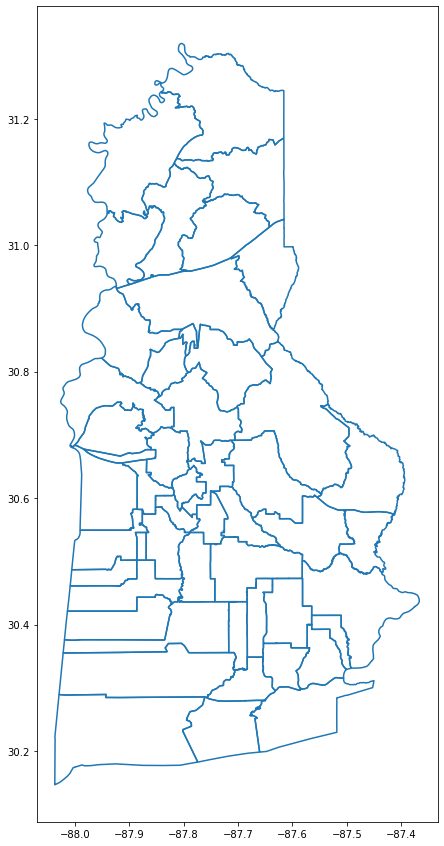

In [74]:
vest_al_18[vest_al_18["COUNTYFP20"]=="003"].boundary.plot(figsize=(15,15))
print(list(vest_al_18[vest_al_18["COUNTYFP20"]=="003"]["NAME20"]))

In [80]:

IFrame("./raw-from-source/County_Shapefiles/Baldwin/2021_Baldwin_Precincts.pdf", width=900, height=900)

In [79]:
IFrame("./raw-from-source/County_Shapefiles/Baldwin/Voting-Precincts-and-Voting-Places-in-Baldwin-County-AL-(PUBLIC)---Revised-July-20-2020908144dd-8fd7-4d13-acd2-d6032a3905ec.pdf", width=900, height=900)

### Calhoun

In [ ]:
vest_al_18[vest_al_18["COUNTYFP20"]=="015"].boundary.plot(figsize=(15,15))
print(list(vest_al_18[vest_al_18["COUNTYFP20"]=="015"]["NAME20"]))

In [81]:
IFrame("./raw-from-source/County_Shapefiles/Calhoun/Commission_Districts_Voting.pdf", width=900, height=900)

### Limestone

In [ ]:
vest_al_18[vest_al_18["COUNTYFP20"]=="083"].boundary.plot(figsize=(15,15))
print(list(vest_al_18[vest_al_18["COUNTYFP20"]=="083"]["NAME20"]))

In [ ]:
IFrame("./raw-from-source/County_Shapefiles/Limestone/2020-Limestone-County-Beat-Map-with-Polling-Locations.pdf", width=900, height=900)

### Madison

In [ ]:
vest_al_18[vest_al_18["COUNTYFP20"]=="089"].boundary.plot(figsize=(15,15))
print(list(vest_al_18[vest_al_18["COUNTYFP20"]=="089"]["NAME20"]))

In [82]:
IFrame("./raw-from-source/County_Shapefiles/Madison/2020-Polling-Loations-as-of-7-14-2020.pdf", width=900, height=900)

### Mobile

In [ ]:
vest_al_18[vest_al_18["COUNTYFP20"]=="097"].boundary.plot(figsize=(15,15))
print(list(vest_al_18[vest_al_18["COUNTYFP20"]=="097"]["NAME20"]))

In [ ]:
IFrame("./raw-from-source/County_Shapefiles/Mobile/Precincts2020.pdf", width=900, height=900)

### Morgan

In [ ]:
vest_al_18[vest_al_18["COUNTYFP20"]=="103"].boundary.plot(figsize=(15,15))
print(list(vest_al_18[vest_al_18["COUNTYFP20"]=="103"]["NAME20"]))

In [83]:
IFrame("./raw-from-source/County_Shapefiles/Morgan/Map_Screenshot.png", width=900, height=900)

### St. Clair

In [ ]:
vest_al_18[vest_al_18["COUNTYFP20"]=="115"].boundary.plot(figsize=(15,15))
print(list(vest_al_18[vest_al_18["COUNTYFP20"]=="115"]["NAME20"]))

In [84]:
IFrame("./raw-from-source/County_Shapefiles/St_Clair/Map_Screenshot.png", width=900, height=900)

### Shelby

In [ ]:
vest_al_18[vest_al_18["COUNTYFP20"]=="117"].boundary.plot(figsize=(15,15))
print(list(vest_al_18[vest_al_18["COUNTYFP20"]=="117"]["NAME20"]))

In [85]:
IFrame("./raw-from-source/County_Shapefiles/Shelby/Map_Screenshot.png", width=900, height=900)

### Talladega

In [ ]:
vest_al_18[vest_al_18["COUNTYFP20"]=="121"].boundary.plot(figsize=(15,15))
print(list(vest_al_18[vest_al_18["COUNTYFP20"]=="121"]["NAME20"]))

In [86]:
IFrame("./raw-from-source/County_Shapefiles/Talladega/voting precints map.pdf", width=900, height=900)

### Cullman

['Vinemont Comm Ctr', 'Arkadelphia FD', 'Providence FD', 'Bethsadia FD', 'Gold Ridge Comm Ctr', 'Berlin Comm Ctr', 'Welti Mt Zion Church', 'Joppa VFD', 'Friendship Church', 'Crane Hill FD', 'Moody Town Union Hill Church', 'Dodge City Comm Ctr', 'Valley Grove Comm Ctr', 'Simcoe Comm Ctr', 'Hanceville City Hall', 'Trimble Fire Dept', 'Colony Education Complex', 'Baileyton Senior Ctr', 'Brushy Pond Comm Ctr', 'Bremen FD', 'Garden City Town Hall', 'West Point Comm Ctr', 'Stouts Mountain Church', 'Hanceville Civic Ctr', 'Baldwin Comm Ctr', 'Grandview Comm Ctr', 'Johnson Crossing VFD', 'Beat 8 Comm Ctr', 'Brooklyn Comm Ctr', 'Center Hill Comm Ctr', 'Walter Comm Ctr', 'Holly Pond FD', 'Cullman Co Health Dept', 'Good Hope City Hall', 'Donald E Green Senior Ctr', 'Cullman Co Office Bldg', 'Kelley Comm Ctr', 'East Point Comm Ctr', 'Bolte White Grove Church', 'Cullman City Hall', 'Battleground FD', 'Bethel Comm Ctr', 'Jones Chapel FD', 'Logan FD', 'New Canaan Senior Ctr', 'Fairview FD/Town Hall',

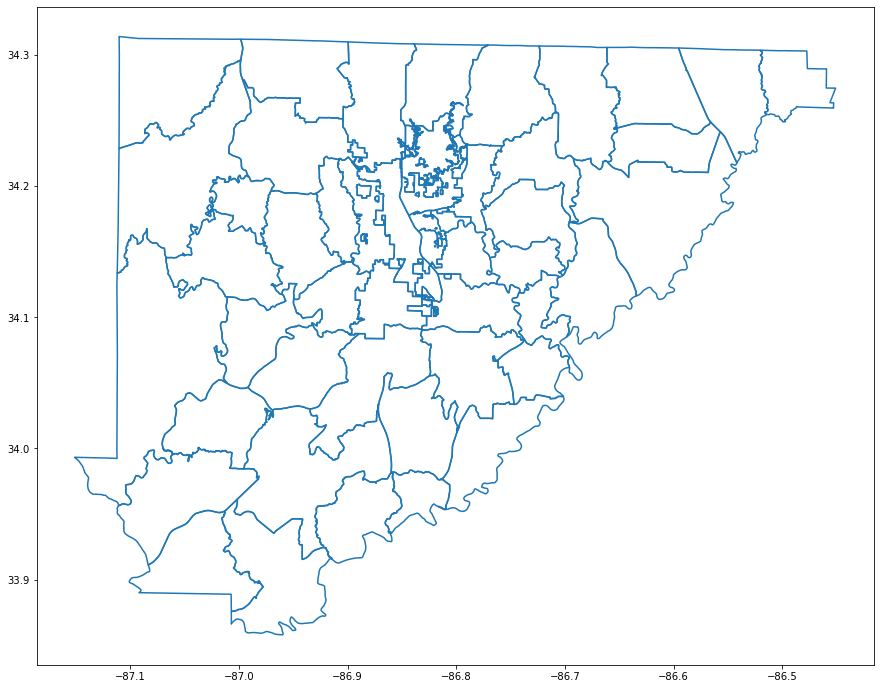

In [88]:
vest_al_18[vest_al_18["COUNTYFP20"]=="043"].boundary.plot(figsize=(15,15))
print(list(vest_al_18[vest_al_18["COUNTYFP20"]=="043"]["NAME20"]))

In [87]:
IFrame("./raw-from-source/County_Shapefiles/Cullman/54558b3036051.image.jpg", width=900, height=900)

## 4. Precinct Boundaries from County - No Map Available (8)
8 counties fall into this category:
1. Dekalb
2. Franklin
3. Jefferson
4. Lee
5. Marengo
6. Marshall
7. Tuscaloosa
8. Blount

Note: Precinct changes over time are listed for Jefferson County (https://jeffcoprobatecourt.com/elections/voting-precinct-changes/) and polling locations are listed for Marshall and Tuscaloosa Counties.

In [ ]:
al_fips_dict_mod = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

alt_source = [ "De Kalb", "Franklin", "Jefferson", "Lee", "Marengo", "Marshall", "Tuscaloosa"]

for county in alt_source:
    plt = vest_al_18[vest_al_18["COUNTYFP20"]==al_fips_dict_mod[county]].plot(figsize=(20,20),column="NAME18",legend=True)
    plt.set_title(county)

# Shapefile Validation

Here we will attempt to check the sourcefile geometries against VEST's

In [ ]:
attempt_two = pd.merge(tiger_vtd,non_prov_absentee,indicator=True,how="outer",on="unique_ID")
print(attempt_two["_merge"].value_counts())
shapefile_election = attempt_two[attempt_two["_merge"]=="both"]
final_merge = pd.merge(vest_al_18,shapefile_election,indicator="final_merge",how="outer",on="unique_ID")

In [ ]:
both = final_merge[final_merge["final_merge"]=="both"]
vest_geoms = gp.GeoDataFrame(both,geometry="geometry_x",crs=vest_al_20.crs)
source_geoms = gp.GeoDataFrame(both,geometry="geometry_y",crs=vest_al_20.crs)
source_geoms = source_geoms.to_crs(3857)
vest_geoms = vest_geoms.to_crs(3857)
source_geoms["geometry_x"]=source_geoms.buffer(0)
vest_geoms["geometry_y"]=vest_geoms.buffer(0)
vals = source_geoms.geom_almost_equals(vest_geoms,decimal=0)
print(vals.value_counts())

In [ ]:
count = 0
area_list = []
for i in range(0,len(source_geoms)):
    diff = source_geoms.iloc[[i]].symmetric_difference(vest_geoms.iloc[[i]])
    intersection = source_geoms.iloc[[i]].intersection(vest_geoms.iloc[[i]])
    area = float(diff.area/10e6)
    area_list.append(area)
    #print("Area is " + str(area))

    if (area > .1):
        count += 1
        name = source_geoms.iat[i,2]
        
        print(str(count)+") For " + name + " difference in area is " + str(area))
        if (intersection.iloc[0].is_empty):
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            base.set_title(name)
        else:
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            intersection.plot(color="green",ax=base)
            base.set_title(name)

In [ ]:
df = pd.DataFrame(area_list)
print(df.shape)

print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and .1 km^2")
print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " precincts w/ a difference between .1 and .5 km^2")
print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " precincts w/ a difference between .5 and 1 km^2")
print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")